# Вариационные автокодировщики

### Загрузка, нормировка и визуалиация данных

In [3]:
import torchvision.datasets

In [4]:
from torchvision.datasets import MNIST#, FashionMNIST
from torch.utils.data import TensorDataset, DataLoader
import torch
from torch import nn
from torch import optim
from torch.autograd import Variable
import torch.nn.functional as F
import math
#dtype = torch.cuda.DoubleTensor
#import chainer
BATCH_SIZE = 100
CONDITIONAL_SHAPE = 5
LATENT_DIMENSION = 16

In [5]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] ="1,2,3"

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.set_default_tensor_type(torch.cuda.DoubleTensor)

In [7]:
from matplotlib import pyplot as plt
%matplotlib inline

def show_images(x, data_x):
    plt.figure(figsize=(28, 28 / 10 * (x.shape[0] // 10 + 1)))
    x = x.view(-1, 4, 4)
    for i in range(x.shape[0]):
        plt.subplot(x.shape[0] // 10 + 1, 10, i + 1)
        plt.imshow(x.cpu().data[i].numpy())
        plt.title("%1.3f %1.3f %1.3f" %(data_x.cpu().data[i].numpy()[0], data_x.cpu().data[i].numpy()[1], data_x.cpu().data[i].numpy()[2]))
        plt.axis('off')
    plt.show()

In [8]:
data = MNIST('mnist', download=True, train=True)
train_data = TensorDataset(data.train_data.view(-1, 28 * 28).float() / 255, data.train_labels)
#data = pkl.load(open('test_data','rb'))
data = MNIST('mnist', download=True, train=False)
test_data = TensorDataset(data.test_data.view(-1, 28 * 28).float() / 255, data.test_labels)

In [15]:
import numpy as np
data = np.load('/home/sayankotor/data/EgorWGAN/real_data.npz')
data_img = (data['EnergyDeposit'])
data_img.shape

(29600, 30, 30)

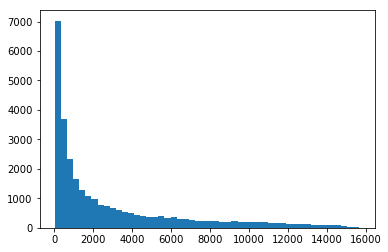

In [16]:
plt.hist(np.sum(data_img, axis = (1,2)), bins = 50)
plt.show()

In [17]:
keys = data.keys()
keys

KeysView(<numpy.lib.npyio.NpzFile object at 0x7fc1eda2d2e8>)

In [18]:
data_point = data['ParticlePoint']
data_momentum = data['ParticleMomentum']
print (data_point.shape)
print (data_momentum.shape)

(29600, 2)
(29600, 3)


In [19]:
data_x = np.concatenate([data_point[:, :2], data_momentum], axis = 1)

In [20]:
np.std(data_x)

14.133324276811011

In [21]:
from sklearn import preprocessing
import numpy as np
data_x = preprocessing.scale(data_x)

In [22]:
#data_img = np.clip(data_img, 1e-8, 8)
#data_img_log = np.log(data_img)
min_ = np.min(data_img)
max_ = np.max(data_img)
print(min_, max_)

0.0 3371.953567922453


In [23]:
n_data_img = []
reconstr_data_img = []

min_ = np.min(data_img)
max_ = np.max(data_img)
min_30 = np.min(data_img, axis = 0)
max_30 = np.max(data_img, axis = 0)

for i, elem in enumerate(data_img):
    n_elem = (elem-min_30)/(max_30 - min_30)
    rec_elem = n_elem*(max_30 - min_30)
    n_data_img.append(n_elem)
    reconstr_data_img.append(rec_elem)
    if (i%5000 == 0):
        print (i)
n_data_img = np.array(n_data_img)
reconstr_data_img = np.array(reconstr_data_img)


0
5000
10000
15000
20000
25000


In [24]:
print (data_img.shape)

(29600, 30, 30)


**Cut it for 4*4**

In [25]:
def cut(data_):
    new_data = []
    for elem in data_:
        new_data.append(elem[13:17, 13:17])
    new_data = np.array(new_data)
    return new_data

In [26]:
cut_data = cut(data_img)
n_cut_data = cut(n_data_img)

In [27]:
cut_data.shape

(29600, 4, 4)

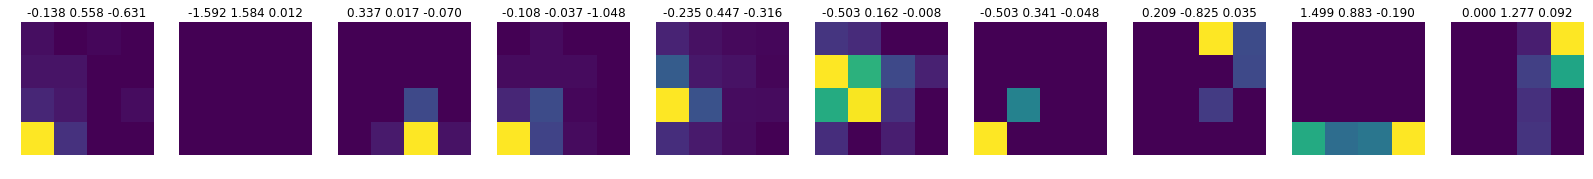

In [28]:
show_images(Variable(torch.from_numpy(cut_data[20:30])), Variable(torch.from_numpy(data_x[20:30])))

In [29]:
np.max(n_cut_data)

1.0

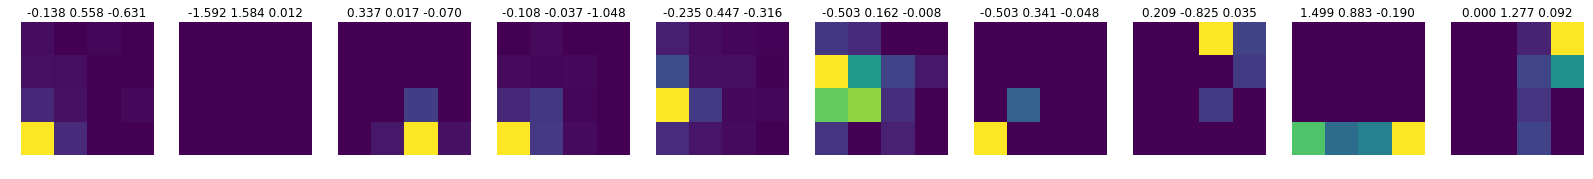

In [30]:
show_images(Variable(torch.from_numpy(n_cut_data[20:30])), Variable(torch.from_numpy(data_x[20:30])))

## loss function ##

In [31]:
def reconstruction_loss_gauss(x_true_object, mu_generative_distr, log_sigma_var, reduce = 'sum'):
    x_prec = torch.exp(-log_sigma_var)
    x_diff = x_true_object - mu_generative_distr
    x_power = (x_diff * x_diff) * x_prec * -0.5
    loss = (log_sigma_var + math.log(2 * math.pi)) / 2 - x_power
    if reduce == 'sum':
        return torch.mean(loss)
    return loss


In [32]:
def kl1(mean, ln_var, reduce='sum'):
    var = torch.exp(ln_var)
    mean_square = mean * mean
    loss = (mean_square + var - ln_var - 1) * 0.5
    if reduce == 'sum':
        return torch.sum(loss)
    else:
        return loss

In [33]:
def kl(mean1, ln_var1, mean2, ln_var2, reduce='sum'):
    var1 = torch.exp(ln_var1)
    var2 = torch.exp(ln_var2)
    mean_square = (mean1 - mean2) * (mean1 - mean2)
    loss = ((mean_square + var1)/var2 - 2*ln_var1 + 2*ln_var2 - 1) * 0.5
    if reduce == 'sum':
        return torch.mean(loss)
    else:
        return loss

## model

In [34]:
INPUT_IMAGE_SIZE = 16
INPUT_CONDITIONAL_SIZE = 4
HIDDEN_SIZE = 1

In [35]:
from torch.distributions import Normal, Bernoulli
from chainer.functions.math import exponential

class CVAE(nn.Module):
    def __init__(self, d, D_x, D_y, alpha):
        """Инициализирует веса модели.
        Вход: d, int - размерность латентного пространства.
        Вход: D_x, int - размерность пространства x.
        Вход: D_y, int - размерность пространства y.
        Вход: alpha, float - число от 0 до 1, коэффициент смеси моделей СVAE и GSNN.
        """
        super(type(self), self).__init__()
        self.d = d
        self.D_x = D_x
        self.D_y = D_y
        self.log_s = nn.Parameter(torch.zeros(1))
        self.i = 0
        self.proposal_network = nn.Sequential(
            nn.Linear(self.D_y + self.D_x, 150),
            nn.LeakyReLU(),
            nn.Linear(150, 75),
            nn.LeakyReLU(),
            nn.Linear(75, 25),
            nn.LeakyReLU(),
            nn.Linear(25, self.d),
            nn.Sigmoid()
        )
        self.proposal_mu_head = nn.Linear(self.d, self.d)
        self.proposal_sigma_head = nn.Sequential(nn.Linear(self.d, self.d), nn.Softplus())
        #self.prior_network = nn.Sequential(
            #nn.Linear(self.D_x, 200),
            #nn.LeakyReLU(),
            #nn.Linear(200, 200),
            #nn.LeakyReLU(),
        #)
        self.prior_mu_head = nn.Linear(25, self.d)
        self.prior_sigma_head = nn.Sequential(nn.Linear(25, self.d), nn.Softplus())
    
        self.generative_network = nn.Sequential(
            nn.Linear(self.d + self.D_x, 25),
            nn.LeakyReLU(),
            nn.Linear(25, 75),
            nn.LeakyReLU(),
            nn.Linear(75, 150),
            nn.LeakyReLU(),
            nn.Linear(150, self.D_y),
            nn.Sigmoid()
        )

        
        self.generative_mu_head = nn.Sequential(nn.Linear(self.D_y, self.D_y))
        self.generative_sigma_head = nn.Sequential(nn.Linear(self.D_y, self.D_y), nn.Softplus())
        
    def proposal_forward(self, pictures, conditions):
        pictures = pictures.view(pictures.shape[0], 16)
        conditions = conditions.view(conditions.shape[0], self.D_x)
        network_input = torch.cat([pictures, conditions], dim=1)
        answ = self.proposal_network(network_input)
        answ = answ.view(answ.shape[0], self.d)
        return answ

    def generative_forward(self, z, x_batch):
        z = z.view(z.shape[0], self.d)
        x_batch = x_batch.view(x_batch.shape[0], self.D_x)
        network_input = torch.cat([z, x_batch], dim=1)
        answ = self.generative_network(network_input)
        answ = answ.view(answ.shape[0], self.D_y)
        return self.generative_mu_head(answ), self.generative_sigma_head(answ)
    
    def proposal_distr(self, x, y):
        """
        Генерирует предложное распределение на z.
        Вход: x, Variable - матрица размера n x D.
        Возвращаемое значение: tuple(Variable, Variable),
        Каждое Variable - матрица размера n x d.
        Первое - mu, второе - sigma.
        """
        #a = torch.cat([x, y], dim=1)
        #a = a.type(torch.cuda.DoubleTensor)
        #a_cuda = Variable(a, requires_grad=True).cuda()
        q_teta = self.proposal_forward(y, x)
        return self.proposal_mu_head(q_teta), torch.clamp(self.proposal_sigma_head(q_teta), min = 1e-8)

    def prior_distr(self, n):
        """
        Генерирует априорное распределение на z.
        Вход: x, Variable - матрица размера n x D_x.
        Возвращаемое значение: tuple(Variable, Variable),
        Каждое Variable - матрица размера n x d.
        Первое - mu, второе - sigma.
        """
        mu = Variable(torch.Tensor(n, self.d).fill_(0))
        sigma = Variable(torch.Tensor(n, self.d).fill_(1))
        return mu, sigma


    def sample_latent(self, distr, K=1):
        """
        Генерирует сэмплы из гауссовского распределения на z.
        Сэмплы должны быть дифференцируемы по параметрам распределения!
        Вход: distr, tuple(Variable, Varable). Каждое Variable - матрица размера n x d.
        Первое - mu, второе - sigma.
        Вход: K, int - число сэмплов для каждого объекта.
        Возвращаемое значение: Variable, матрица размера n x d.
        """
    
        mu, sigma = distr
        eps = torch.from_numpy(
            np.random.normal(0, 1, size=(K * sigma.shape[0], sigma.shape[1]))
        )
        eps = eps.cuda().to(device)
        return mu.repeat(K, 1) + sigma.repeat(K, 1) * Variable(eps, requires_grad=False)
        

    def sample_prior(self, x_batch):
        mu, sigma = self.prior_distr(x_batch.shape[0])
        m = Normal(mu, sigma)
        answ = m.sample()  
        return answ.cuda().to(device), x_batch
    
    def sample_prior1(self, x_batch):
        """
        Генерирует сэмплы из априорного распределения на z.
        Вход: num_samples, int - число сэмплов, которые надо сгененрировать.
        Возвращаемое значение: Variable, матрица размера num_samples x d.
        """
        m = Normal(self.latent_mu, self.latent_sigma)
        answ = m.sample()  
        return answ.cuda().to(device), x_batch
        

    def generative_distr(self, z):
        #return self.generative_network.forward(z)
        int_distr = self.generative_network(z)
        return (self.generative_mu_head(int_distr), torch.clamp(self.generative_sigma_head(int_distr), min = 1e-8))


    def batch_loss(self, batch, x_batch, K, alpha_, is_show):
        batch = Variable(batch)
        x_batch = Variable(x_batch)        
        
        q_phi = self.proposal_distr(x_batch, batch)
        z = self.sample_latent(q_phi, K)
        
        self.latent_mu = torch.mean(q_phi[0], 0)
        self.latent_sigma = torch.mean(q_phi[1], 0)
        
        mu, sigma = self.generative_forward(z, x_batch)
        answ1 = reconstruction_loss_gauss(batch, mu, torch.log(sigma))

        mu_prior, sigma_prior = self.prior_distr(batch.shape[0])
        
        answ2 = kl1(q_phi[0],torch.log(q_phi[1]))
        
        if (is_show):        
            a_gen1 = self.generate_samples1(
                Variable(torch.cuda.DoubleTensor(n_cut_data[20:30]).to(device)),
                Variable(torch.cuda.DoubleTensor(data_x[20:30]).to(device))
            )
            print ("a_gen shape", a_gen1.shape)
            print ("alpha ", alpha_)
            print ("batch_loss:loss_simple, KL", answ1.data.mean() , answ2)
            show_images(a_gen1,  Variable(torch.cuda.DoubleTensor(data_x[20:30]).to(device)))
            show_images(Variable(torch.from_numpy(n_cut_data[20:30])), Variable(torch.from_numpy(data_x[20:30])))
        return answ1, answ2 


    def generate_samples(self, x):
        """
        Генерирует сэмплы из индуцируемого моделью распределения на объекты x.
        Вход: num_samples, int - число сэмплов, которые надо сгененрировать.
        Возвращаемое значение: Variable, матрица размера num_samples x D.
        """
        z, x_b = self.sample_prior(x)
        mu, sigma = self.generative_forward(z, x_b)
        #mu, sigma = self.conv_forward(self.sample_prior(x))
        m = Normal(mu, sigma)
        answ = m.sample()  
        return answ
    
    def generate_samples1(self, batch, x_batch):
        """
        Генерирует сэмплы из индуцируемого моделью распределения на объекты x.
        Вход: num_samples, int - число сэмплов, которые надо сгененрировать.
        Возвращаемое значение: Variable, матрица размера num_samples x D.
        """
        batch = batch
        x_batch = x_batch        
        
        q_phi = self.proposal_distr(x_batch, batch)
        z = self.sample_latent(q_phi, 1)
        mu, sigma = self.generative_forward(z, x_batch)
        m = Normal(mu, sigma)
        answ = m.sample()  
        return answ
    

def sample_data_batch(bsize, data_, x_data_):
    idxs = np.random.choice(np.arange(data_.shape[0]), size=bsize)
    return torch.cuda.DoubleTensor(data_[idxs]).to(device), torch.cuda.DoubleTensor(x_data_[idxs]).to(device)

In [61]:
import random
import pickle

shapes = data_img.shape
random.seed()
ep = 0
def train_model(model, tests=[], batch_size=40, K=1, num_epochs=350, learning_rate=1e-3):
    model.double()
    model.to(device)
    
    gd = optim.Adam(model.parameters(), lr=learning_rate)
    dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    train_losses1 = []
    train_losses2 = []
    test_results = []
    alpha = 1
    for epoch in range(num_epochs):
        ep = epoch
        if (epoch > 200):
            learning_rate=1e-4
            batch_size=60
        for i, (batch, _) in enumerate(dataloader):
            total = 500
            batch, batch_x = sample_data_batch(batch_size, n_cut_data.reshape(-1, 16), data_x)
            
            loss1, loss2 = model.batch_loss(batch, batch_x, K, alpha, False)
            (loss2 + loss1).backward()
            #print (loss.shape)
            
            train_losses1.append(loss1.data.cpu().numpy())
            train_losses2.append(loss2.data.cpu().numpy())
            gd.step()
            gd.zero_grad()
        loss1, loss2 = model.batch_loss(batch, batch_x, K, alpha, True)
        
        print ("epoch:", epoch)
        loss1, loss2 = model.batch_loss(batch, batch_x, K, alpha, True)
        print('\rTrain loss:', train_losses1[-1] + train_losses2[-1],
                      'Batch', i + 1, 'of', total, ' ' * 10, end='', flush=True)
        with open("/home/sayankotor/data/VAEResG/DUMP/model_try.txt","wb") as file:
            pickle.dump(model,file)
    return {
        'model': model,
        'train_losses_list1': train_losses1,
        'train_losses_list2': train_losses2,
        'test_results': test_results
    }

In [62]:
n_data_img.reshape(-1, 900).shape

(29600, 900)

a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-3.5779) tensor(0.0001, grad_fn=<SumBackward0>)


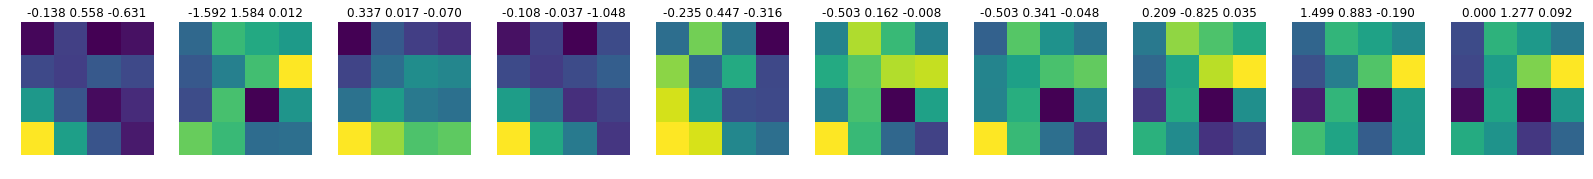

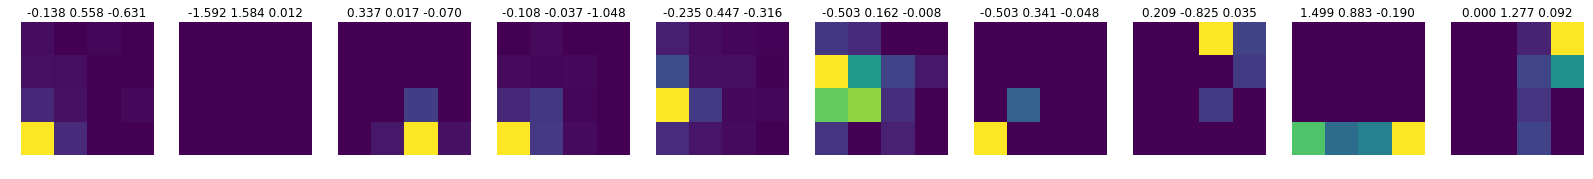

epoch: 0
a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-3.5252) tensor(0.0001, grad_fn=<SumBackward0>)


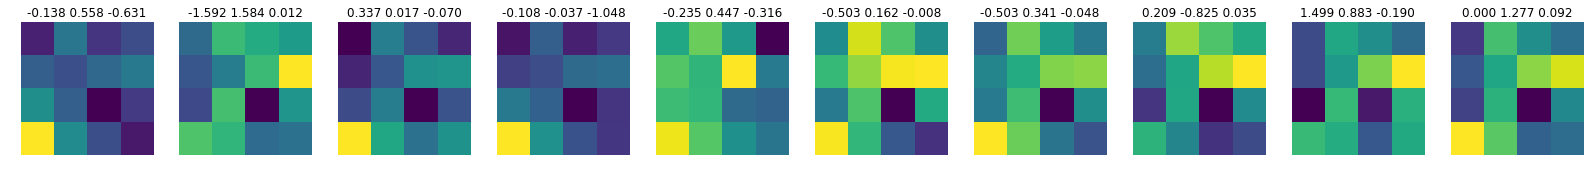

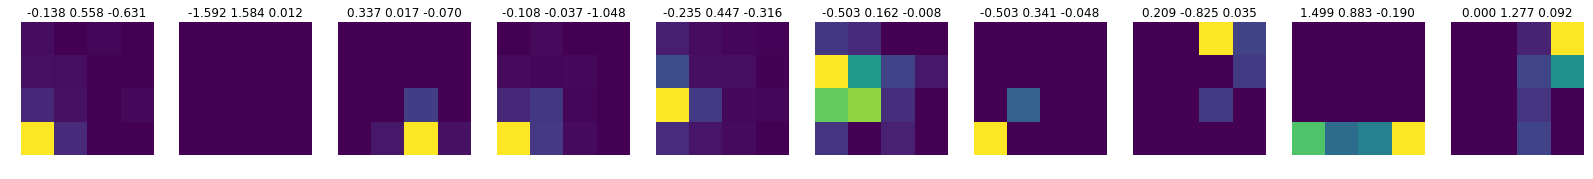

Train loss: -3.586560572058442 Batch 1500 of 500           a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-3.9098) tensor(0.0000, grad_fn=<SumBackward0>)


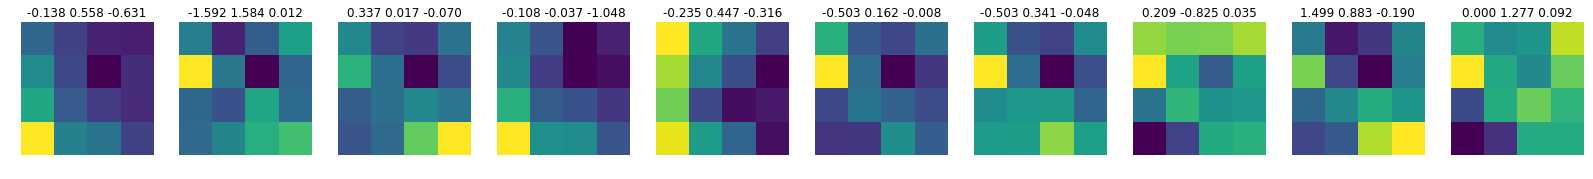

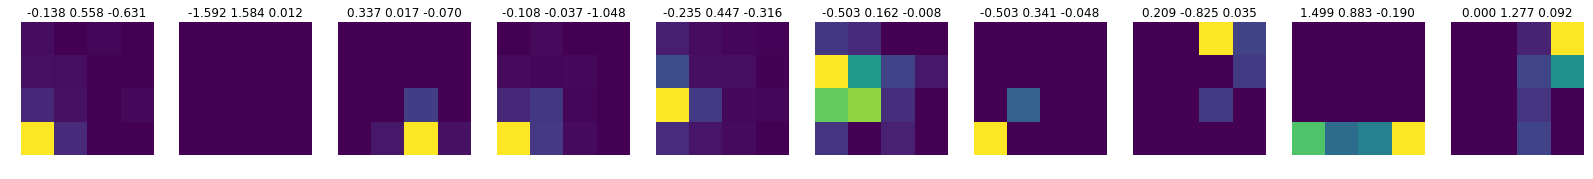

epoch: 1
a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-3.9673) tensor(0.0000, grad_fn=<SumBackward0>)


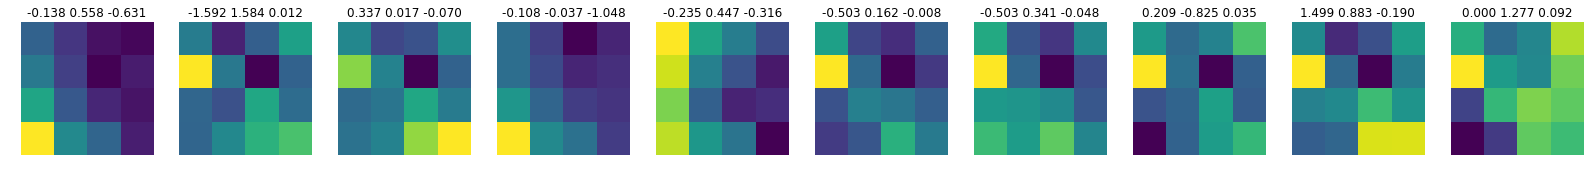

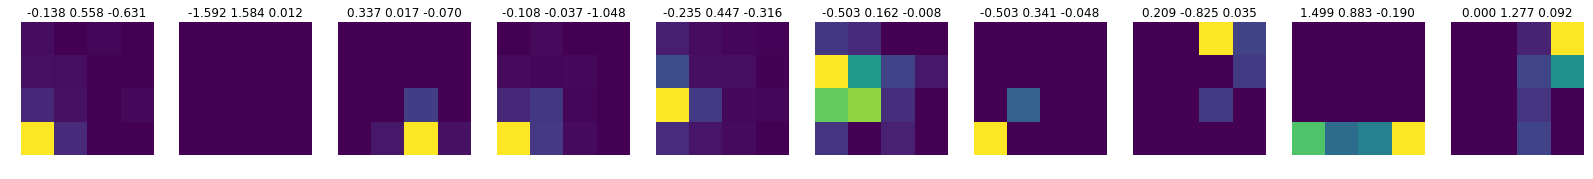

Train loss: -3.8993153746167577 Batch 1500 of 500           a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-3.9862) tensor(0.0000, grad_fn=<SumBackward0>)


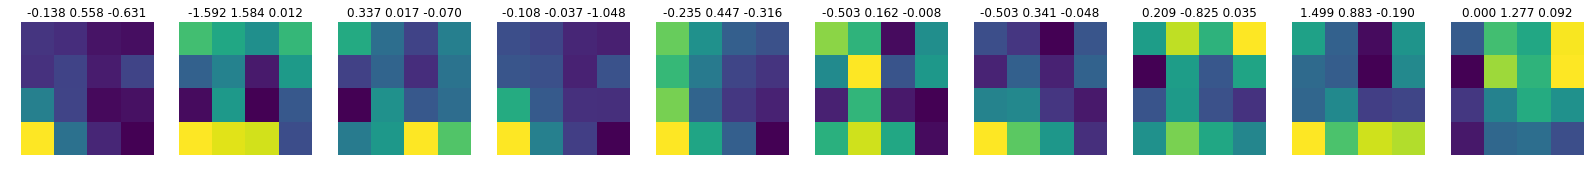

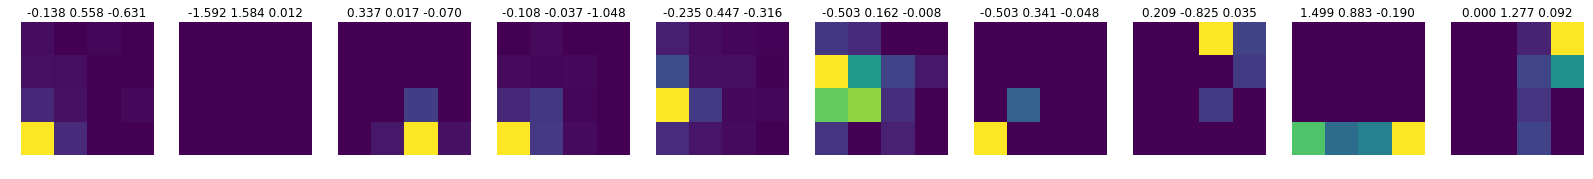

epoch: 2
a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-3.9435) tensor(0.0000, grad_fn=<SumBackward0>)


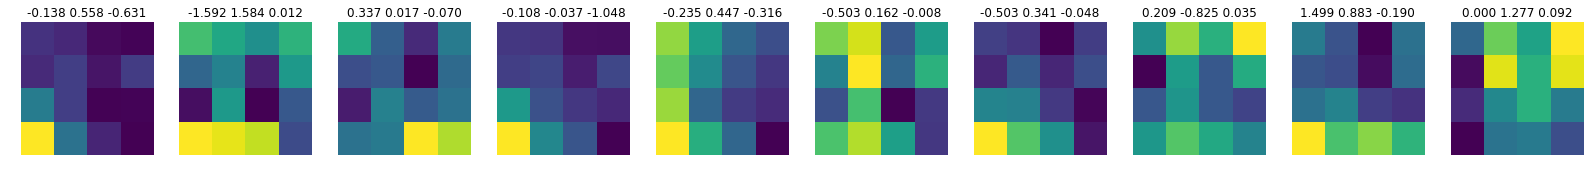

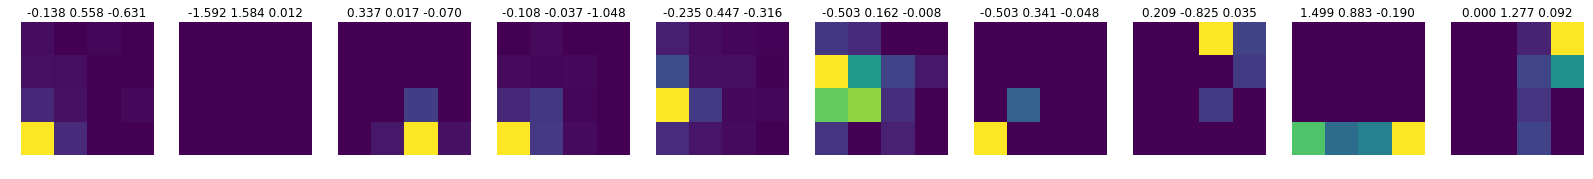

Train loss: -3.9264033214563074 Batch 1500 of 500           a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-4.1402) tensor(3.9129e-06, grad_fn=<SumBackward0>)


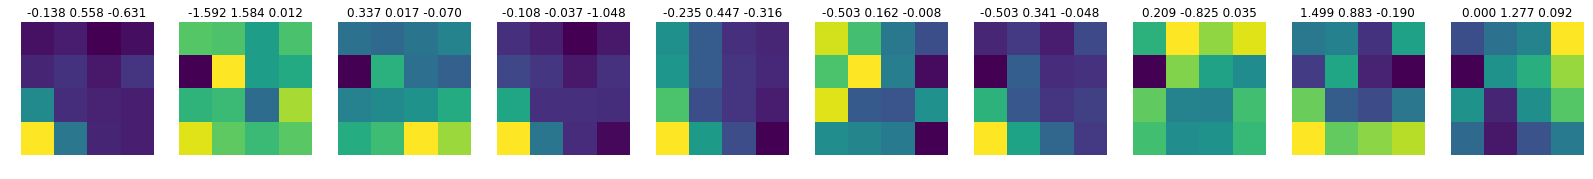

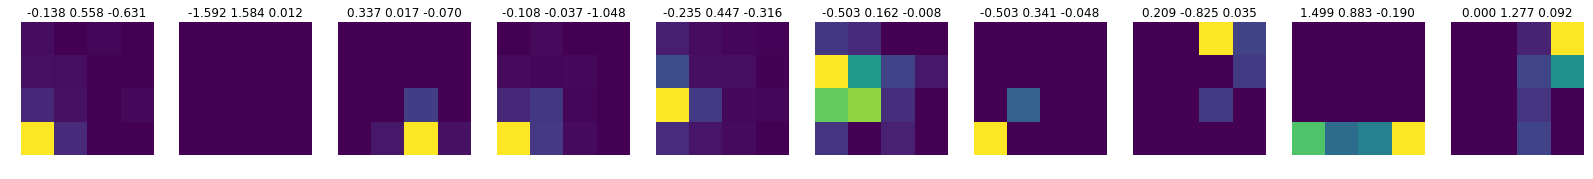

epoch: 3
a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-4.1577) tensor(3.9129e-06, grad_fn=<SumBackward0>)


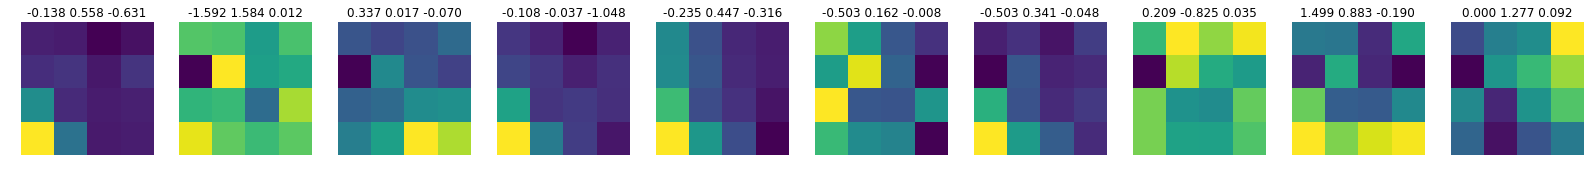

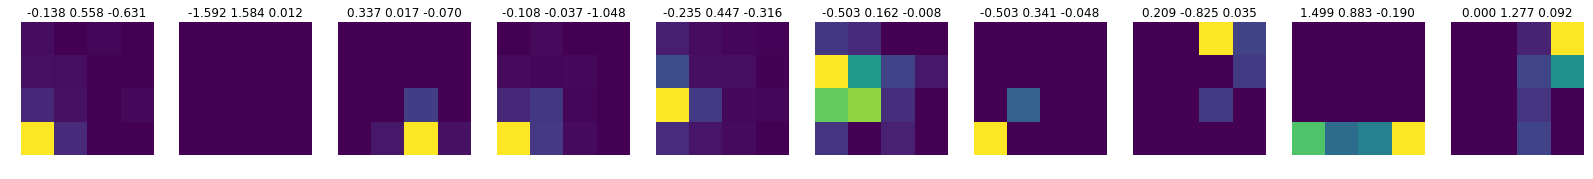

Train loss: -4.112557616911951 Batch 1500 of 500           a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-4.5457) tensor(3.7654e-06, grad_fn=<SumBackward0>)


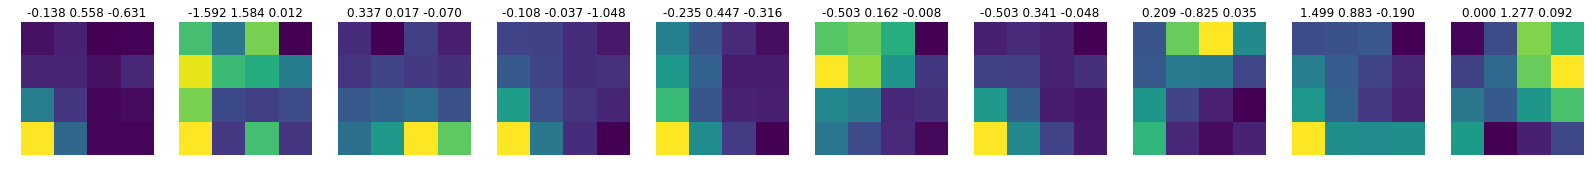

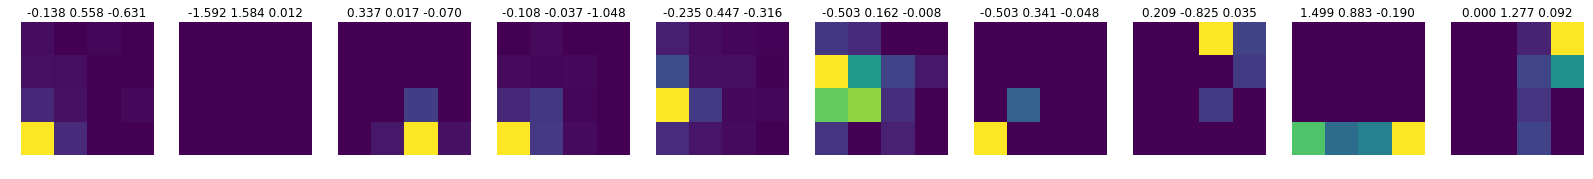

epoch: 4
a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-4.5665) tensor(3.7654e-06, grad_fn=<SumBackward0>)


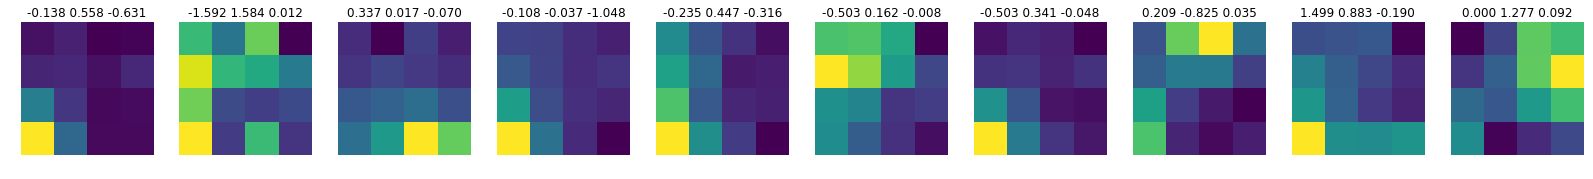

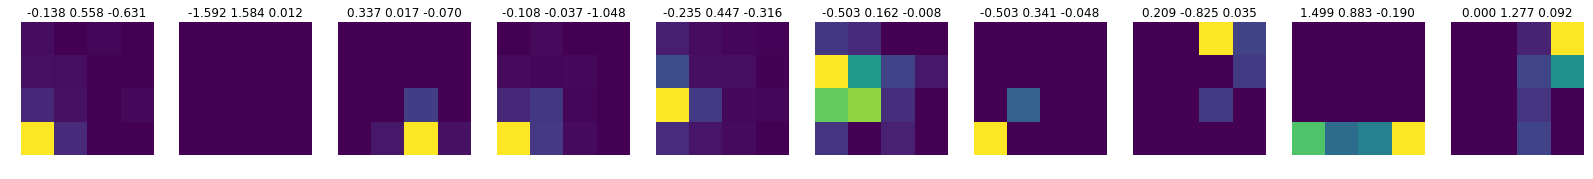

Train loss: -4.485764105134603 Batch 1500 of 500           a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-4.2551) tensor(4.7321e-06, grad_fn=<SumBackward0>)


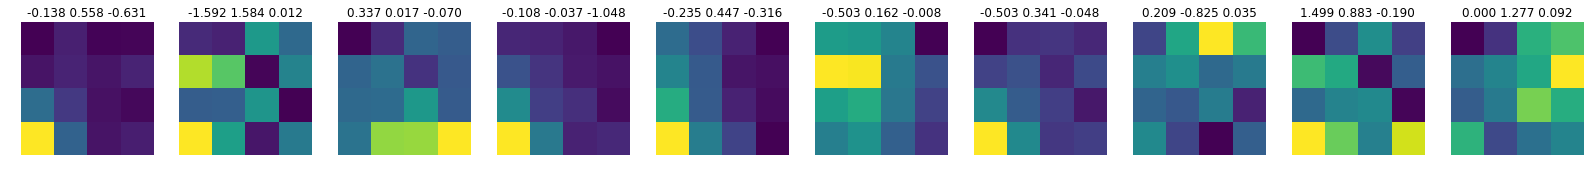

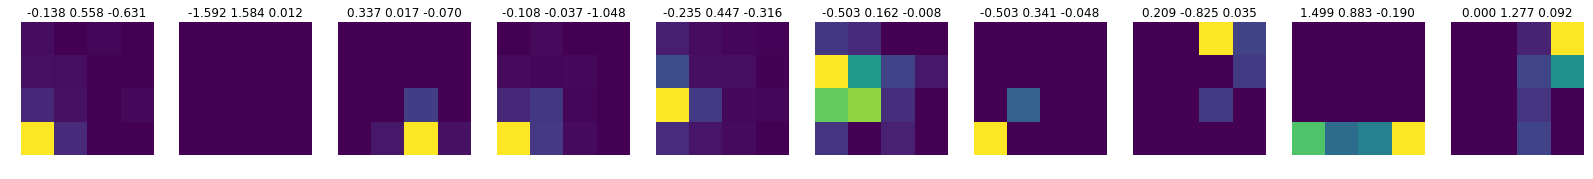

epoch: 5
a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-4.2565) tensor(4.7321e-06, grad_fn=<SumBackward0>)


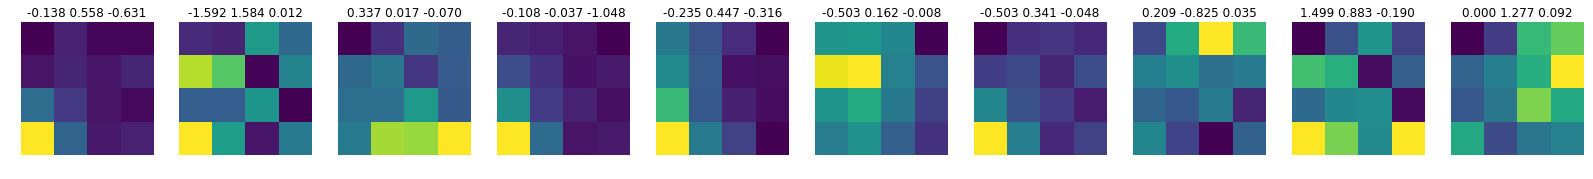

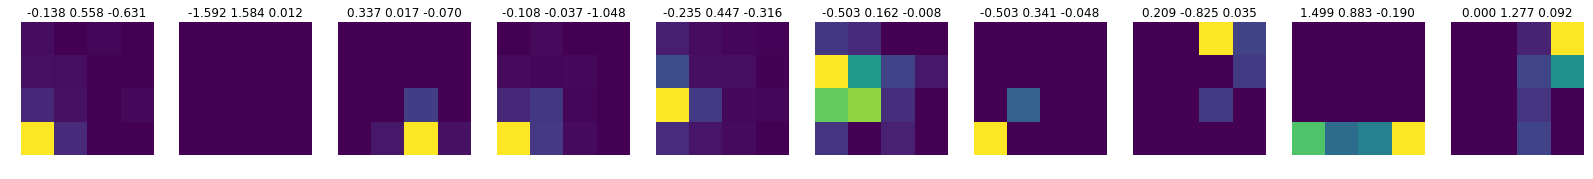

Train loss: -4.220660665440678 Batch 1500 of 500           a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-4.5572) tensor(0.0000, grad_fn=<SumBackward0>)


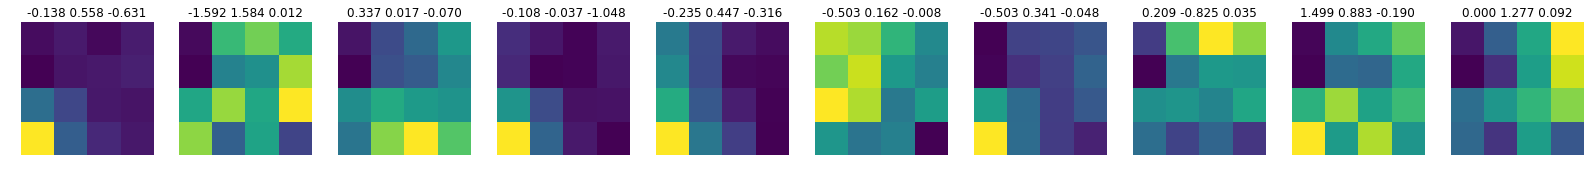

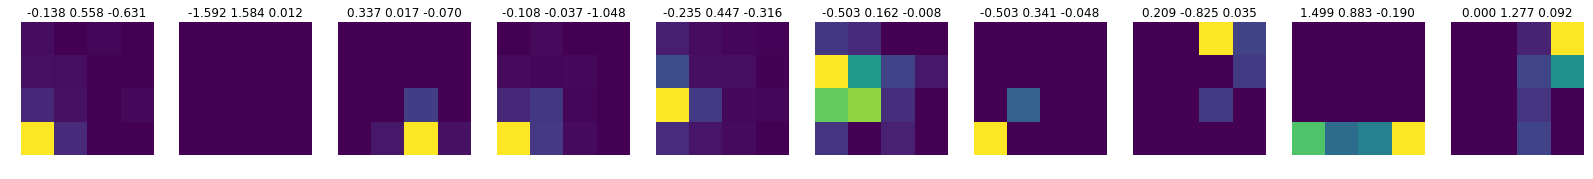

epoch: 6
a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-4.5471) tensor(0.0000, grad_fn=<SumBackward0>)


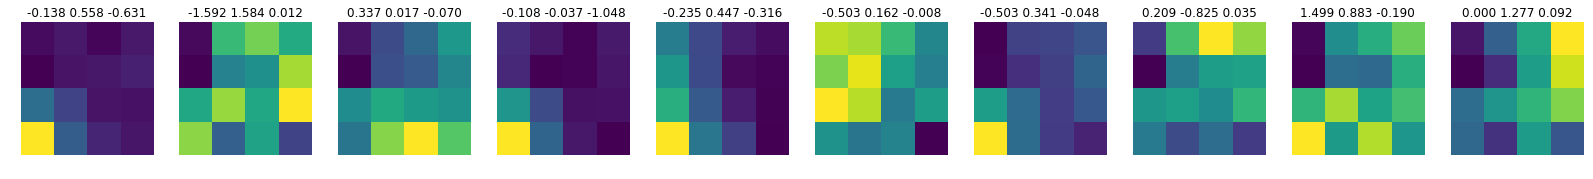

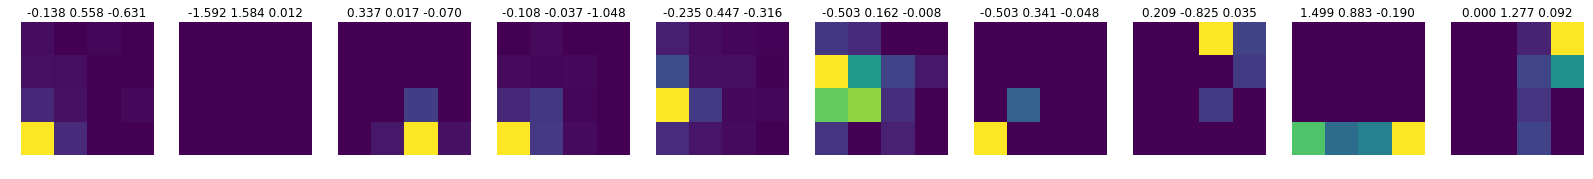

Train loss: -4.597107568887333 Batch 1500 of 500           a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-4.7164) tensor(4.8119e-06, grad_fn=<SumBackward0>)


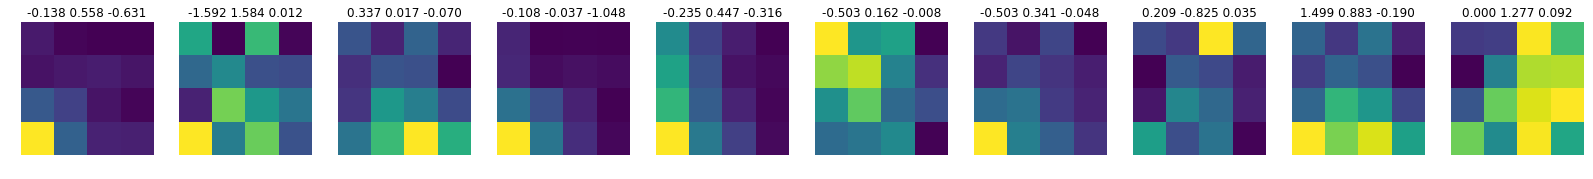

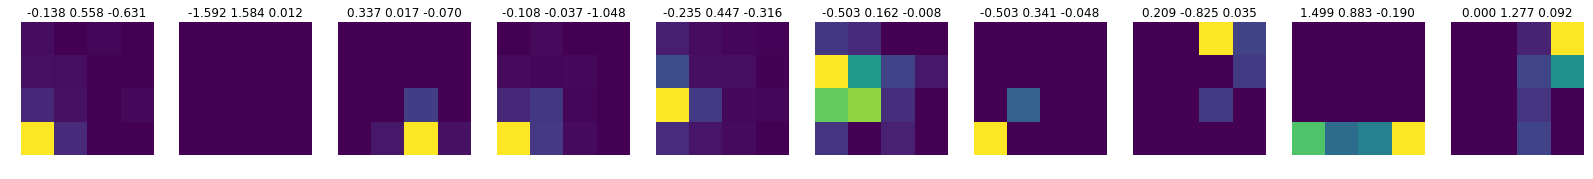

epoch: 7
a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-4.7089) tensor(4.8119e-06, grad_fn=<SumBackward0>)


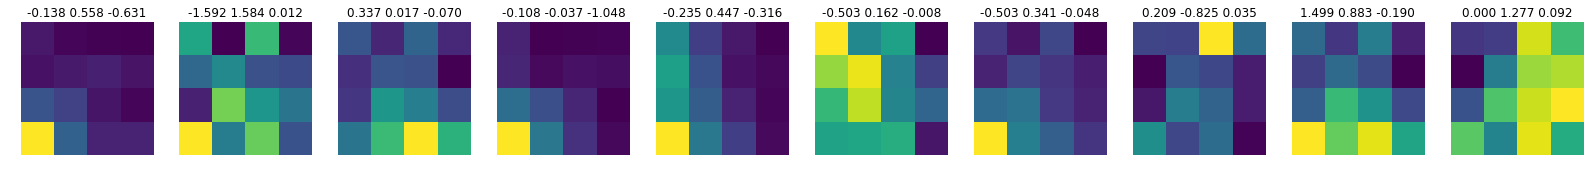

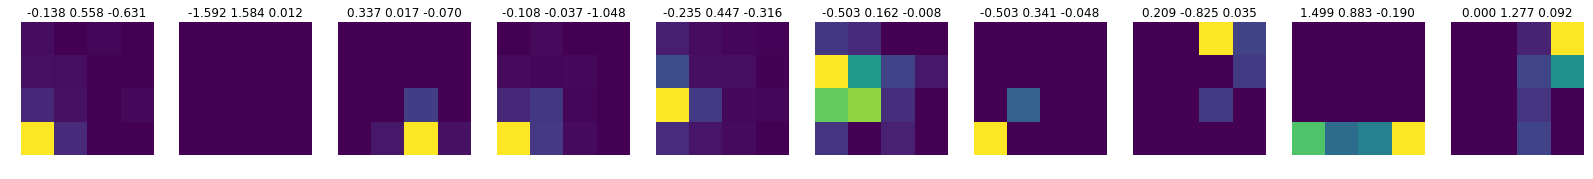

Train loss: -4.674270120789139 Batch 1500 of 500           a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-4.5433) tensor(2.1750e-06, grad_fn=<SumBackward0>)


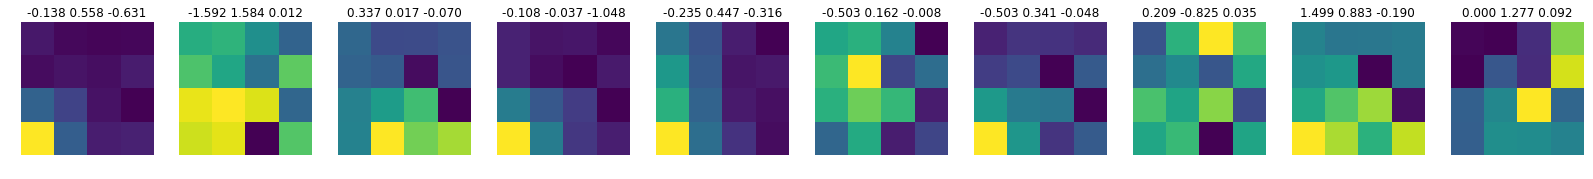

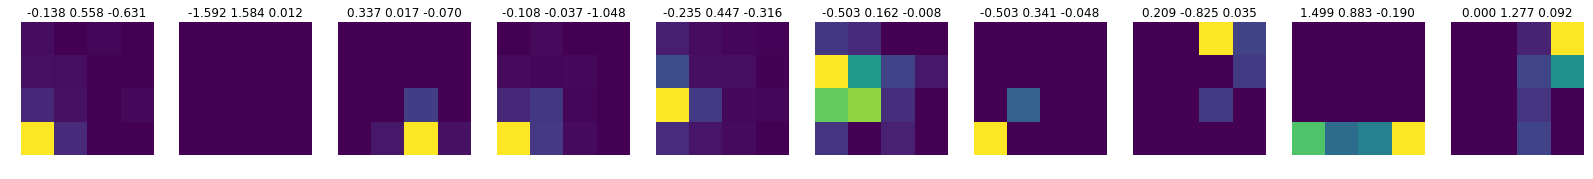

epoch: 8
a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-4.5434) tensor(2.1750e-06, grad_fn=<SumBackward0>)


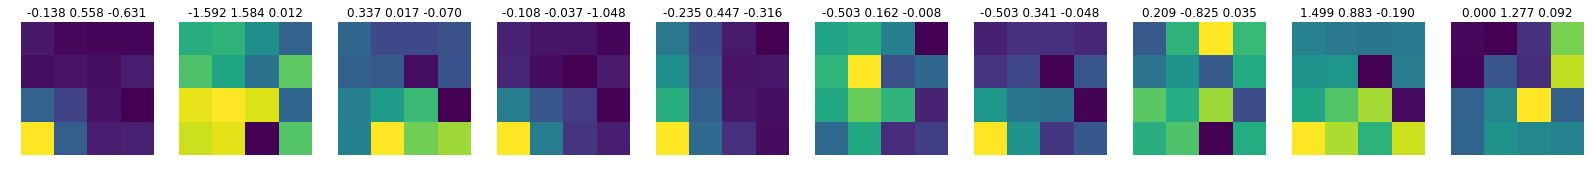

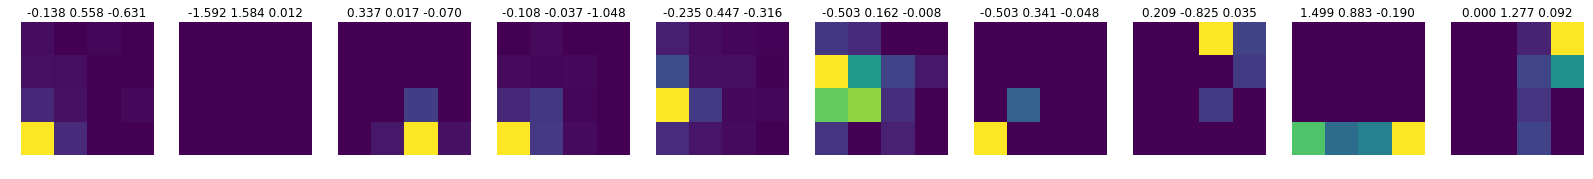

Train loss: -4.705507355923835 Batch 1500 of 500           a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-4.7244) tensor(5.5399e-06, grad_fn=<SumBackward0>)


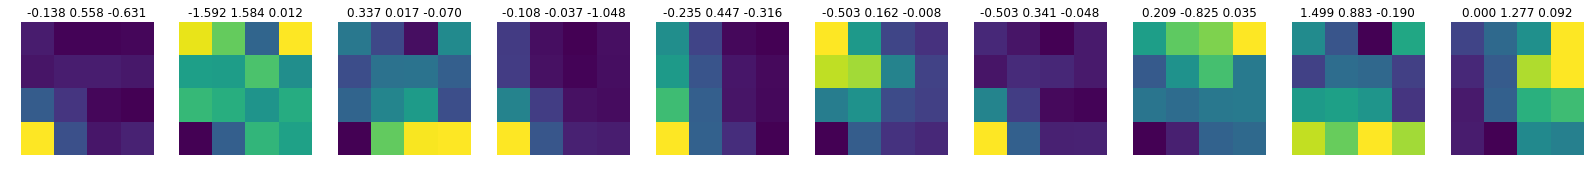

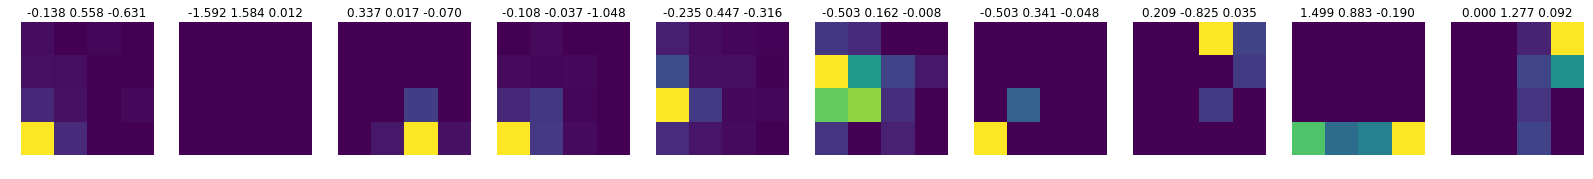

epoch: 9
a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-4.7149) tensor(5.5399e-06, grad_fn=<SumBackward0>)


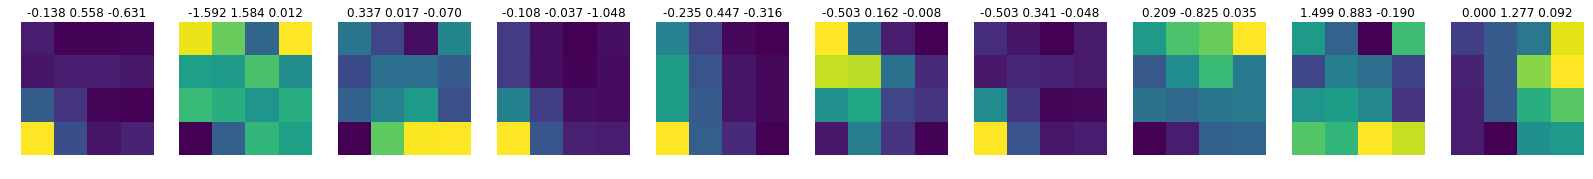

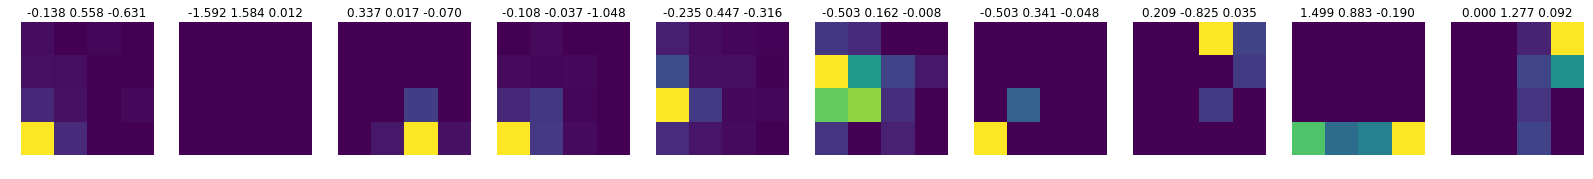

Train loss: -4.67210195858733 Batch 1500 of 500           a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-4.5866) tensor(9.9260e-06, grad_fn=<SumBackward0>)


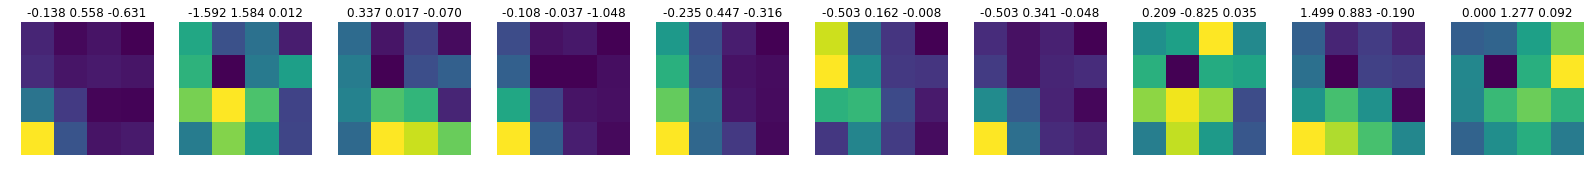

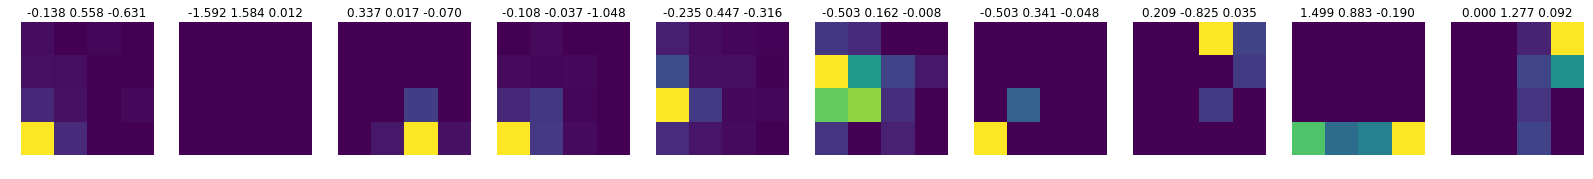

epoch: 10
a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-4.5777) tensor(9.9260e-06, grad_fn=<SumBackward0>)


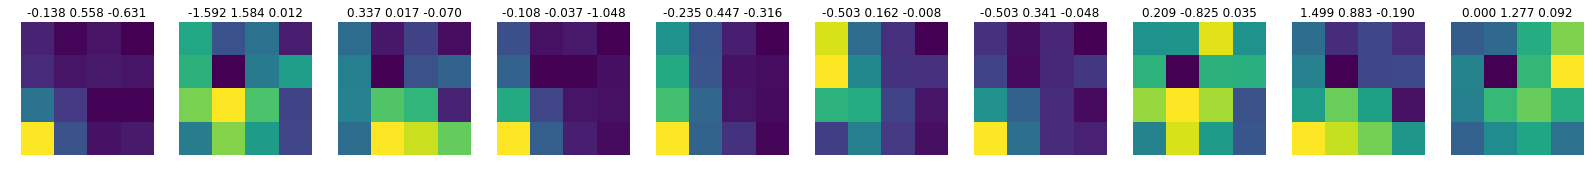

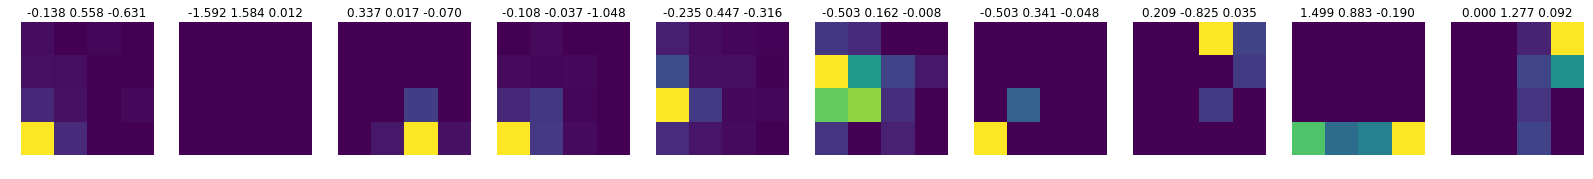

Train loss: -4.711552449266147 Batch 1500 of 500           a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-4.6410) tensor(5.6579e-06, grad_fn=<SumBackward0>)


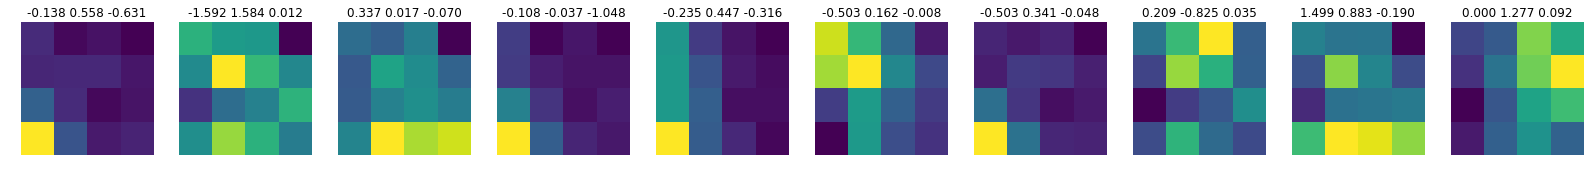

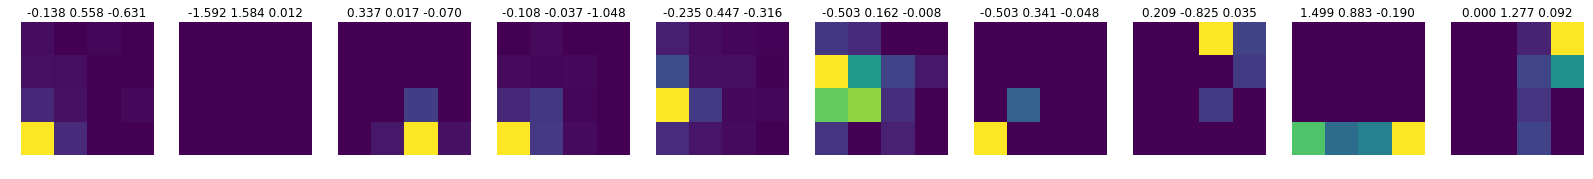

epoch: 11
a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-4.6361) tensor(5.6579e-06, grad_fn=<SumBackward0>)


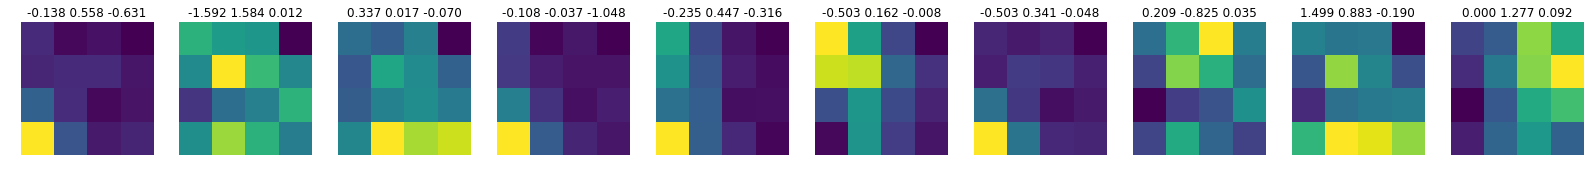

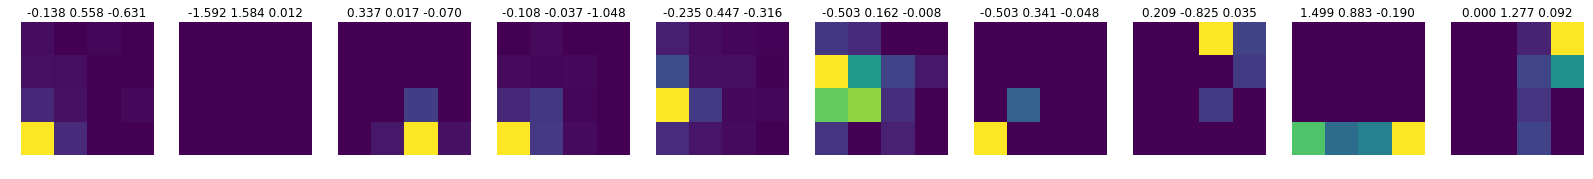

Train loss: -4.642659077550257 Batch 1500 of 500           a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-4.8971) tensor(0.0000, grad_fn=<SumBackward0>)


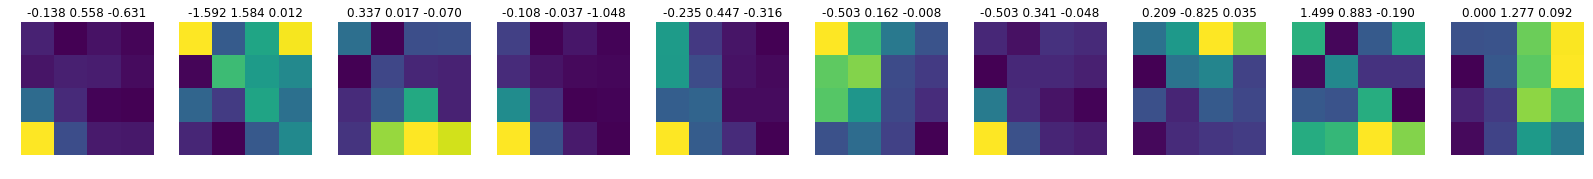

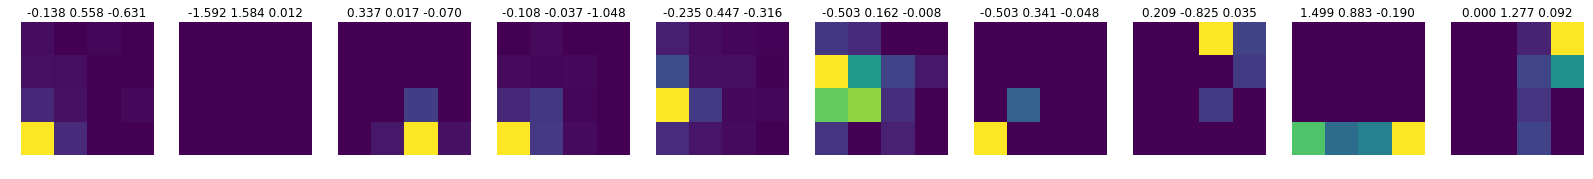

epoch: 12
a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-4.8822) tensor(0.0000, grad_fn=<SumBackward0>)


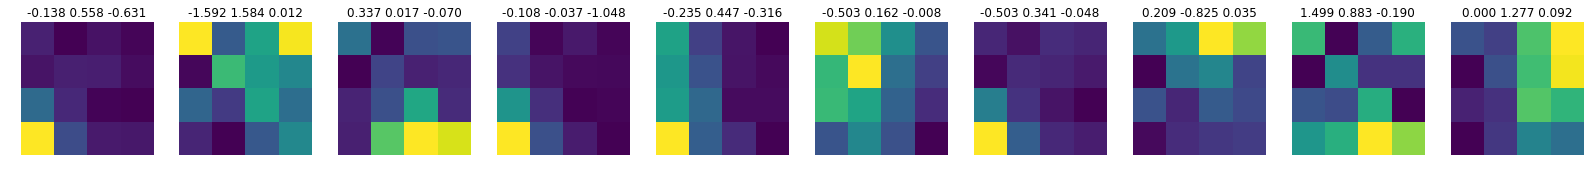

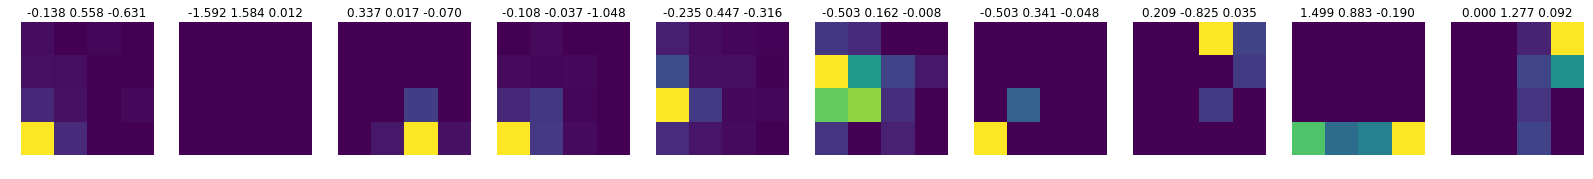

Train loss: -4.866572245333346 Batch 1500 of 500           a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-4.8645) tensor(1.2407e-06, grad_fn=<SumBackward0>)


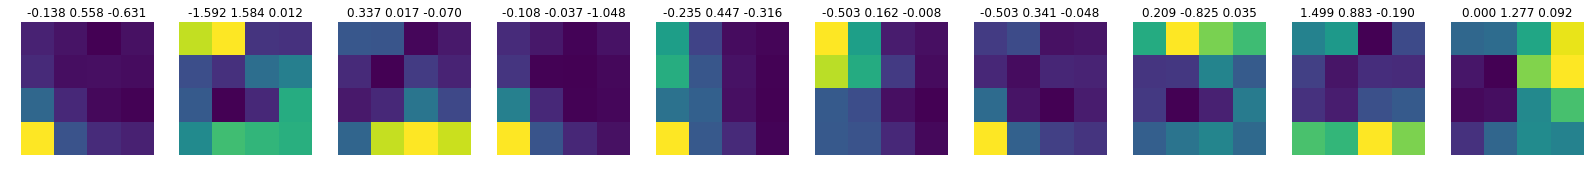

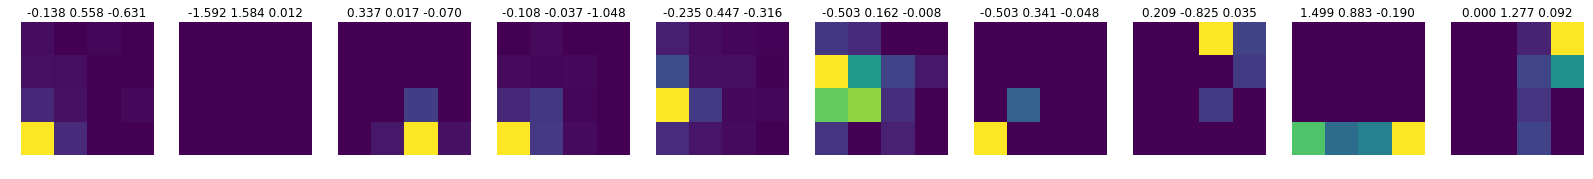

epoch: 13
a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-4.8604) tensor(1.2407e-06, grad_fn=<SumBackward0>)


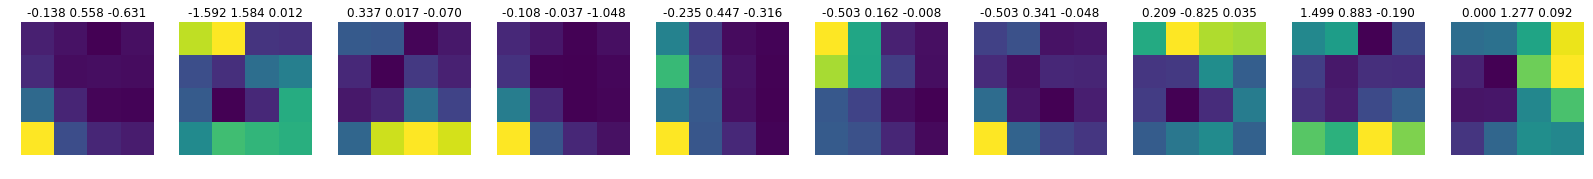

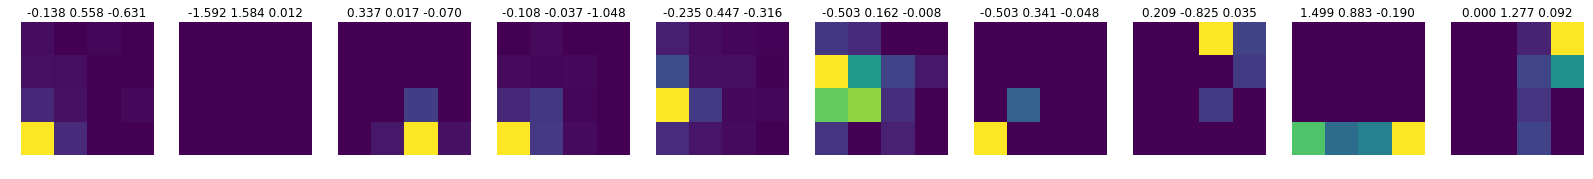

Train loss: -4.912716711291576 Batch 1500 of 500           a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-4.6887) tensor(5.7970e-06, grad_fn=<SumBackward0>)


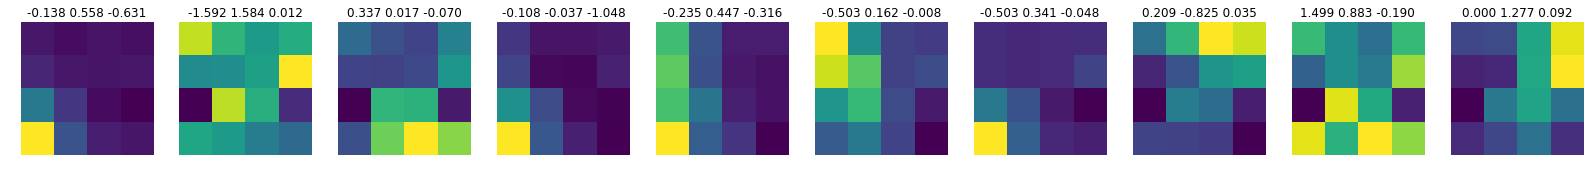

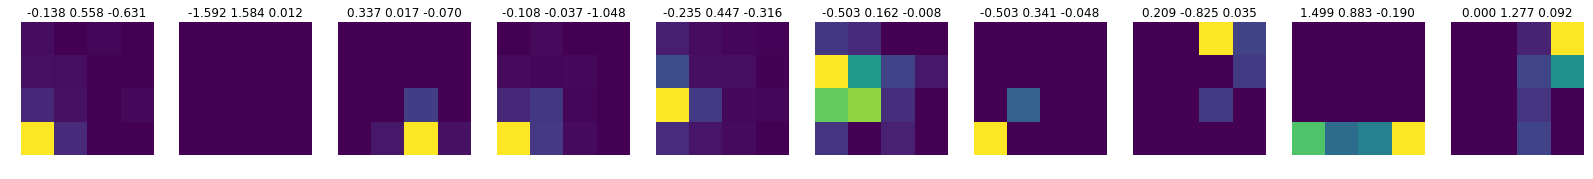

epoch: 14
a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-4.6871) tensor(5.7970e-06, grad_fn=<SumBackward0>)


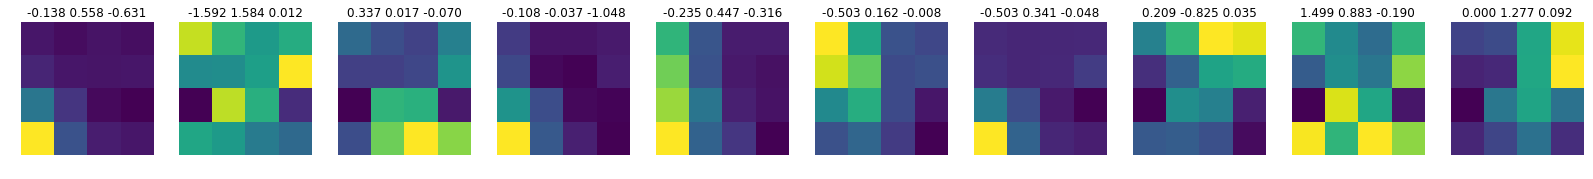

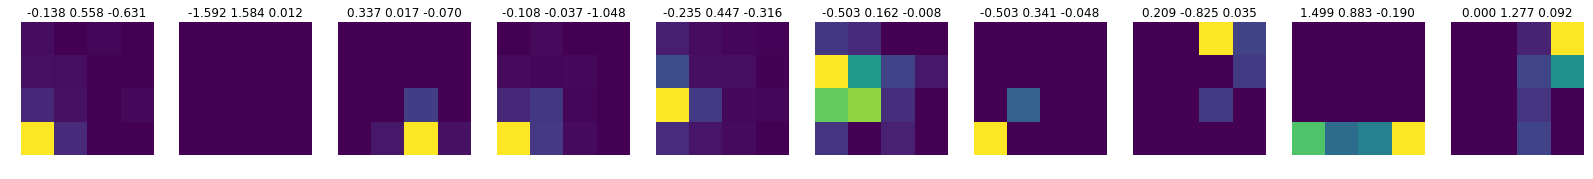

Train loss: -4.67955407476078 Batch 1500 of 500           a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-4.9476) tensor(7.7463e-06, grad_fn=<SumBackward0>)


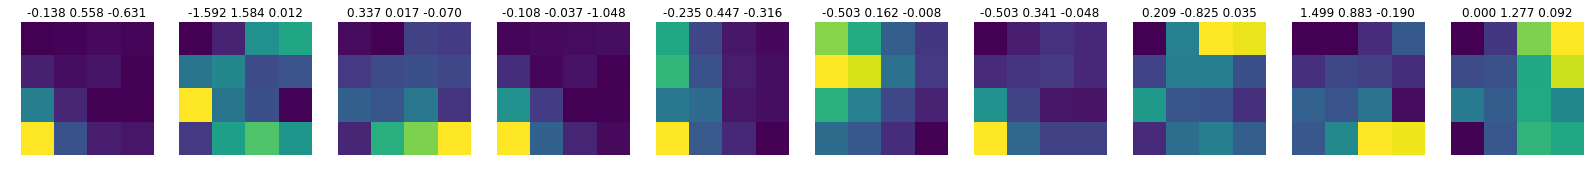

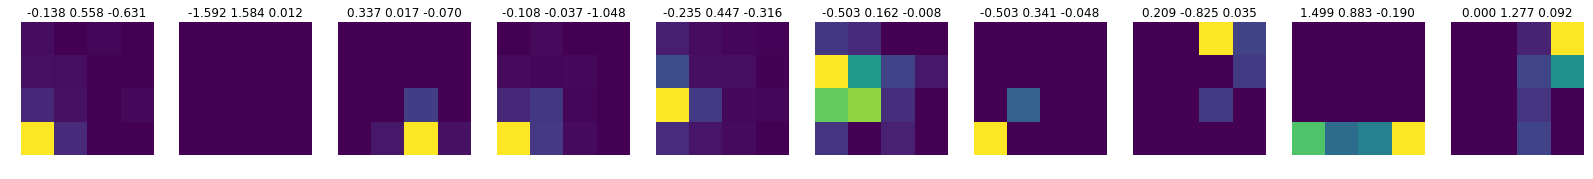

epoch: 15
a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-4.9688) tensor(7.7463e-06, grad_fn=<SumBackward0>)


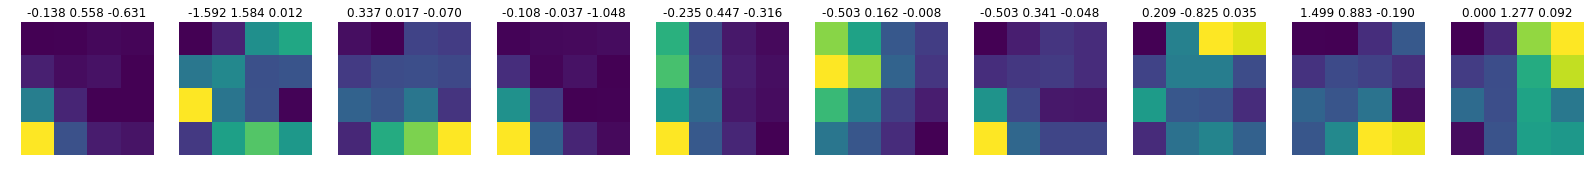

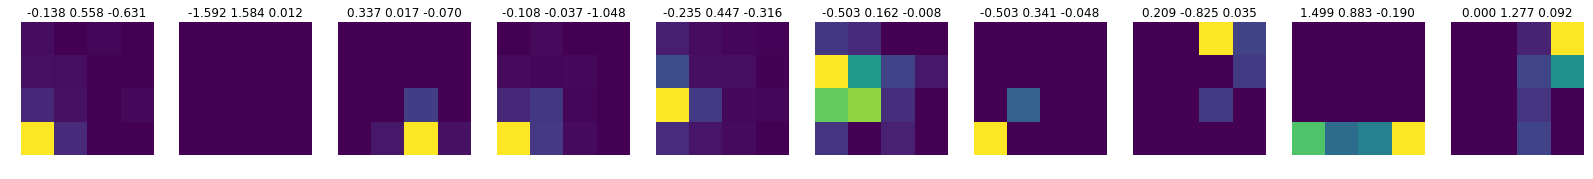

Train loss: -4.9124866221306345 Batch 1500 of 500           a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-4.9437) tensor(6.4637e-06, grad_fn=<SumBackward0>)


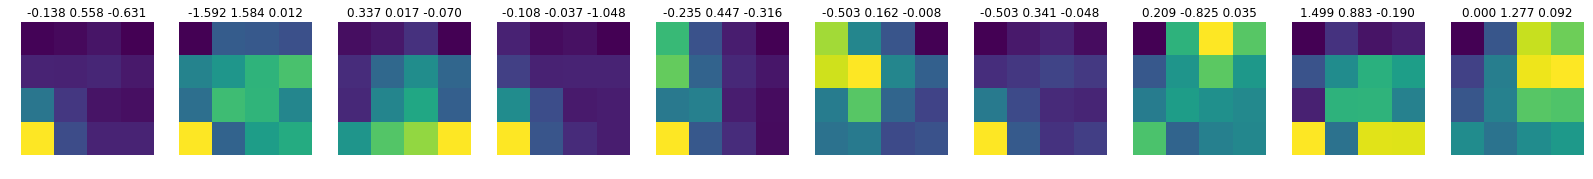

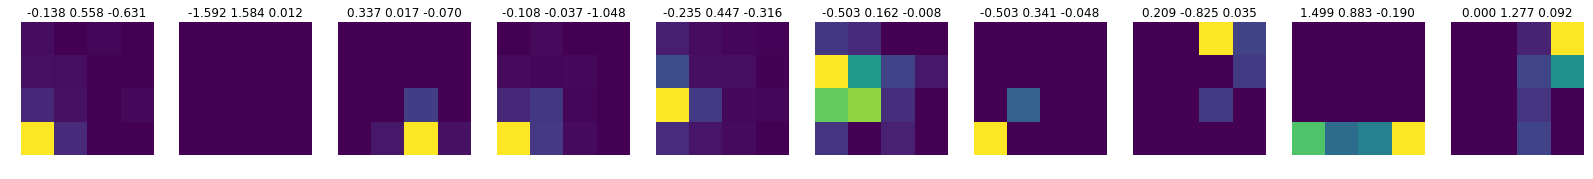

epoch: 16
a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-4.9378) tensor(6.4637e-06, grad_fn=<SumBackward0>)


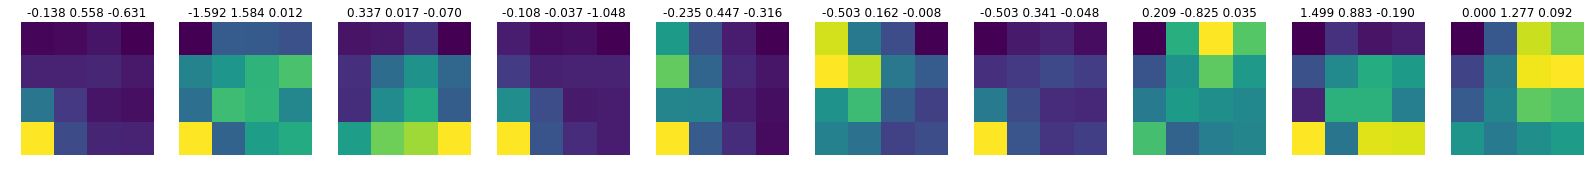

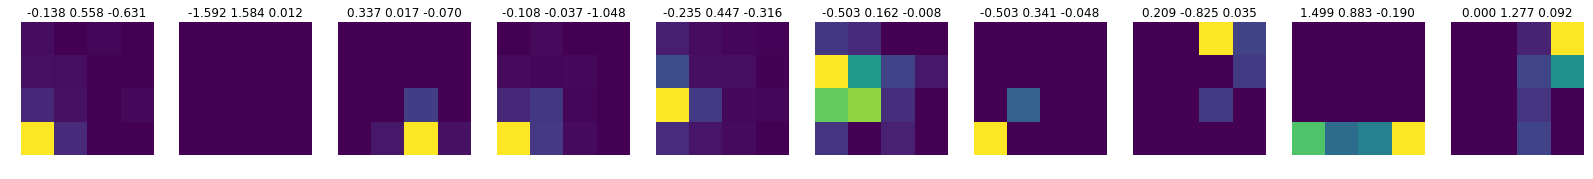

Train loss: -4.8315176356782725 Batch 1500 of 500           a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-4.8897) tensor(4.4123e-06, grad_fn=<SumBackward0>)


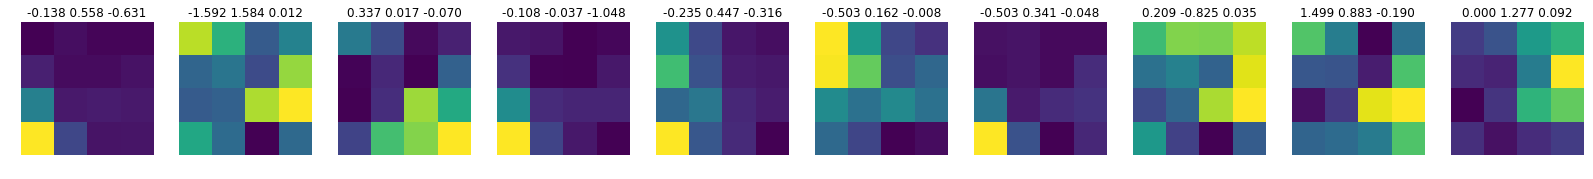

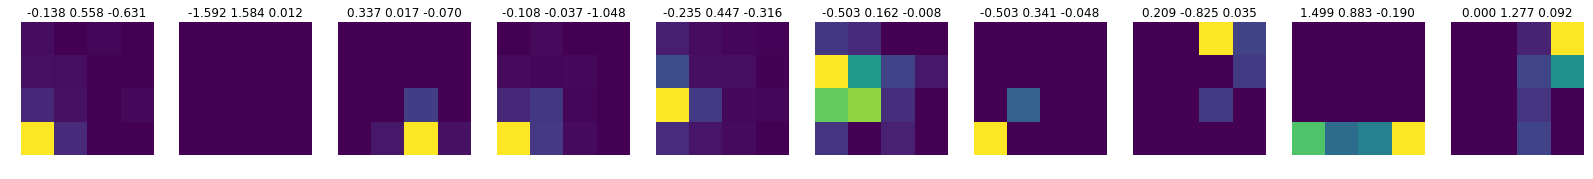

epoch: 17
a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-4.8873) tensor(4.4123e-06, grad_fn=<SumBackward0>)


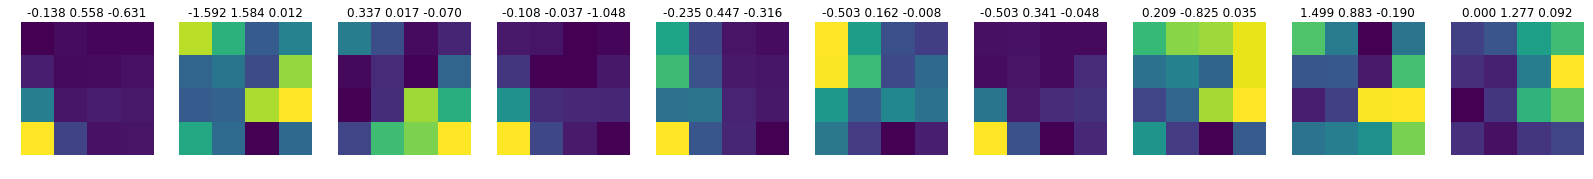

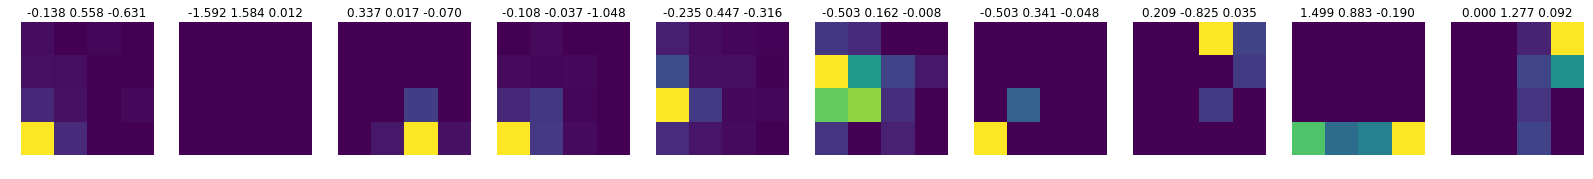

Train loss: -5.054083939353215 Batch 1500 of 500           a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-4.7376) tensor(4.3863e-06, grad_fn=<SumBackward0>)


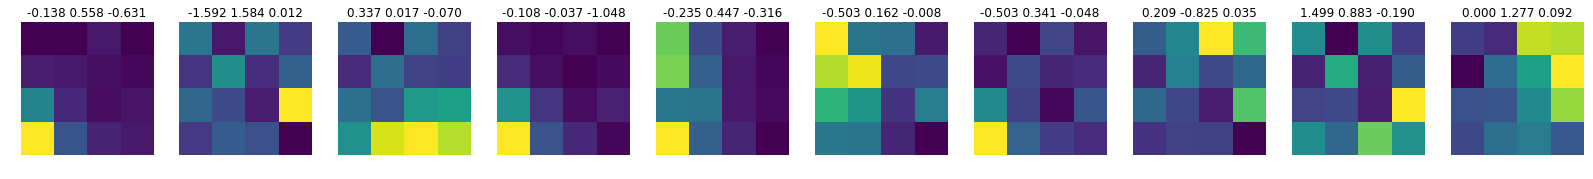

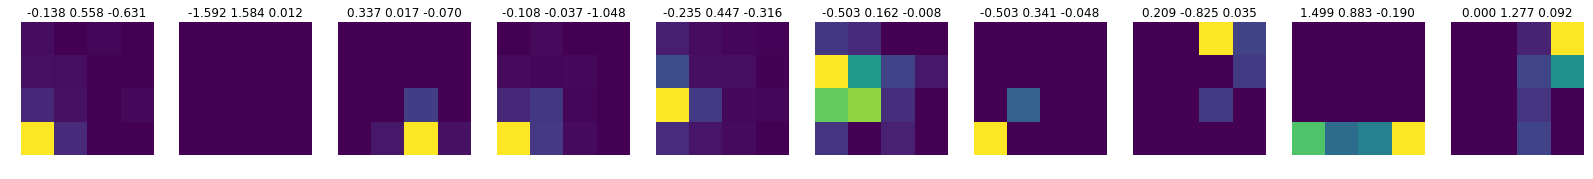

epoch: 18
a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-4.7369) tensor(4.3863e-06, grad_fn=<SumBackward0>)


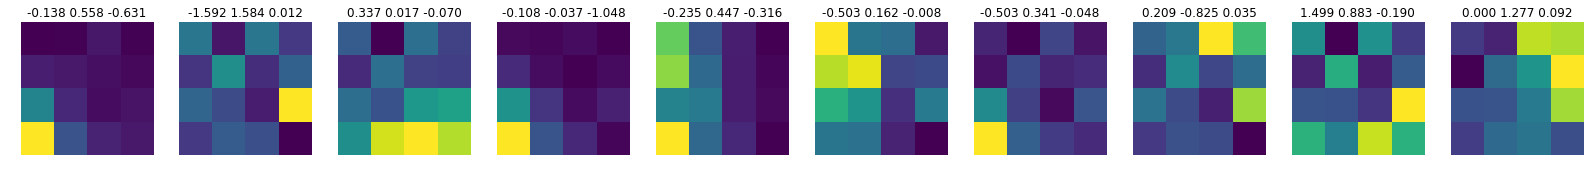

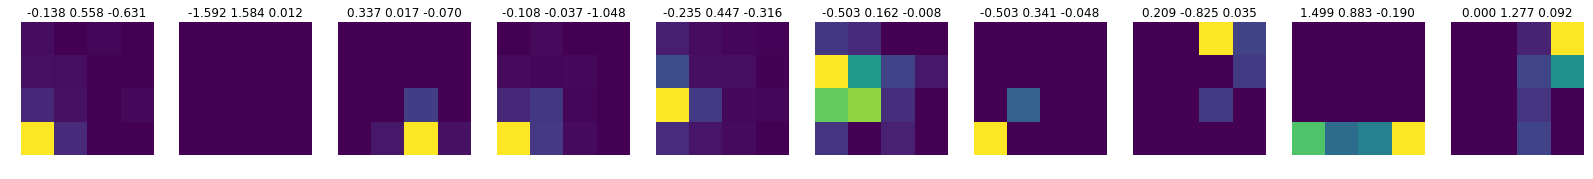

Train loss: -4.881782665015011 Batch 1500 of 500           a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-4.9820) tensor(3.3272e-06, grad_fn=<SumBackward0>)


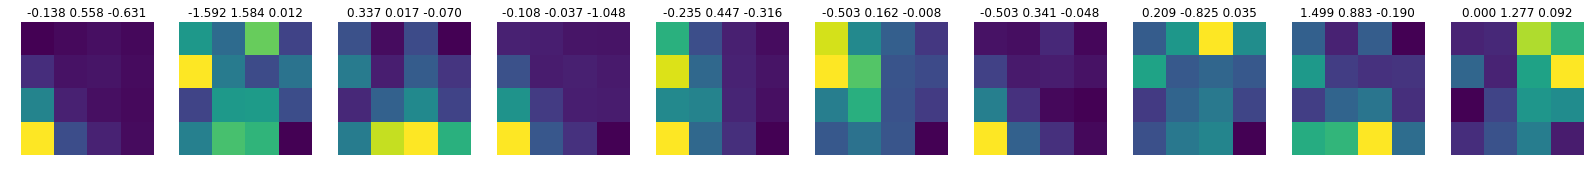

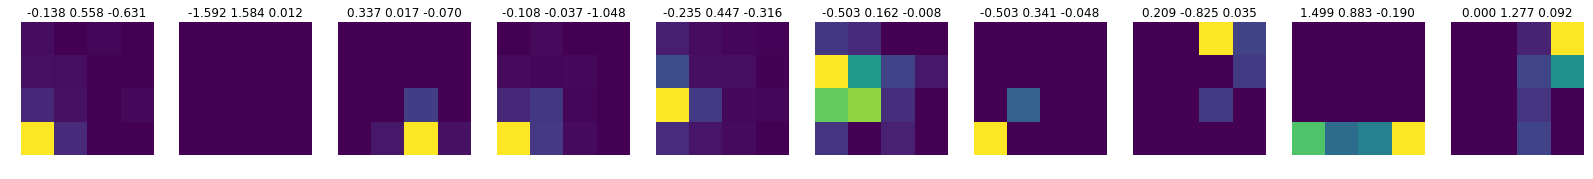

epoch: 19
a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-4.9841) tensor(3.3272e-06, grad_fn=<SumBackward0>)


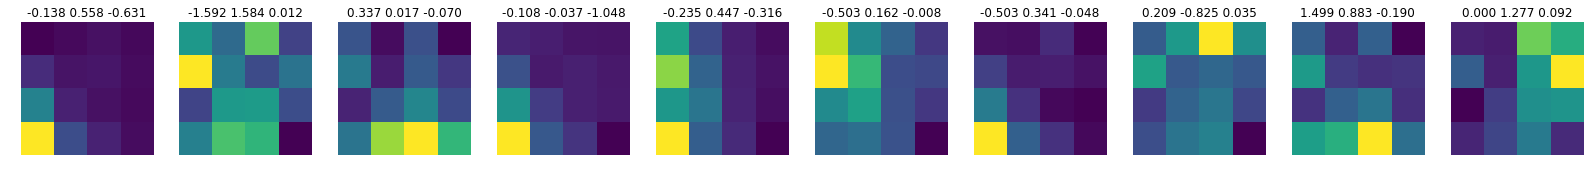

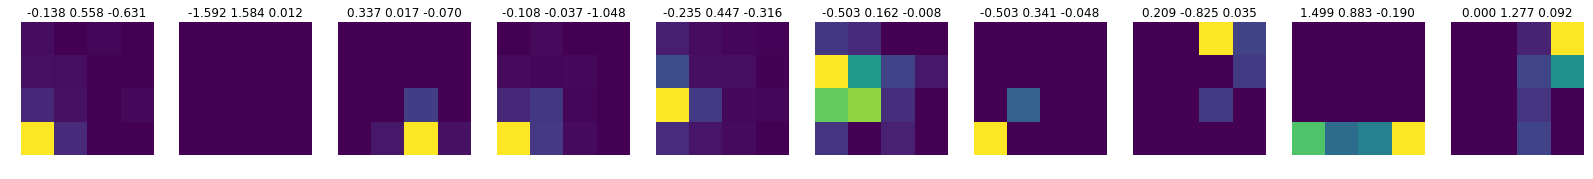

Train loss: -4.83759846872566 Batch 1500 of 500           a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-4.8112) tensor(8.3897e-06, grad_fn=<SumBackward0>)


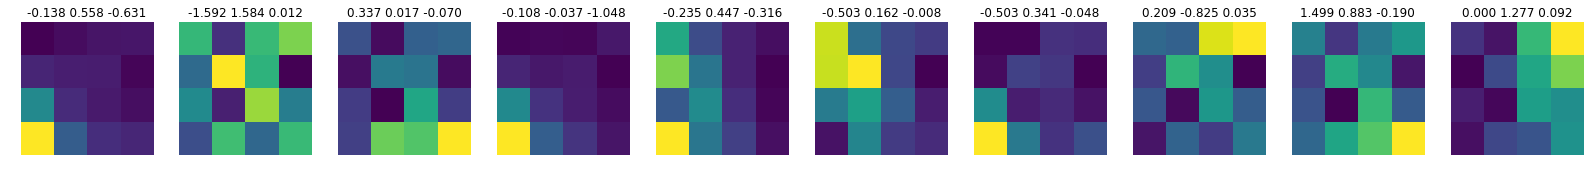

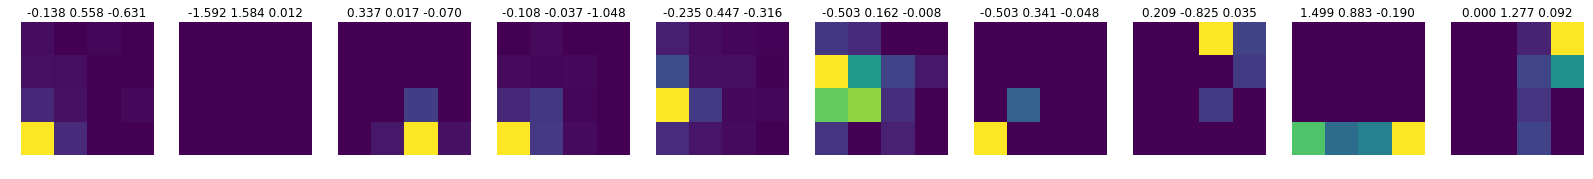

epoch: 20
a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-4.8127) tensor(8.3897e-06, grad_fn=<SumBackward0>)


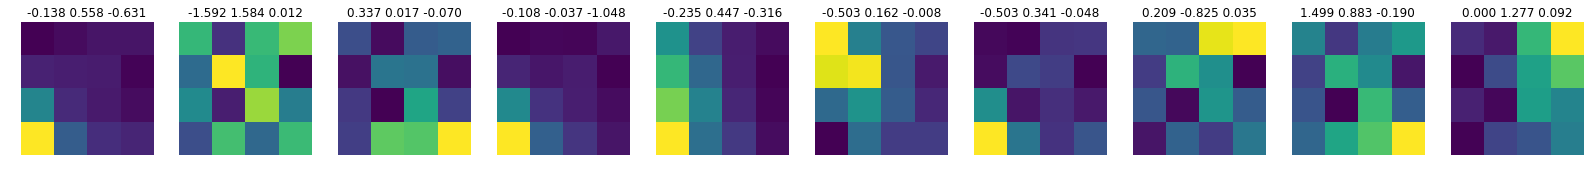

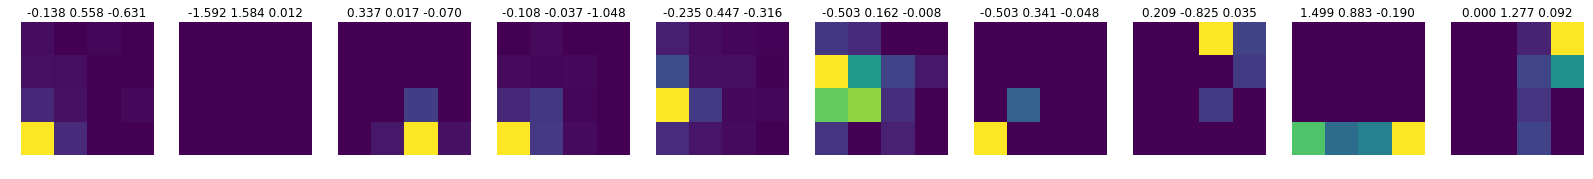

Train loss: -4.896872490761346 Batch 1500 of 500           a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-4.9104) tensor(0.0000, grad_fn=<SumBackward0>)


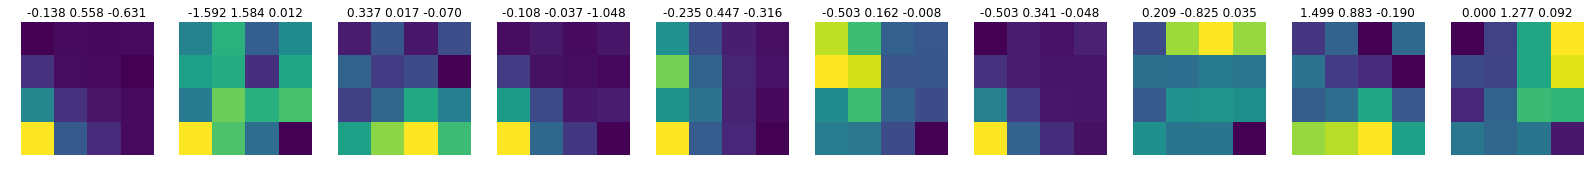

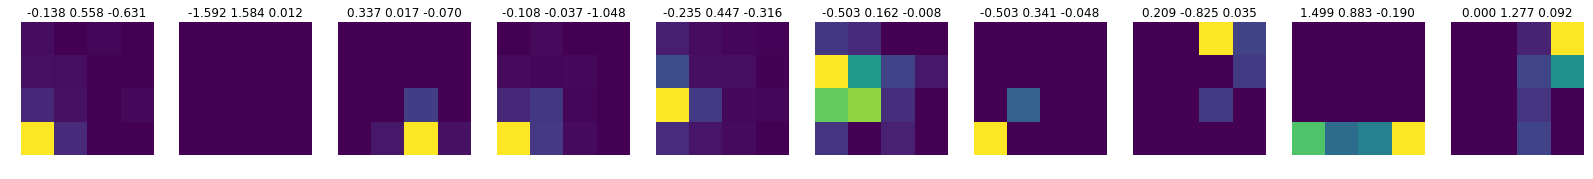

epoch: 21
a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-4.9053) tensor(0.0000, grad_fn=<SumBackward0>)


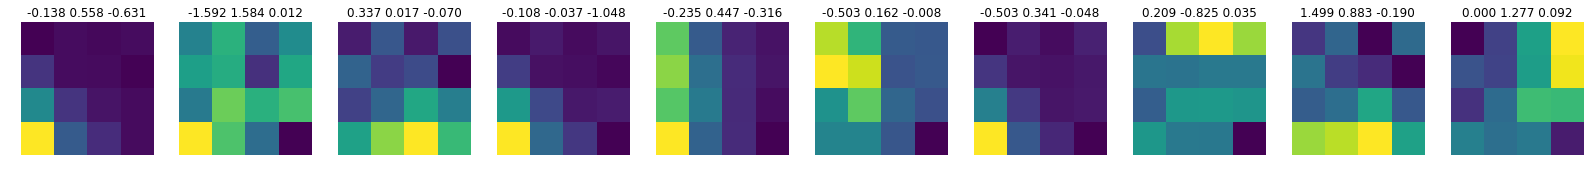

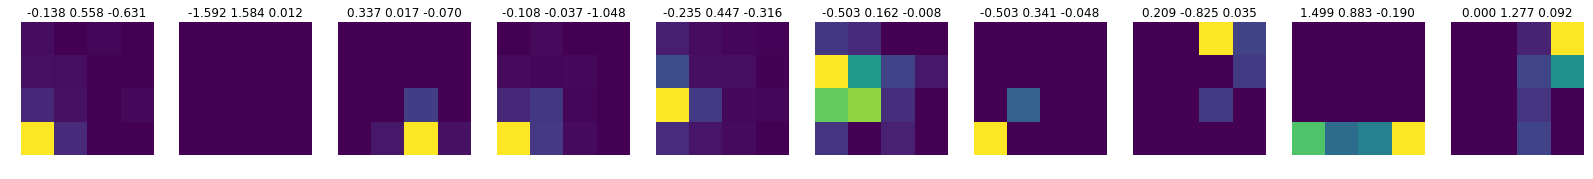

Train loss: -4.609839149985732 Batch 1500 of 500           a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-5.0712) tensor(0.0000, grad_fn=<SumBackward0>)


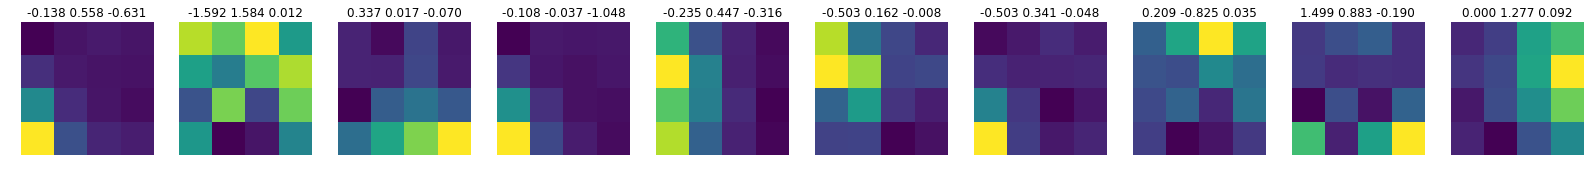

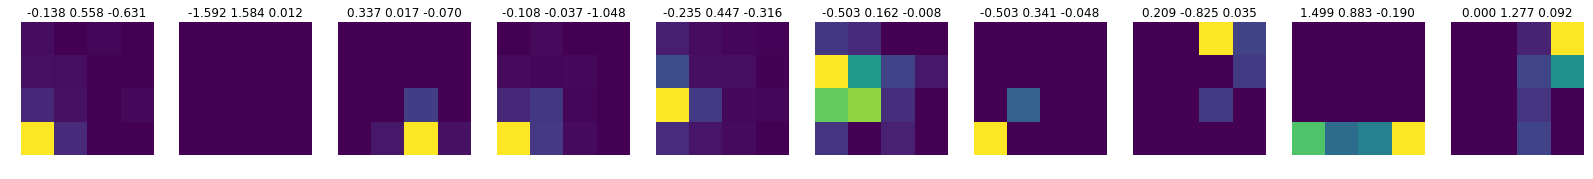

epoch: 22
a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-5.0791) tensor(0.0000, grad_fn=<SumBackward0>)


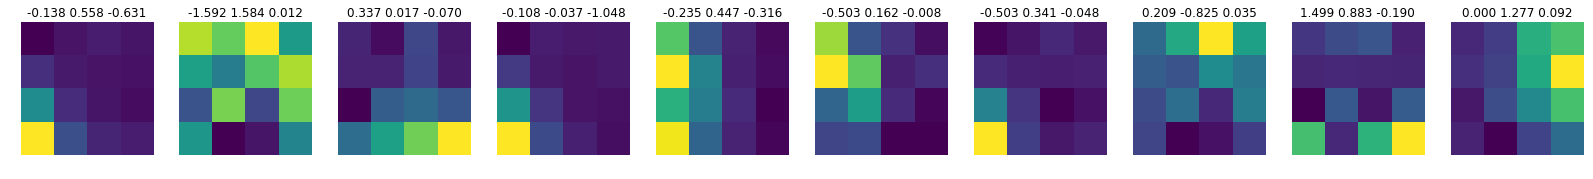

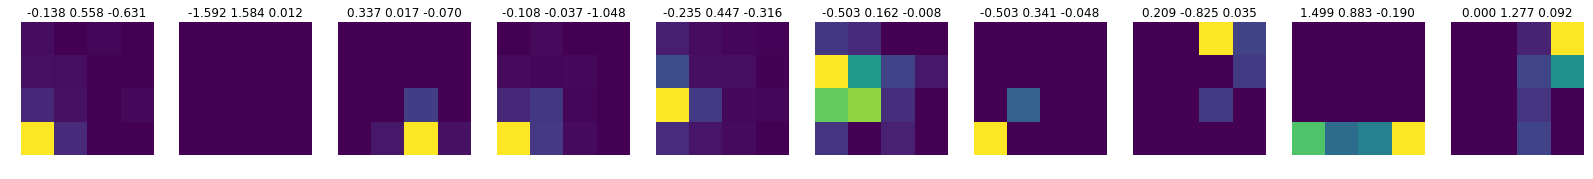

Train loss: -5.07133141400709 Batch 1500 of 500           a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-4.9838) tensor(4.5665e-06, grad_fn=<SumBackward0>)


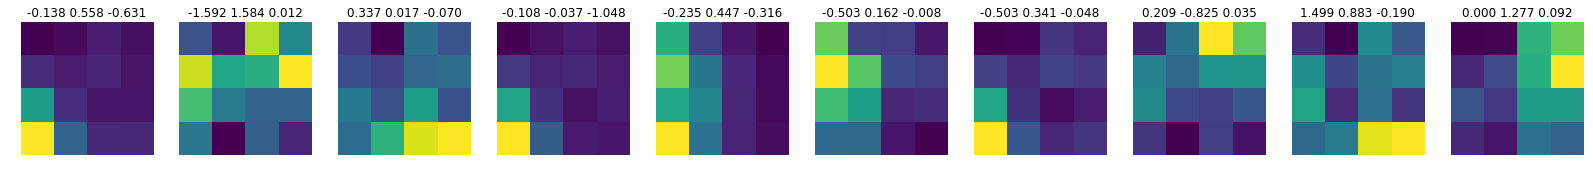

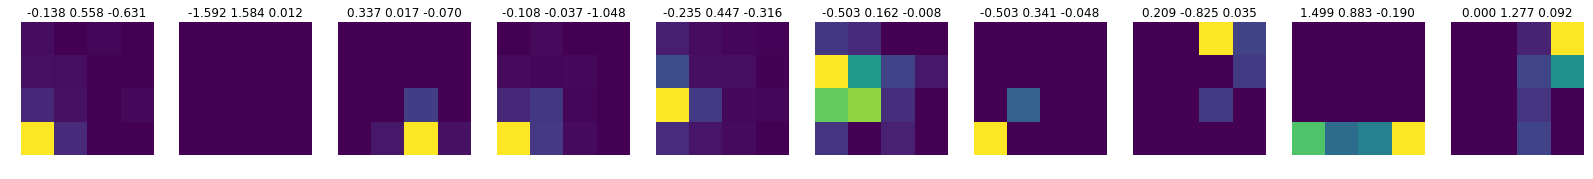

epoch: 23
a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-4.9789) tensor(4.5665e-06, grad_fn=<SumBackward0>)


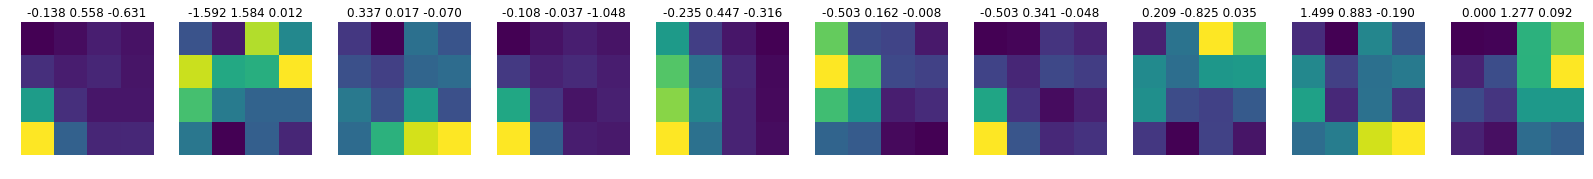

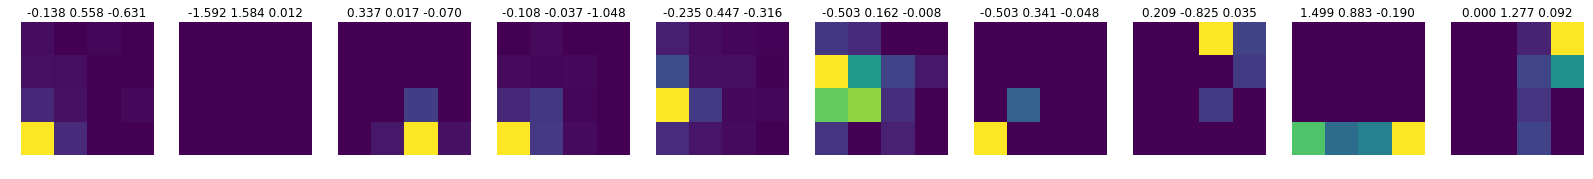

Train loss: -4.969470399662774 Batch 1500 of 500           a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-4.9832) tensor(2.9993e-06, grad_fn=<SumBackward0>)


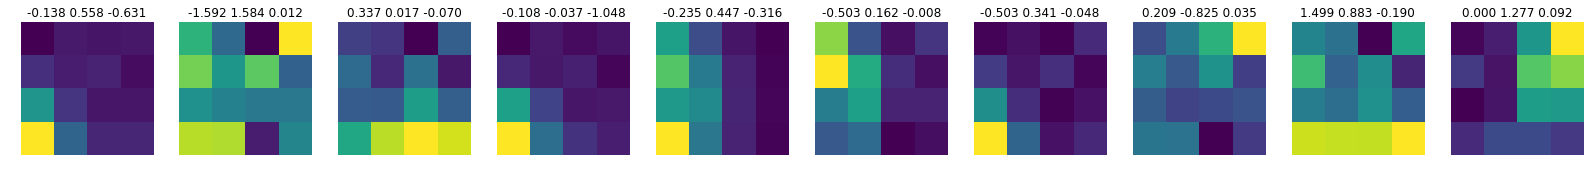

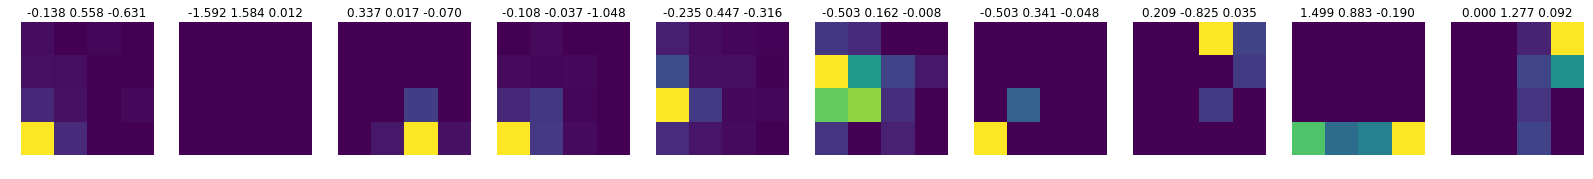

epoch: 24
a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-4.9897) tensor(2.9993e-06, grad_fn=<SumBackward0>)


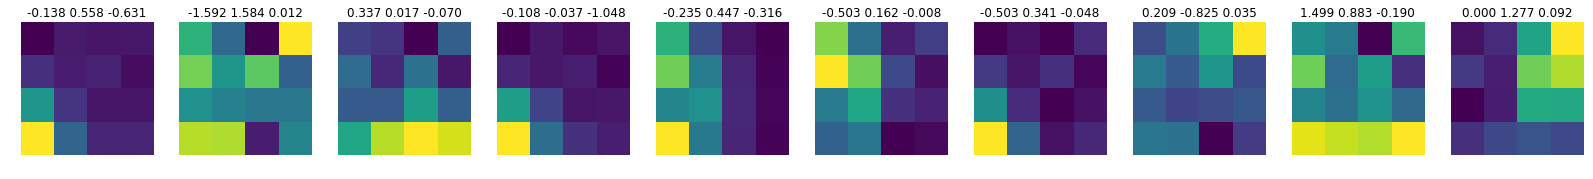

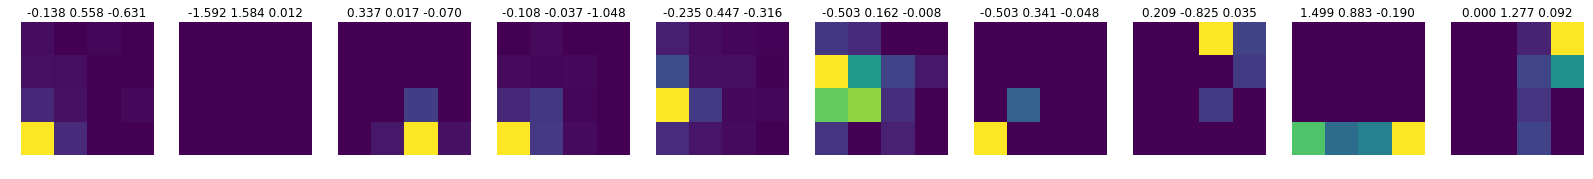

Train loss: -4.906666966724853 Batch 1500 of 500           a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-4.9528) tensor(0.0000, grad_fn=<SumBackward0>)


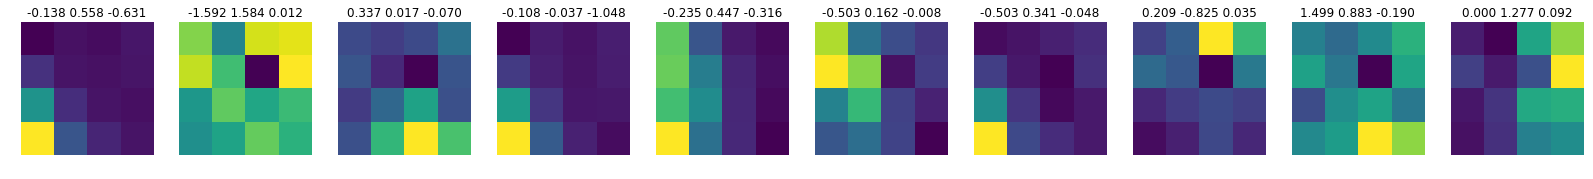

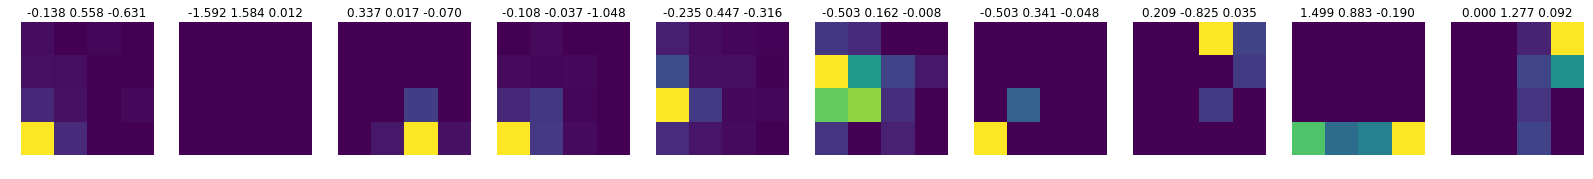

epoch: 25
a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-4.9614) tensor(0.0000, grad_fn=<SumBackward0>)


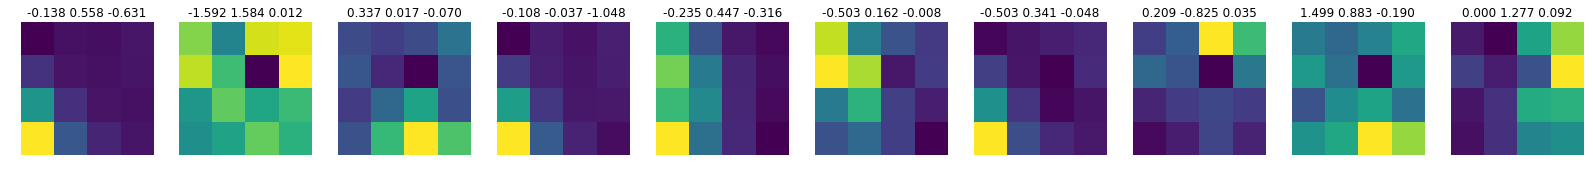

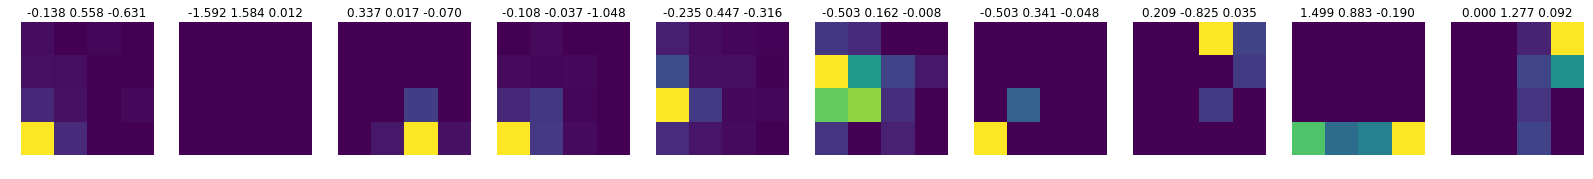

Train loss: -4.816756790335052 Batch 1500 of 500           a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-4.8524) tensor(5.4390e-06, grad_fn=<SumBackward0>)


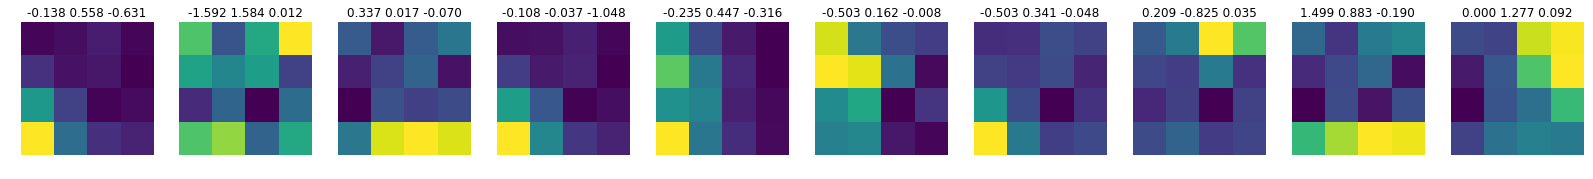

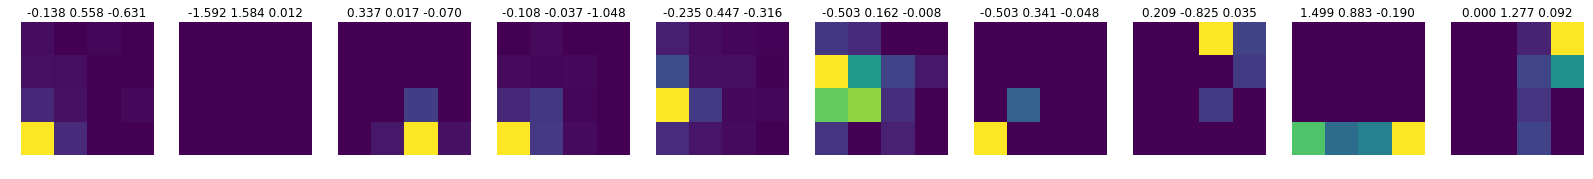

epoch: 26
a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-4.8395) tensor(5.4390e-06, grad_fn=<SumBackward0>)


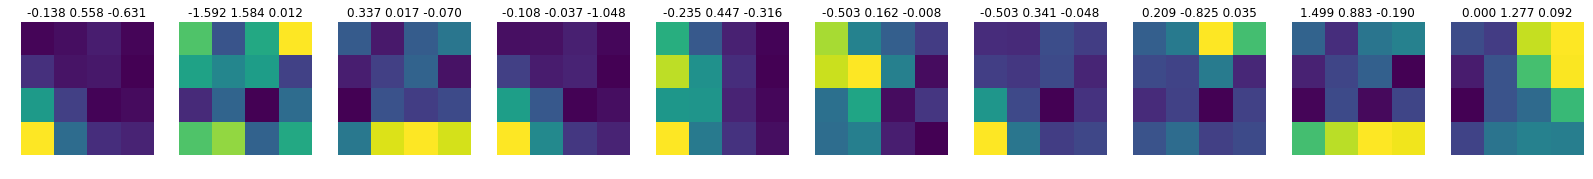

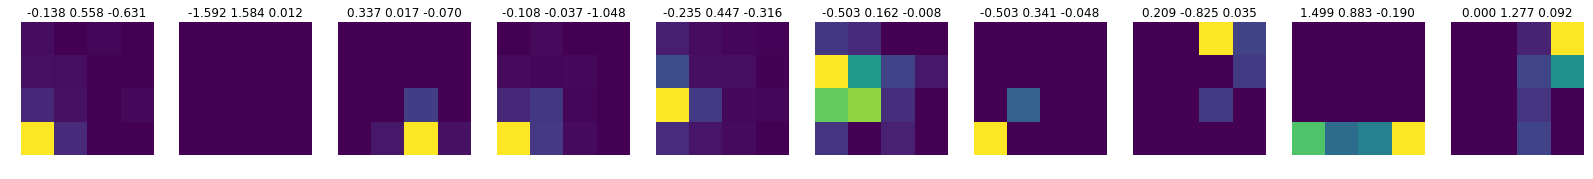

Train loss: -4.745187645716752 Batch 1500 of 500           a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-4.8937) tensor(1.8087e-06, grad_fn=<SumBackward0>)


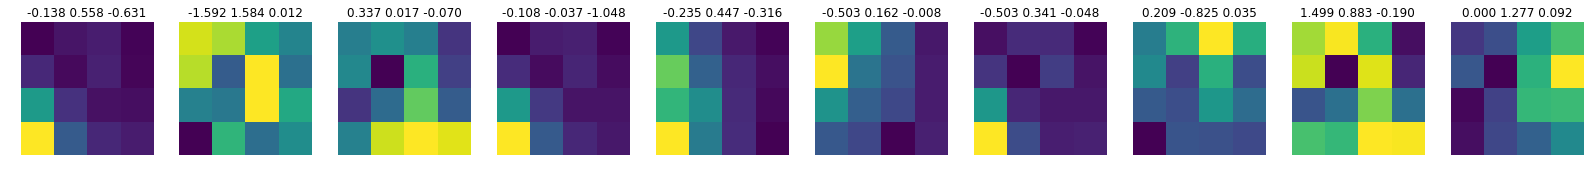

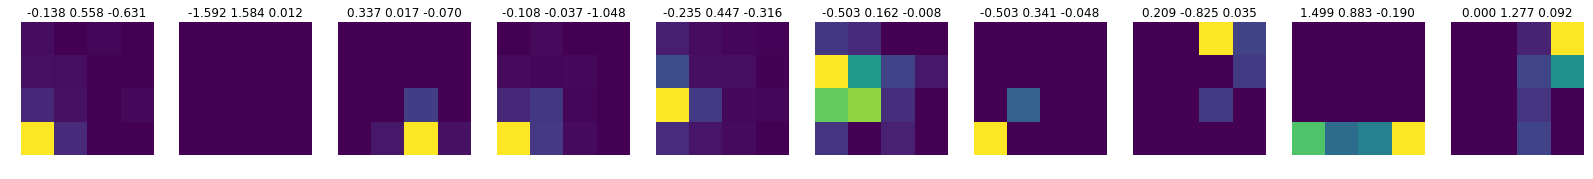

epoch: 27
a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-4.8977) tensor(1.8087e-06, grad_fn=<SumBackward0>)


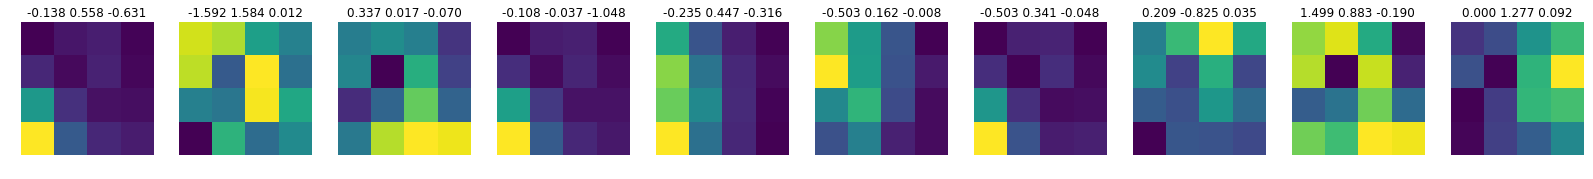

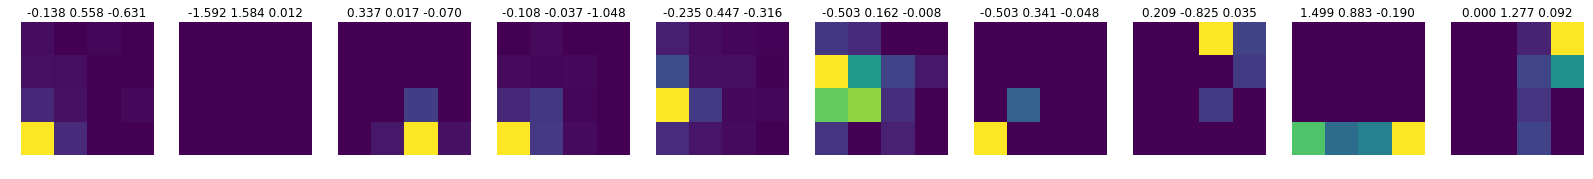

Train loss: -4.777889502742205 Batch 1500 of 500           a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-4.6274) tensor(3.0109e-06, grad_fn=<SumBackward0>)


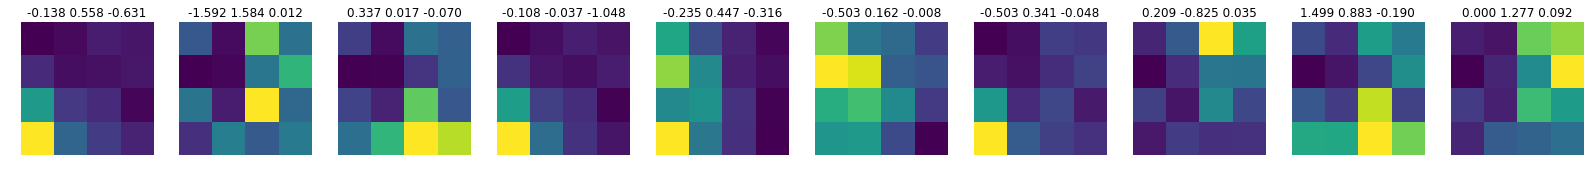

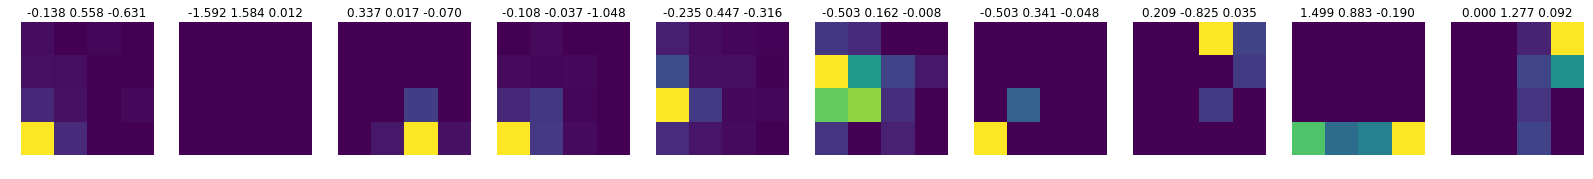

epoch: 28
a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-4.6229) tensor(3.0109e-06, grad_fn=<SumBackward0>)


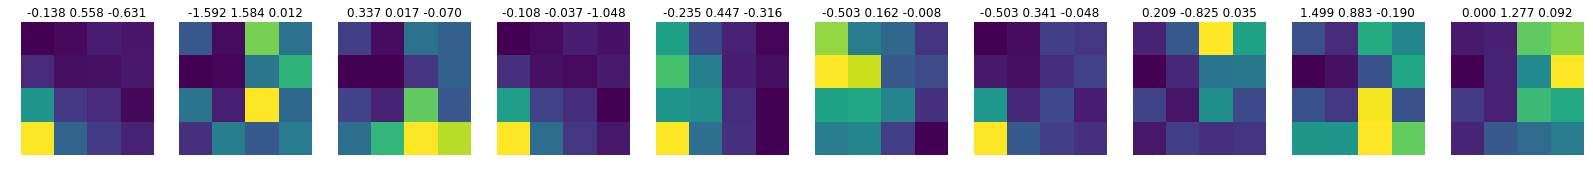

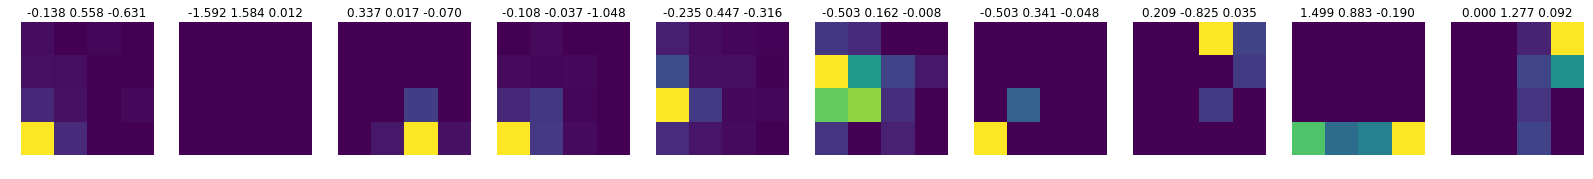

Train loss: -4.643533288813567 Batch 1500 of 500           a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-4.8668) tensor(0.0000, grad_fn=<SumBackward0>)


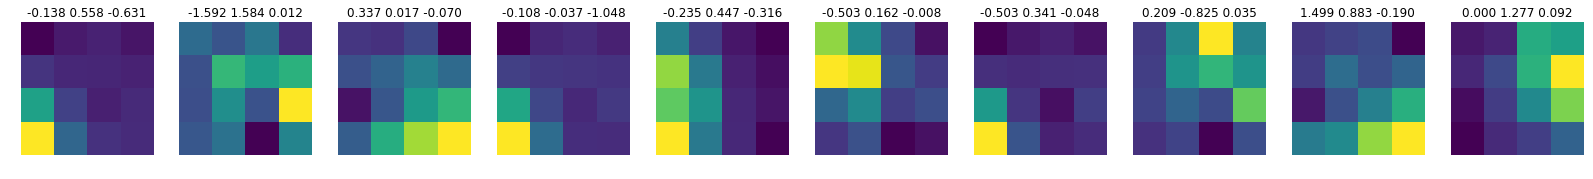

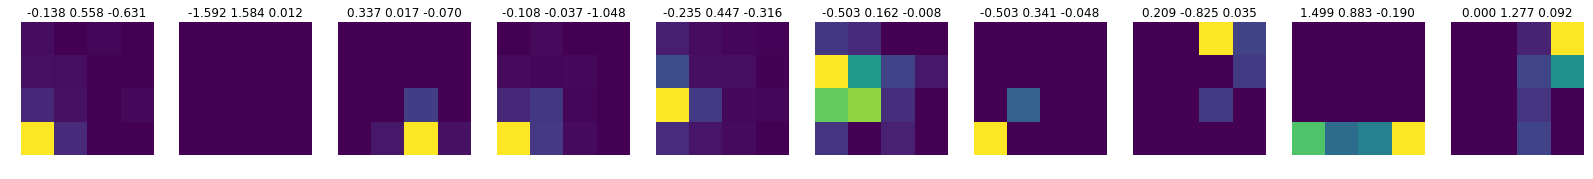

epoch: 29
a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-4.8948) tensor(0.0000, grad_fn=<SumBackward0>)


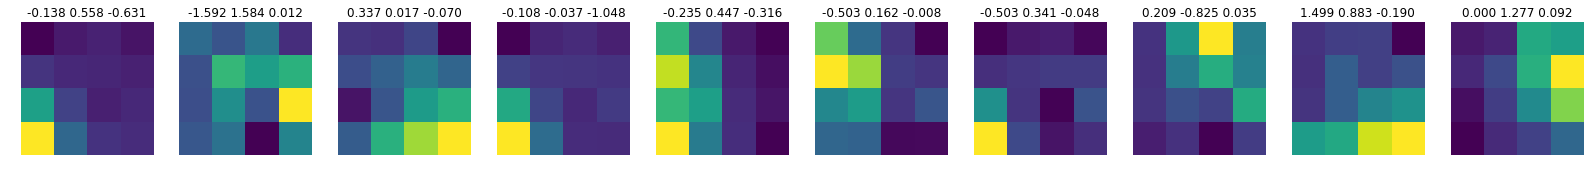

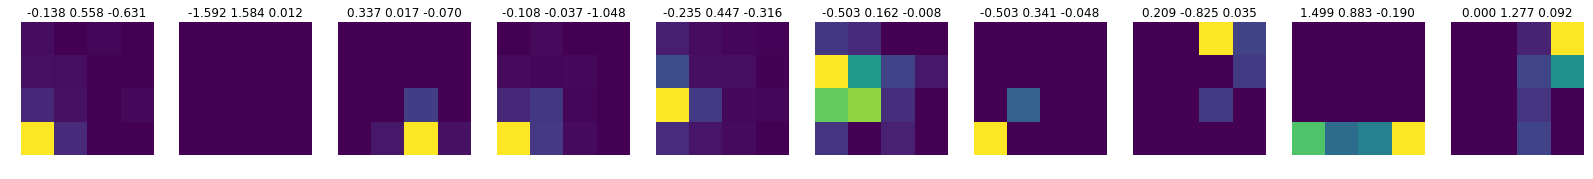

Train loss: -4.898364905747492 Batch 1500 of 500           a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-5.0379) tensor(7.0234e-06, grad_fn=<SumBackward0>)


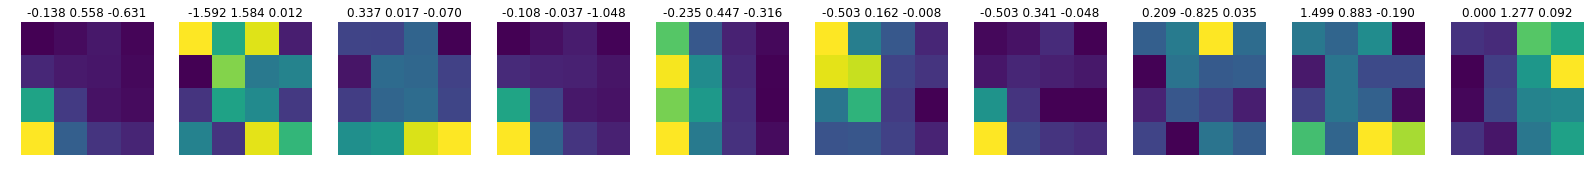

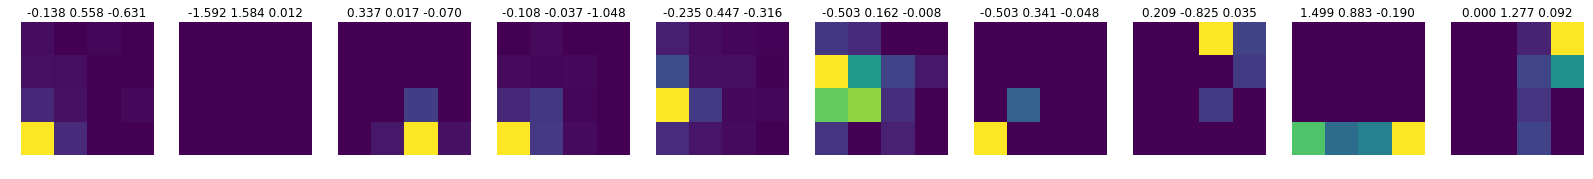

epoch: 30
a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-5.0451) tensor(7.0234e-06, grad_fn=<SumBackward0>)


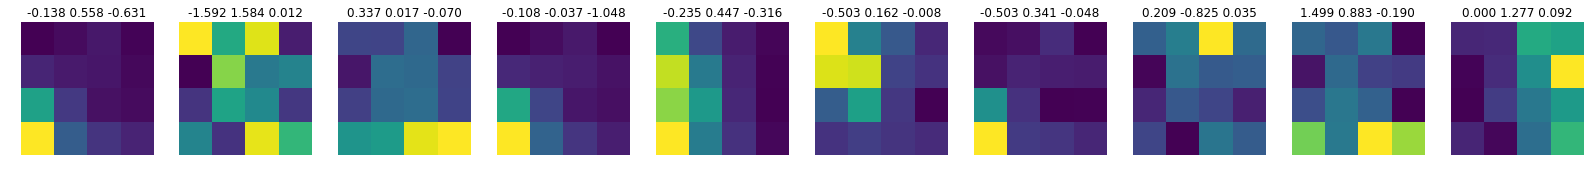

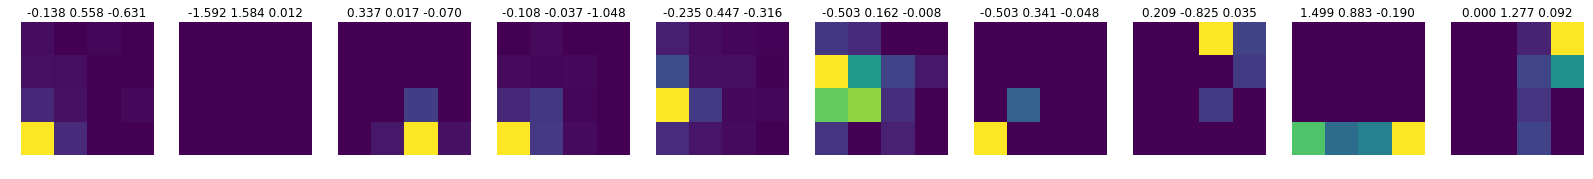

Train loss: -4.841218018098258 Batch 1500 of 500           a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-4.9524) tensor(5.1059e-06, grad_fn=<SumBackward0>)


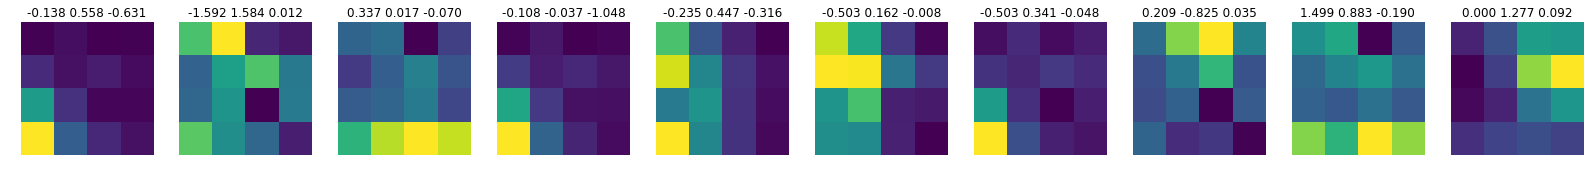

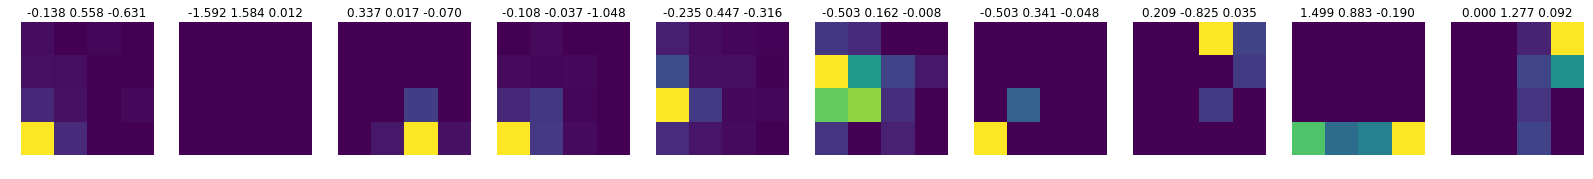

epoch: 31
a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-4.9719) tensor(5.1059e-06, grad_fn=<SumBackward0>)


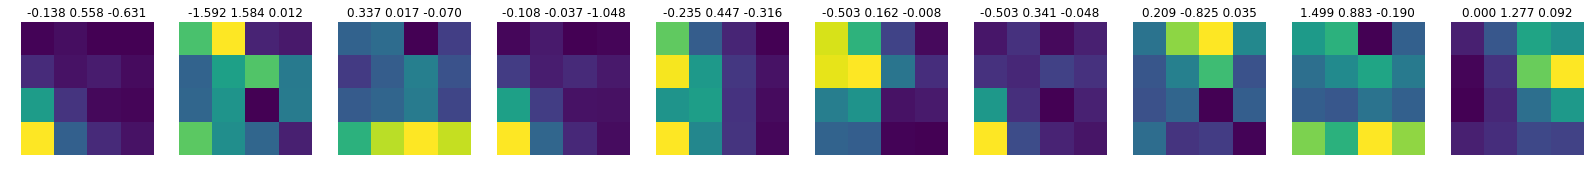

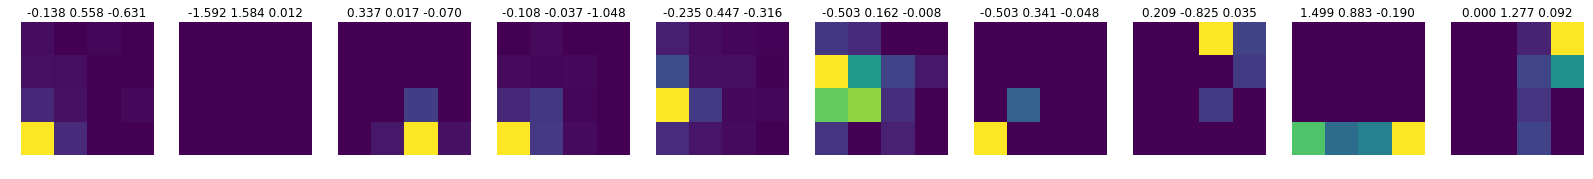

Train loss: -4.902416128921269 Batch 1500 of 500           a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-4.7137) tensor(4.8681e-06, grad_fn=<SumBackward0>)


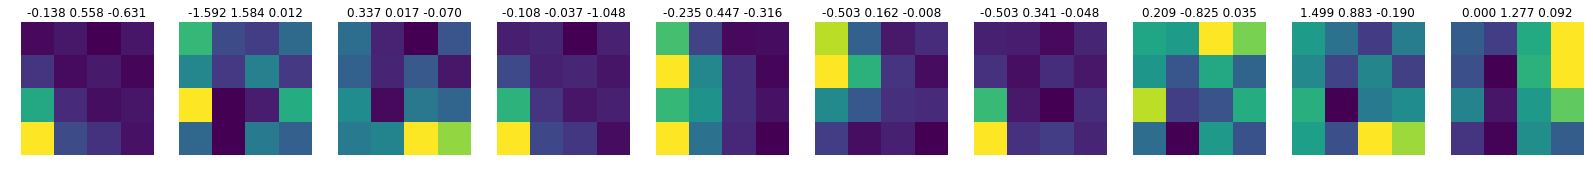

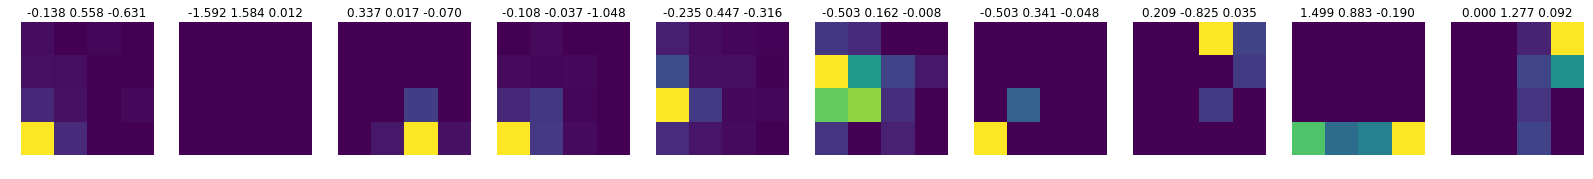

epoch: 32
a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-4.7203) tensor(4.8681e-06, grad_fn=<SumBackward0>)


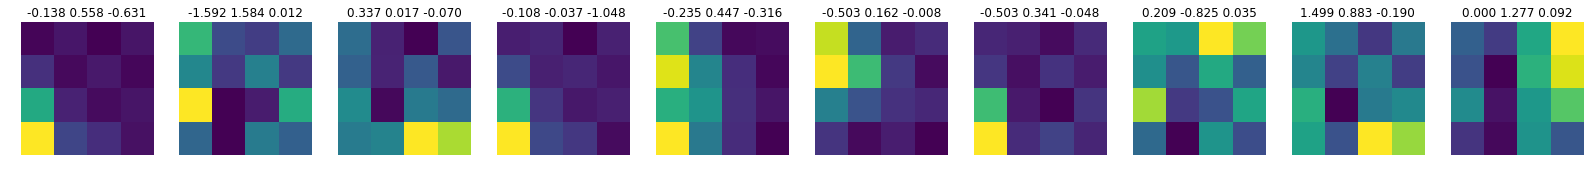

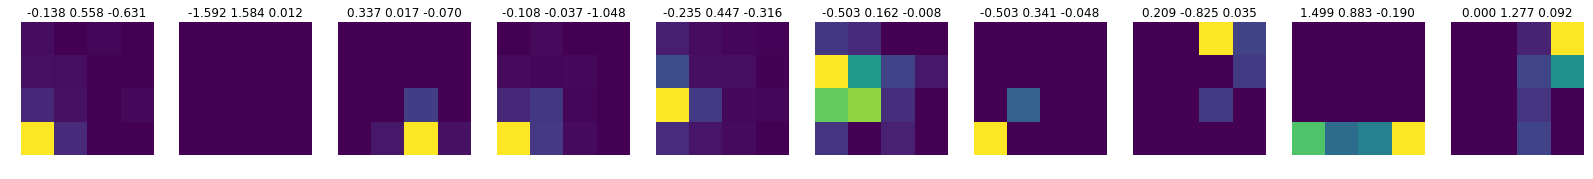

Train loss: -4.773307421387234 Batch 1500 of 500           a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-4.7210) tensor(0.0000, grad_fn=<SumBackward0>)


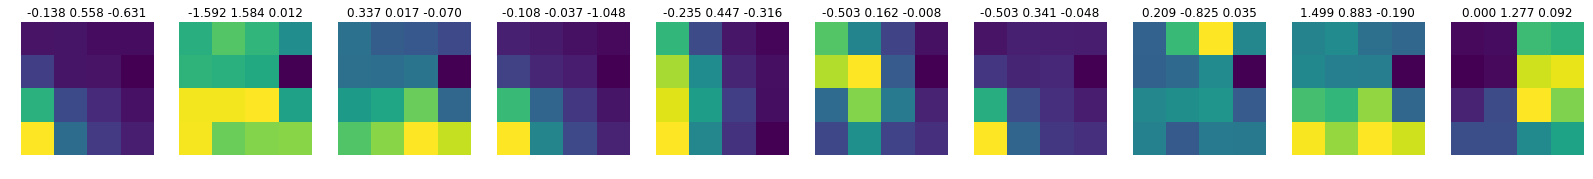

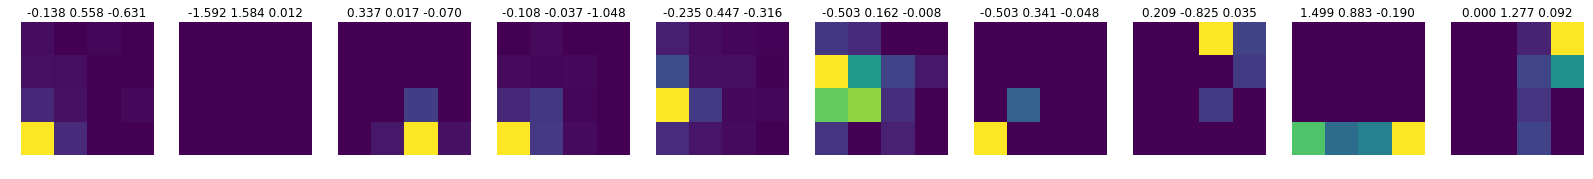

epoch: 33
a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-4.7265) tensor(0.0000, grad_fn=<SumBackward0>)


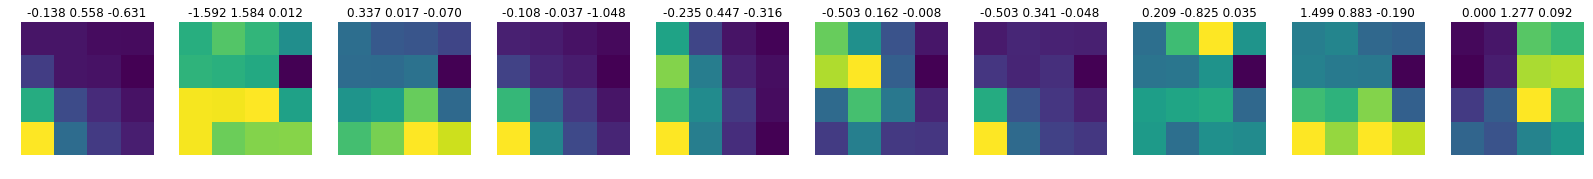

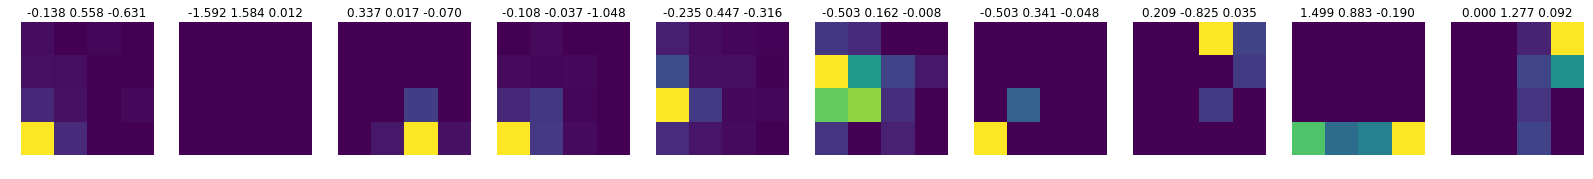

Train loss: -4.764590211477471 Batch 1500 of 500           a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-4.9226) tensor(0.0000, grad_fn=<SumBackward0>)


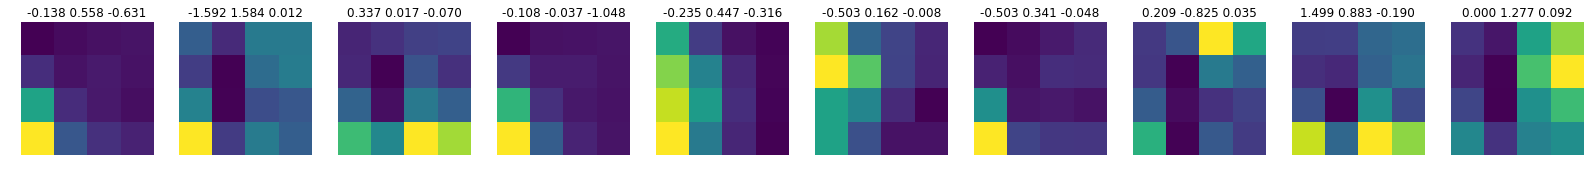

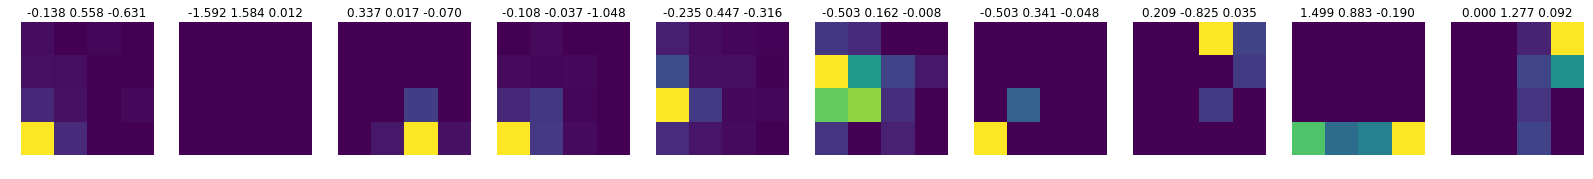

epoch: 34
a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-4.9204) tensor(0.0000, grad_fn=<SumBackward0>)


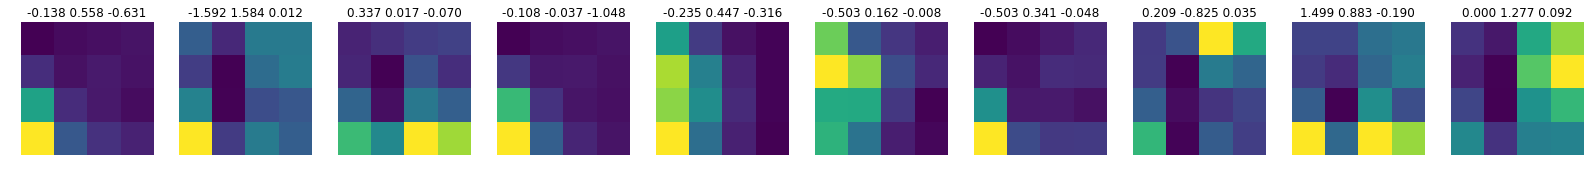

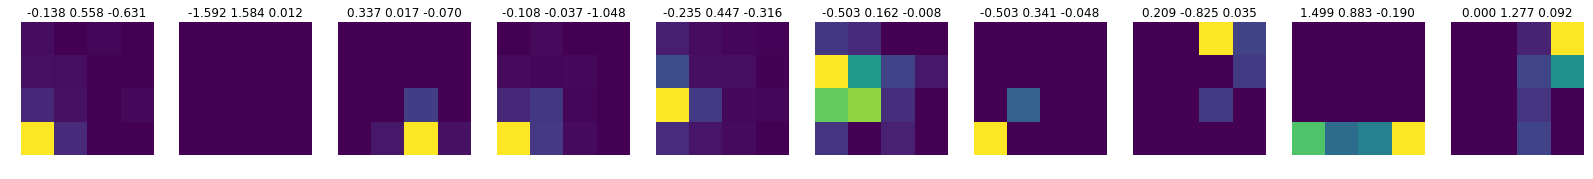

Train loss: -4.9031009760886635 Batch 1500 of 500           a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-4.8050) tensor(4.7666e-06, grad_fn=<SumBackward0>)


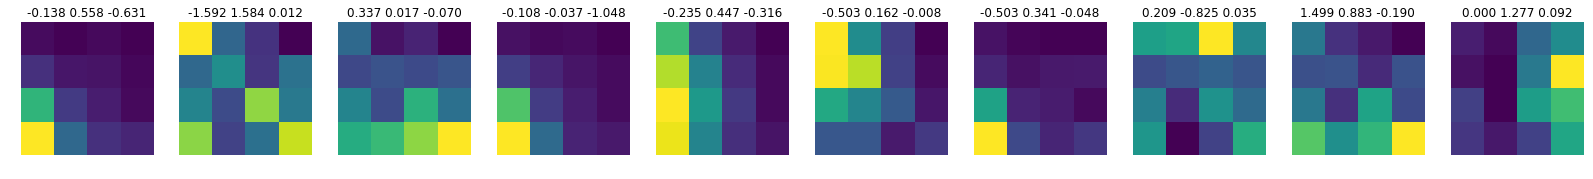

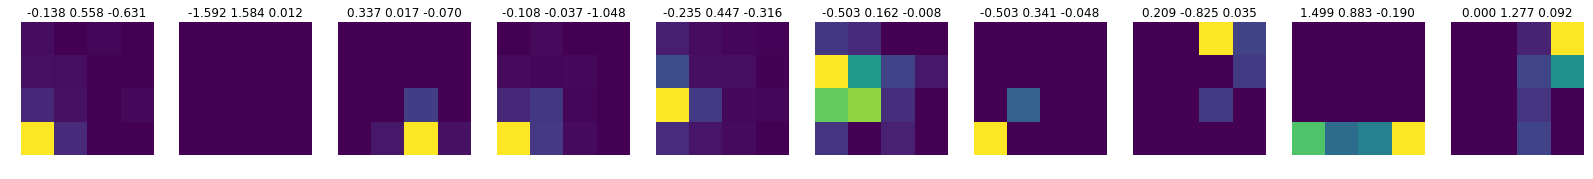

epoch: 35
a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-4.7914) tensor(4.7666e-06, grad_fn=<SumBackward0>)


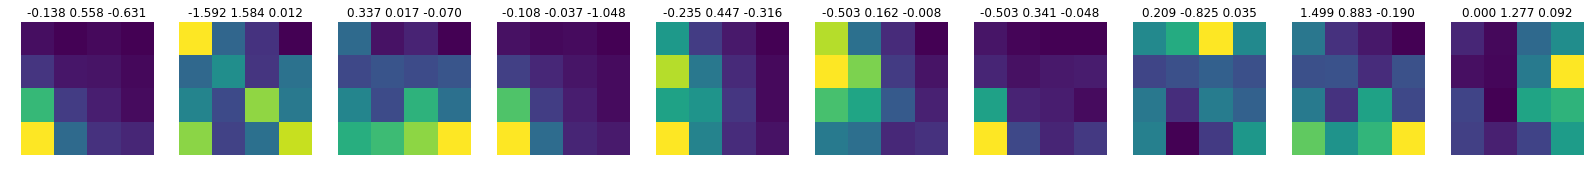

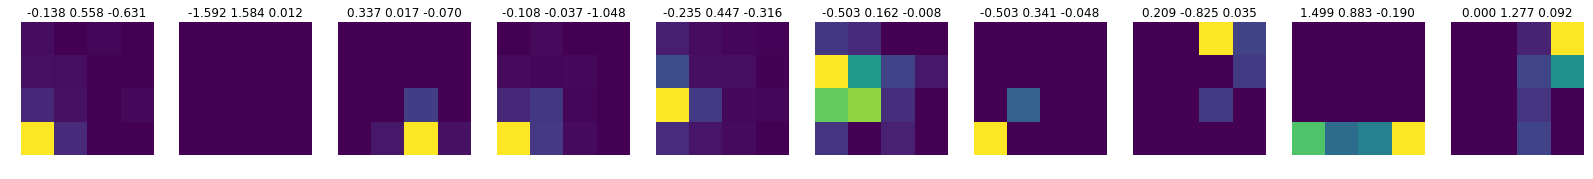

Train loss: -4.615312790586456 Batch 1500 of 500           a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-4.8418) tensor(6.3078e-06, grad_fn=<SumBackward0>)


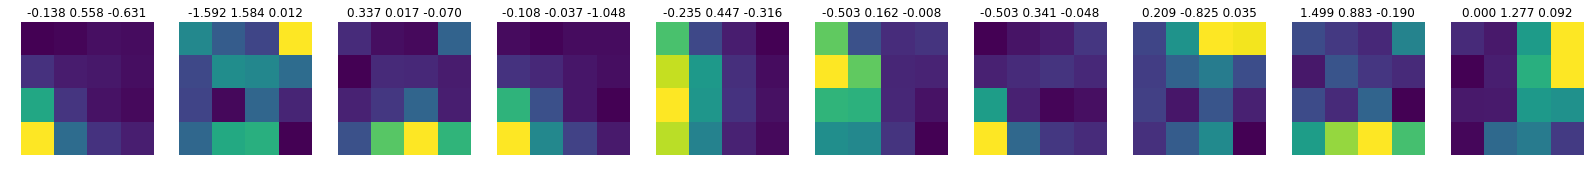

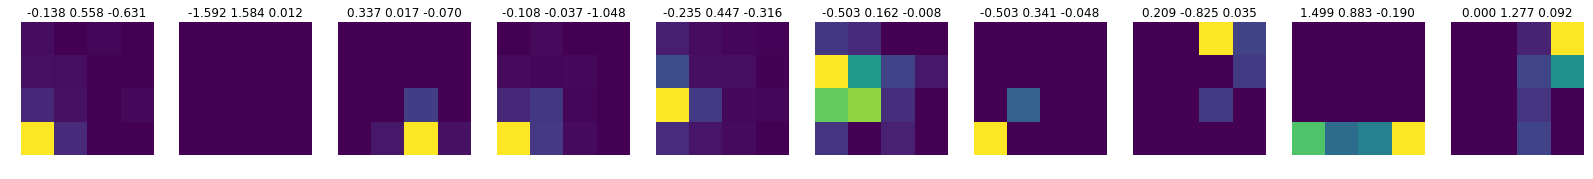

epoch: 36
a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-4.8340) tensor(6.3078e-06, grad_fn=<SumBackward0>)


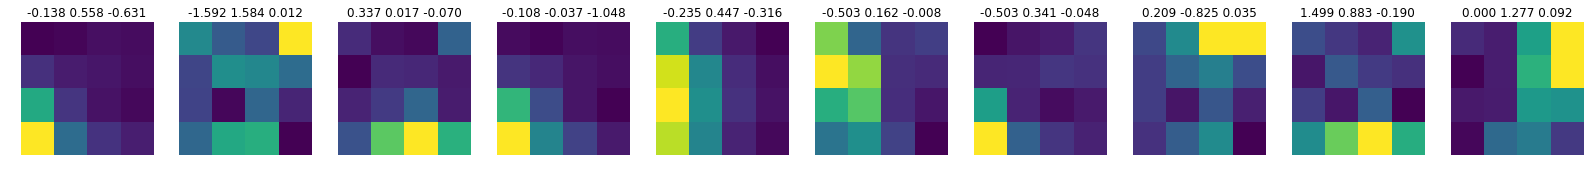

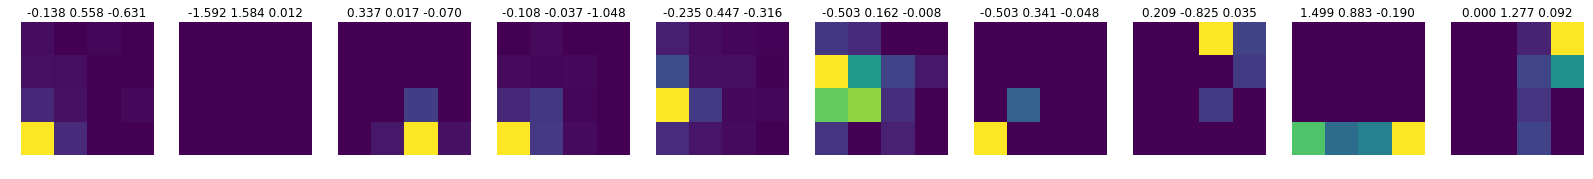

Train loss: -4.745074725940164 Batch 1500 of 500           a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-4.7872) tensor(0.0000, grad_fn=<SumBackward0>)


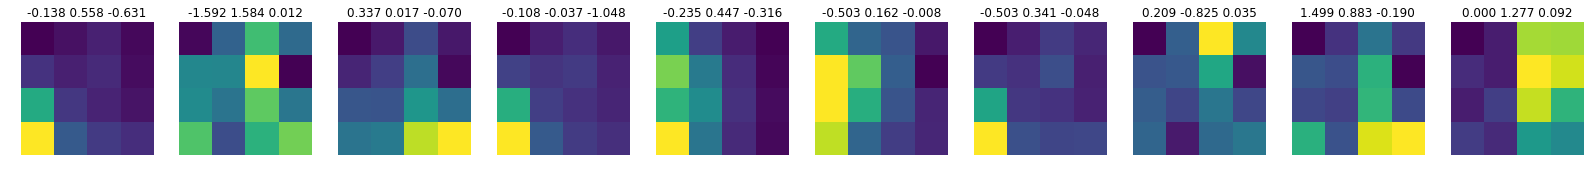

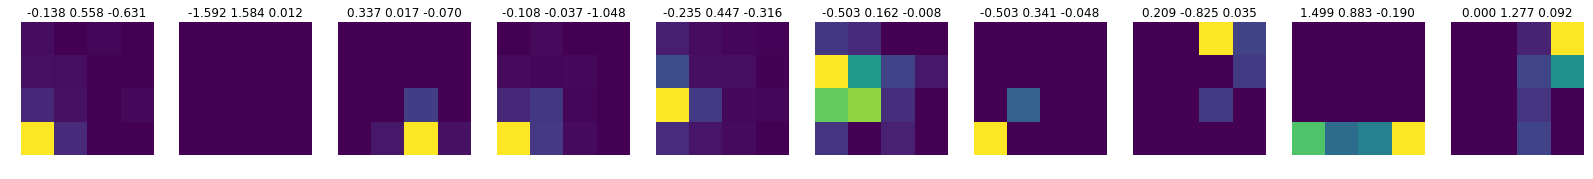

epoch: 37
a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-4.7854) tensor(0.0000, grad_fn=<SumBackward0>)


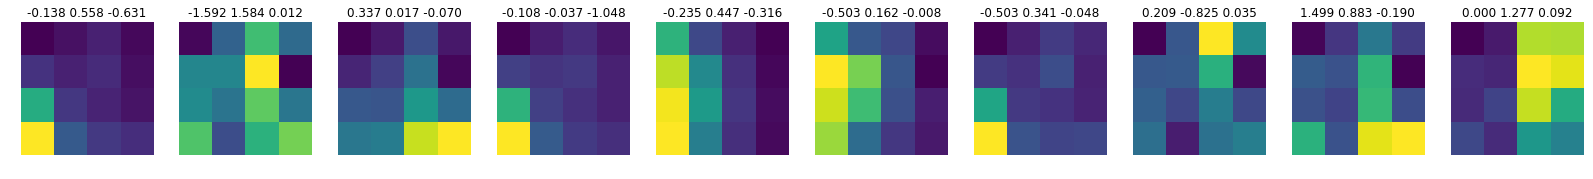

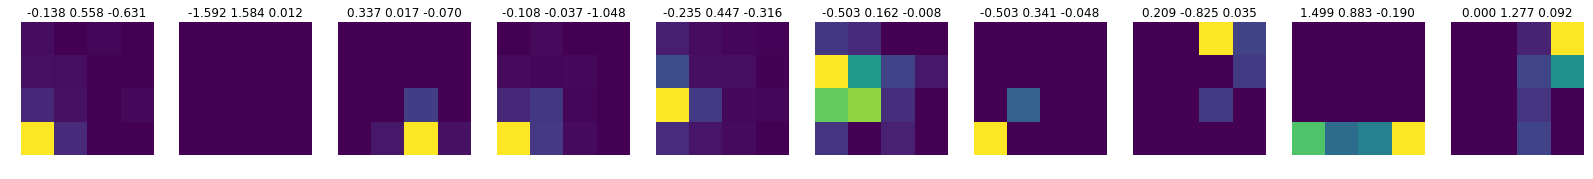

Train loss: -4.811380243893184 Batch 1500 of 500           a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-4.8956) tensor(8.0541e-06, grad_fn=<SumBackward0>)


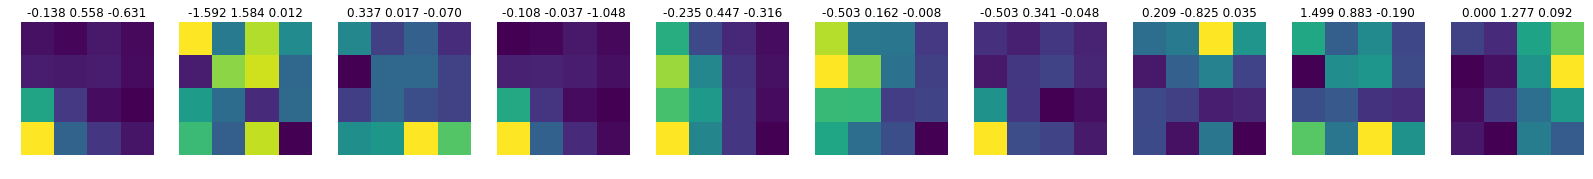

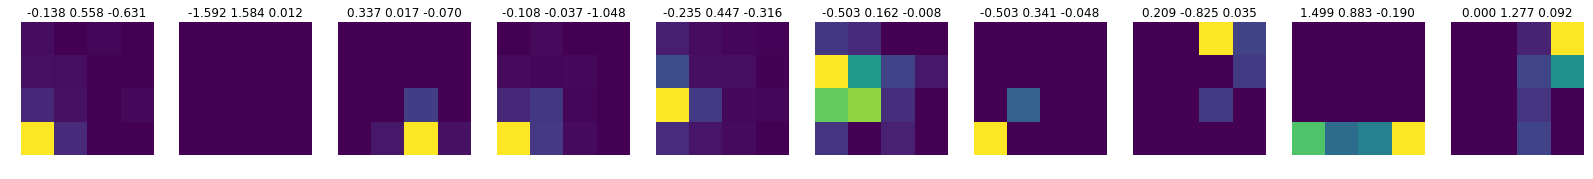

epoch: 38
a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-4.9049) tensor(8.0541e-06, grad_fn=<SumBackward0>)


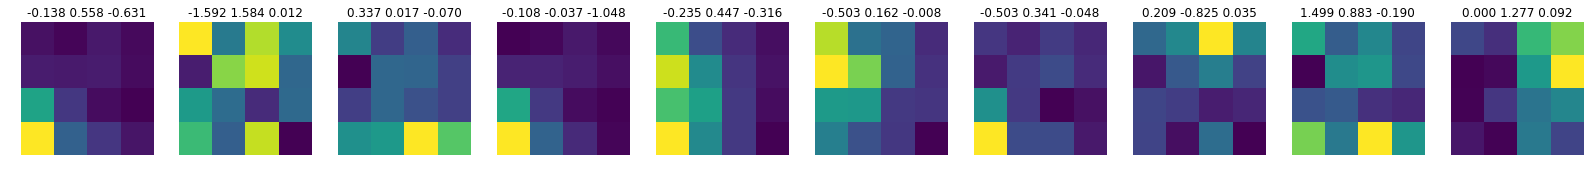

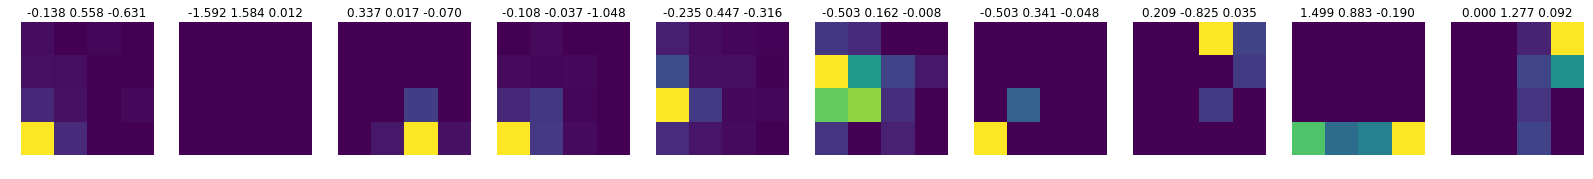

Train loss: -4.8464940554806875 Batch 1500 of 500           a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-5.0675) tensor(0.0000, grad_fn=<SumBackward0>)


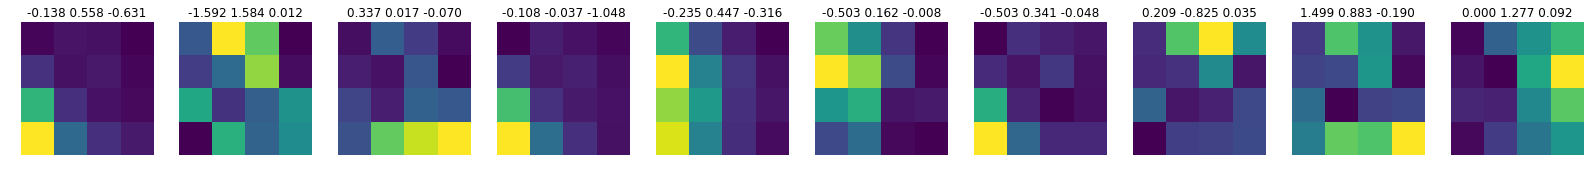

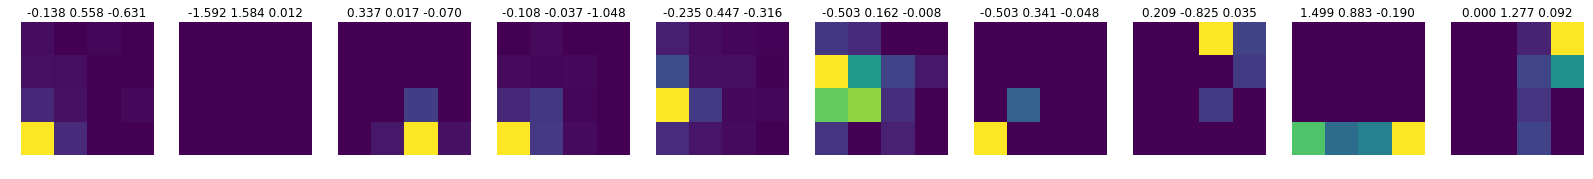

epoch: 39
a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-5.0798) tensor(0.0000, grad_fn=<SumBackward0>)


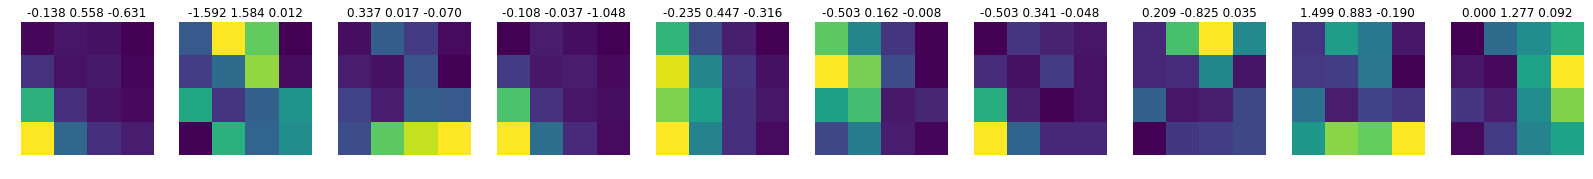

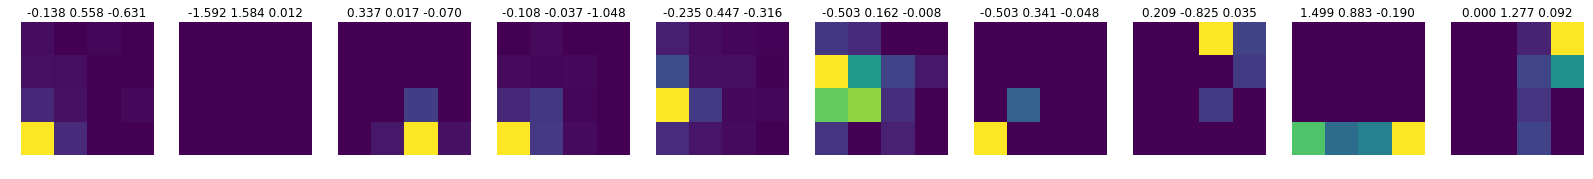

Train loss: -4.9959848645538685 Batch 1500 of 500           a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-4.9868) tensor(1.8335e-06, grad_fn=<SumBackward0>)


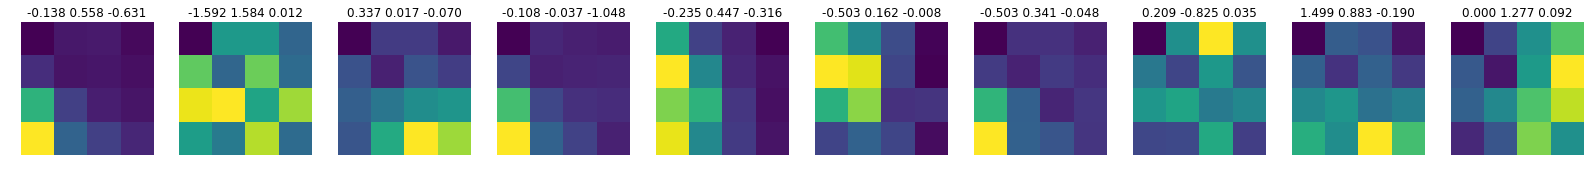

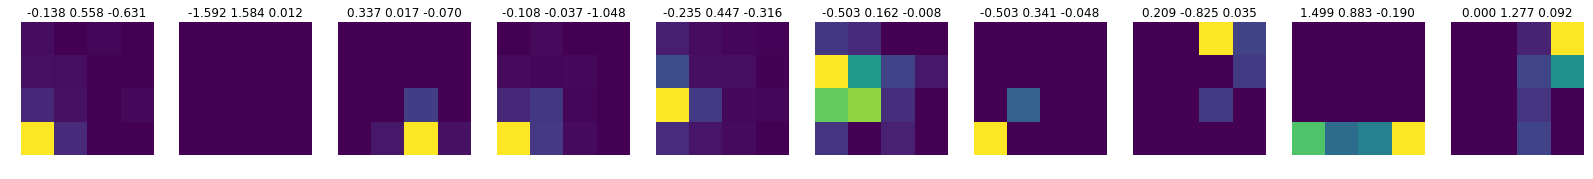

epoch: 40
a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-4.9889) tensor(1.8335e-06, grad_fn=<SumBackward0>)


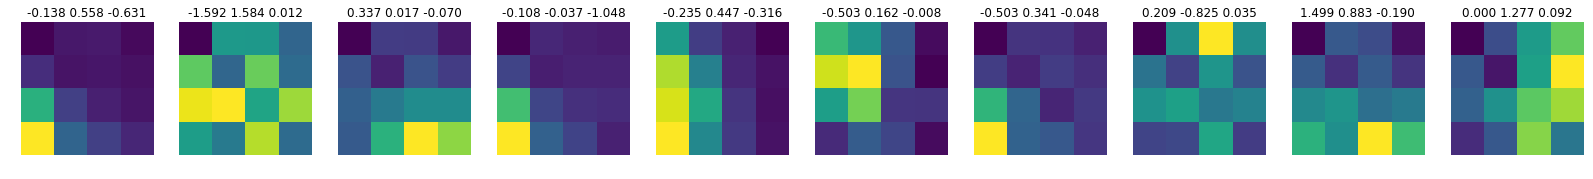

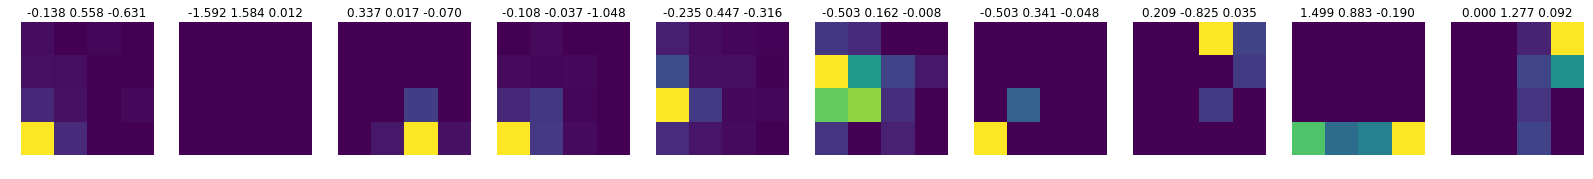

Train loss: -4.82867351101915 Batch 1500 of 500           a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-5.0605) tensor(3.9031e-06, grad_fn=<SumBackward0>)


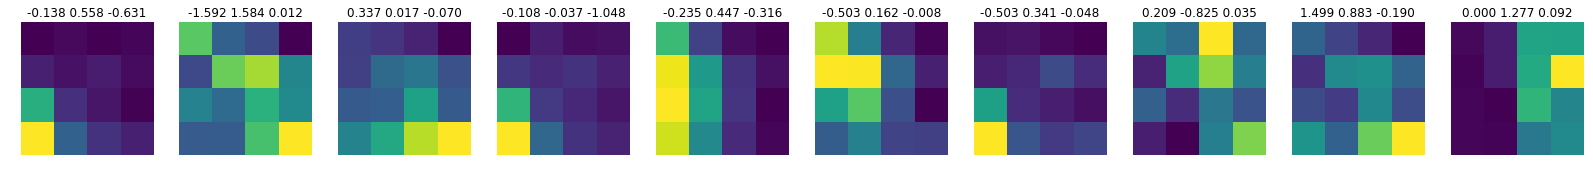

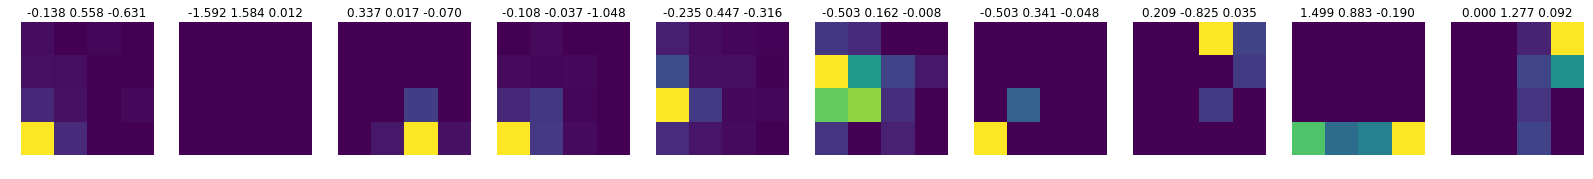

epoch: 41
a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-5.0527) tensor(3.9031e-06, grad_fn=<SumBackward0>)


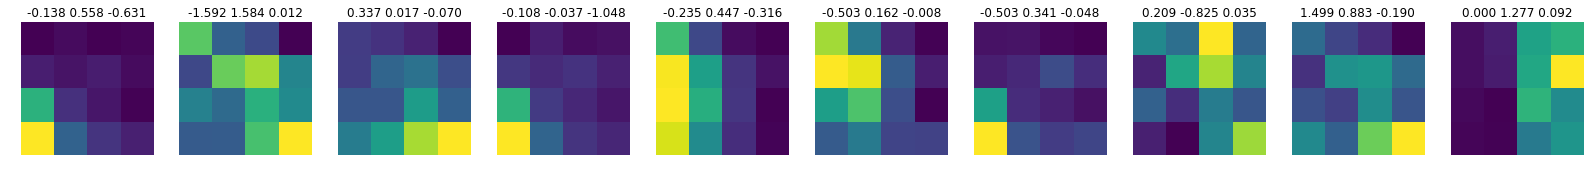

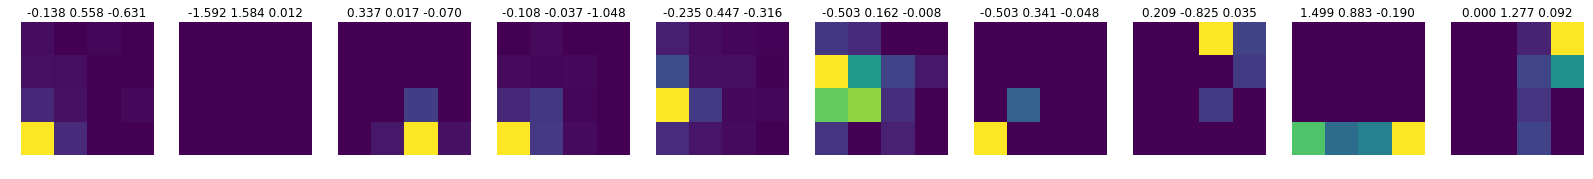

Train loss: -5.13115009757018 Batch 1500 of 500           a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-5.0149) tensor(8.7480e-06, grad_fn=<SumBackward0>)


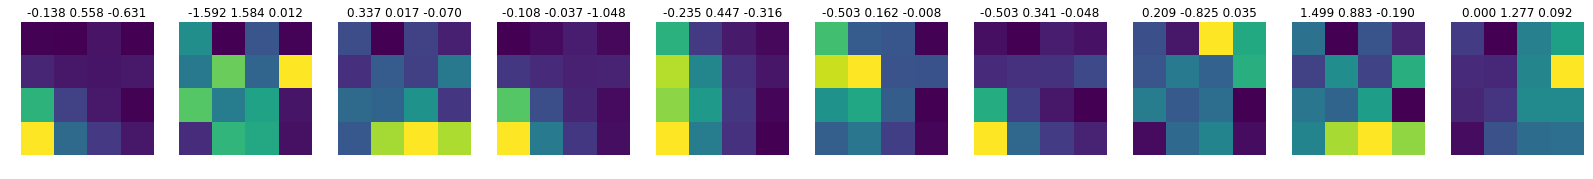

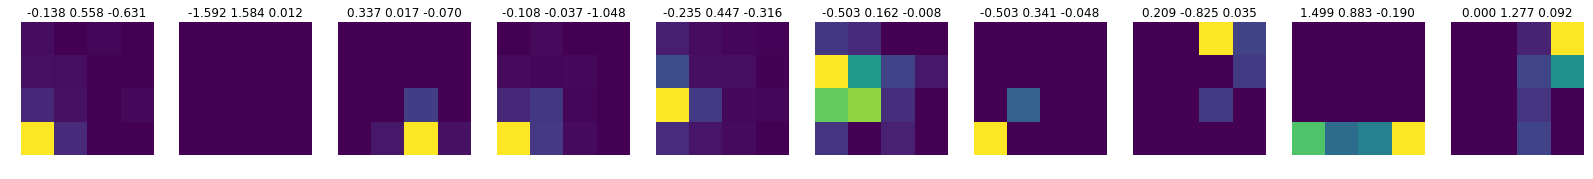

epoch: 42
a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-5.0109) tensor(8.7480e-06, grad_fn=<SumBackward0>)


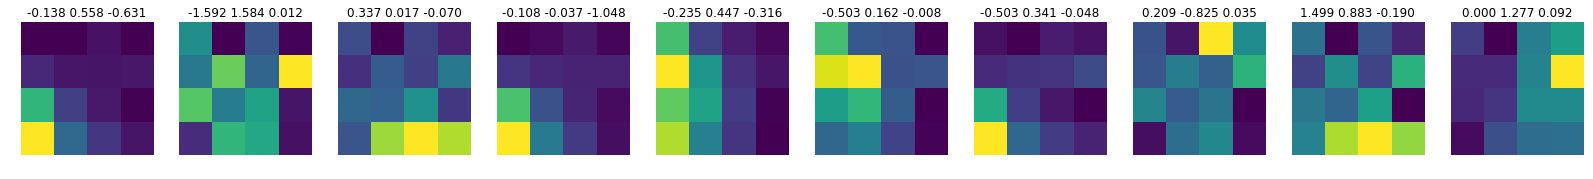

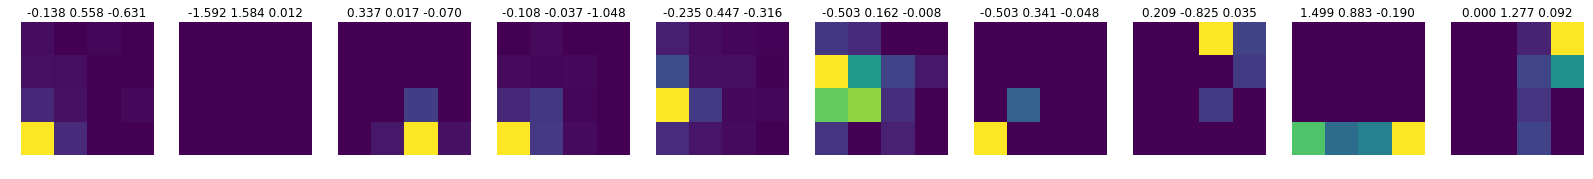

Train loss: -4.93633940337539 Batch 1500 of 500           a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-4.8997) tensor(0.0000, grad_fn=<SumBackward0>)


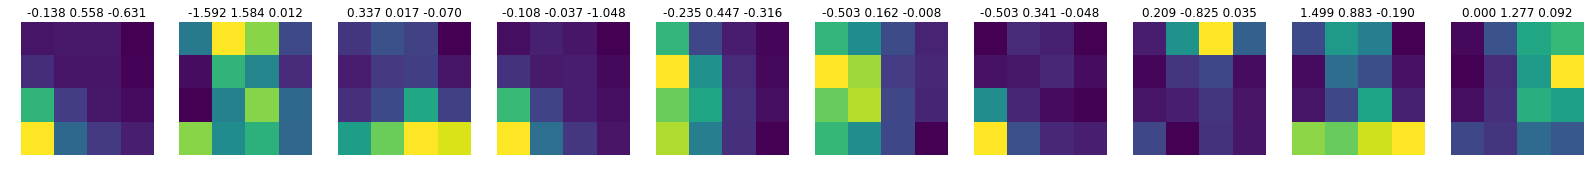

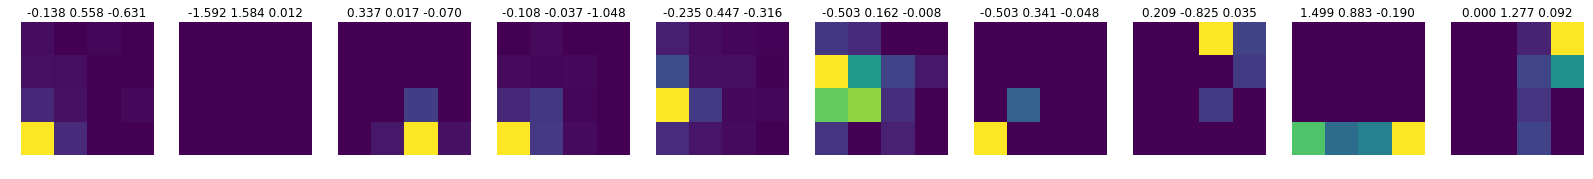

epoch: 43
a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-4.8969) tensor(0.0000, grad_fn=<SumBackward0>)


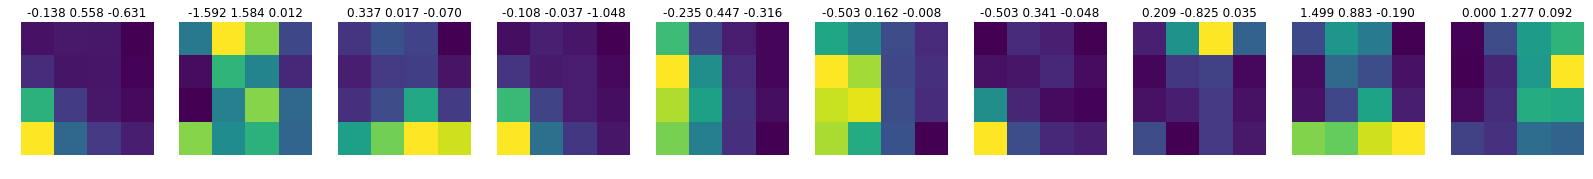

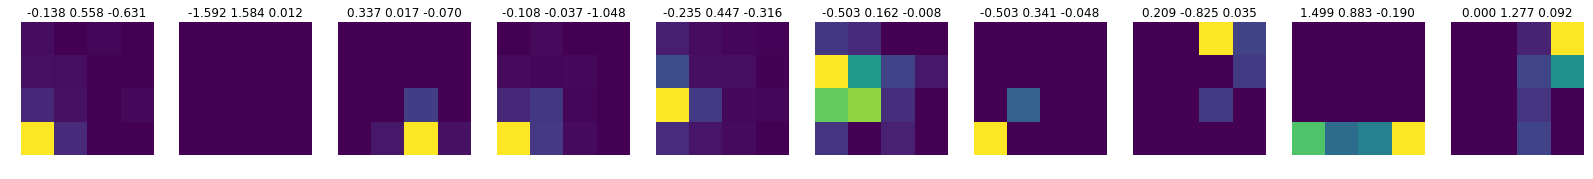

Train loss: -4.779722988933179 Batch 1500 of 500           a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-4.7427) tensor(1.3309e-06, grad_fn=<SumBackward0>)


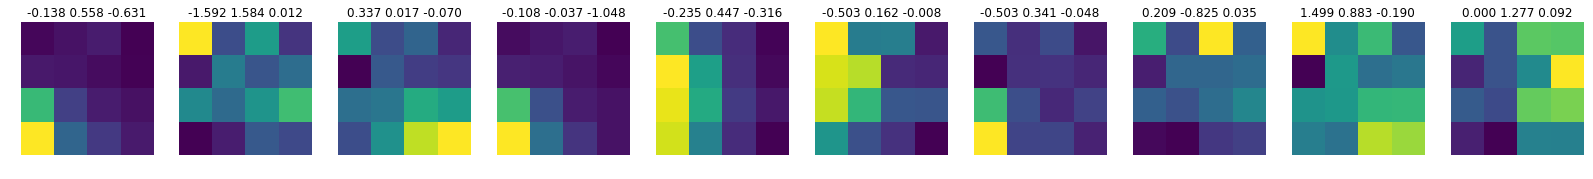

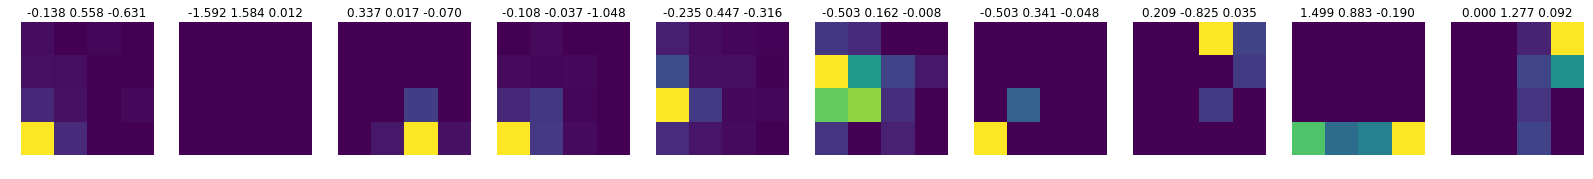

epoch: 44
a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-4.7359) tensor(1.3309e-06, grad_fn=<SumBackward0>)


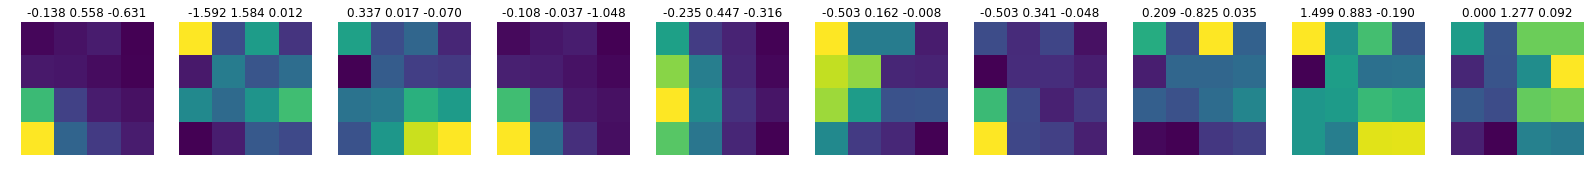

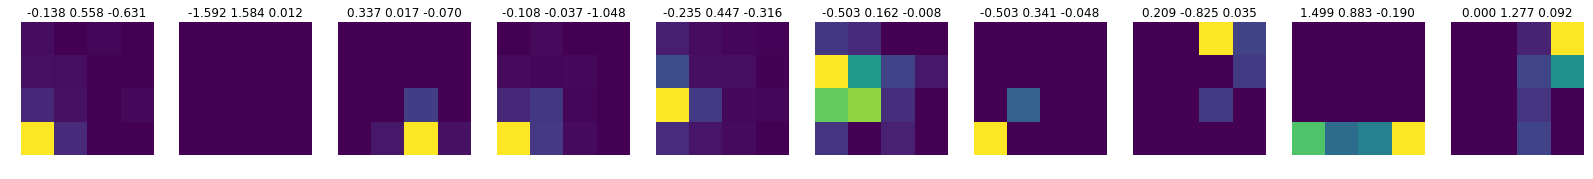

Train loss: -4.780192665729583 Batch 1500 of 500           a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-4.9708) tensor(0.0000, grad_fn=<SumBackward0>)


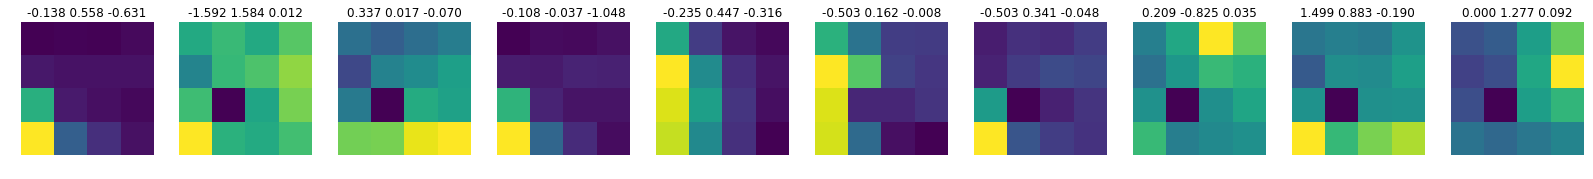

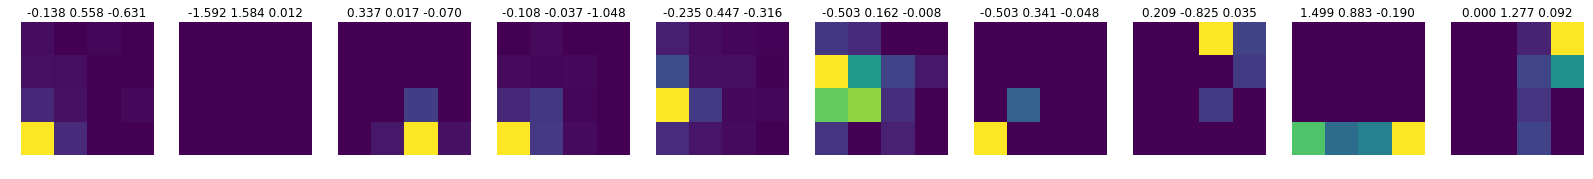

epoch: 45
a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-4.9705) tensor(0.0000, grad_fn=<SumBackward0>)


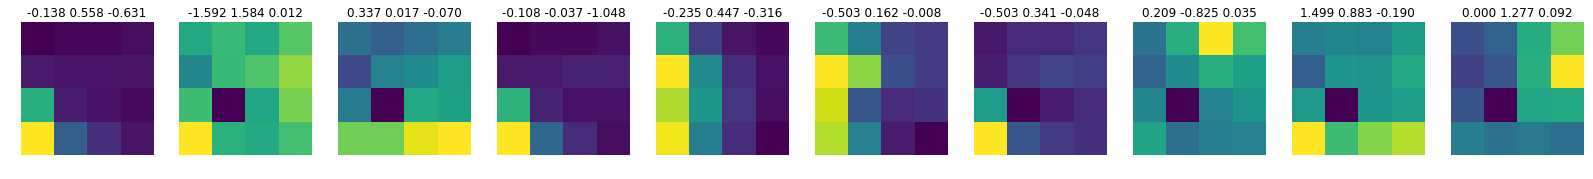

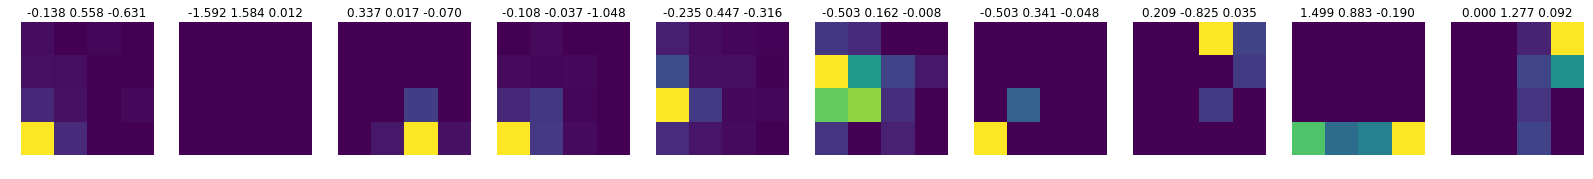

Train loss: -5.114982473919281 Batch 1500 of 500           a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-4.9621) tensor(8.1870e-06, grad_fn=<SumBackward0>)


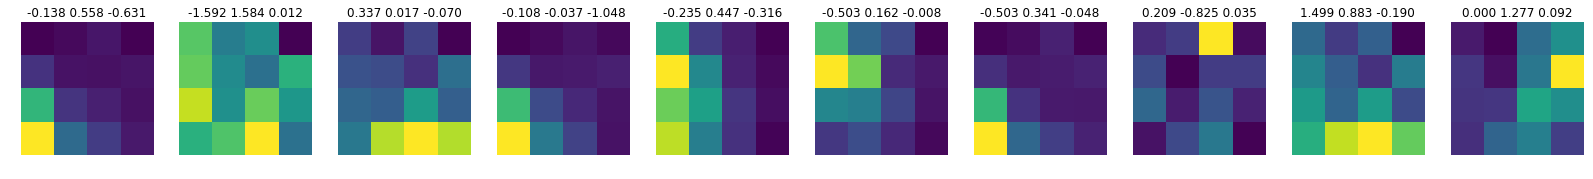

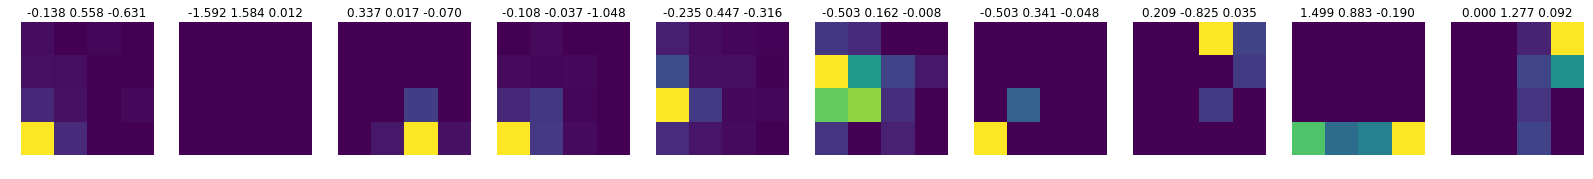

epoch: 46
a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-4.9490) tensor(8.1870e-06, grad_fn=<SumBackward0>)


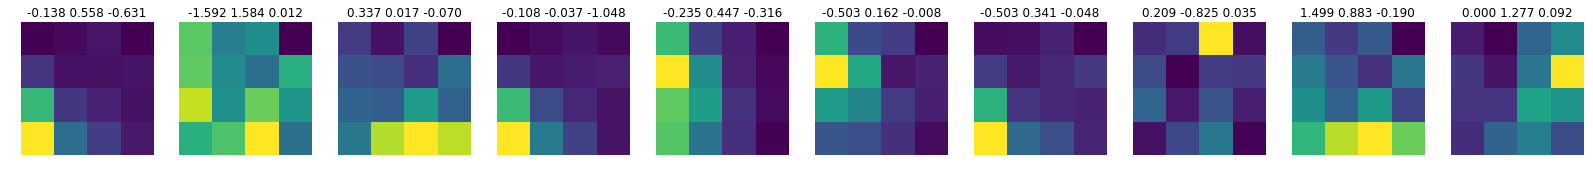

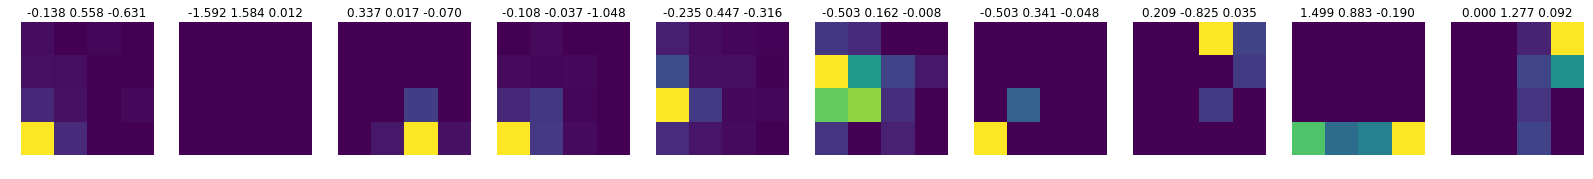

Train loss: -4.72612880017384 Batch 1500 of 500           a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-5.0420) tensor(2.7009e-06, grad_fn=<SumBackward0>)


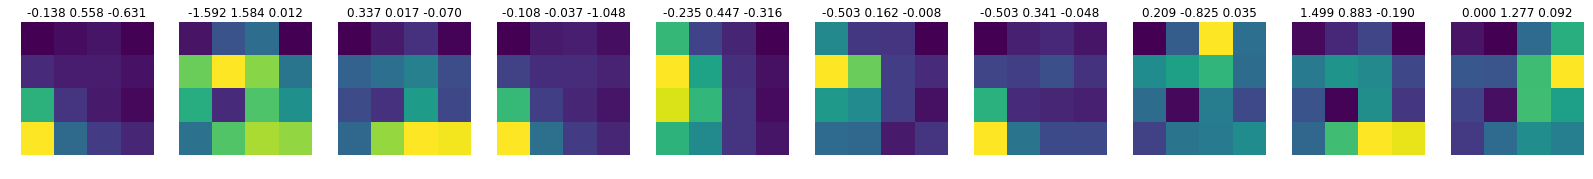

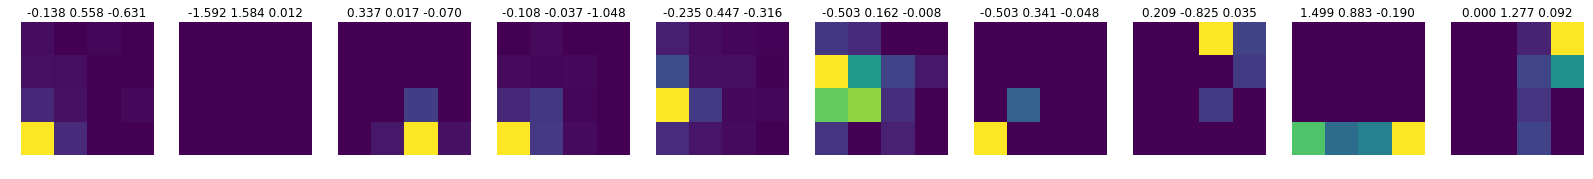

epoch: 47
a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-5.0429) tensor(2.7009e-06, grad_fn=<SumBackward0>)


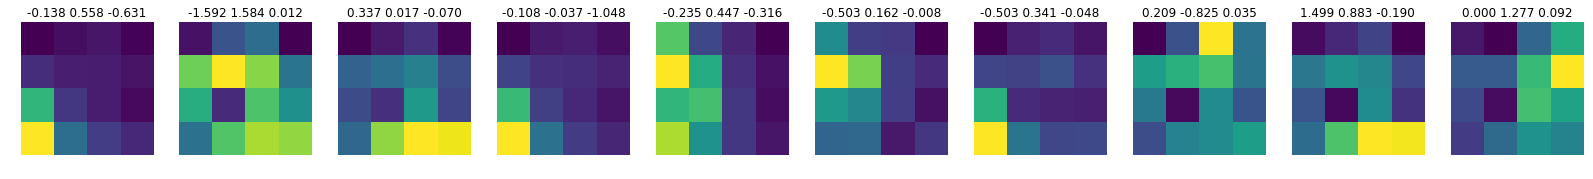

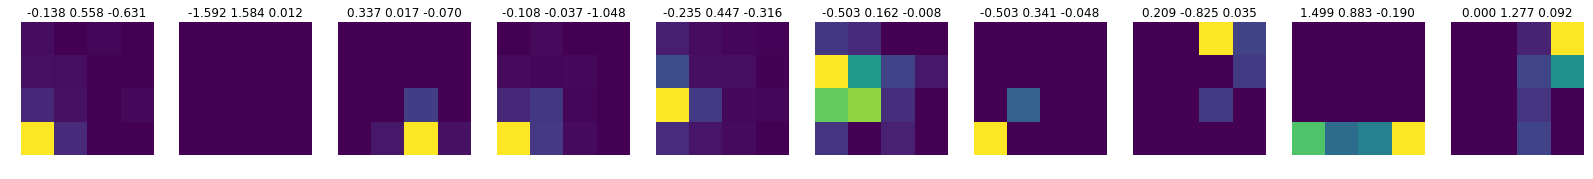

Train loss: -5.033382697754576 Batch 1500 of 500           a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-4.9121) tensor(0.0000, grad_fn=<SumBackward0>)


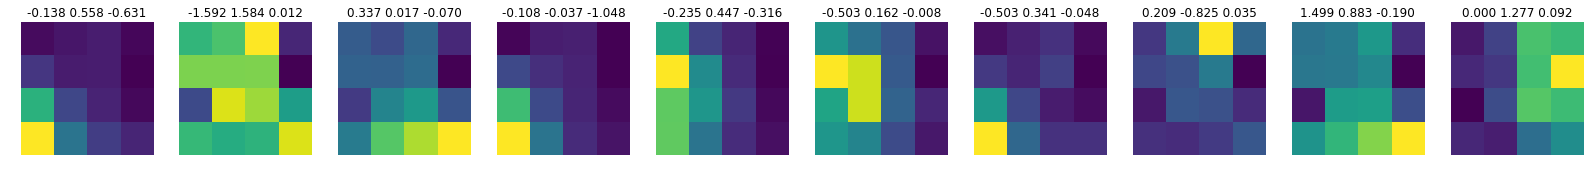

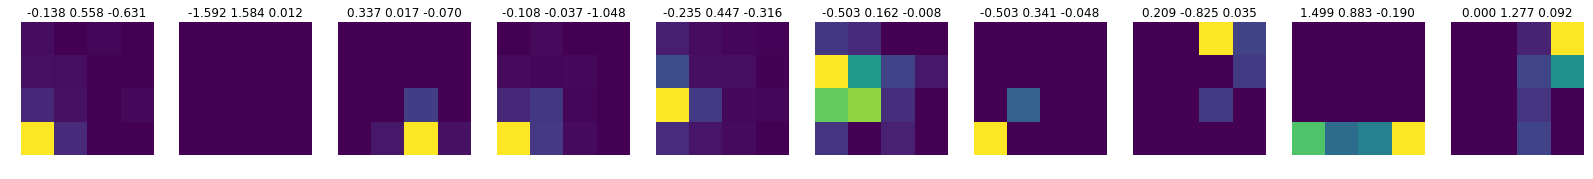

epoch: 48
a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-4.9037) tensor(0.0000, grad_fn=<SumBackward0>)


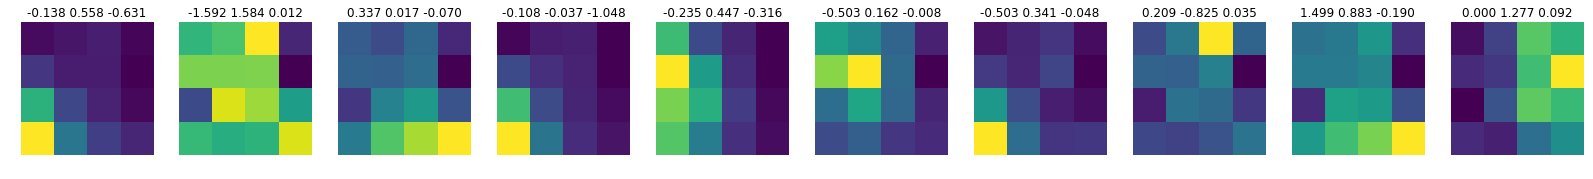

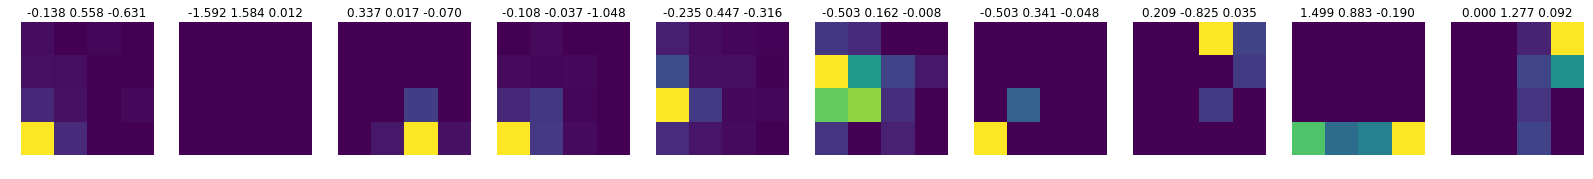

Train loss: -4.820884148059257 Batch 1500 of 500           a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-4.7419) tensor(9.8627e-06, grad_fn=<SumBackward0>)


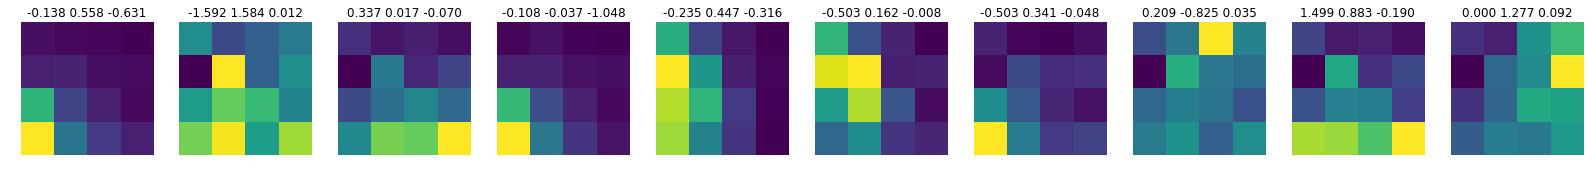

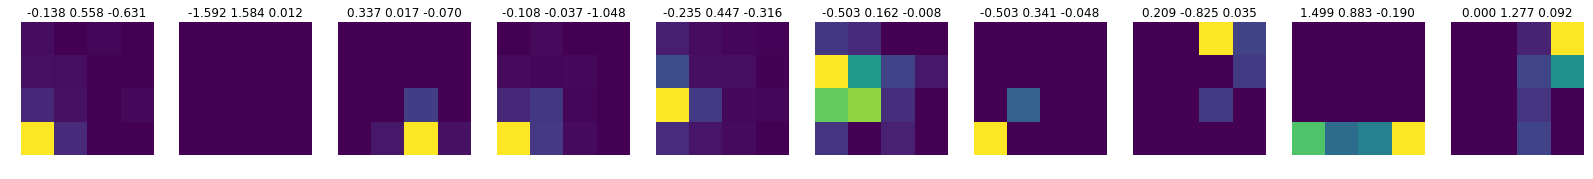

epoch: 49
a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-4.7525) tensor(9.8627e-06, grad_fn=<SumBackward0>)


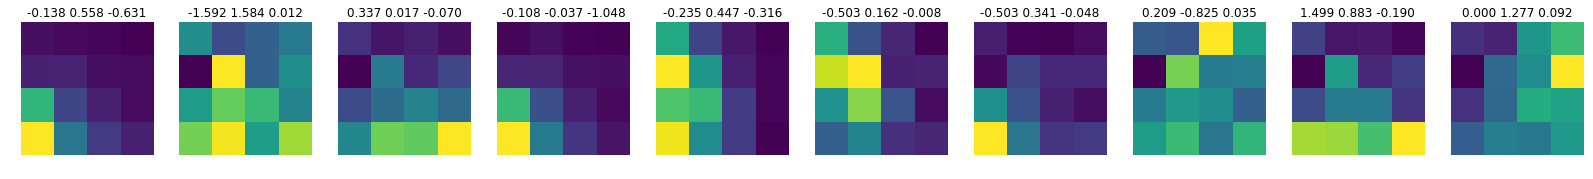

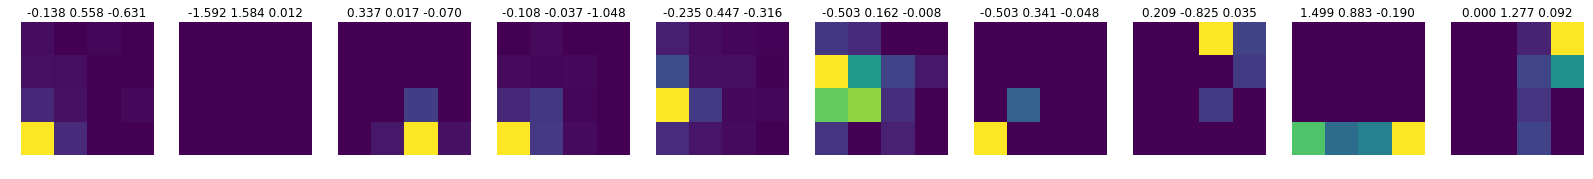

Train loss: -4.8138042892401725 Batch 1500 of 500           a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-4.8987) tensor(1.1380e-06, grad_fn=<SumBackward0>)


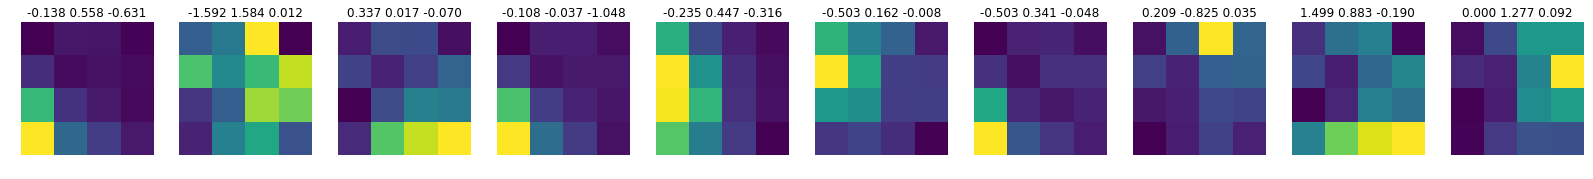

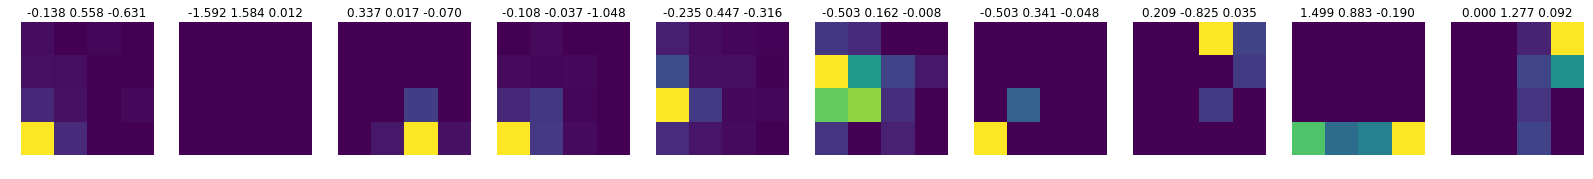

epoch: 50
a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-4.9016) tensor(1.1380e-06, grad_fn=<SumBackward0>)


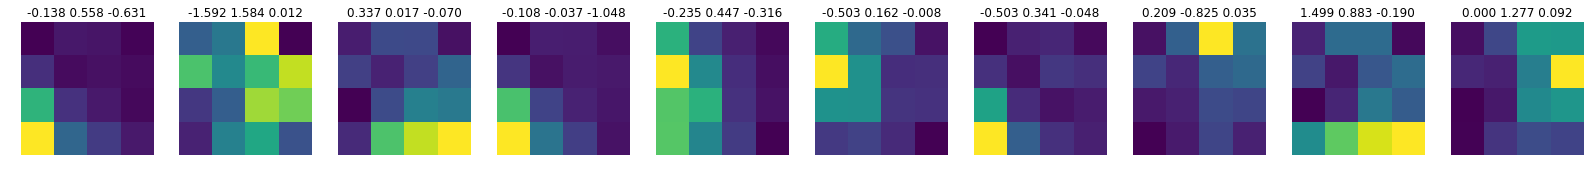

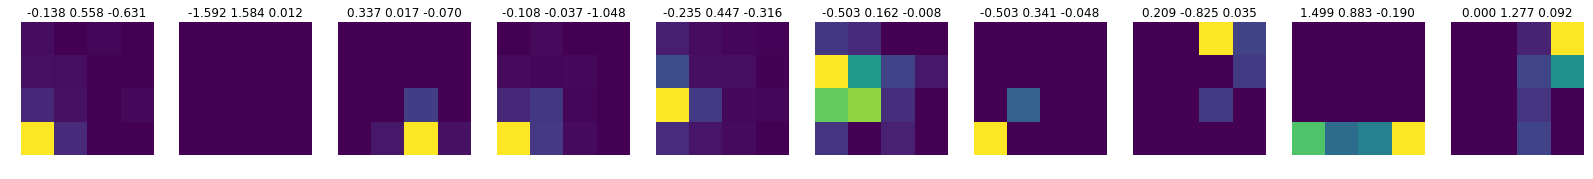

Train loss: -4.79805714408298 Batch 1500 of 500           a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-4.9356) tensor(3.6468e-06, grad_fn=<SumBackward0>)


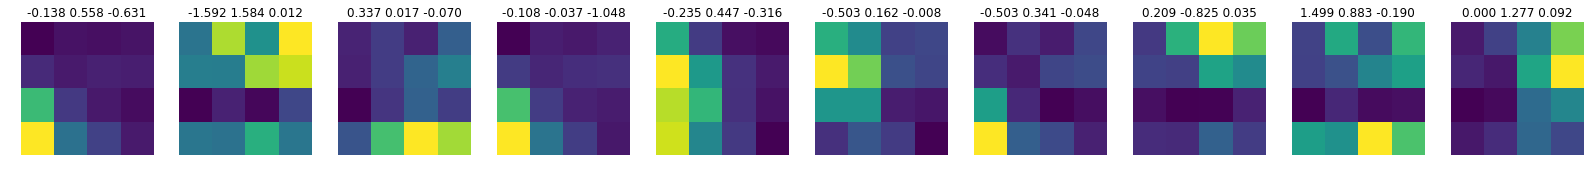

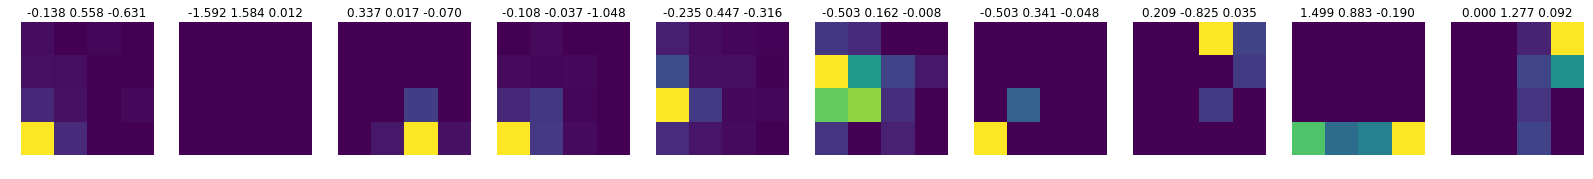

epoch: 51
a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-4.9316) tensor(3.6468e-06, grad_fn=<SumBackward0>)


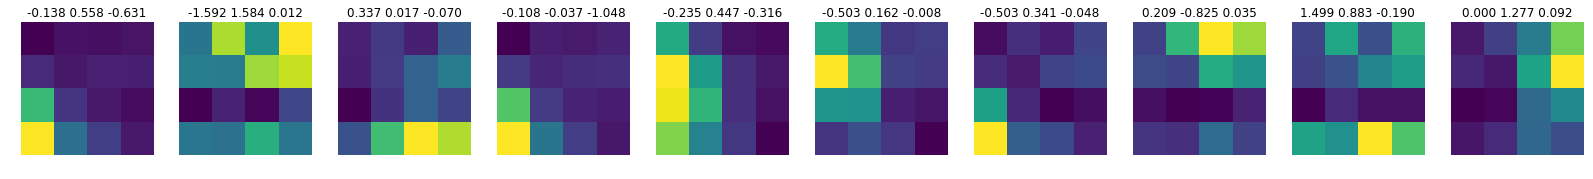

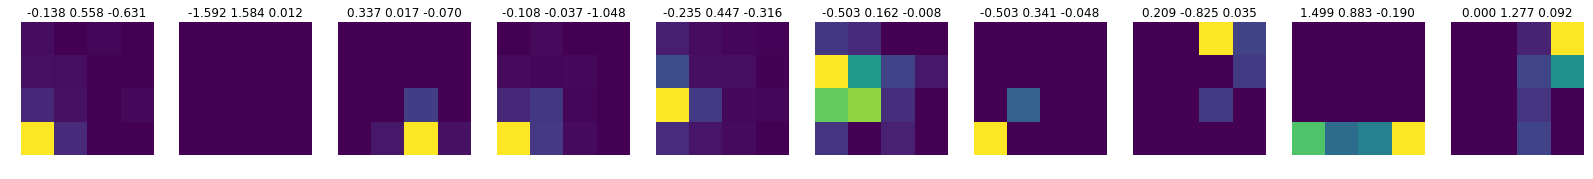

Train loss: -4.951805075180181 Batch 1500 of 500           a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-5.1138) tensor(3.1987e-06, grad_fn=<SumBackward0>)


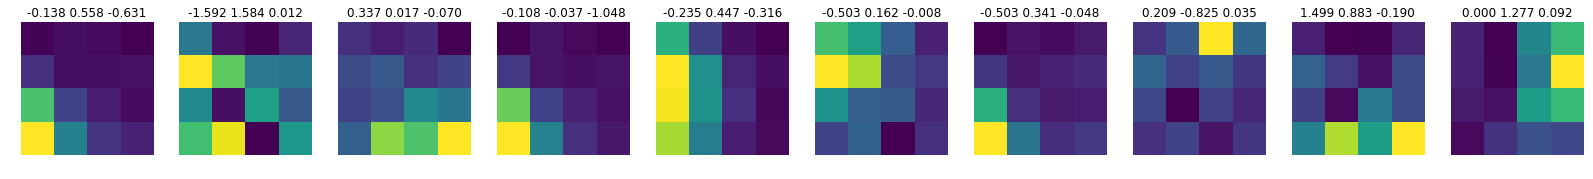

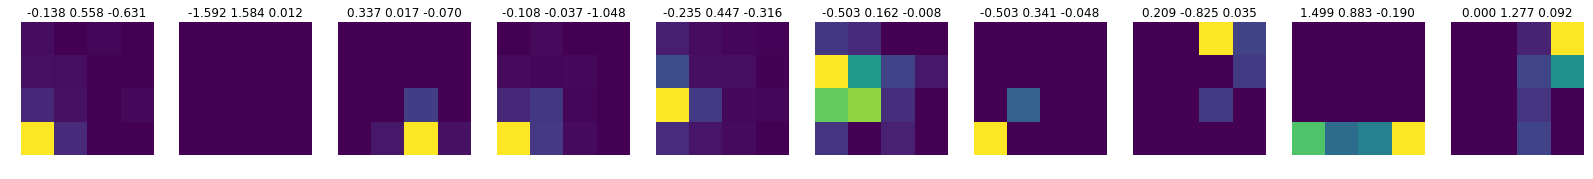

epoch: 52
a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-5.1125) tensor(3.1987e-06, grad_fn=<SumBackward0>)


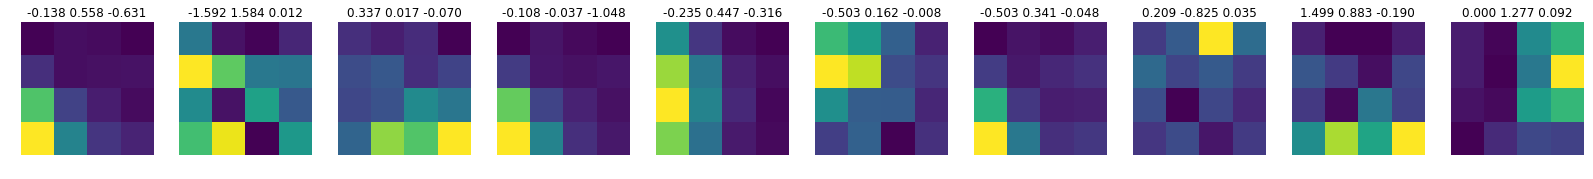

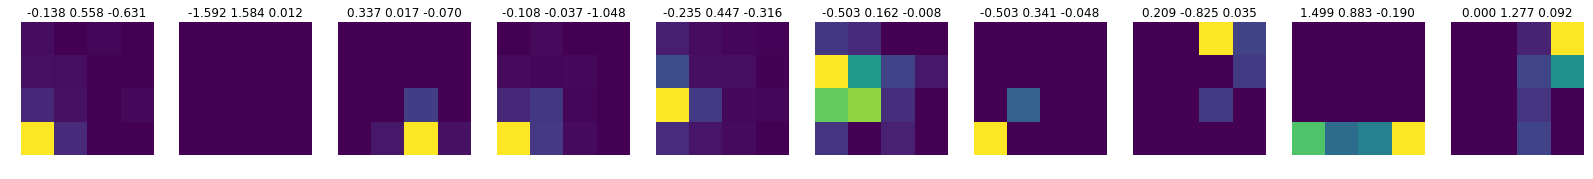

Train loss: -5.026317568139701 Batch 1500 of 500           a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-5.2361) tensor(6.2755e-06, grad_fn=<SumBackward0>)


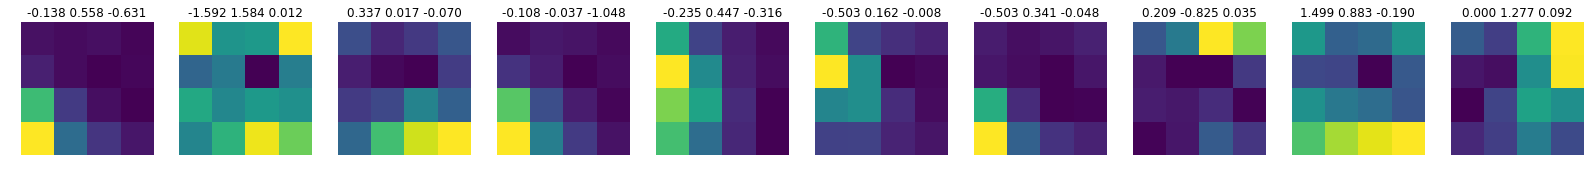

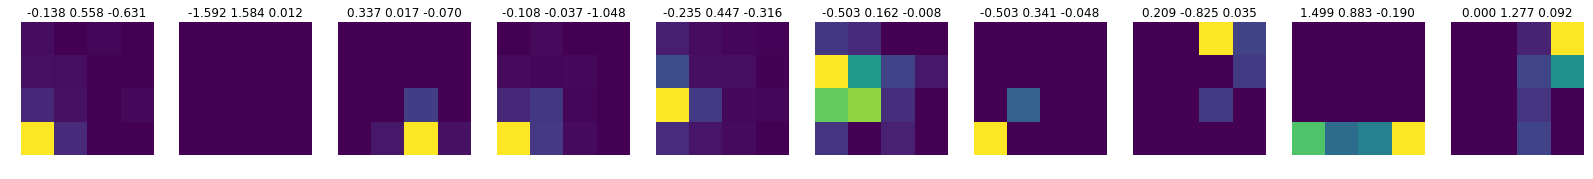

epoch: 53
a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-5.2291) tensor(6.2755e-06, grad_fn=<SumBackward0>)


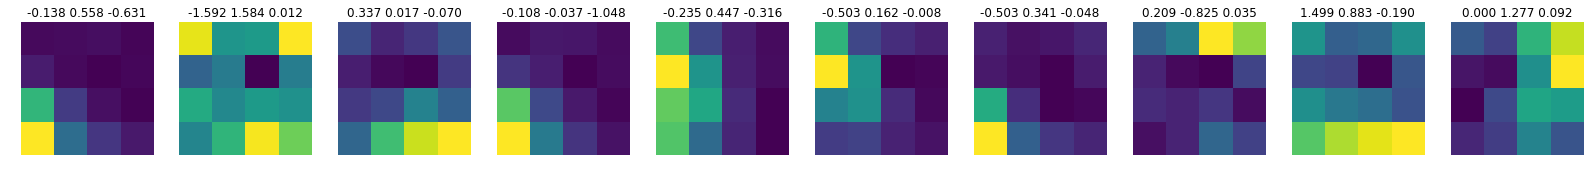

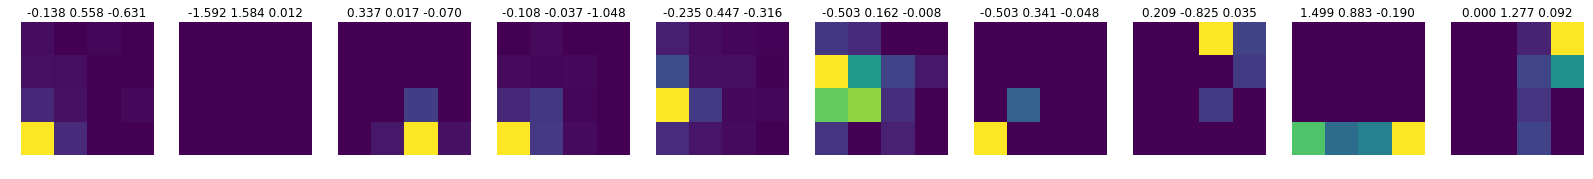

Train loss: -5.004441687893162 Batch 1500 of 500           a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-5.2831) tensor(2.7210e-06, grad_fn=<SumBackward0>)


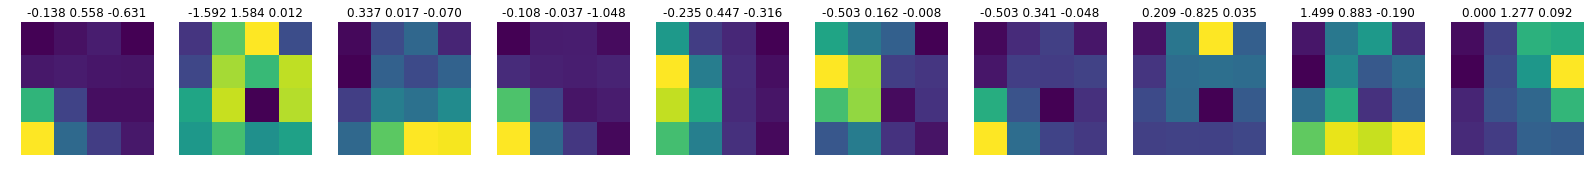

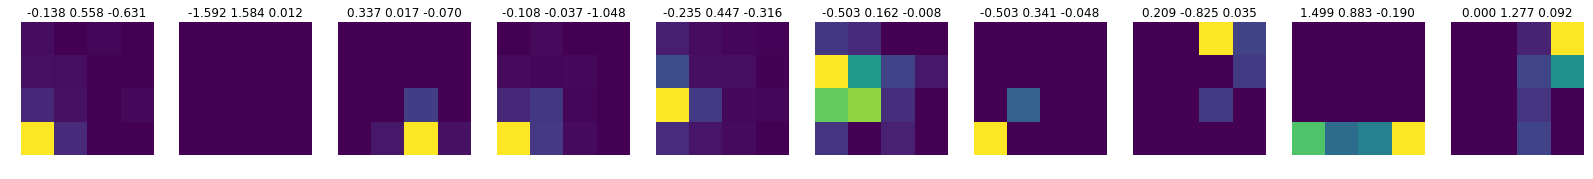

epoch: 54
a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-5.2854) tensor(2.7210e-06, grad_fn=<SumBackward0>)


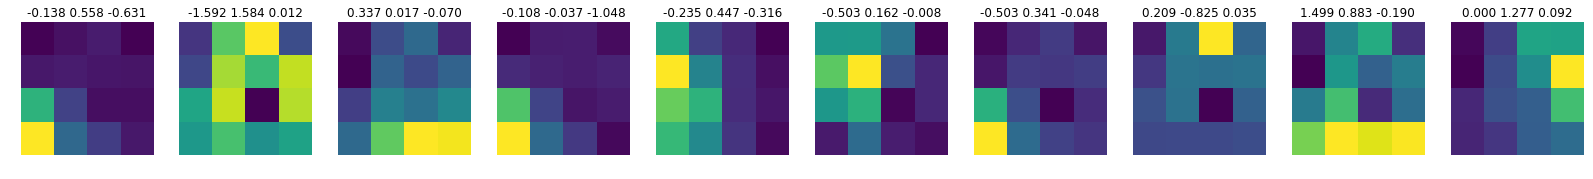

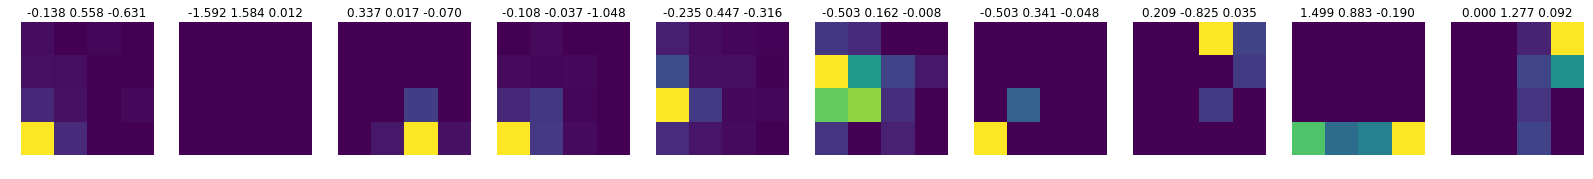

Train loss: -5.26431103822301 Batch 1500 of 500           a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-4.9649) tensor(7.9280e-06, grad_fn=<SumBackward0>)


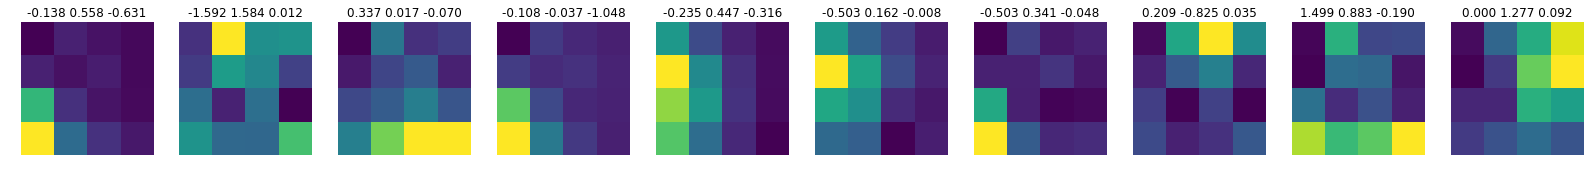

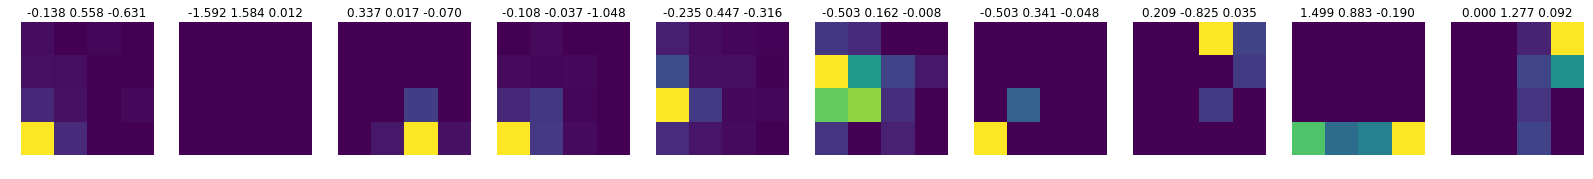

epoch: 55
a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-4.9650) tensor(7.9280e-06, grad_fn=<SumBackward0>)


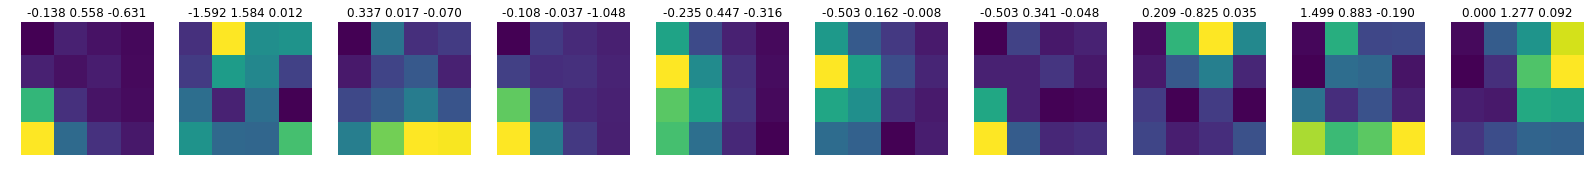

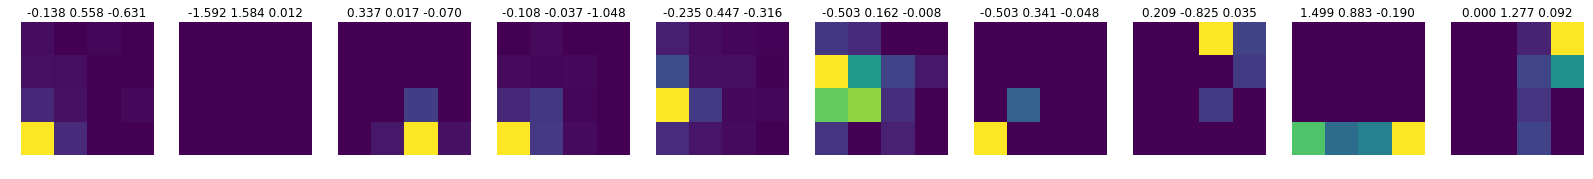

Train loss: -4.841519261192388 Batch 1500 of 500           a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-4.7219) tensor(0.0000, grad_fn=<SumBackward0>)


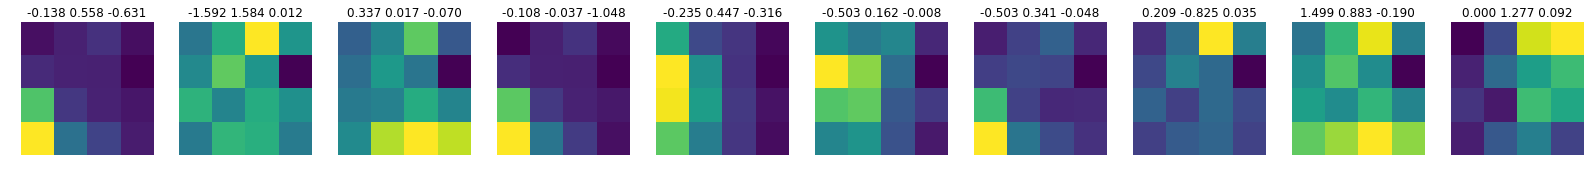

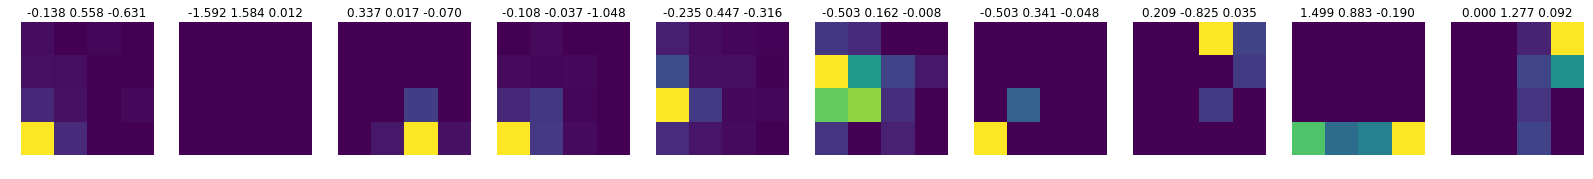

epoch: 56
a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-4.7122) tensor(0.0000, grad_fn=<SumBackward0>)


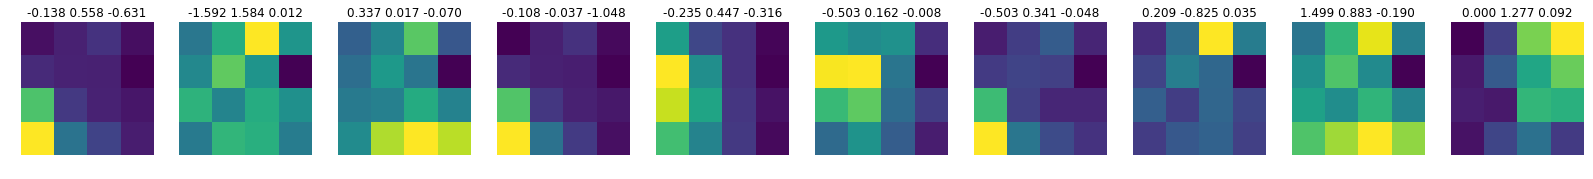

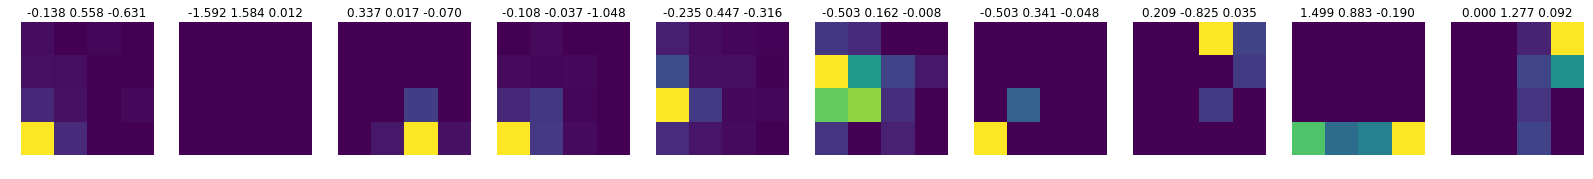

Train loss: -4.993749053581979 Batch 1500 of 500           a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-5.1021) tensor(7.8517e-06, grad_fn=<SumBackward0>)


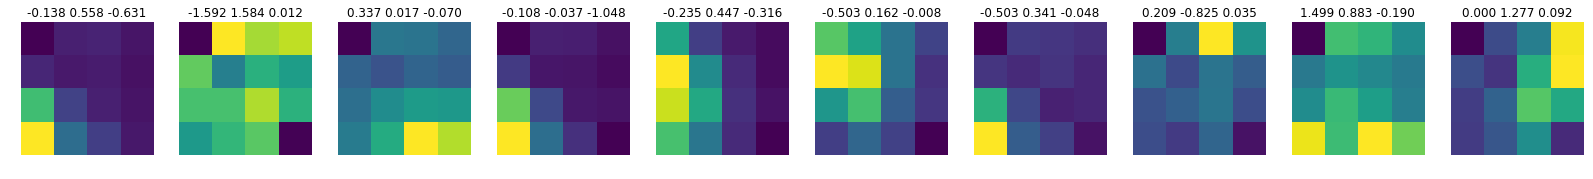

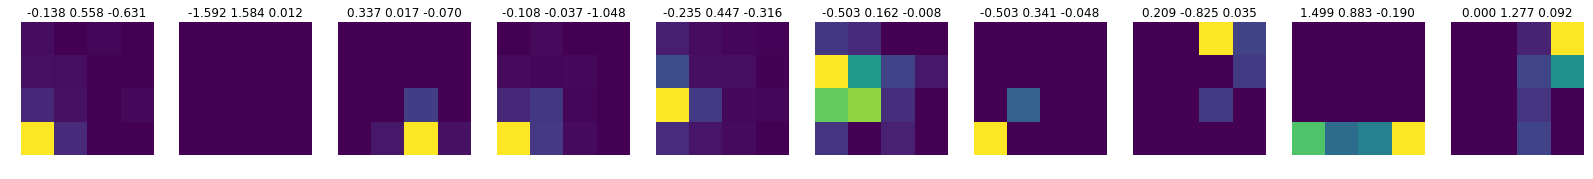

epoch: 57
a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-5.1129) tensor(7.8517e-06, grad_fn=<SumBackward0>)


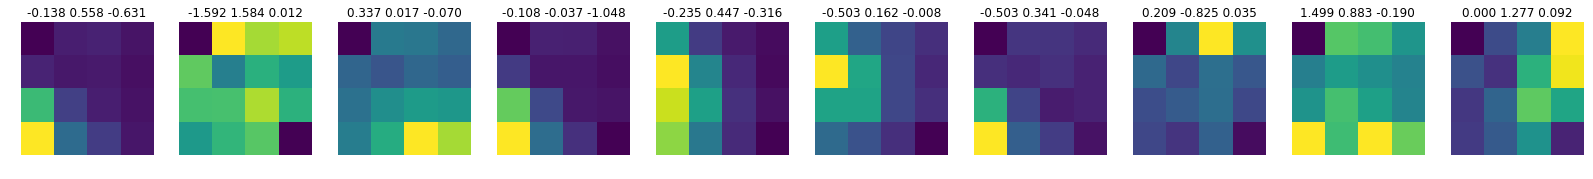

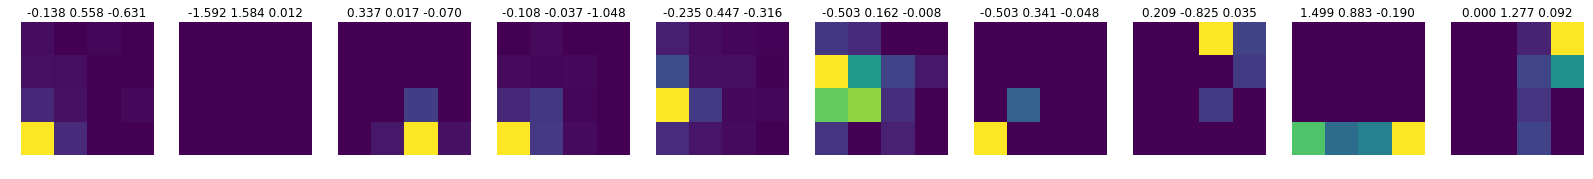

Train loss: -5.017541791901945 Batch 1500 of 500           a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-4.8052) tensor(2.9294e-06, grad_fn=<SumBackward0>)


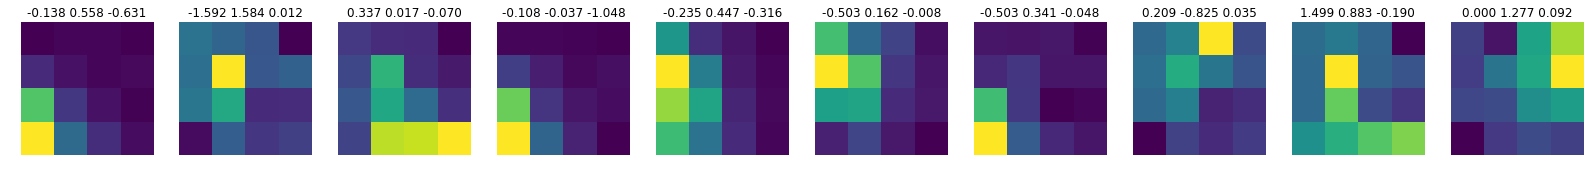

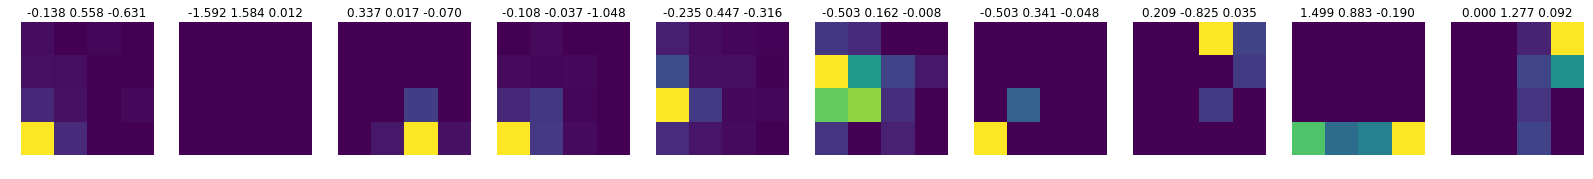

epoch: 58
a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-4.8159) tensor(2.9294e-06, grad_fn=<SumBackward0>)


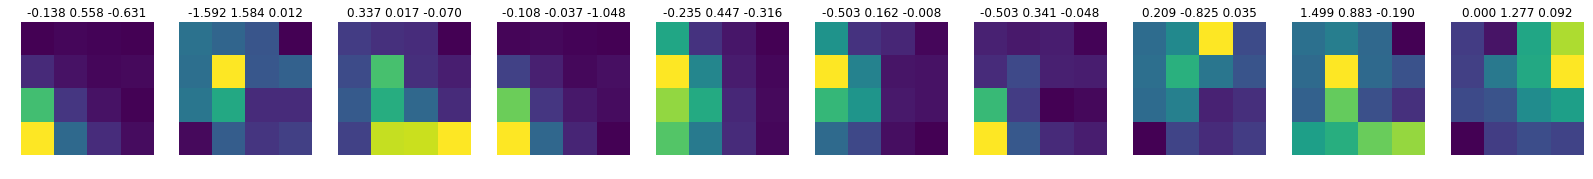

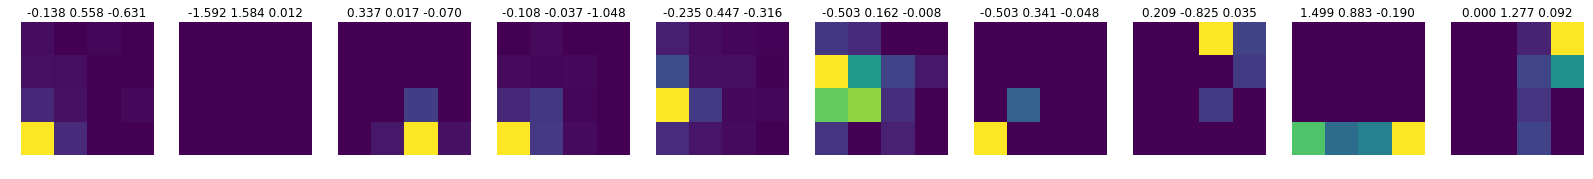

Train loss: -4.544162026520064 Batch 1500 of 500           a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-4.8053) tensor(3.9189e-06, grad_fn=<SumBackward0>)


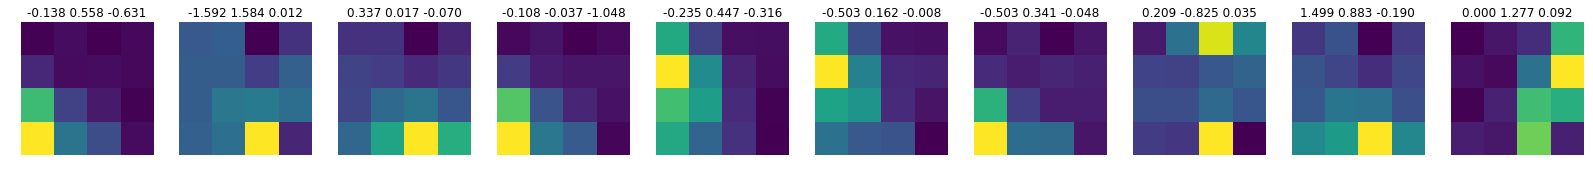

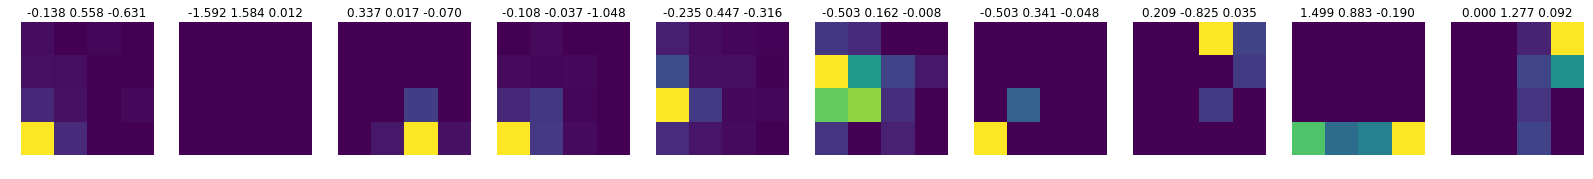

epoch: 59
a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-4.8011) tensor(3.9189e-06, grad_fn=<SumBackward0>)


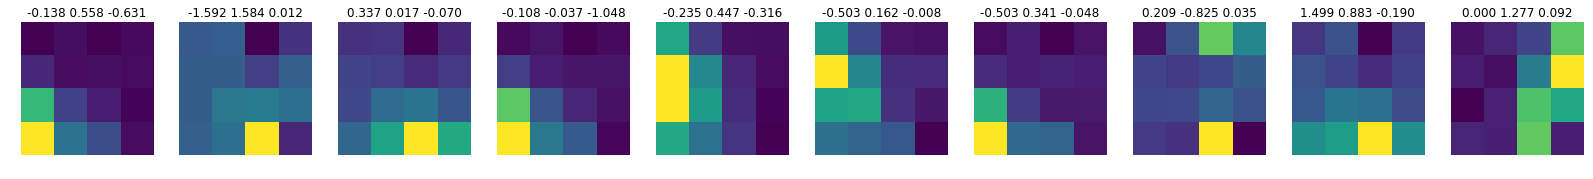

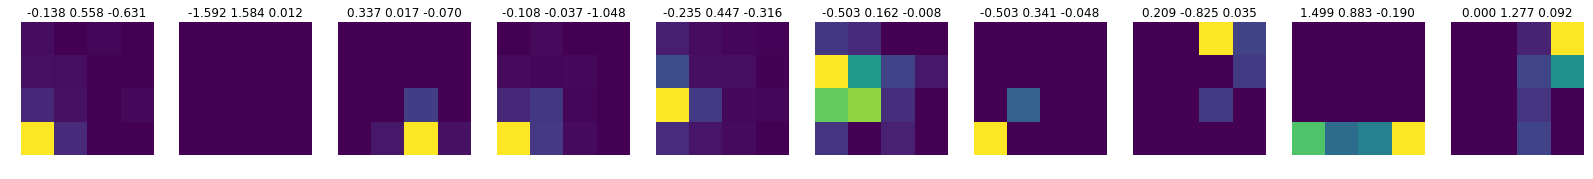

Train loss: -4.835336099323433 Batch 1500 of 500           a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-4.9487) tensor(6.6700e-06, grad_fn=<SumBackward0>)


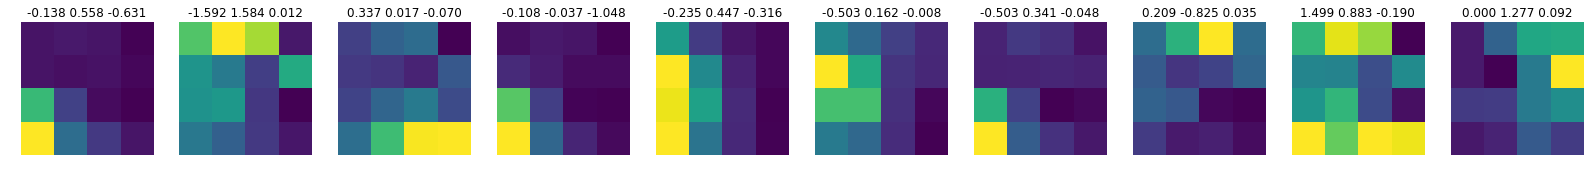

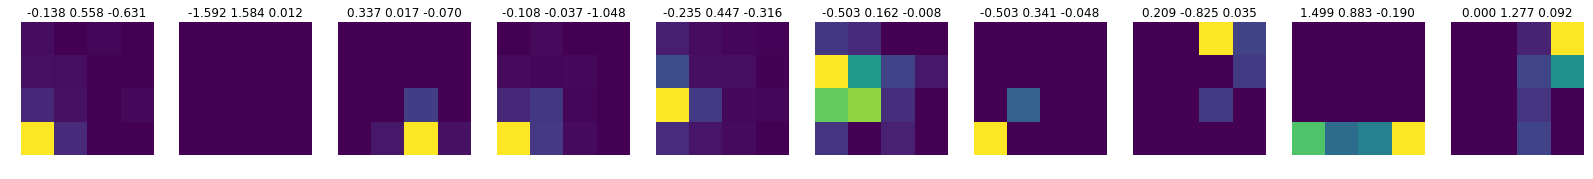

epoch: 60
a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-4.9597) tensor(6.6700e-06, grad_fn=<SumBackward0>)


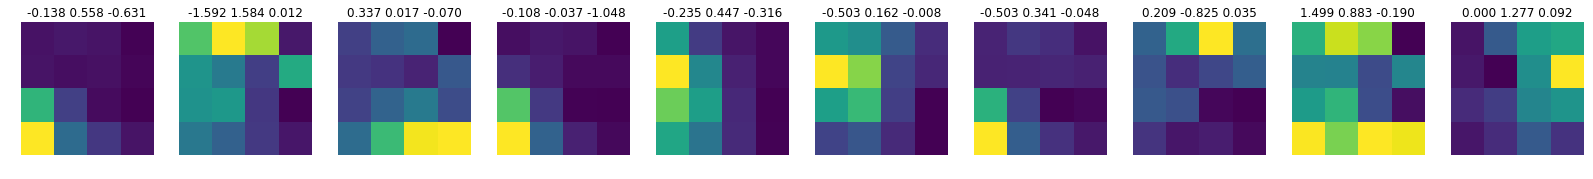

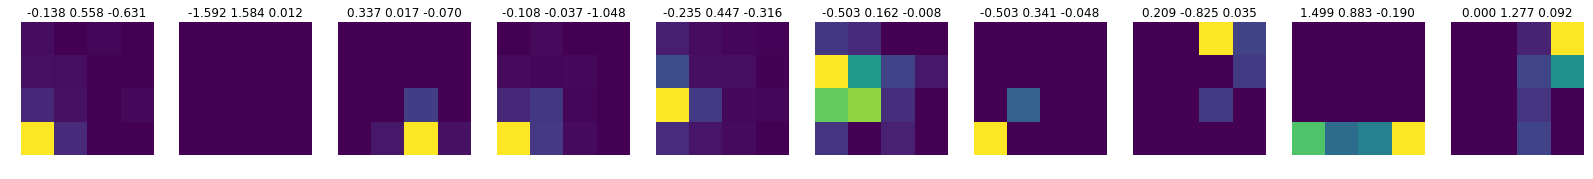

Train loss: -4.8999451238490215 Batch 1500 of 500           a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-5.0371) tensor(7.2916e-06, grad_fn=<SumBackward0>)


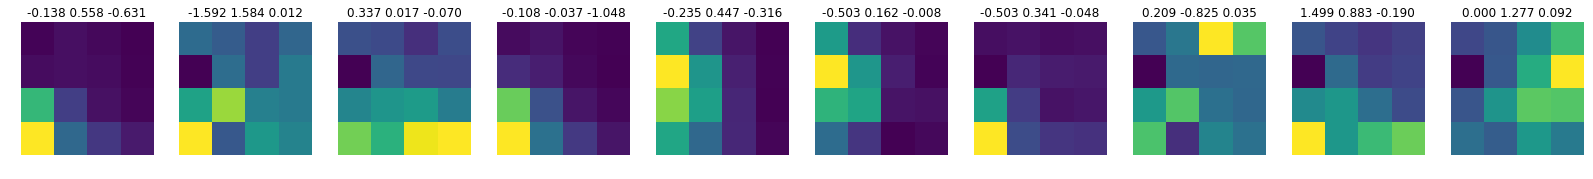

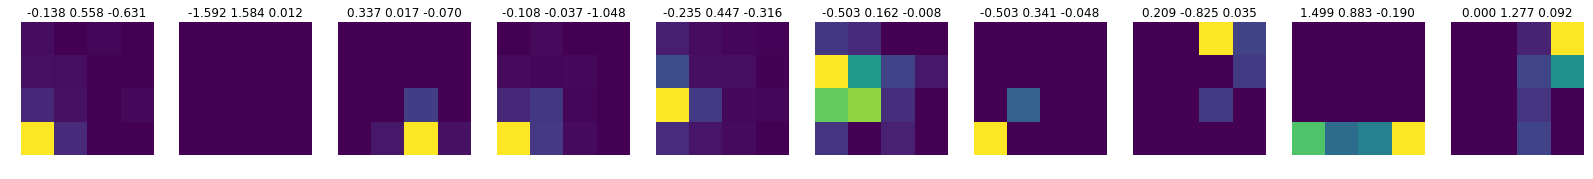

epoch: 61
a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-5.0270) tensor(7.2916e-06, grad_fn=<SumBackward0>)


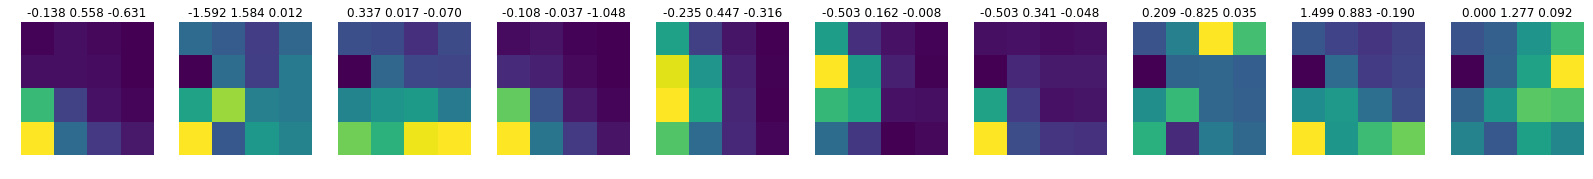

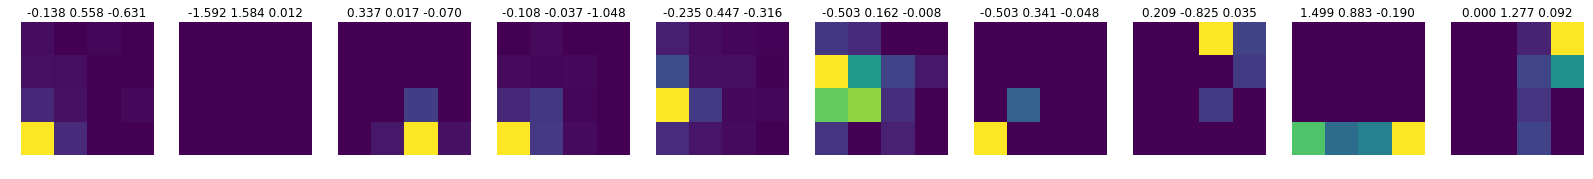

Train loss: -5.008886468943085 Batch 1500 of 500           a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-4.9758) tensor(1.6649e-06, grad_fn=<SumBackward0>)


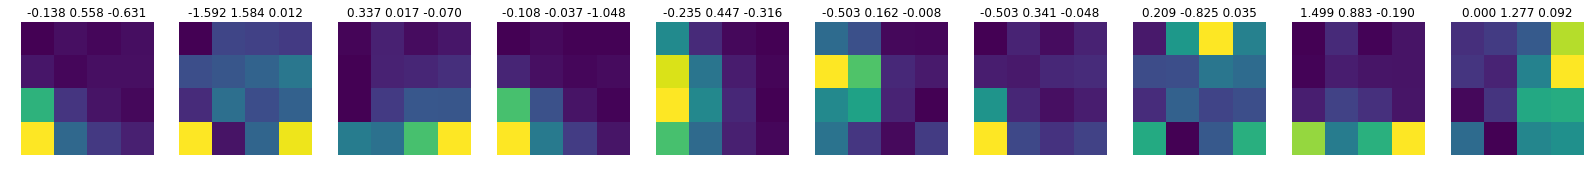

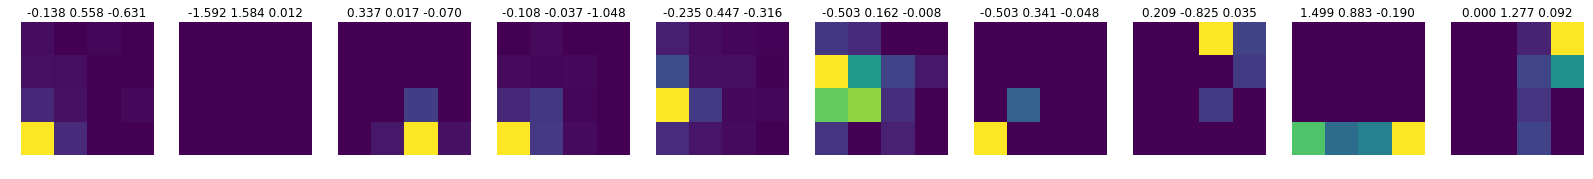

epoch: 62
a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-4.9768) tensor(1.6649e-06, grad_fn=<SumBackward0>)


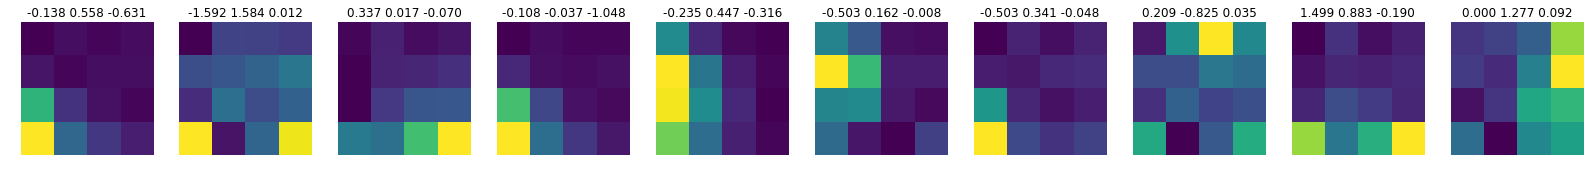

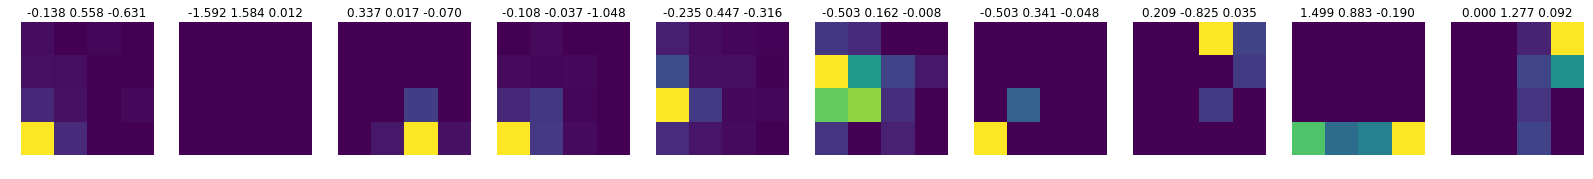

Train loss: -4.976602341505773 Batch 1500 of 500           a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-4.9143) tensor(1.7240e-06, grad_fn=<SumBackward0>)


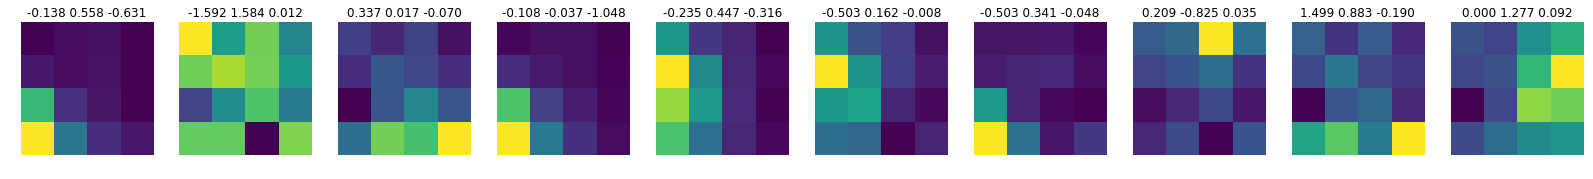

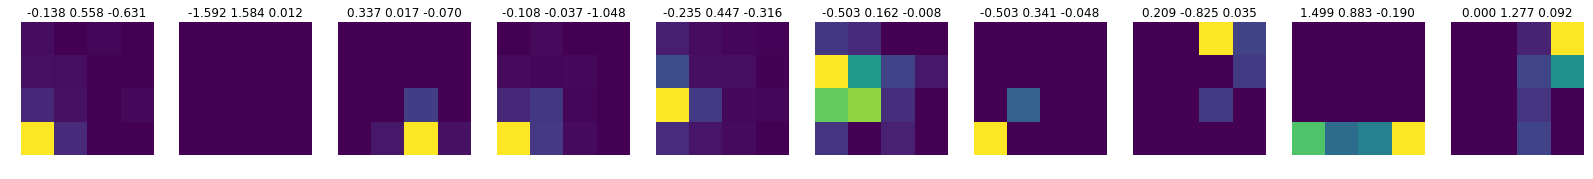

epoch: 63
a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-4.9169) tensor(1.7240e-06, grad_fn=<SumBackward0>)


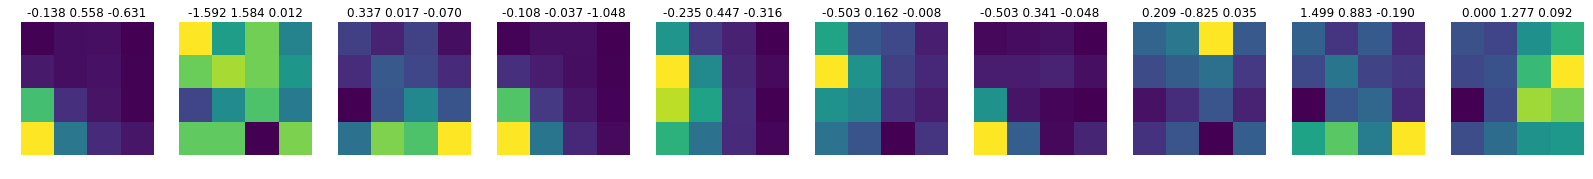

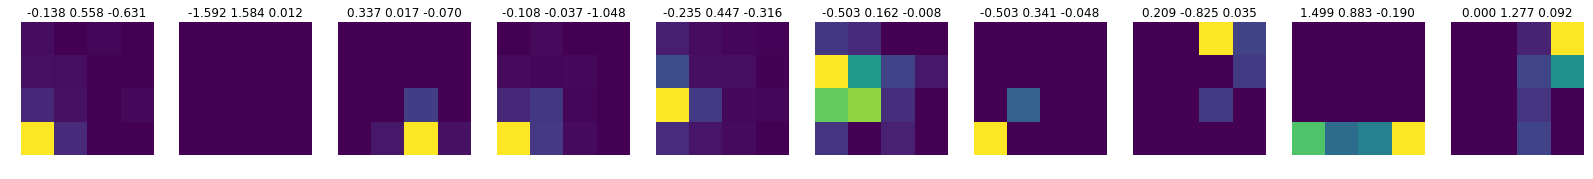

Train loss: -4.838175655226351 Batch 1500 of 500           a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-5.1658) tensor(2.6188e-06, grad_fn=<SumBackward0>)


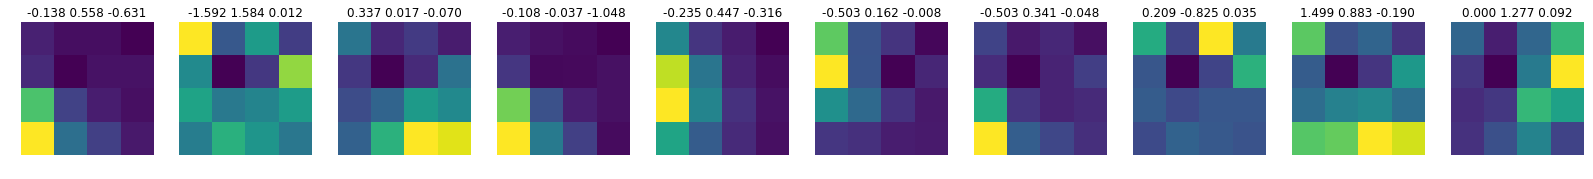

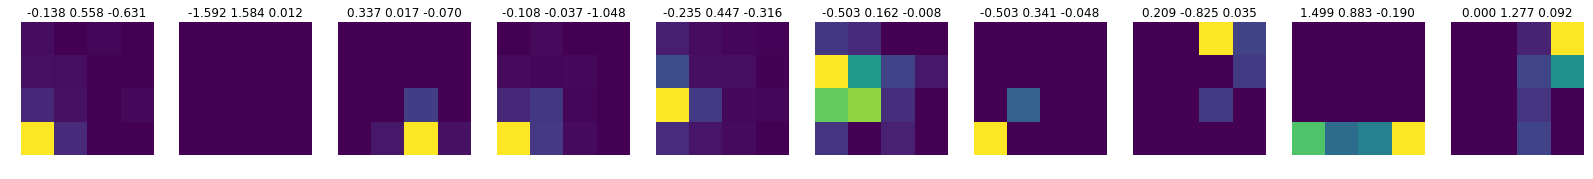

epoch: 64
a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-5.1614) tensor(2.6188e-06, grad_fn=<SumBackward0>)


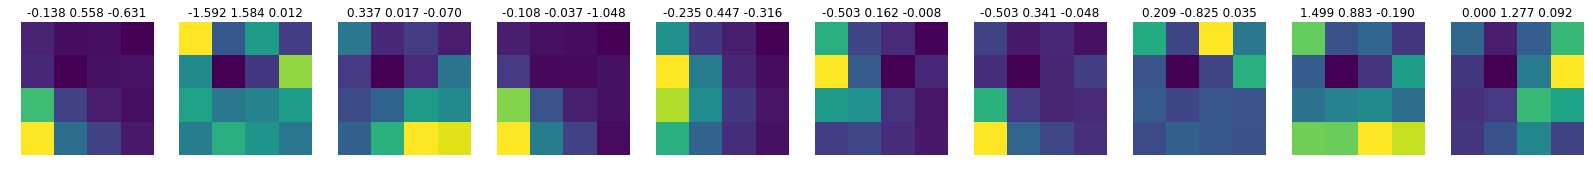

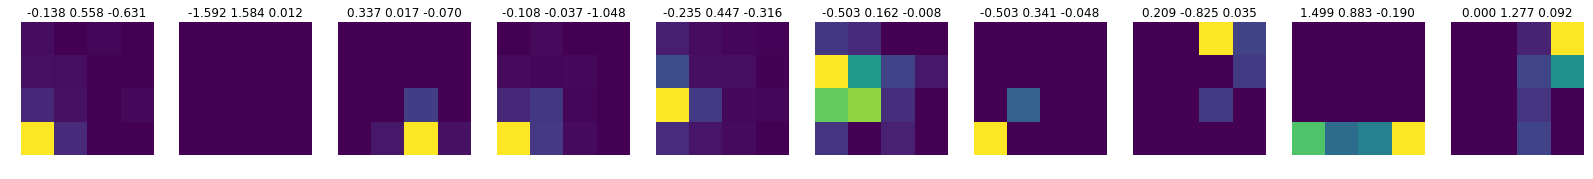

Train loss: -5.099816432930796 Batch 1500 of 500           a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-4.6781) tensor(5.9822e-06, grad_fn=<SumBackward0>)


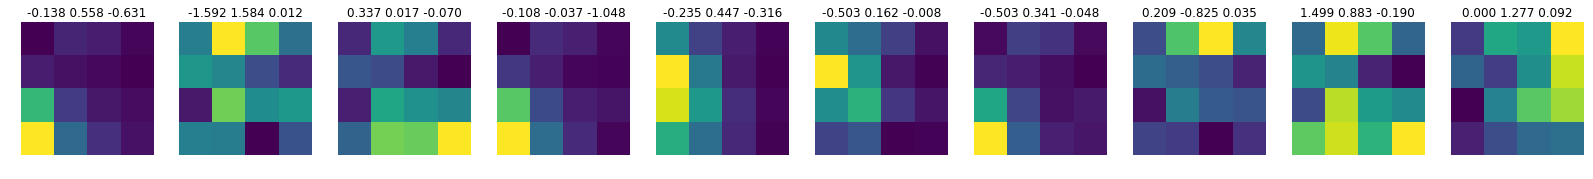

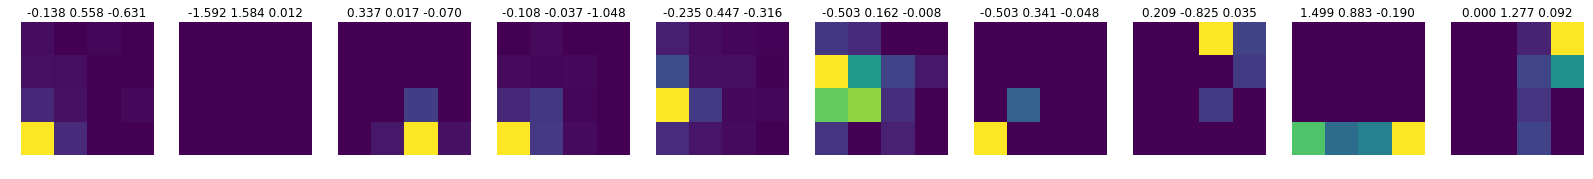

epoch: 65
a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-4.6796) tensor(5.9822e-06, grad_fn=<SumBackward0>)


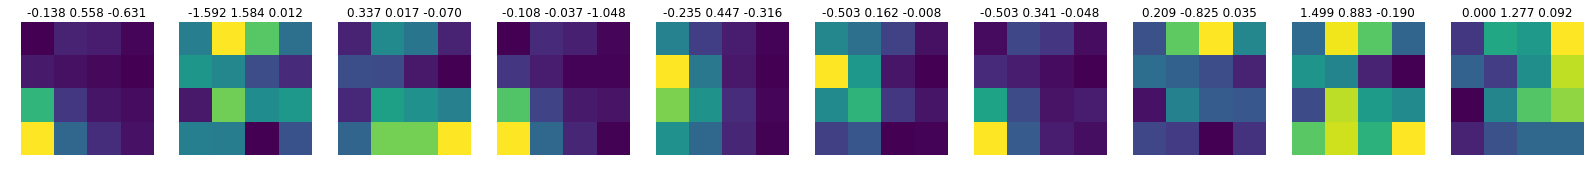

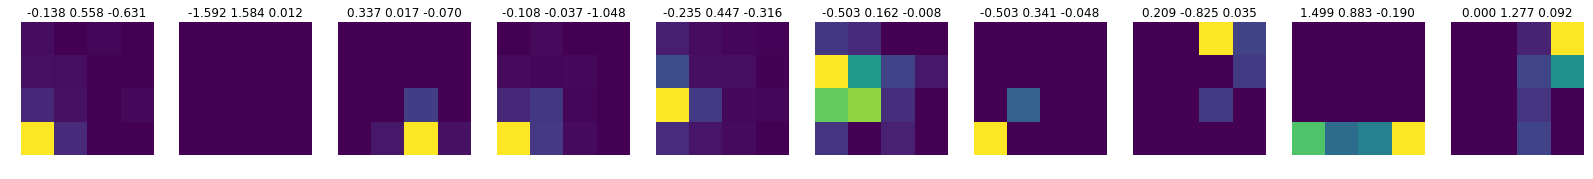

Train loss: -4.729582062645841 Batch 1500 of 500           a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-4.8564) tensor(5.2365e-06, grad_fn=<SumBackward0>)


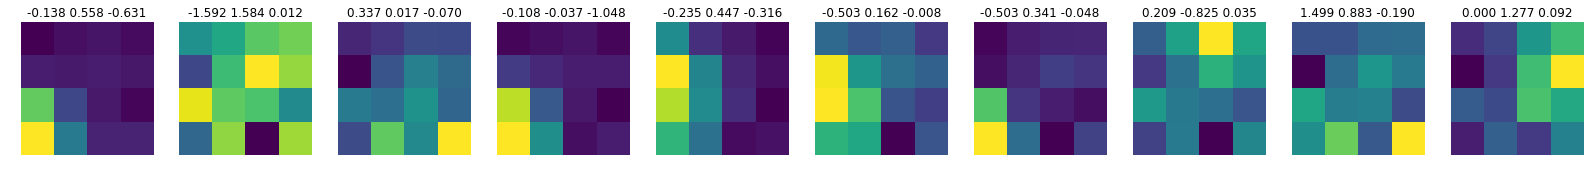

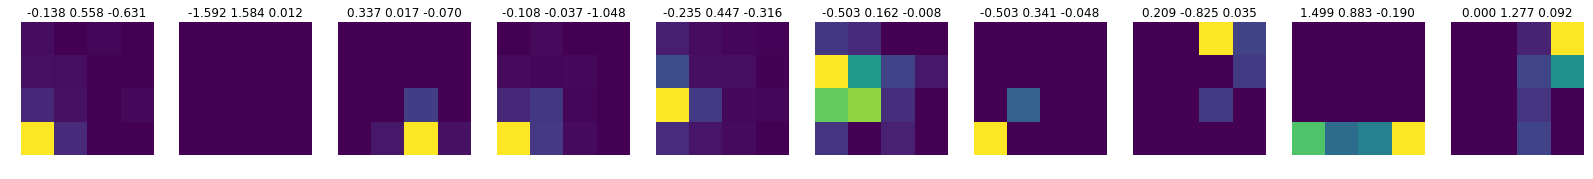

epoch: 66
a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-4.8601) tensor(5.2365e-06, grad_fn=<SumBackward0>)


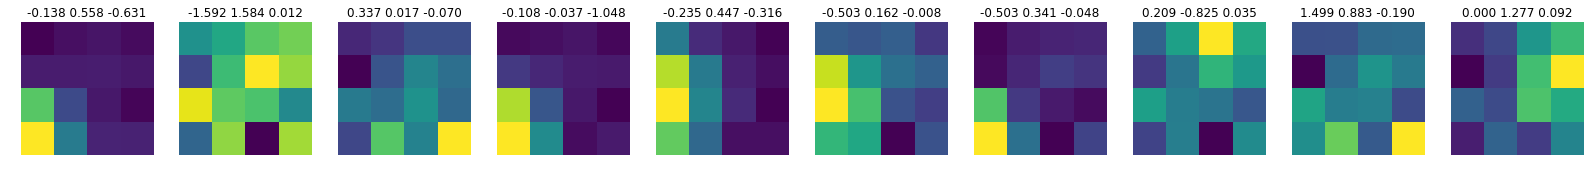

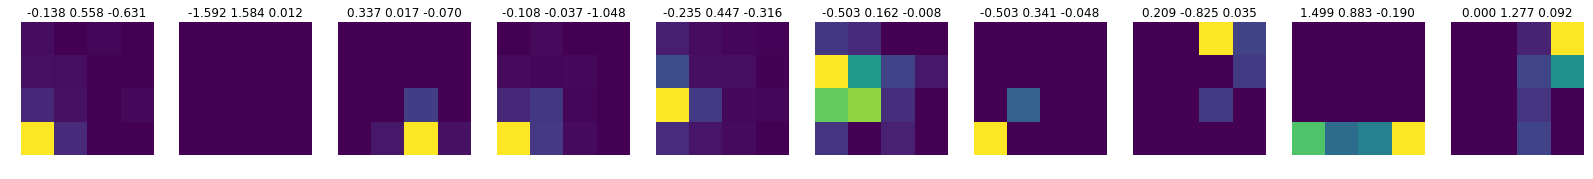

Train loss: -4.9764822186355255 Batch 1500 of 500           a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-5.0000) tensor(0.0000, grad_fn=<SumBackward0>)


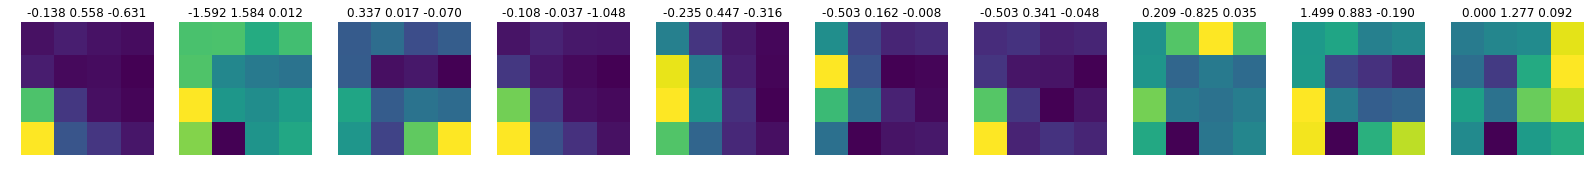

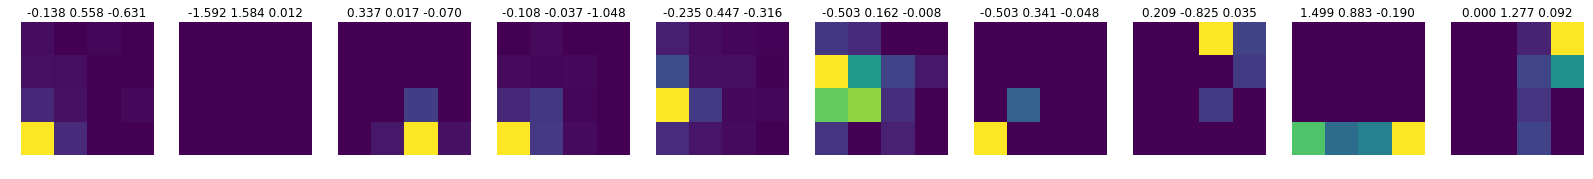

epoch: 67
a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-4.9974) tensor(0.0000, grad_fn=<SumBackward0>)


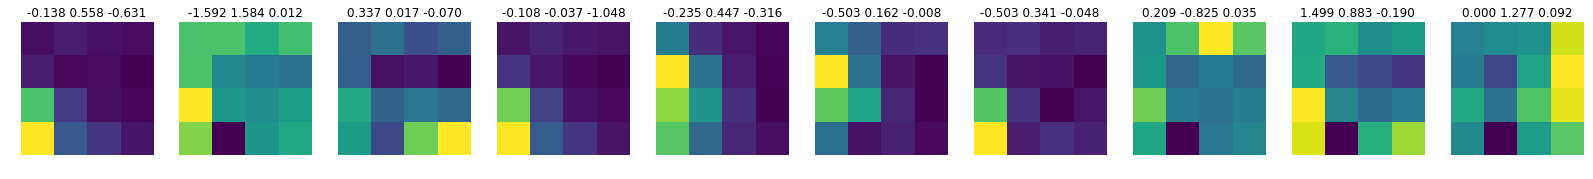

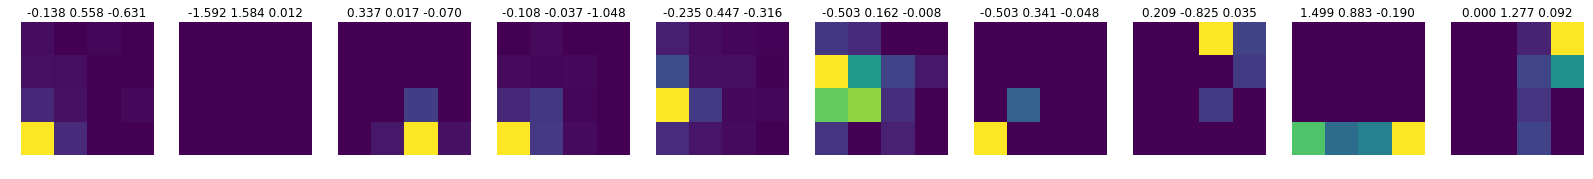

Train loss: -5.346234564547713 Batch 1500 of 500           a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-5.1003) tensor(4.4315e-06, grad_fn=<SumBackward0>)


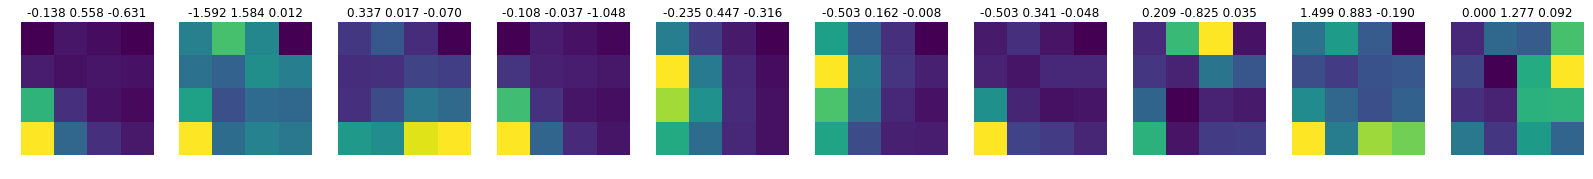

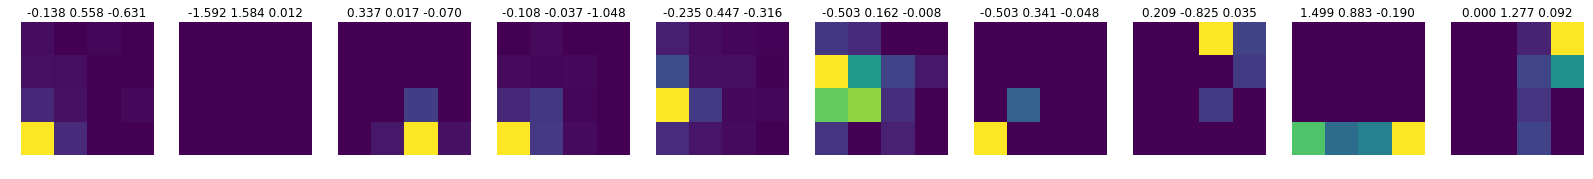

epoch: 68
a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-5.1139) tensor(4.4315e-06, grad_fn=<SumBackward0>)


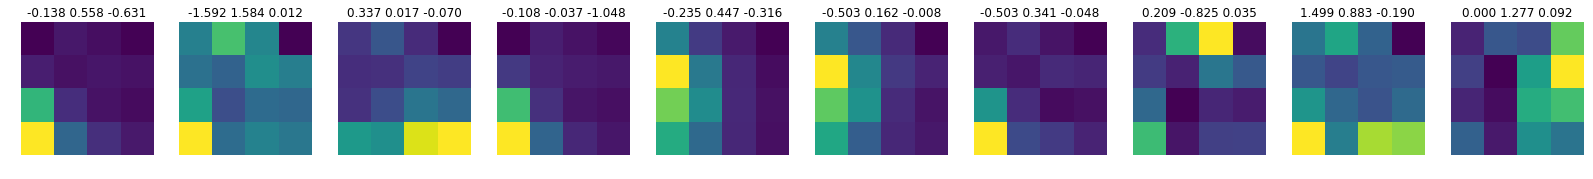

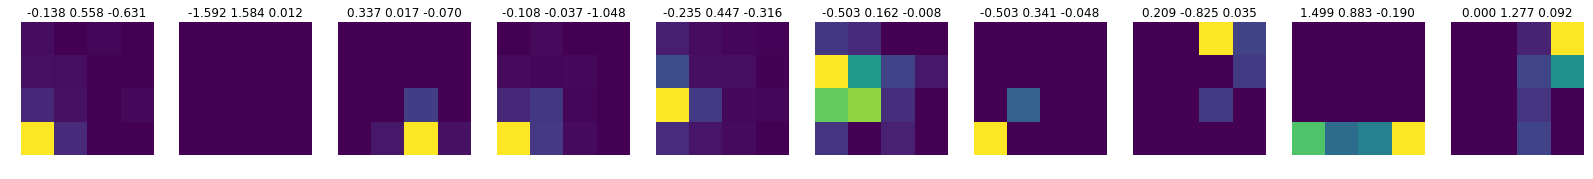

Train loss: -5.034705687036398 Batch 1500 of 500           a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-5.0769) tensor(2.6304e-06, grad_fn=<SumBackward0>)


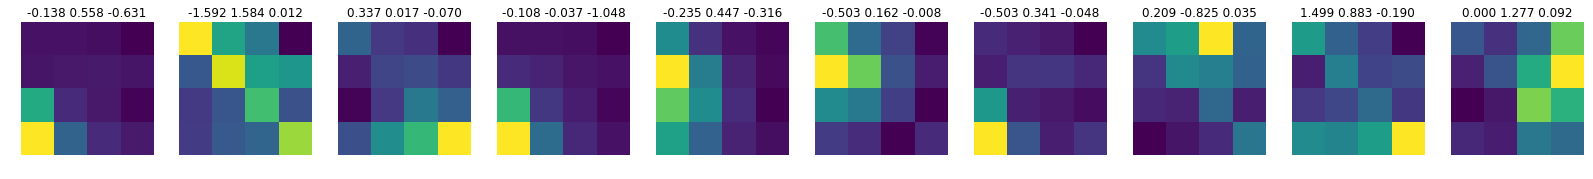

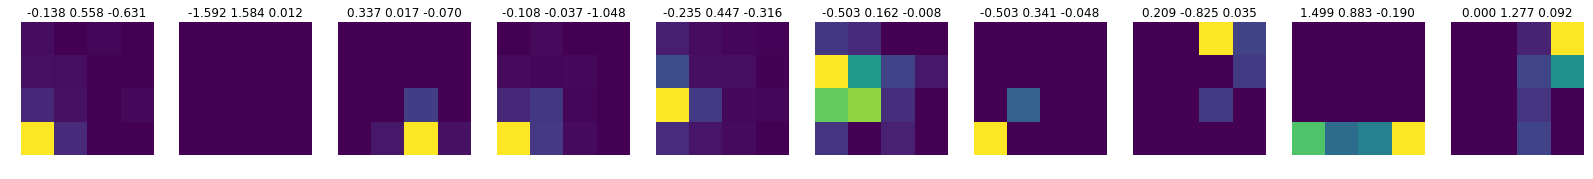

epoch: 69
a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-5.0730) tensor(2.6304e-06, grad_fn=<SumBackward0>)


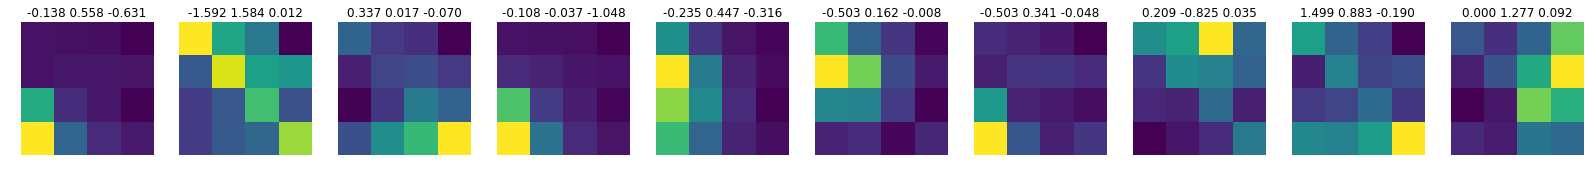

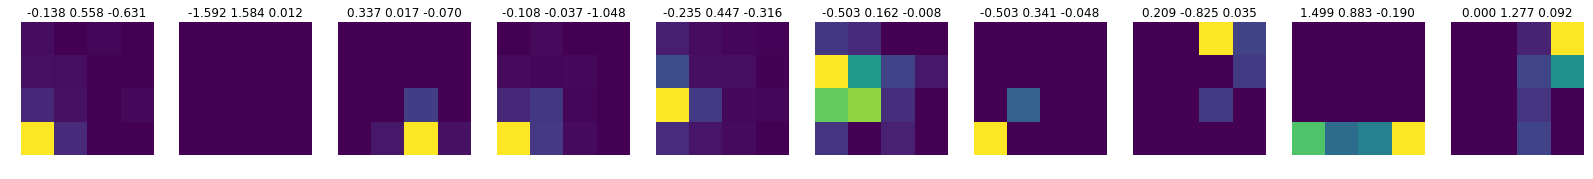

Train loss: -5.02833947347032 Batch 1500 of 500           a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-5.0491) tensor(0.0000, grad_fn=<SumBackward0>)


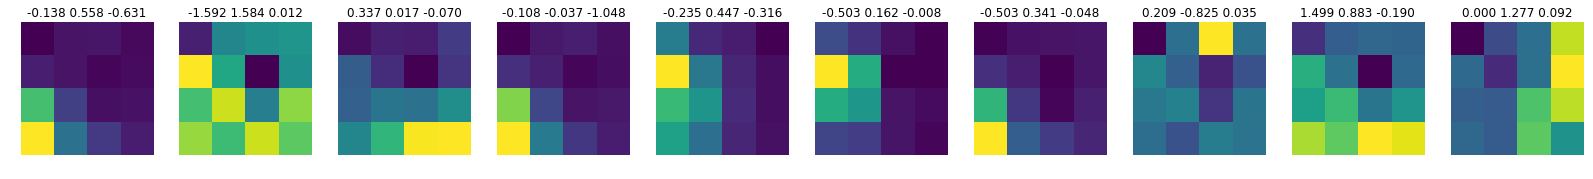

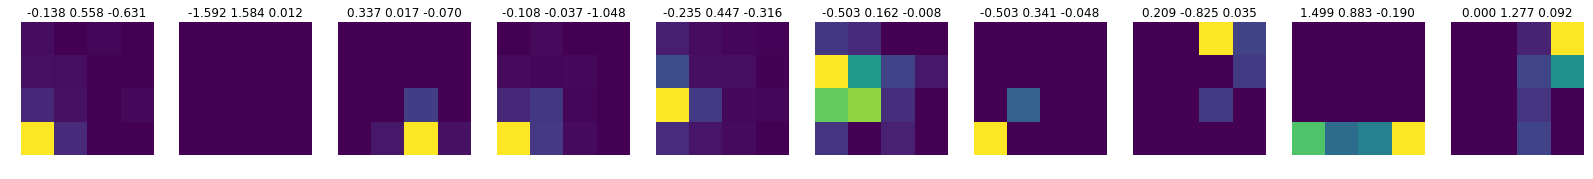

epoch: 70
a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-5.0493) tensor(0.0000, grad_fn=<SumBackward0>)


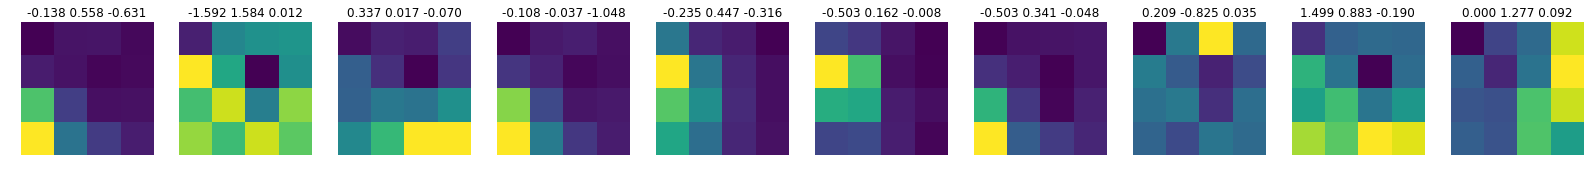

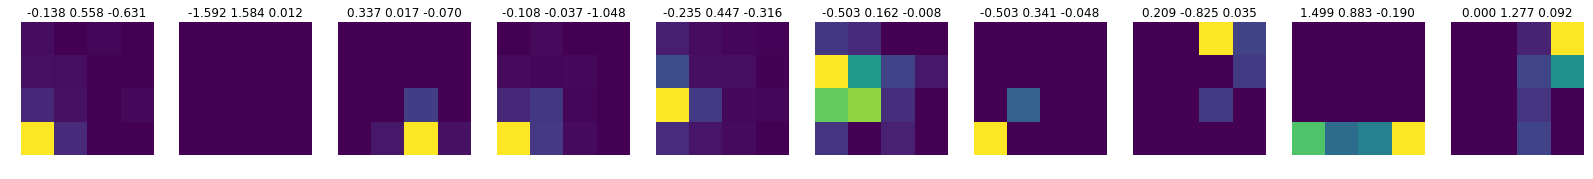

Train loss: -5.254456171269981 Batch 1500 of 500           a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-4.8745) tensor(5.2676e-06, grad_fn=<SumBackward0>)


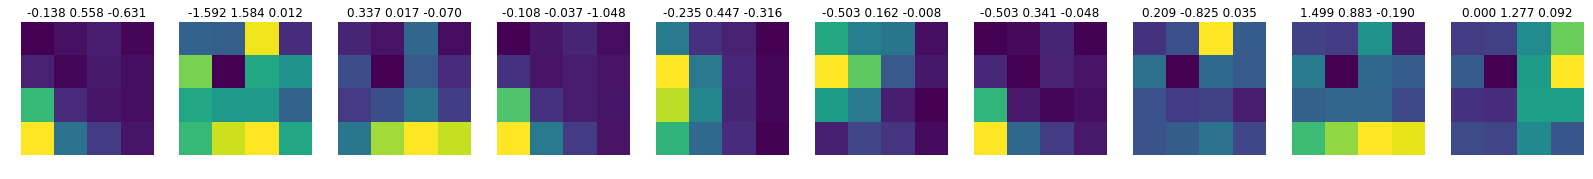

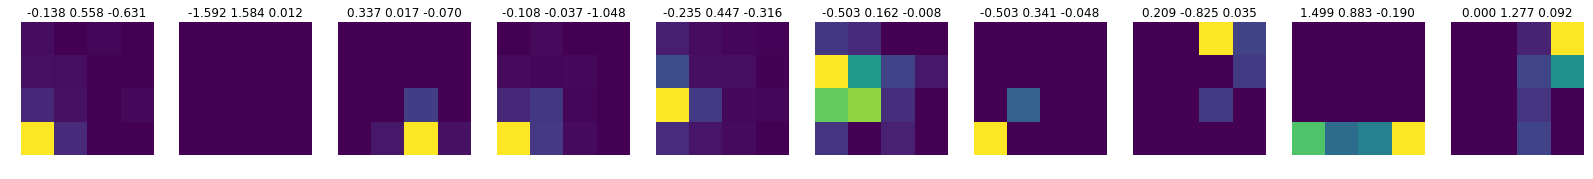

epoch: 71
a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-4.8675) tensor(5.2676e-06, grad_fn=<SumBackward0>)


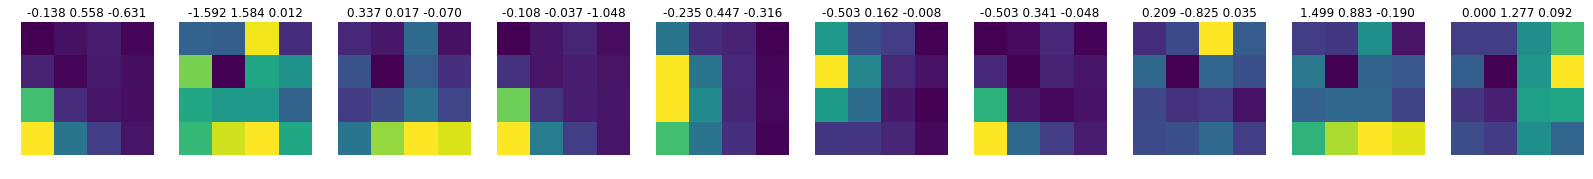

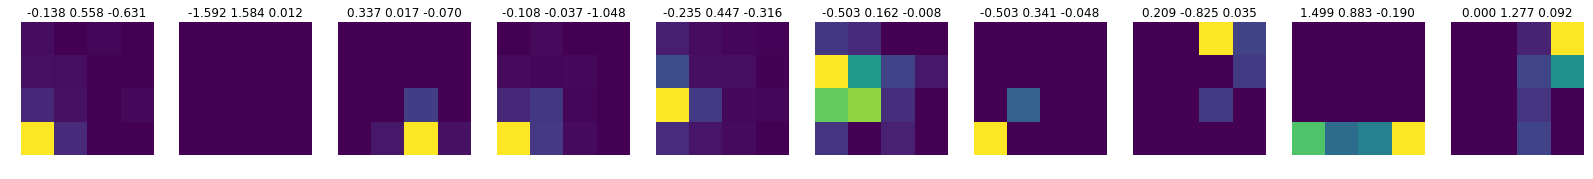

Train loss: -4.766552407746706 Batch 1500 of 500           a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-5.1410) tensor(6.7356e-06, grad_fn=<SumBackward0>)


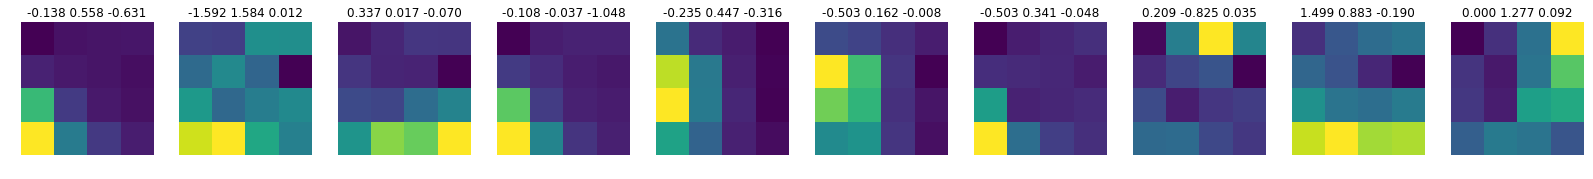

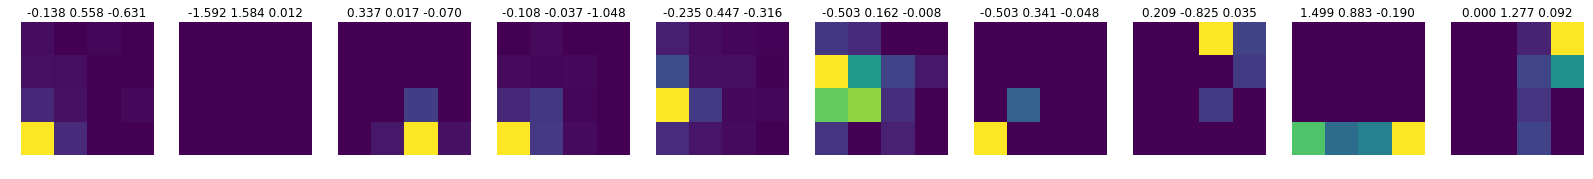

epoch: 72
a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-5.1314) tensor(6.7356e-06, grad_fn=<SumBackward0>)


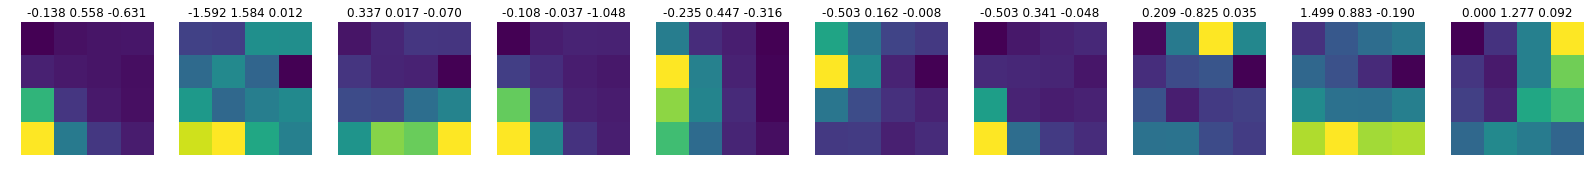

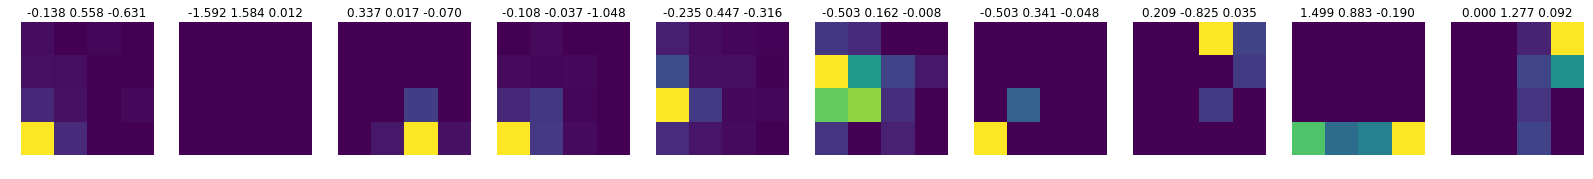

Train loss: -5.10621846446108 Batch 1500 of 500           a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-4.7317) tensor(6.5183e-06, grad_fn=<SumBackward0>)


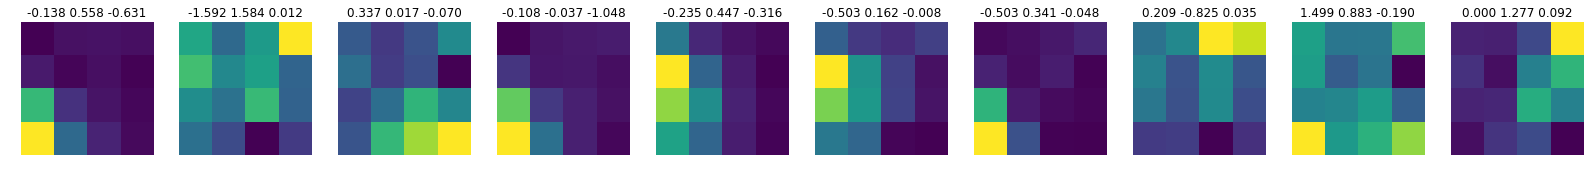

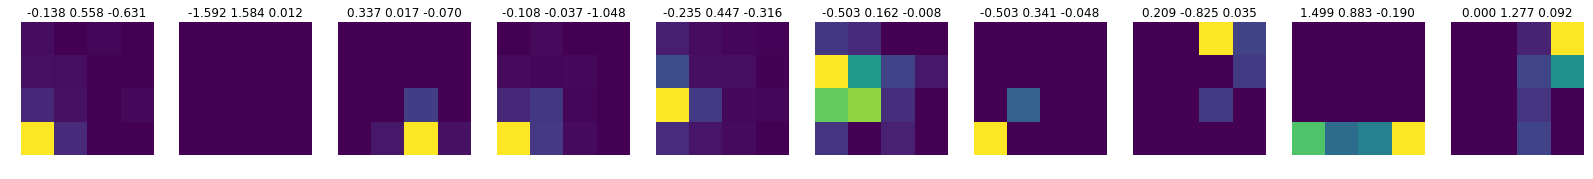

epoch: 73
a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-4.7403) tensor(6.5183e-06, grad_fn=<SumBackward0>)


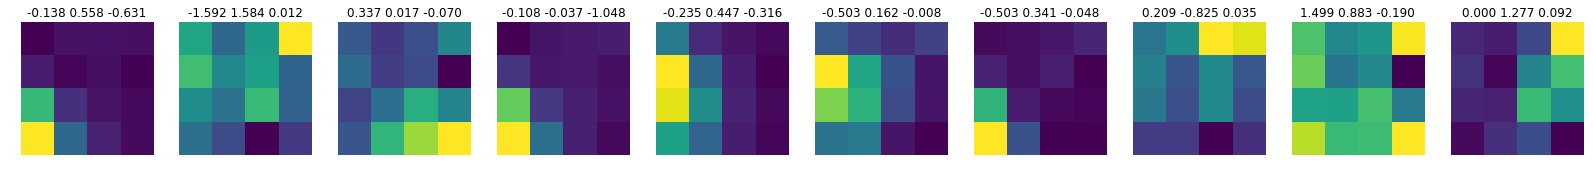

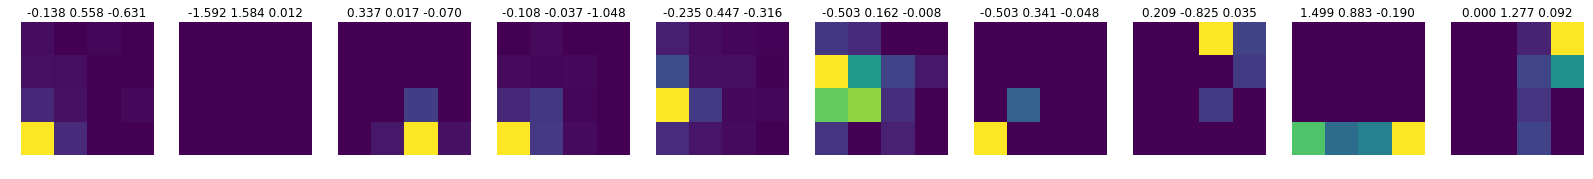

Train loss: -4.631246506251592 Batch 1500 of 500           a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-5.0241) tensor(4.7694e-06, grad_fn=<SumBackward0>)


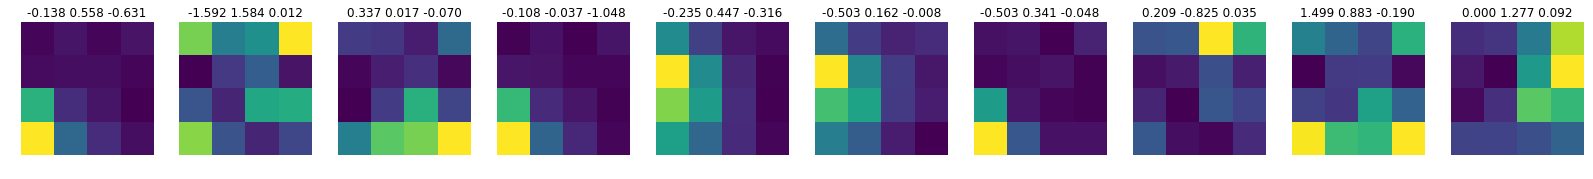

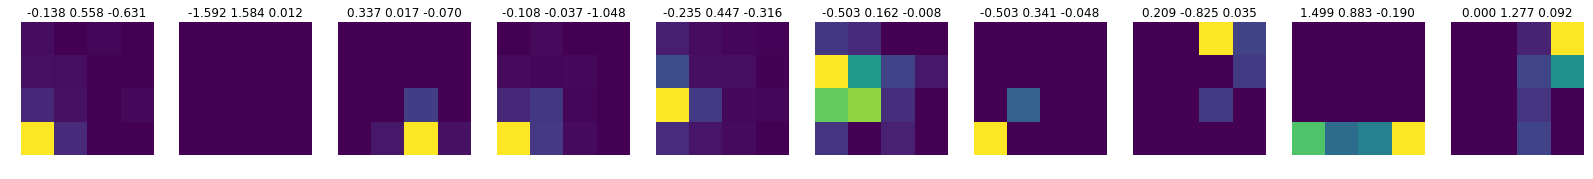

epoch: 74
a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-5.0195) tensor(4.7694e-06, grad_fn=<SumBackward0>)


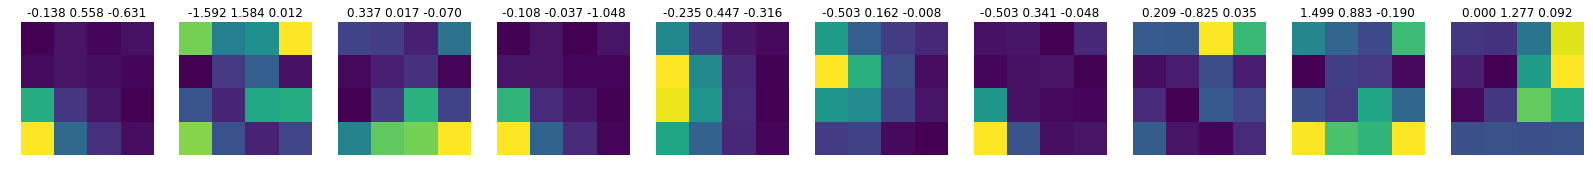

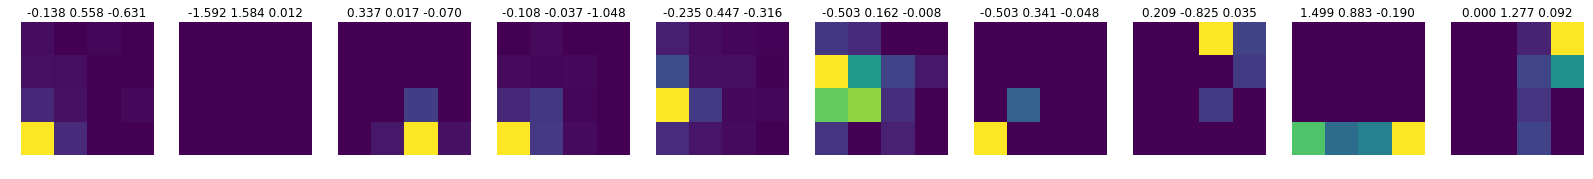

Train loss: -4.816129497229069 Batch 1500 of 500           a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-5.2640) tensor(7.2989e-06, grad_fn=<SumBackward0>)


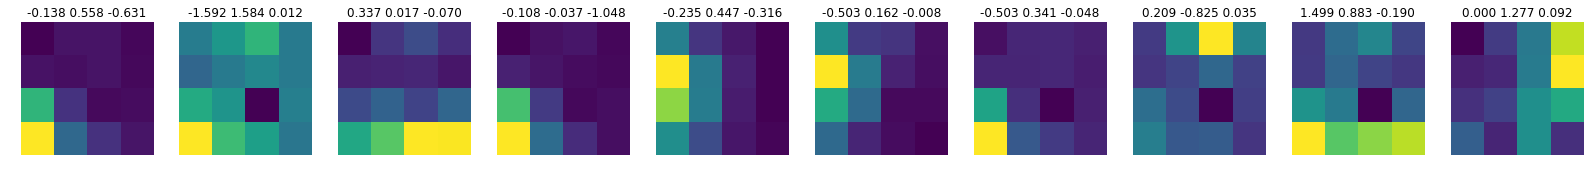

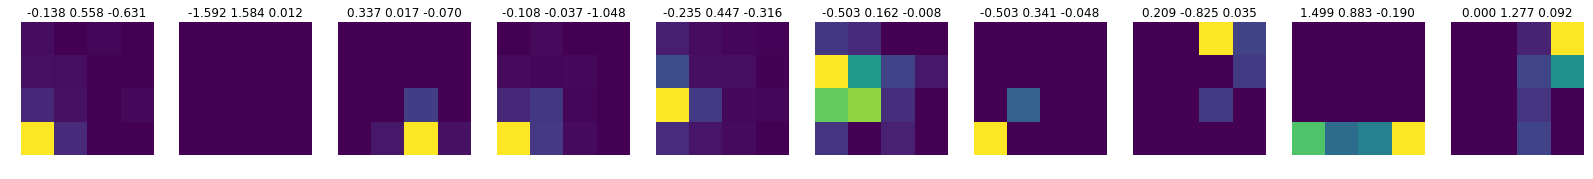

epoch: 75
a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-5.2669) tensor(7.2989e-06, grad_fn=<SumBackward0>)


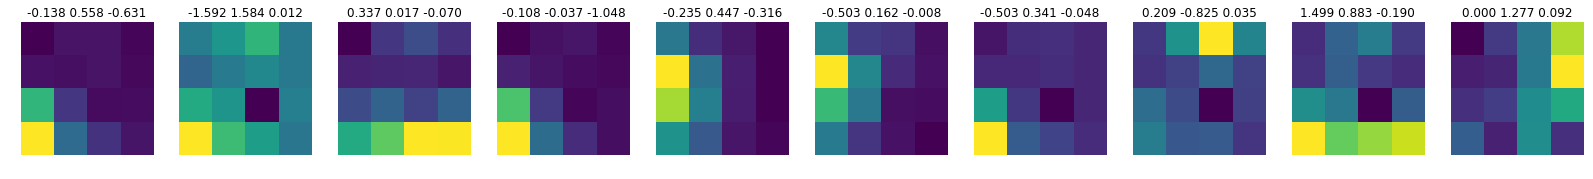

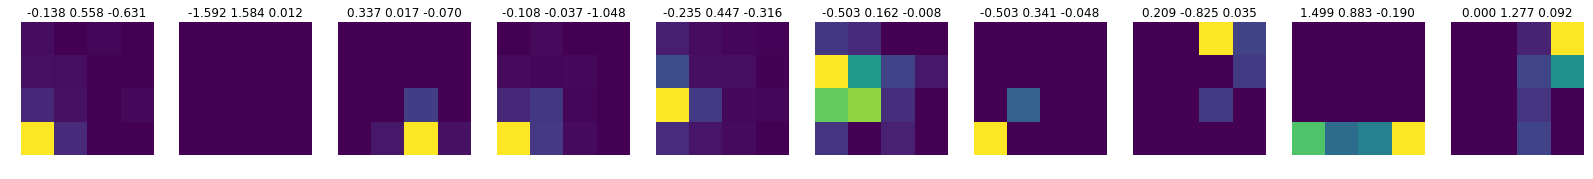

Train loss: -5.193601286596977 Batch 1500 of 500           a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-4.7584) tensor(1.7019e-06, grad_fn=<SumBackward0>)


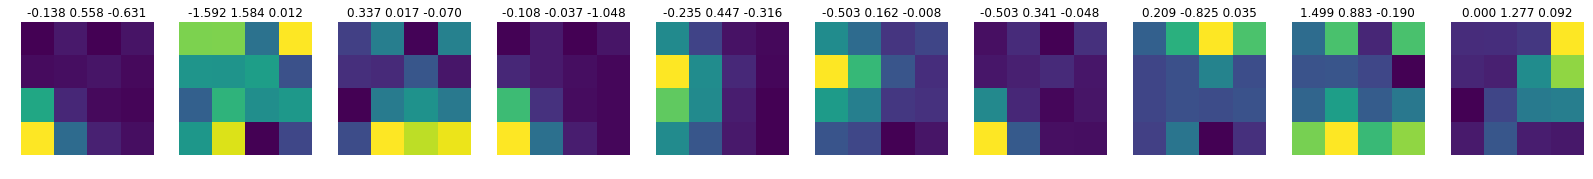

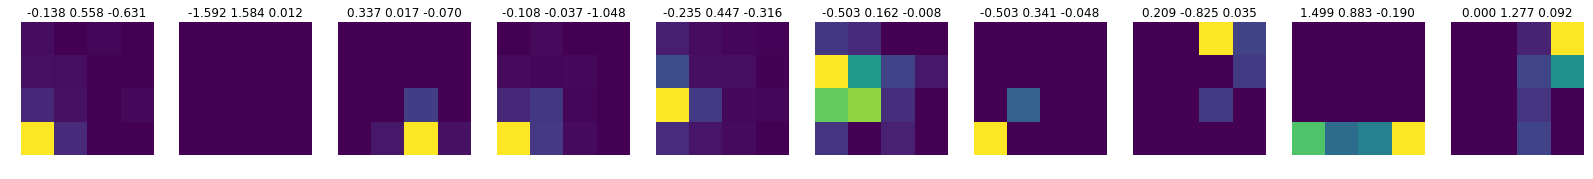

epoch: 76
a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-4.7595) tensor(1.7019e-06, grad_fn=<SumBackward0>)


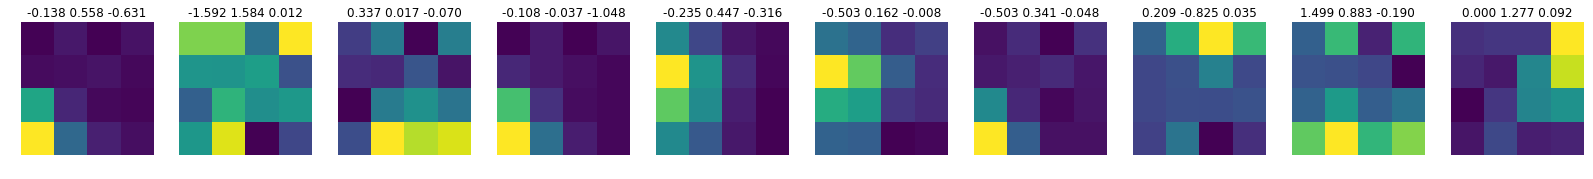

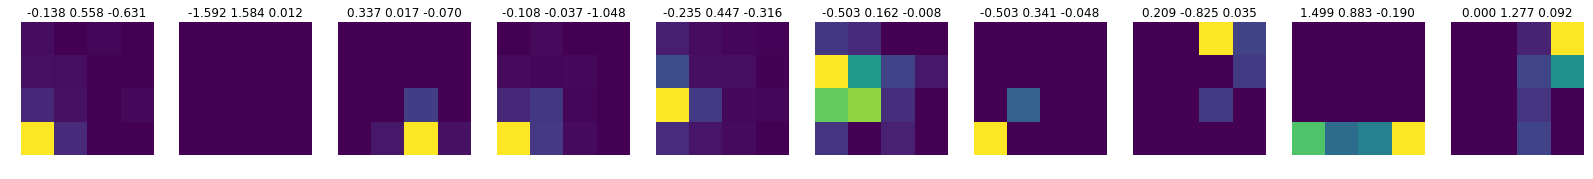

Train loss: -4.675953366404736 Batch 1500 of 500           a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-4.9401) tensor(2.1803e-06, grad_fn=<SumBackward0>)


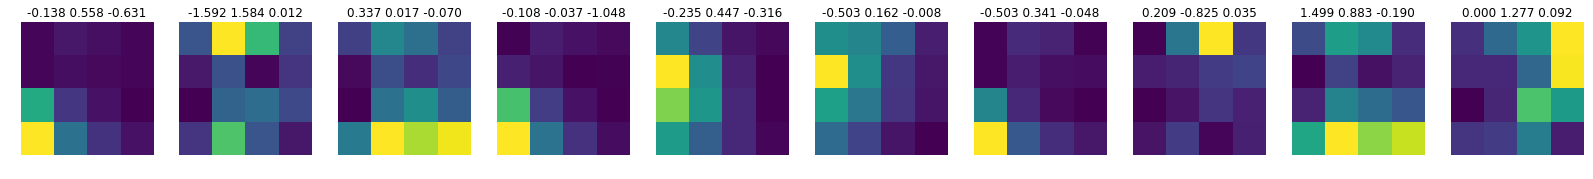

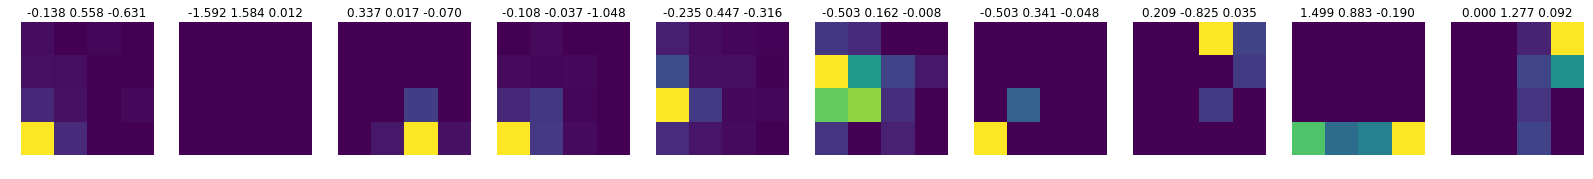

epoch: 77
a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-4.9426) tensor(2.1803e-06, grad_fn=<SumBackward0>)


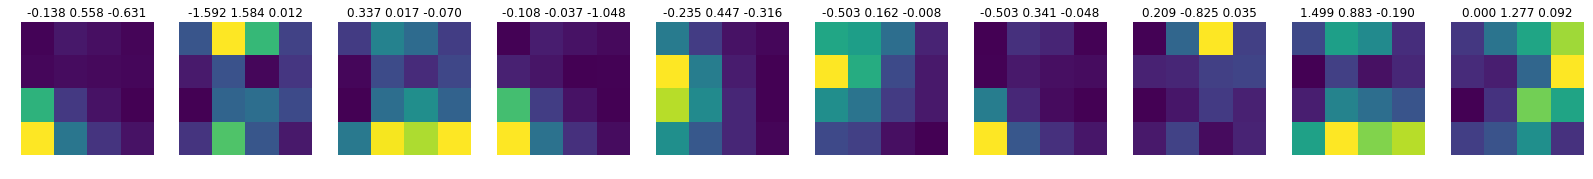

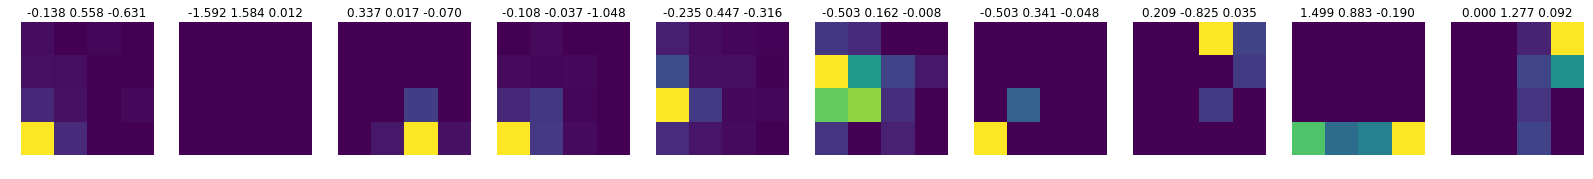

Train loss: -4.884411611258278 Batch 1500 of 500           a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-4.8675) tensor(4.8549e-06, grad_fn=<SumBackward0>)


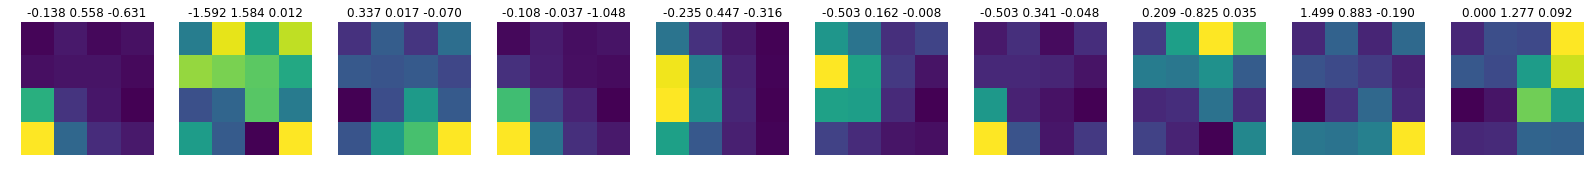

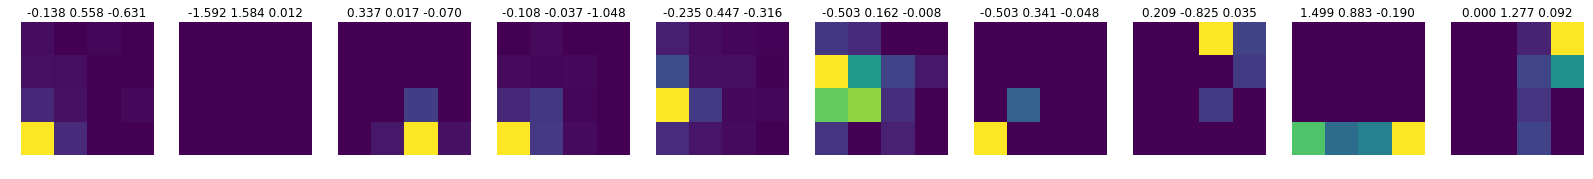

epoch: 78
a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-4.8510) tensor(4.8549e-06, grad_fn=<SumBackward0>)


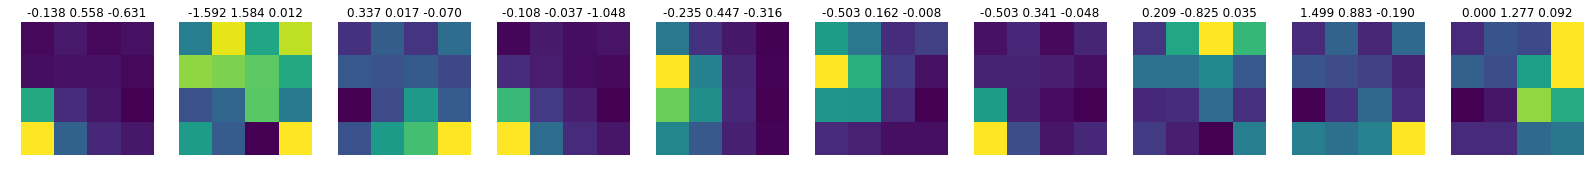

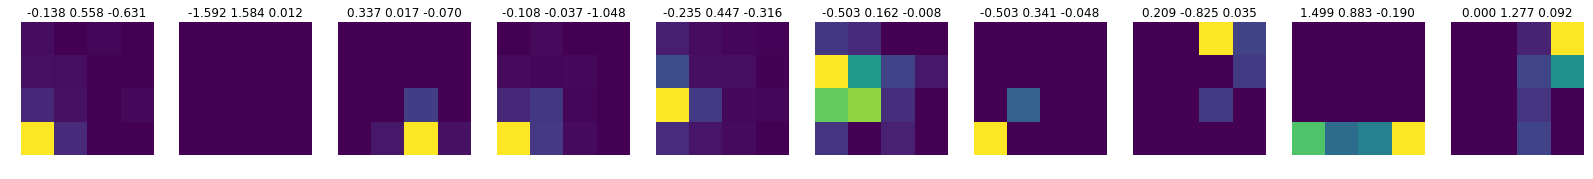

Train loss: -4.777833265842022 Batch 1500 of 500           a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-4.6538) tensor(1.9893e-06, grad_fn=<SumBackward0>)


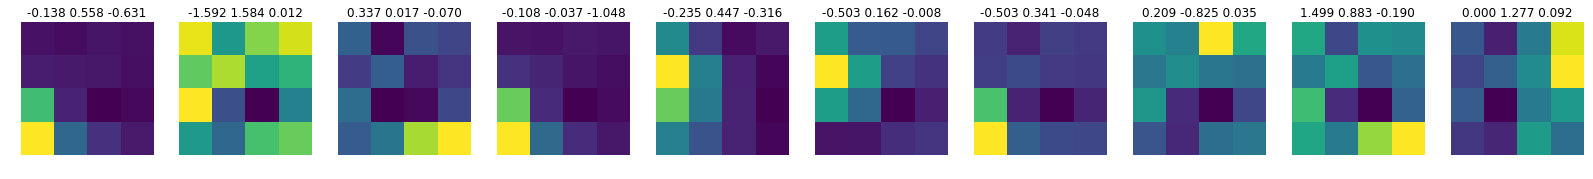

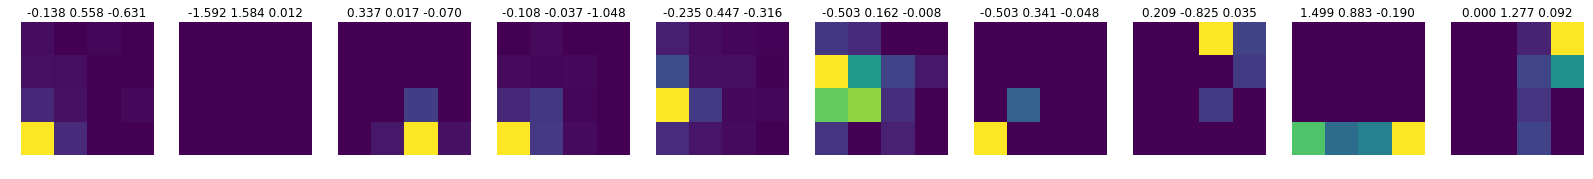

epoch: 79
a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-4.6484) tensor(1.9893e-06, grad_fn=<SumBackward0>)


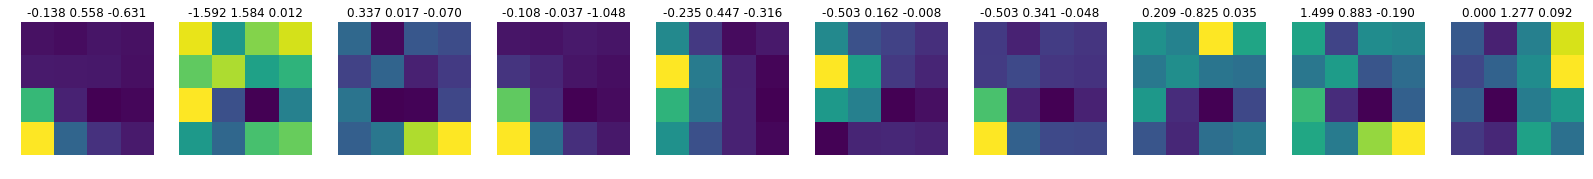

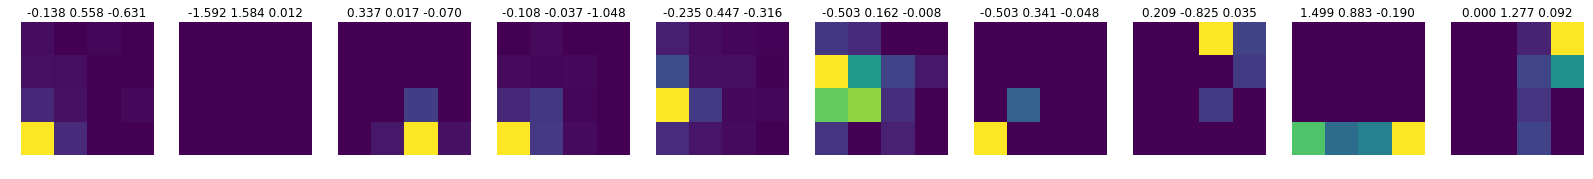

Train loss: -5.1966561418634285 Batch 1500 of 500           a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-5.0713) tensor(0.0000, grad_fn=<SumBackward0>)


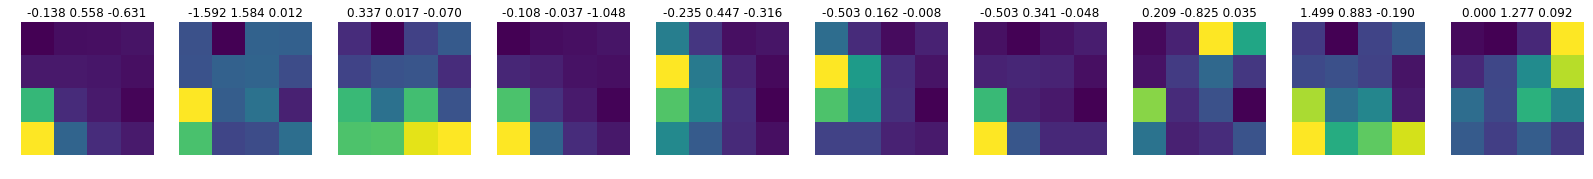

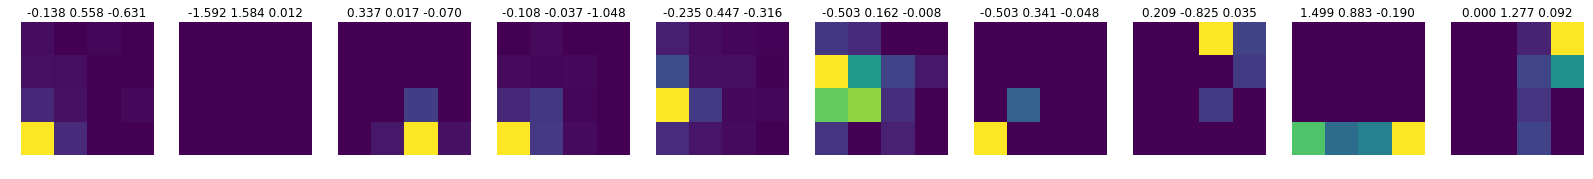

epoch: 80
a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-5.0758) tensor(0.0000, grad_fn=<SumBackward0>)


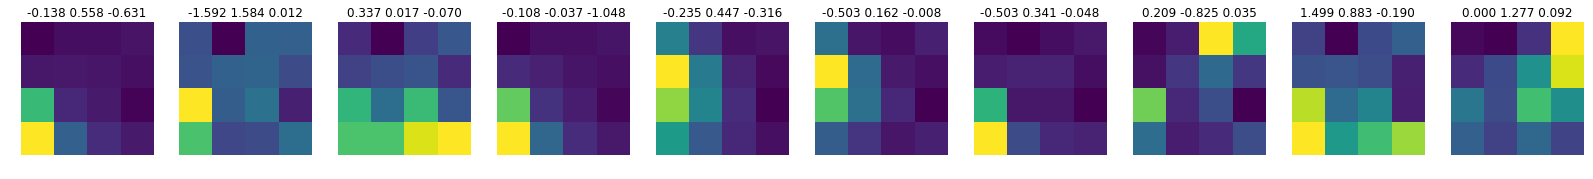

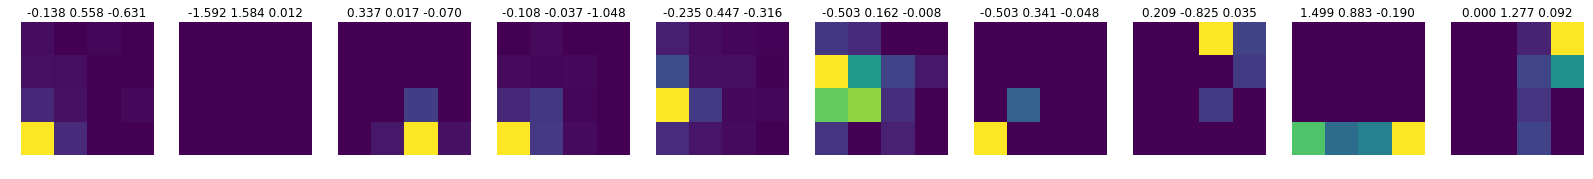

Train loss: -4.959140822334901 Batch 1500 of 500           a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-4.9594) tensor(9.0171e-07, grad_fn=<SumBackward0>)


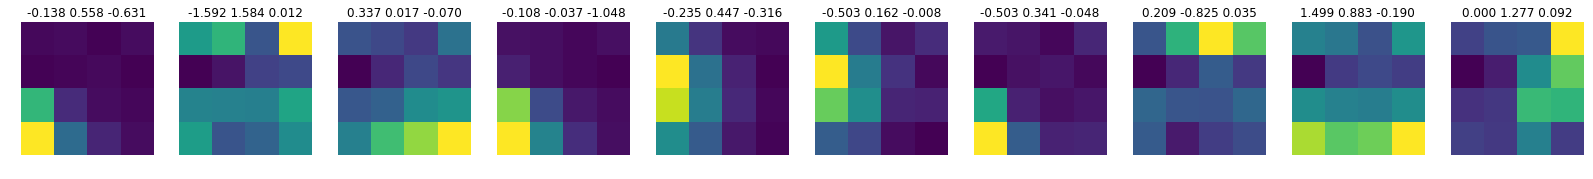

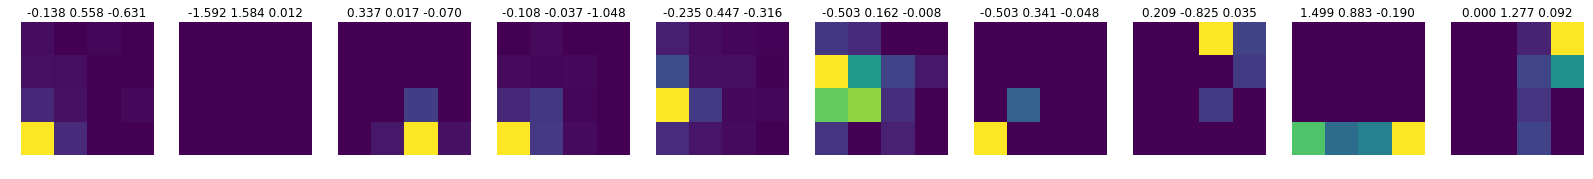

epoch: 81
a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-4.9568) tensor(9.0171e-07, grad_fn=<SumBackward0>)


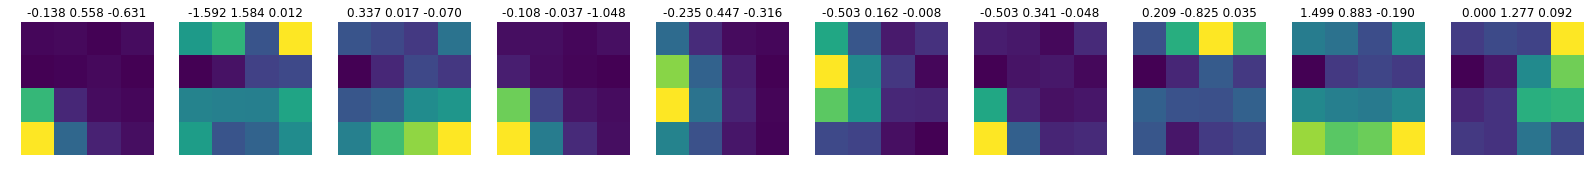

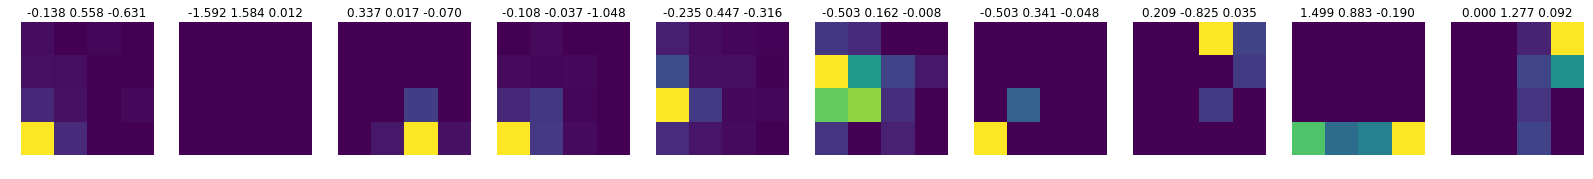

Train loss: -4.858896917573057 Batch 1500 of 500           a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-4.8261) tensor(5.6404e-06, grad_fn=<SumBackward0>)


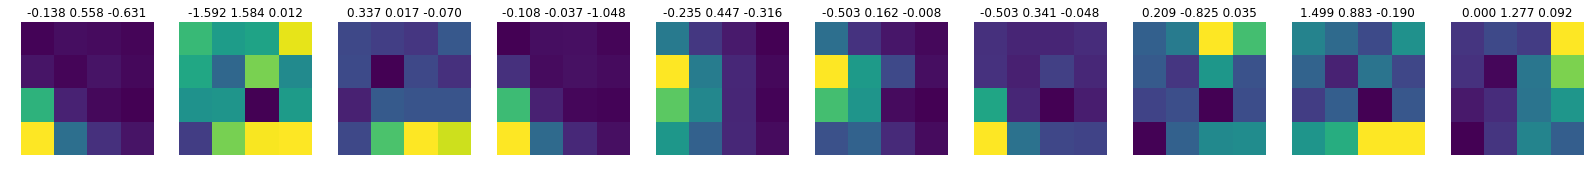

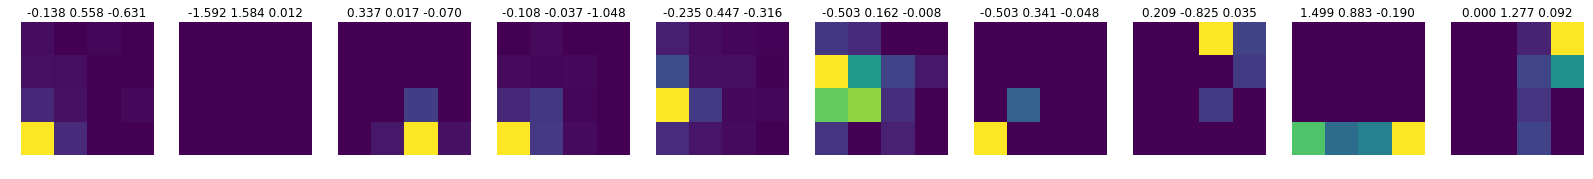

epoch: 82
a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-4.8289) tensor(5.6404e-06, grad_fn=<SumBackward0>)


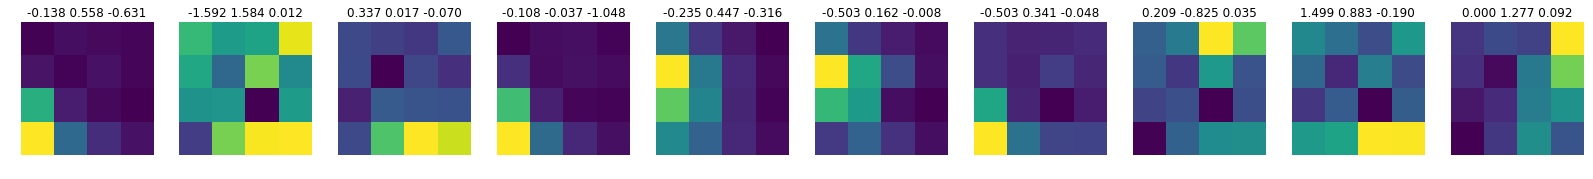

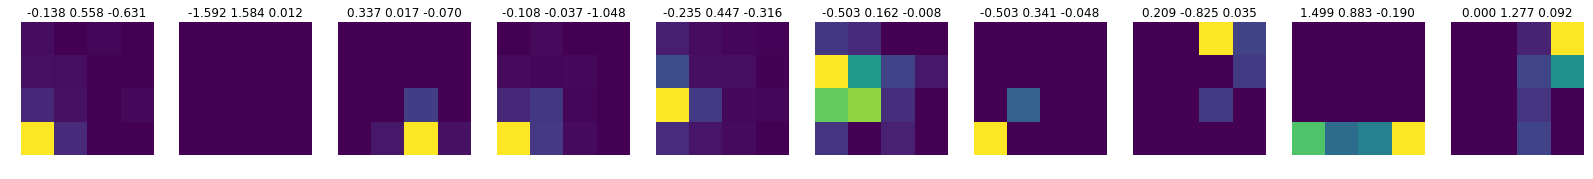

Train loss: -4.80662912291428 Batch 1500 of 500           a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-4.9750) tensor(6.2315e-06, grad_fn=<SumBackward0>)


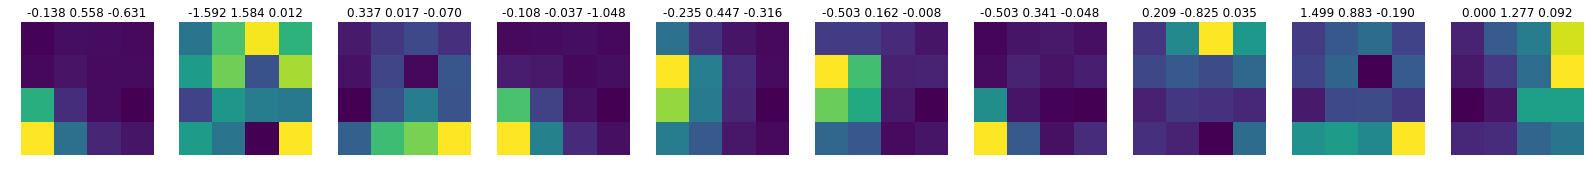

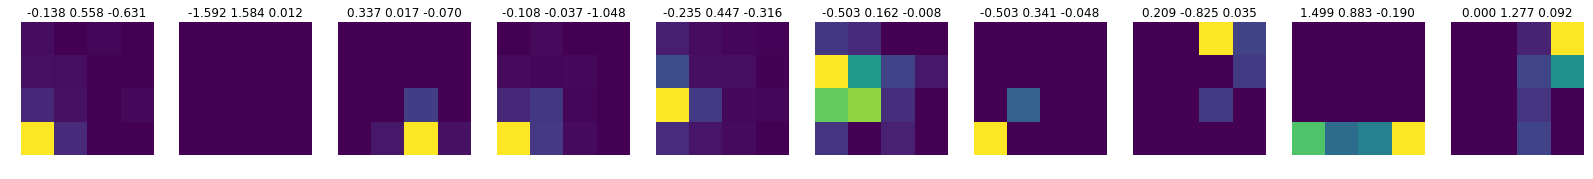

epoch: 83
a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-4.9900) tensor(6.2315e-06, grad_fn=<SumBackward0>)


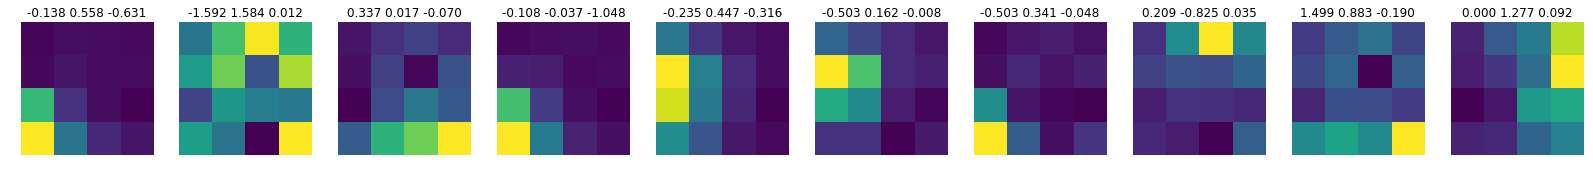

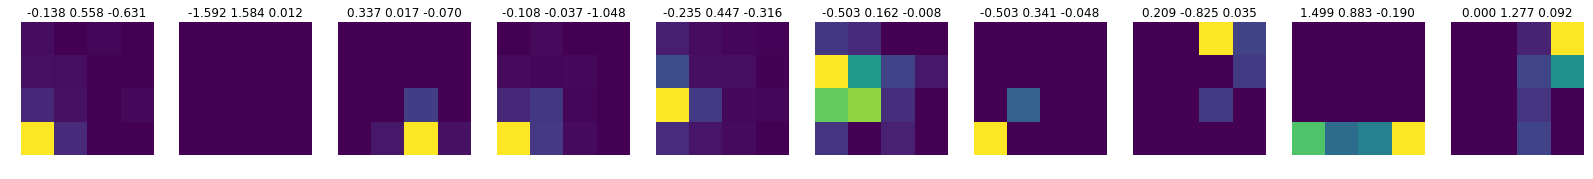

Train loss: -4.96511504470957 Batch 1500 of 500           a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-4.8700) tensor(1.0026e-06, grad_fn=<SumBackward0>)


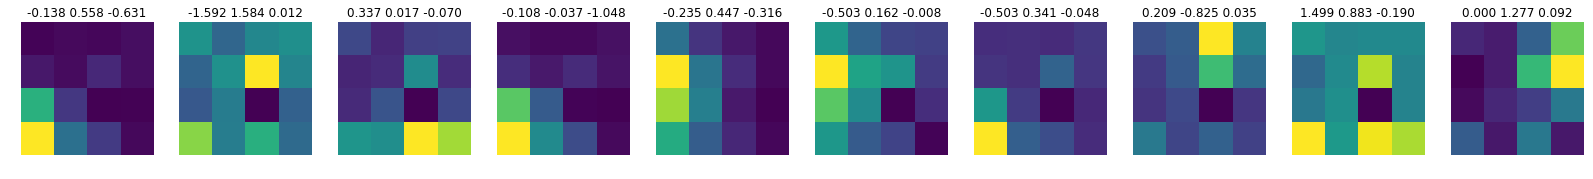

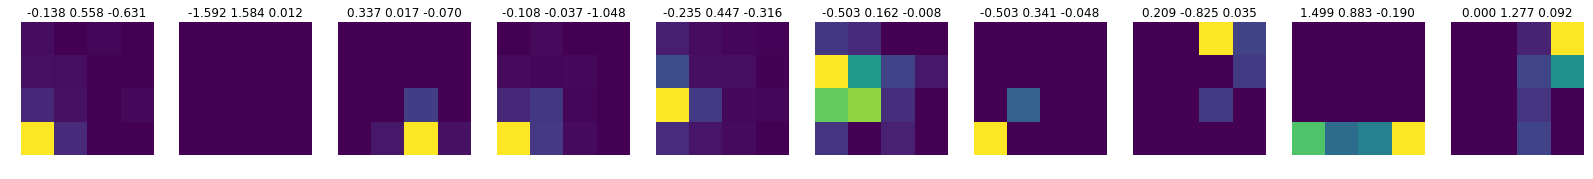

epoch: 84
a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-4.8735) tensor(1.0026e-06, grad_fn=<SumBackward0>)


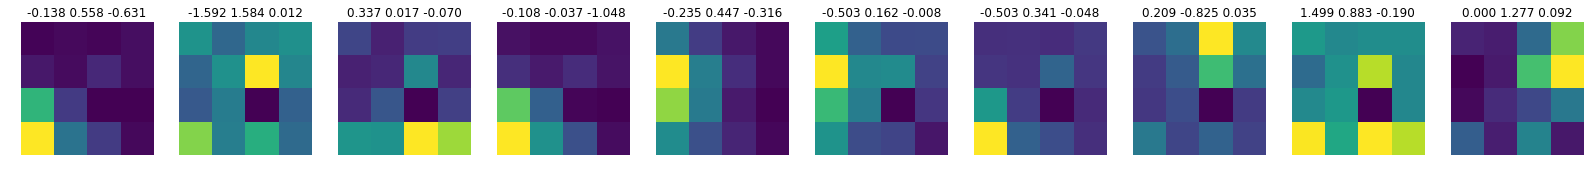

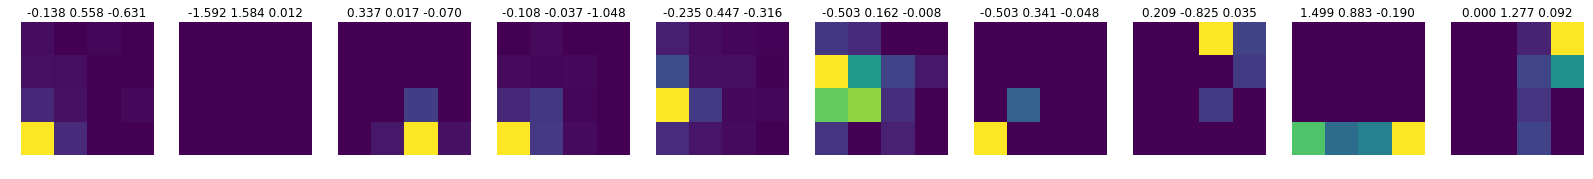

Train loss: -4.873981079005195 Batch 1500 of 500           a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-5.0768) tensor(6.5386e-06, grad_fn=<SumBackward0>)


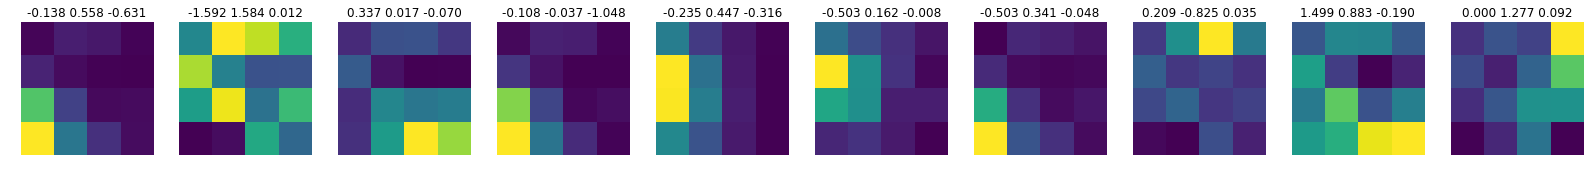

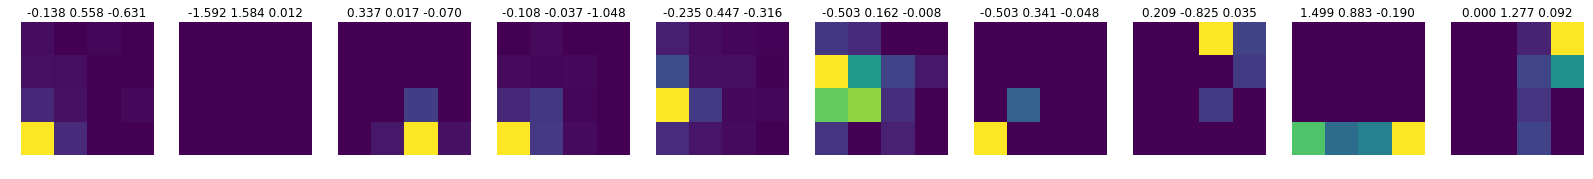

epoch: 85
a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-5.0784) tensor(6.5386e-06, grad_fn=<SumBackward0>)


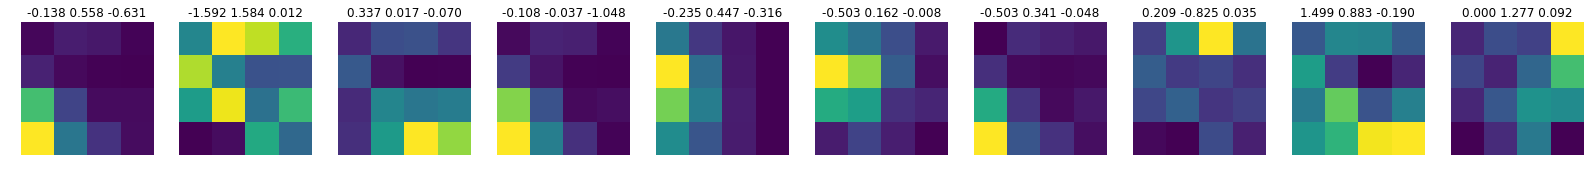

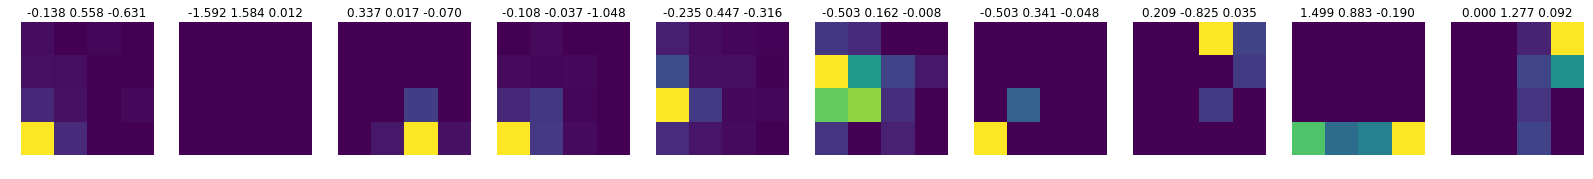

Train loss: -4.971916775398968 Batch 1500 of 500           a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-4.9645) tensor(9.7724e-06, grad_fn=<SumBackward0>)


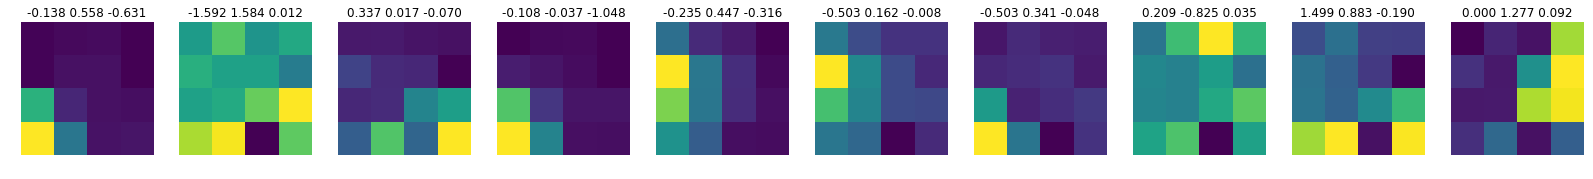

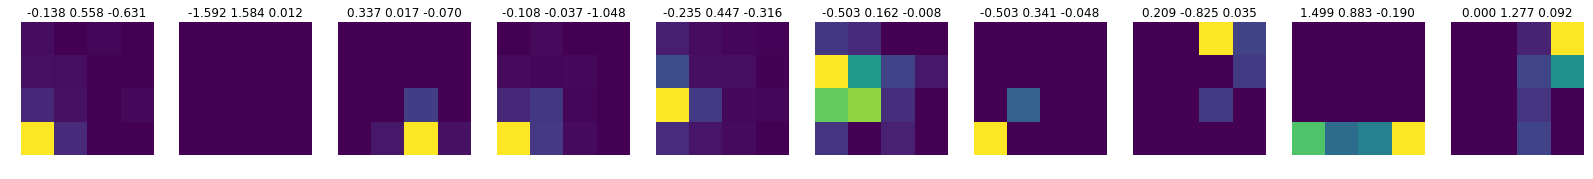

epoch: 86
a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-4.9562) tensor(9.7724e-06, grad_fn=<SumBackward0>)


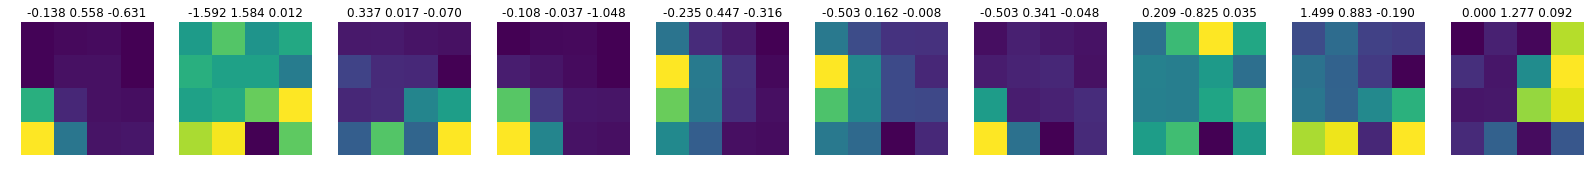

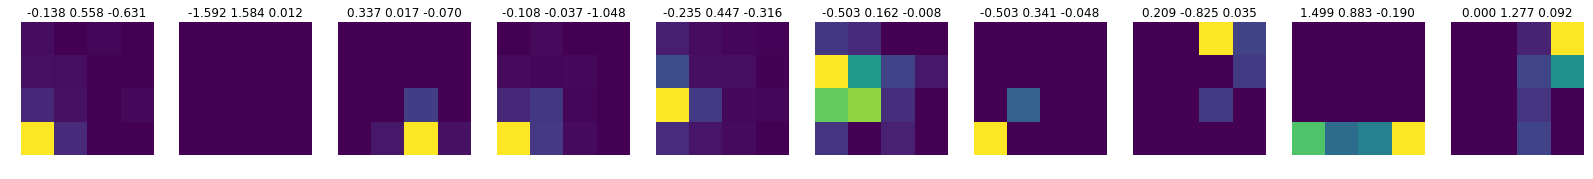

Train loss: -4.954063657037835 Batch 1500 of 500           a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-5.1163) tensor(6.9946e-06, grad_fn=<SumBackward0>)


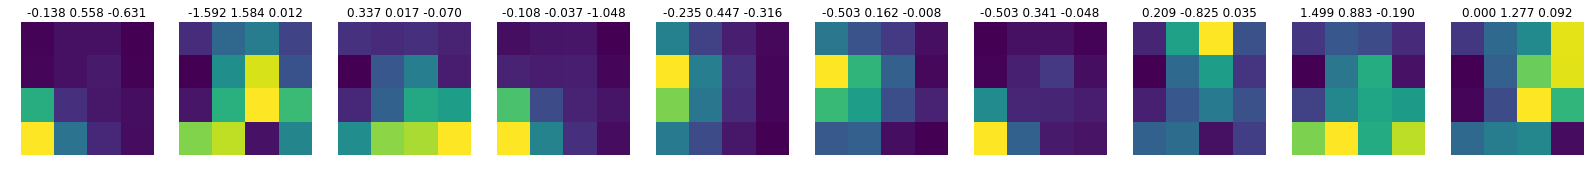

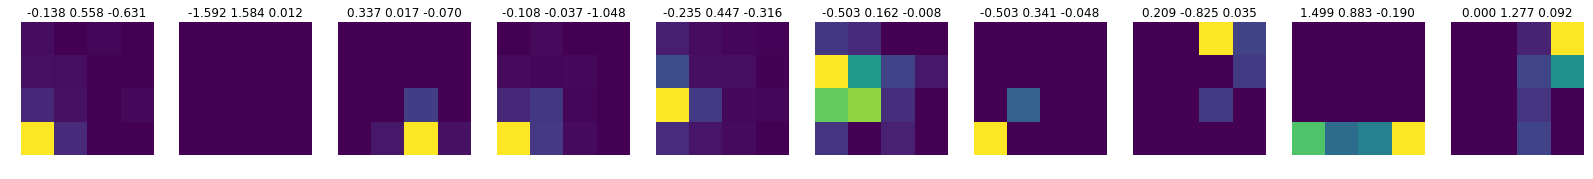

epoch: 87
a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-5.1074) tensor(6.9946e-06, grad_fn=<SumBackward0>)


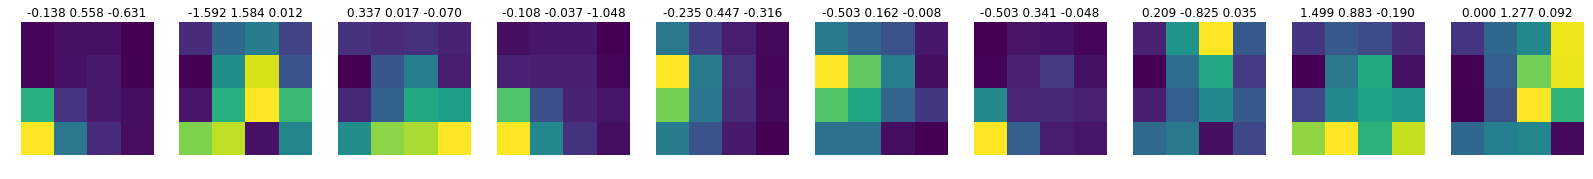

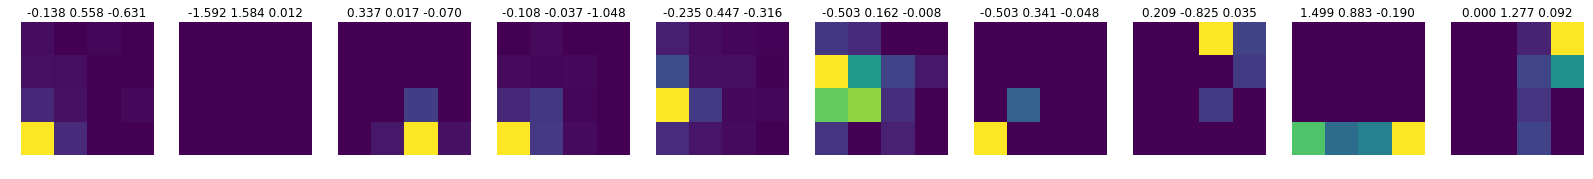

Train loss: -5.074583535262982 Batch 1500 of 500           a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-4.7711) tensor(2.5577e-06, grad_fn=<SumBackward0>)


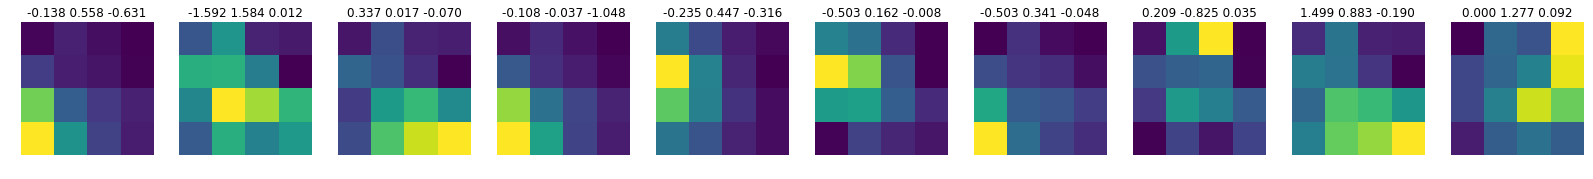

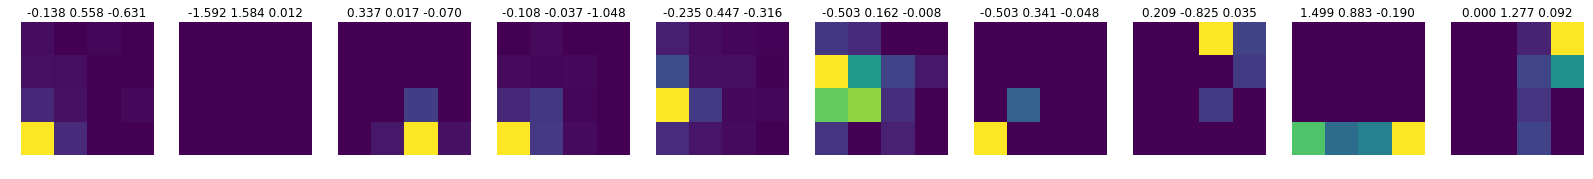

epoch: 88
a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-4.7761) tensor(2.5577e-06, grad_fn=<SumBackward0>)


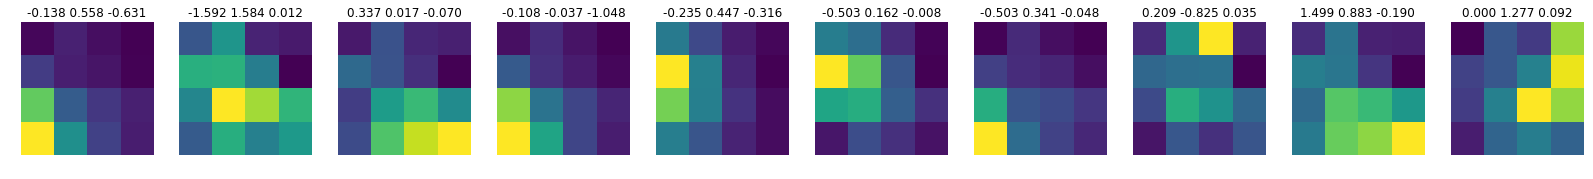

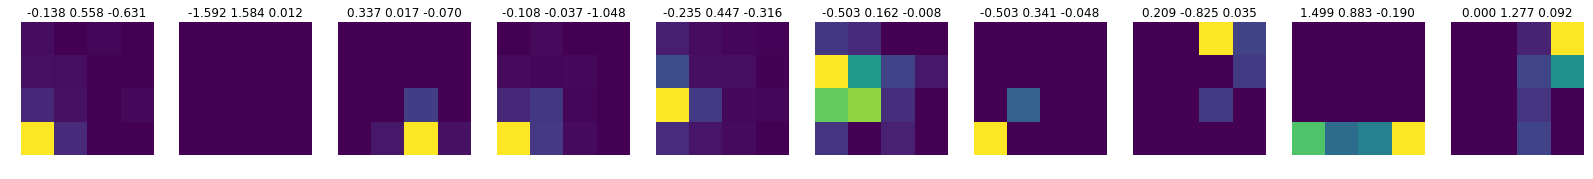

Train loss: -4.666227021521123 Batch 1500 of 500           a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-5.0892) tensor(0.0001, grad_fn=<SumBackward0>)


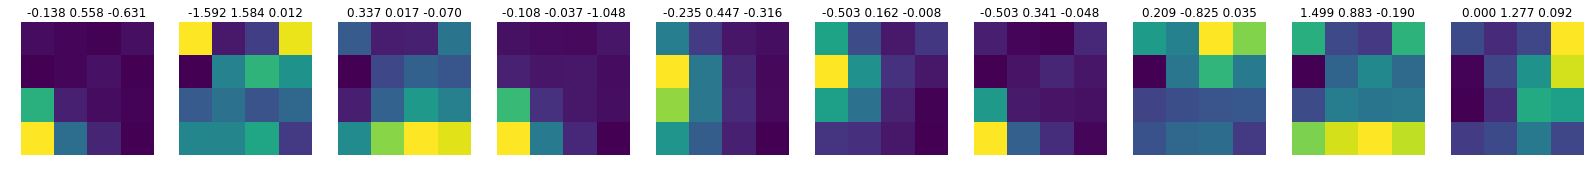

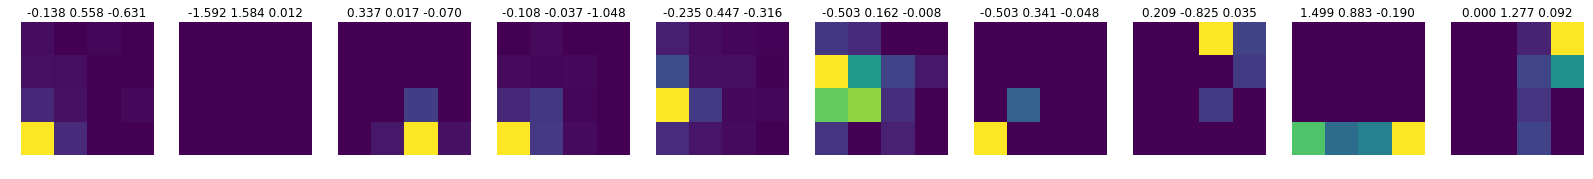

epoch: 89
a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-5.0790) tensor(0.0001, grad_fn=<SumBackward0>)


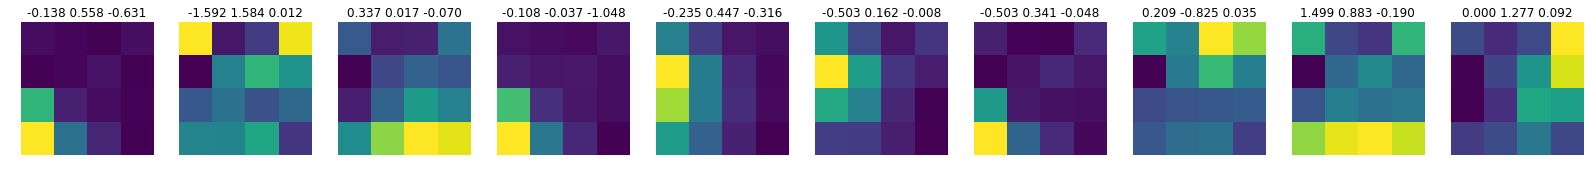

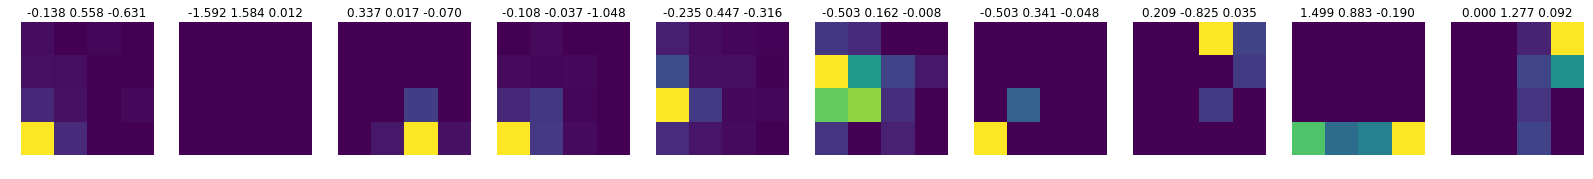

Train loss: -5.124443683756329 Batch 1500 of 500           a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-4.7937) tensor(0.0000, grad_fn=<SumBackward0>)


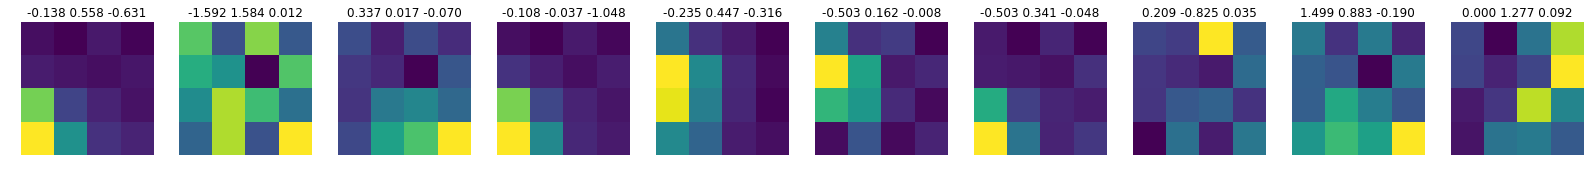

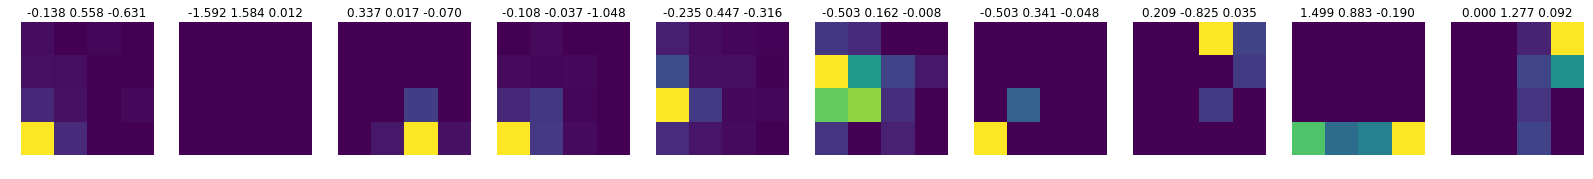

epoch: 90
a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-4.7988) tensor(0.0000, grad_fn=<SumBackward0>)


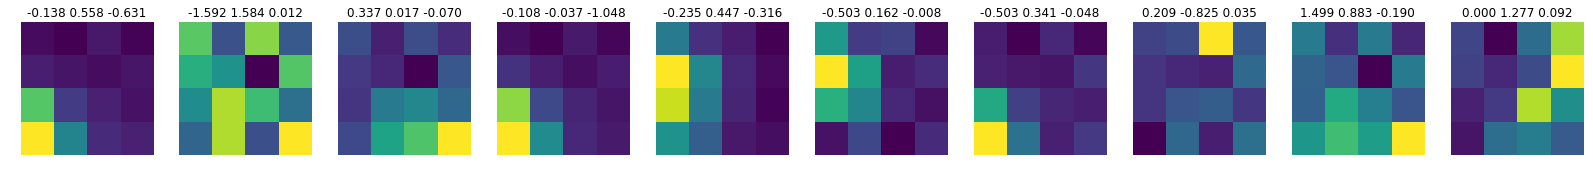

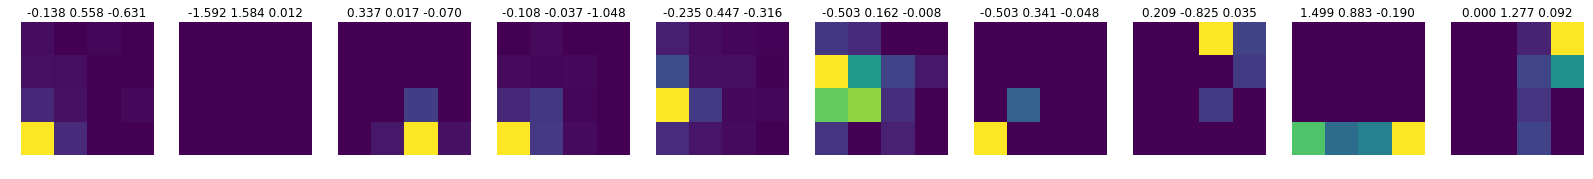

Train loss: -4.816742617929695 Batch 1500 of 500           a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-4.9308) tensor(0.0000, grad_fn=<SumBackward0>)


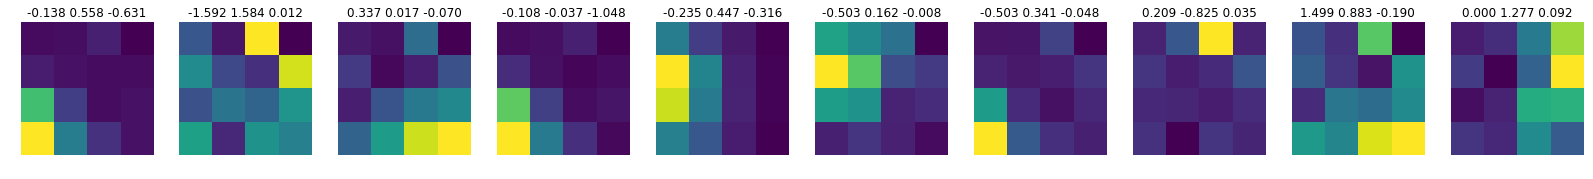

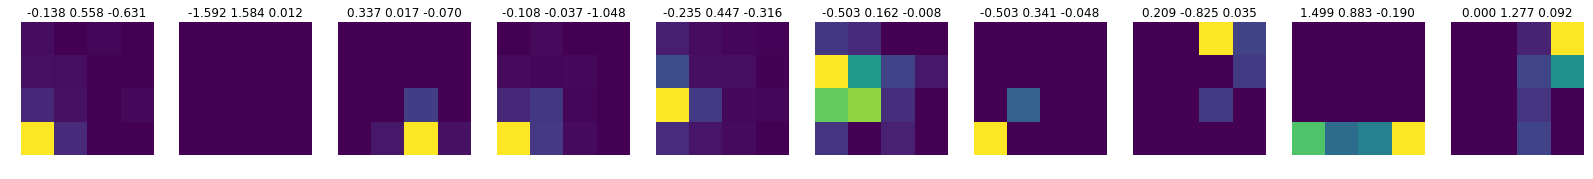

epoch: 91
a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-4.9162) tensor(0.0000, grad_fn=<SumBackward0>)


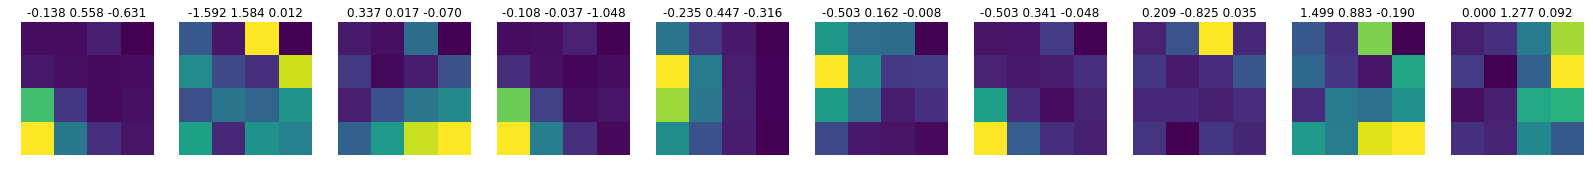

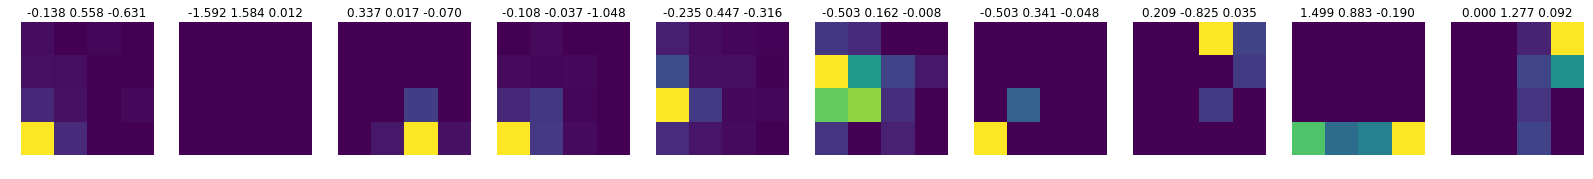

Train loss: -4.921681076116858 Batch 1500 of 500           a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-5.1874) tensor(0.0000, grad_fn=<SumBackward0>)


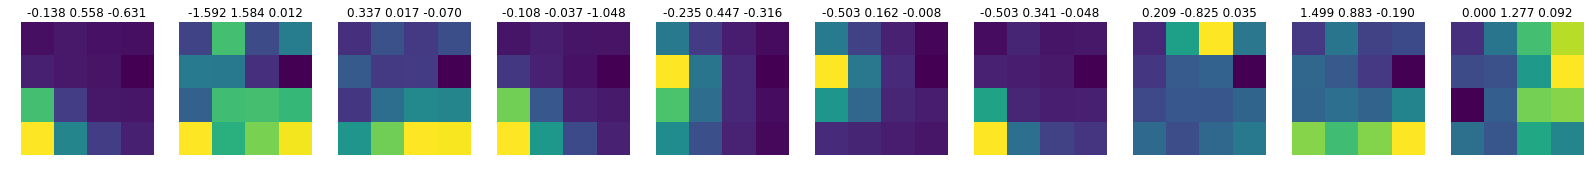

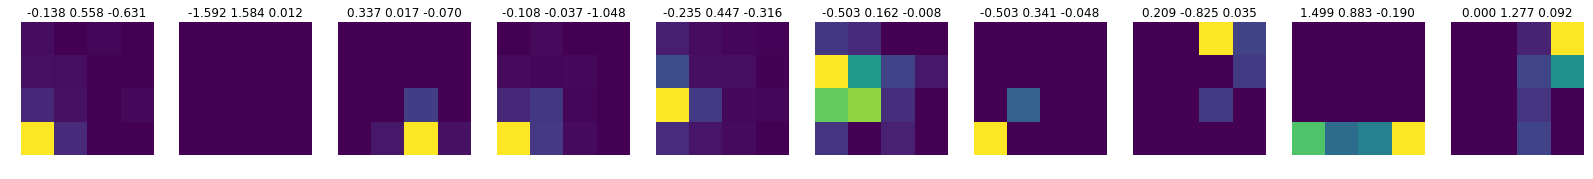

epoch: 92
a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-5.1891) tensor(0.0000, grad_fn=<SumBackward0>)


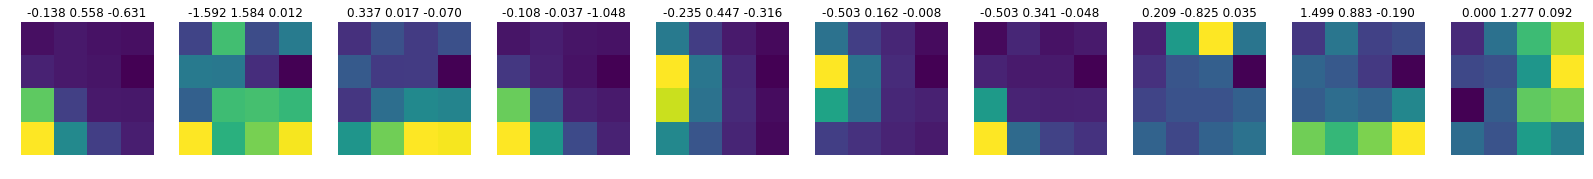

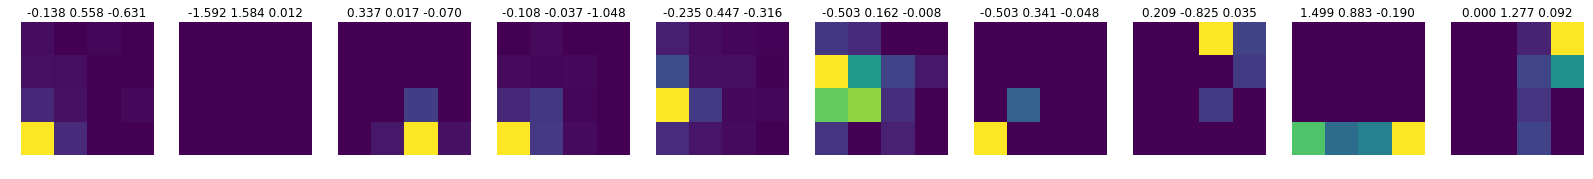

Train loss: -4.9956626131061626 Batch 1500 of 500           a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-4.9664) tensor(0.0000, grad_fn=<SumBackward0>)


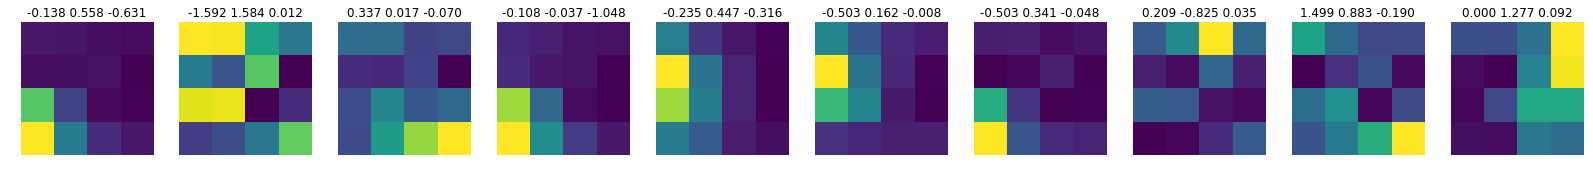

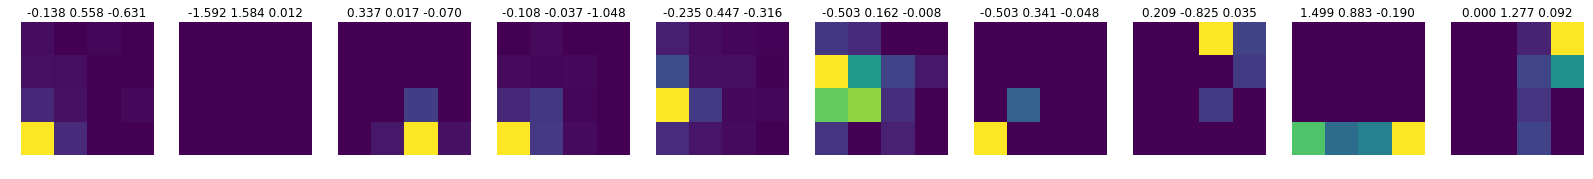

epoch: 93
a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-4.9617) tensor(0.0000, grad_fn=<SumBackward0>)


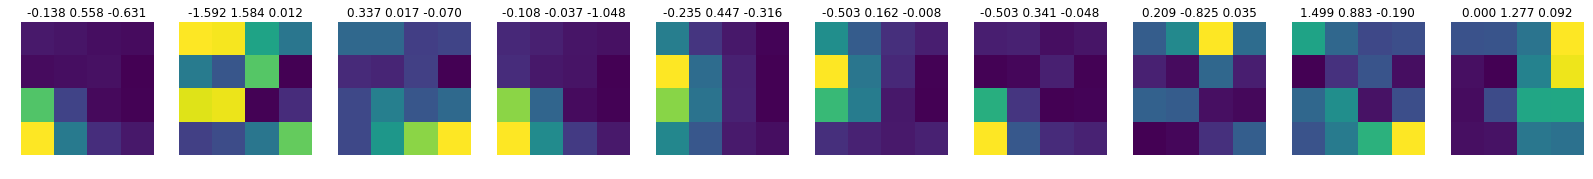

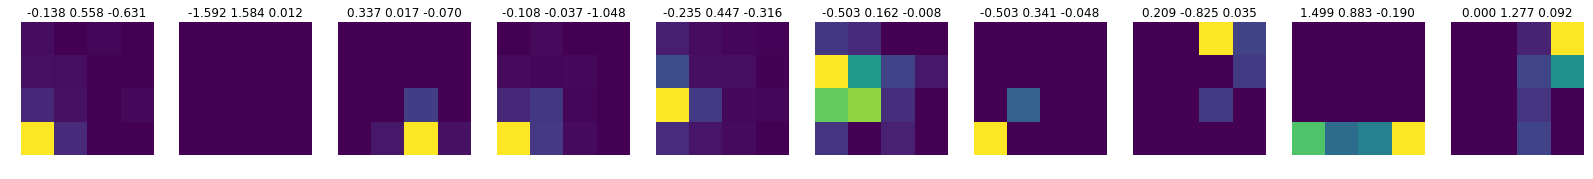

Train loss: -4.870600729700275 Batch 1500 of 500           a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-4.7288) tensor(2.7218e-06, grad_fn=<SumBackward0>)


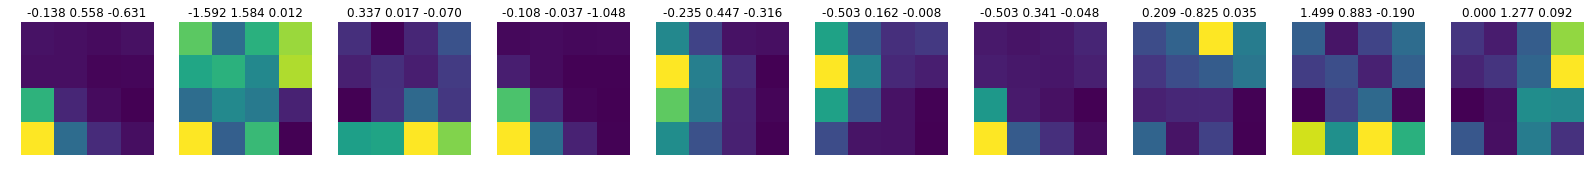

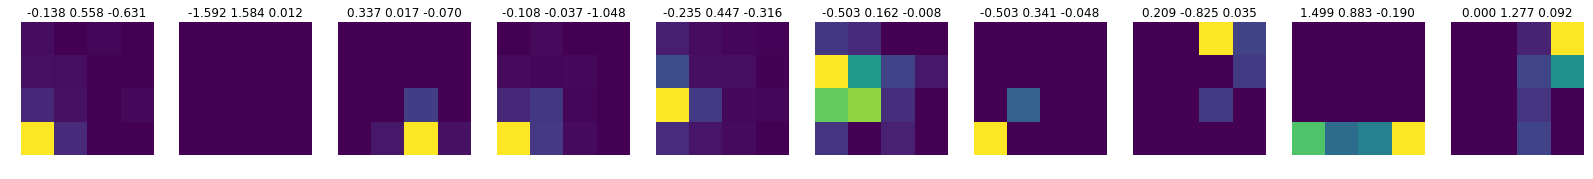

epoch: 94
a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-4.7361) tensor(2.7218e-06, grad_fn=<SumBackward0>)


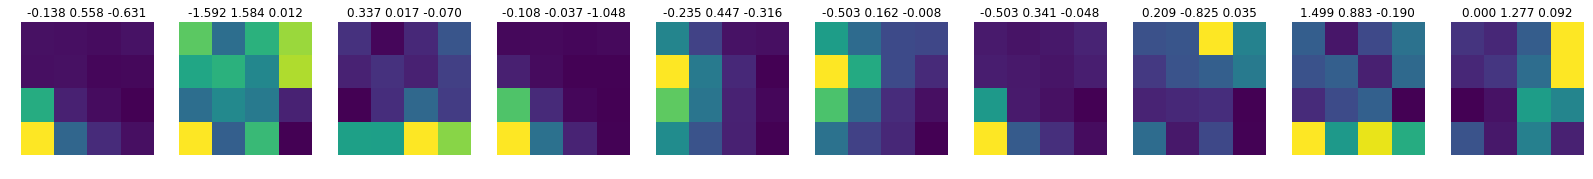

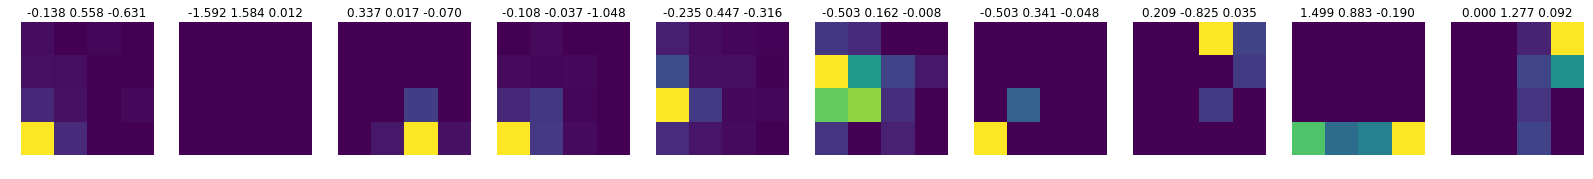

Train loss: -4.577189748872992 Batch 1500 of 500           a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-4.9005) tensor(6.6648e-06, grad_fn=<SumBackward0>)


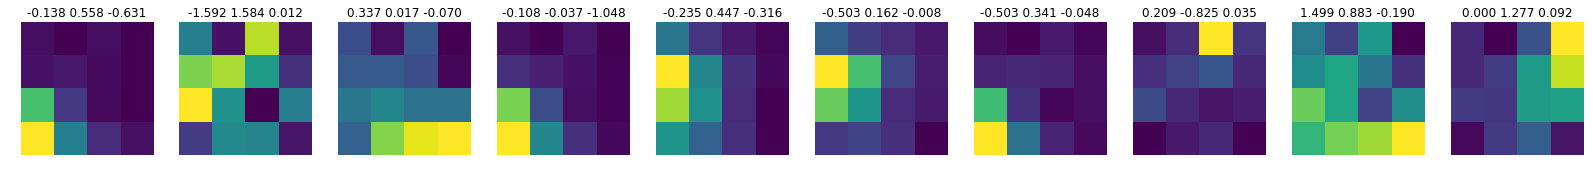

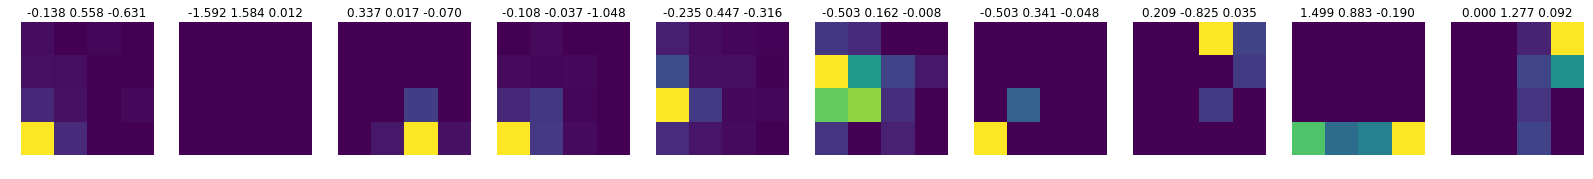

epoch: 95
a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-4.8828) tensor(6.6648e-06, grad_fn=<SumBackward0>)


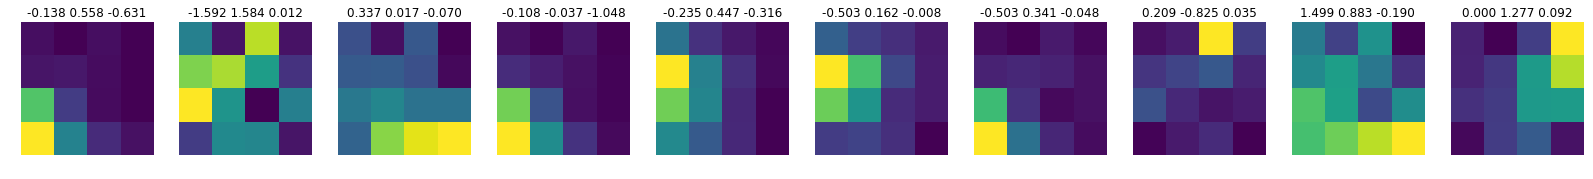

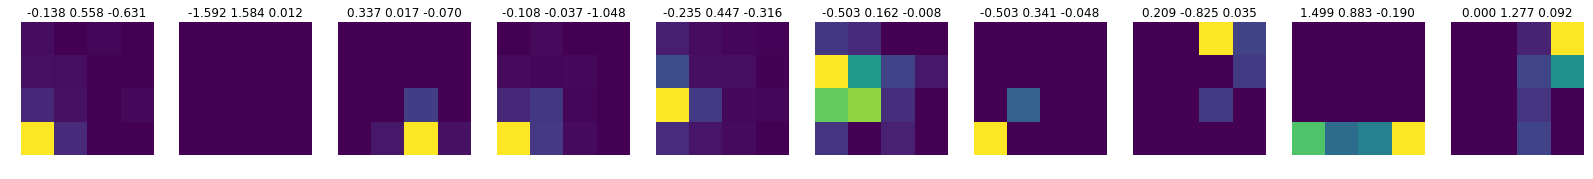

Train loss: -4.674950739572779 Batch 1500 of 500           a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-5.0341) tensor(0.0000, grad_fn=<SumBackward0>)


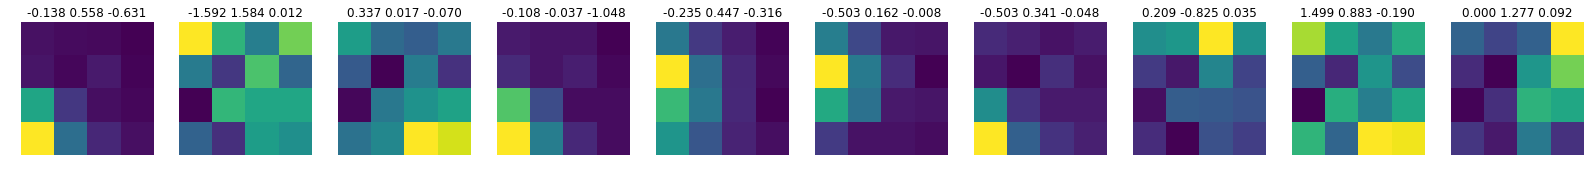

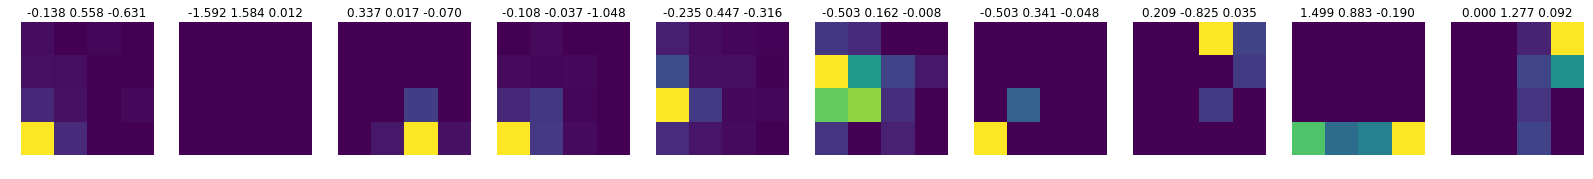

epoch: 96
a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-5.0460) tensor(0.0000, grad_fn=<SumBackward0>)


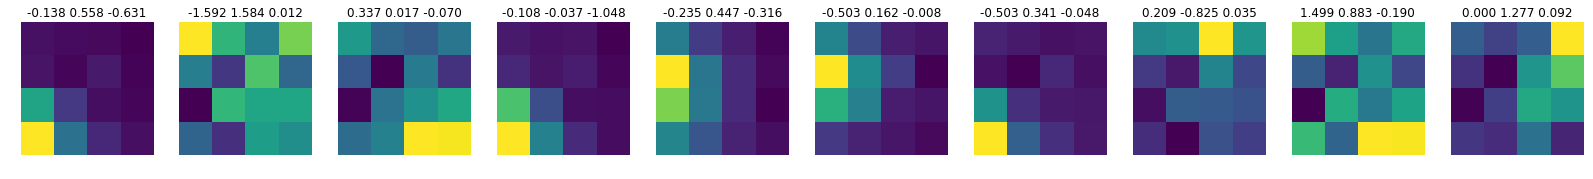

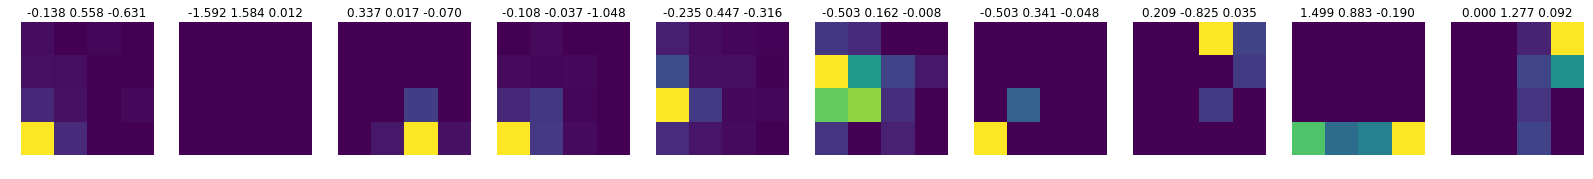

Train loss: -4.865661862086176 Batch 1500 of 500           a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-5.1088) tensor(3.9392e-06, grad_fn=<SumBackward0>)


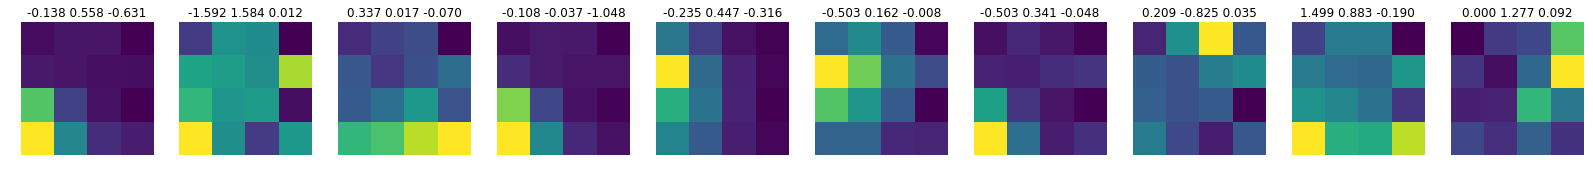

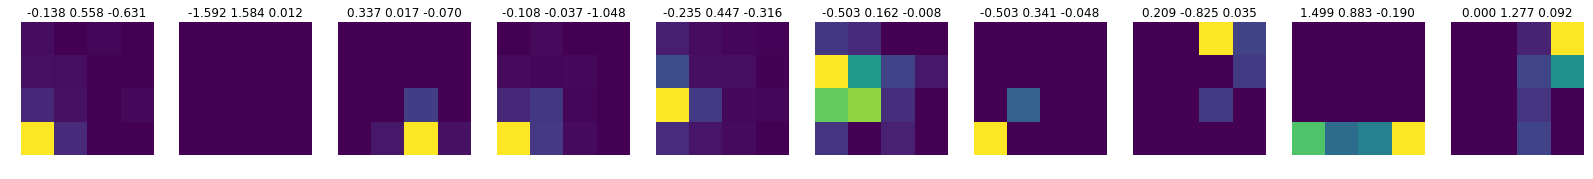

epoch: 97
a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-5.1014) tensor(3.9392e-06, grad_fn=<SumBackward0>)


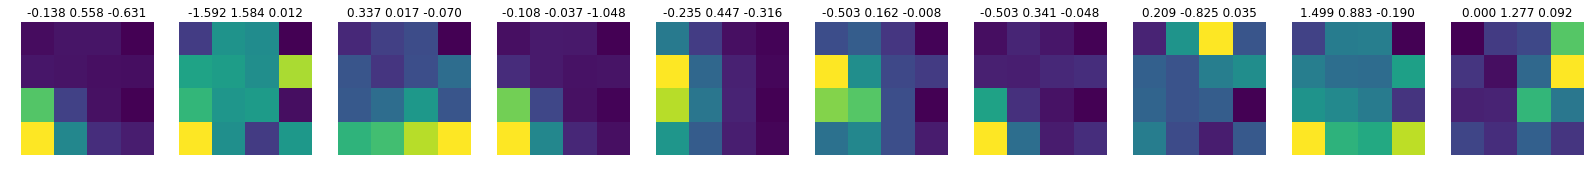

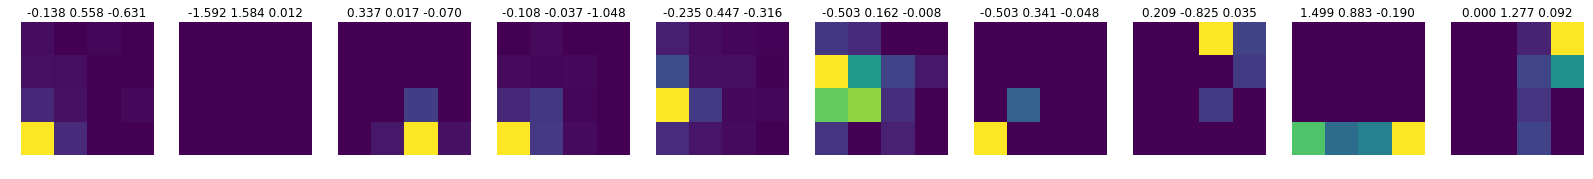

Train loss: -5.023711889680849 Batch 1500 of 500           a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-4.8047) tensor(3.7517e-06, grad_fn=<SumBackward0>)


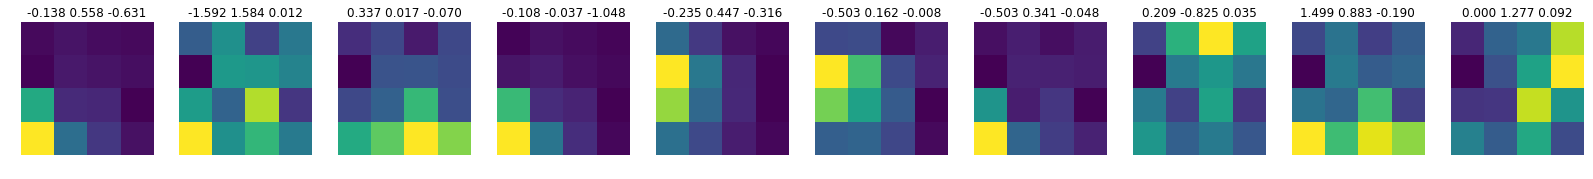

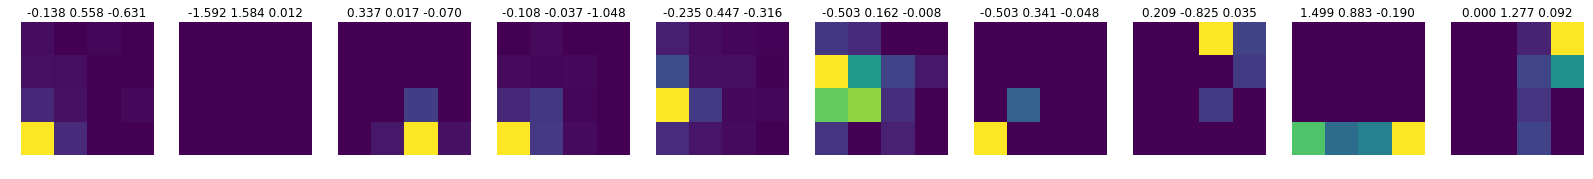

epoch: 98
a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-4.7995) tensor(3.7517e-06, grad_fn=<SumBackward0>)


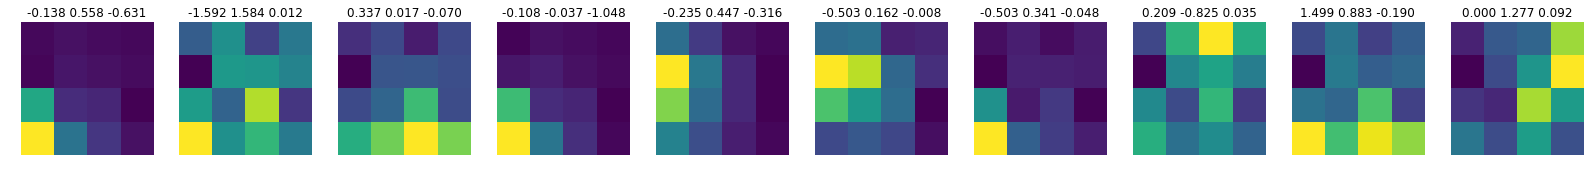

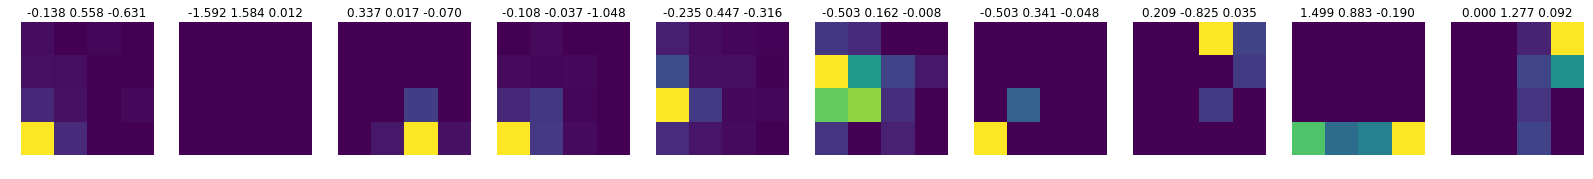

Train loss: -4.721053154029262 Batch 1500 of 500           a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-4.7530) tensor(0.0000, grad_fn=<SumBackward0>)


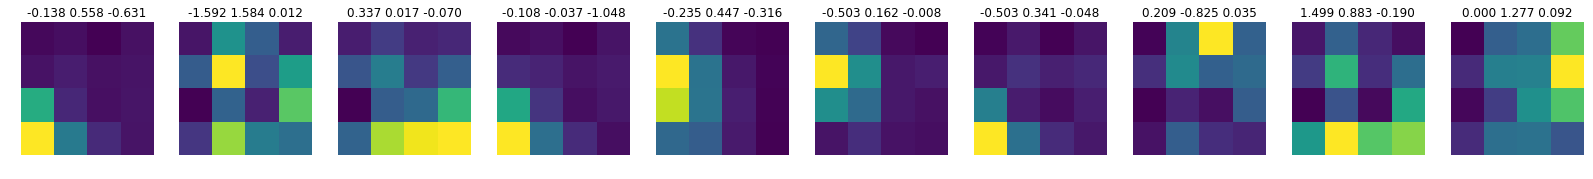

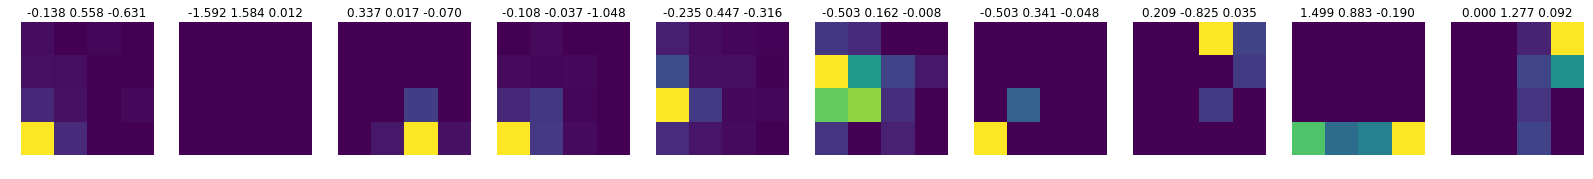

epoch: 99
a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-4.7552) tensor(0.0000, grad_fn=<SumBackward0>)


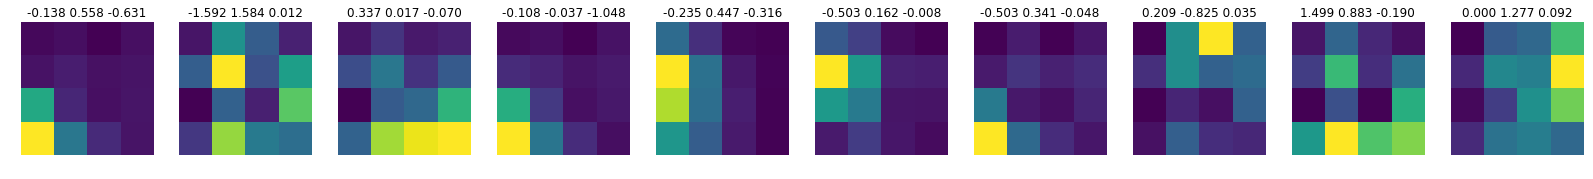

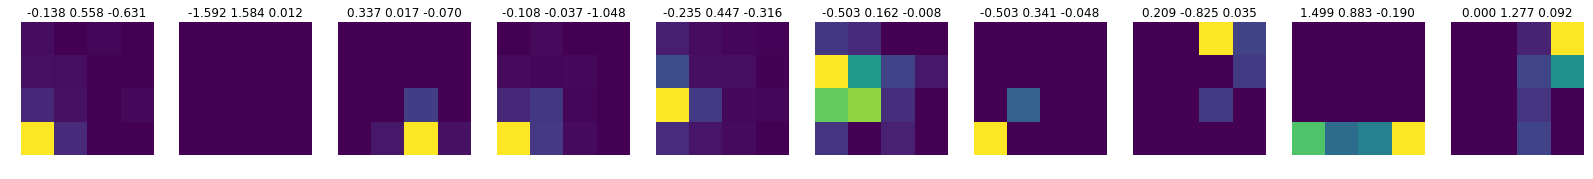

Train loss: -4.793979374565113 Batch 1500 of 500           a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-4.8666) tensor(1.9047e-06, grad_fn=<SumBackward0>)


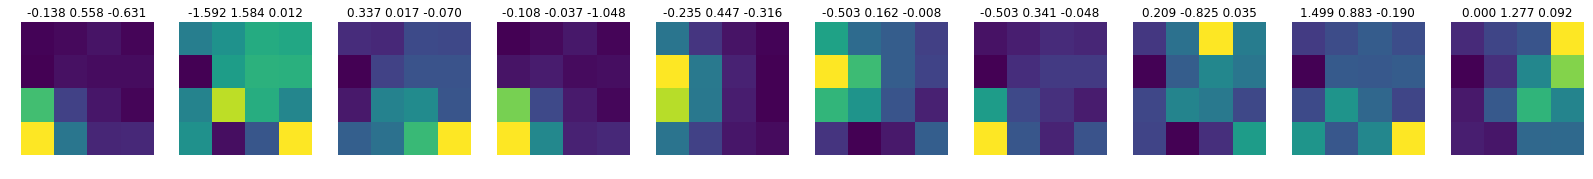

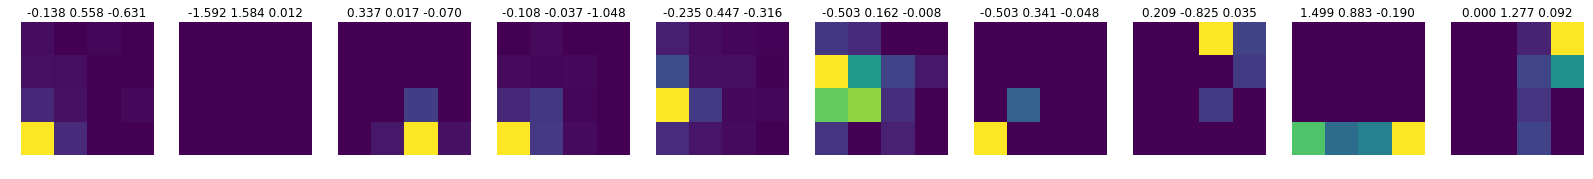

epoch: 100
a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-4.8710) tensor(1.9047e-06, grad_fn=<SumBackward0>)


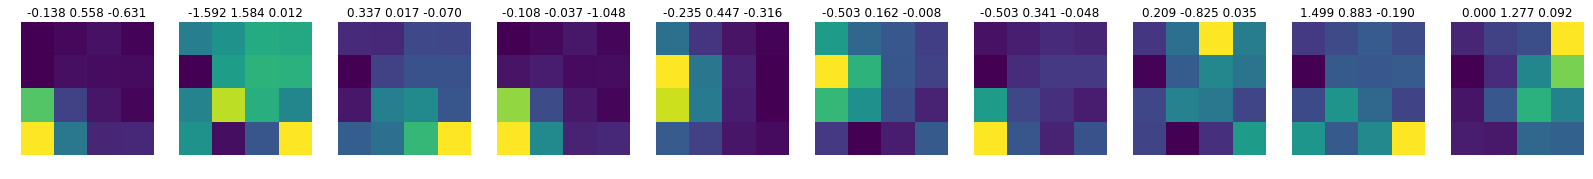

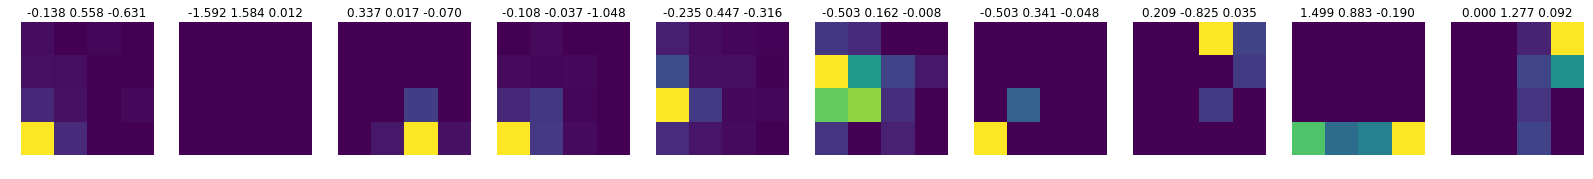

Train loss: -4.640210523810223 Batch 1500 of 500           a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-4.8197) tensor(8.6301e-06, grad_fn=<SumBackward0>)


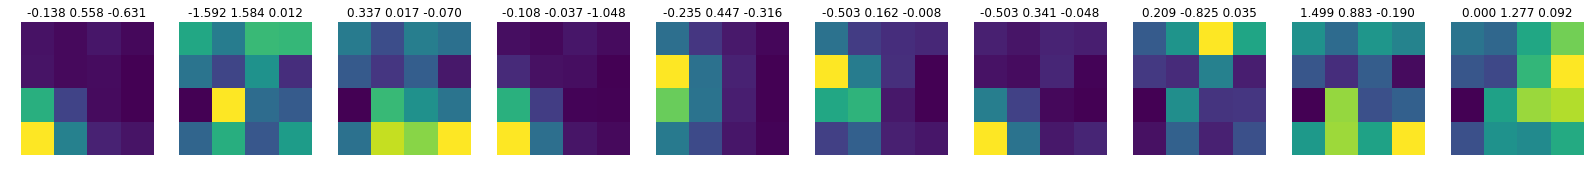

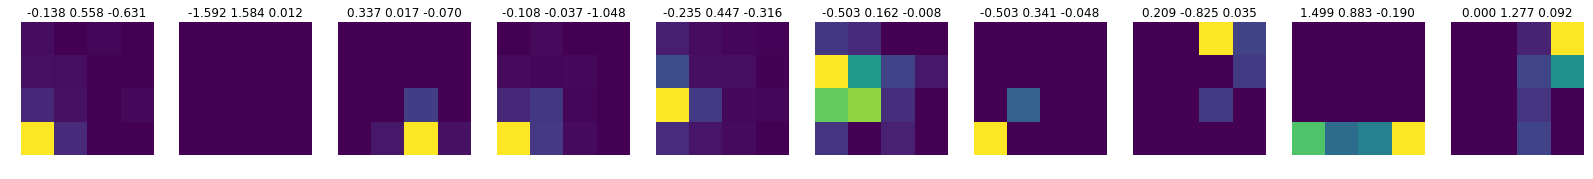

epoch: 101
a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-4.8212) tensor(8.6301e-06, grad_fn=<SumBackward0>)


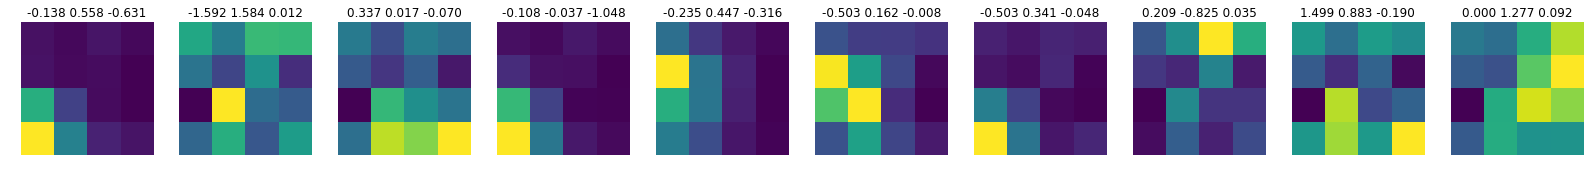

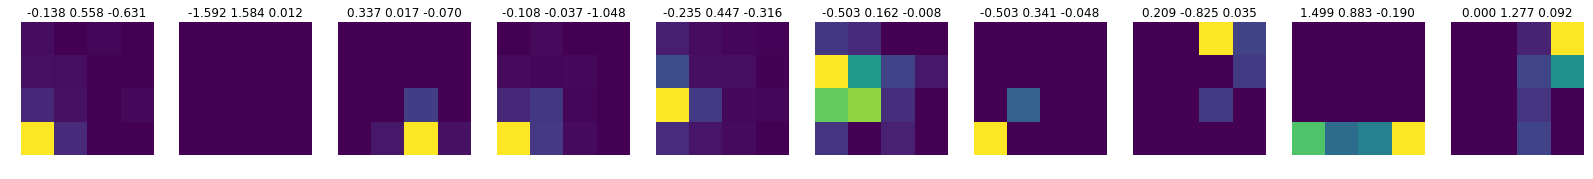

Train loss: -4.687012154291006 Batch 1500 of 500           a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-5.1053) tensor(4.4410e-06, grad_fn=<SumBackward0>)


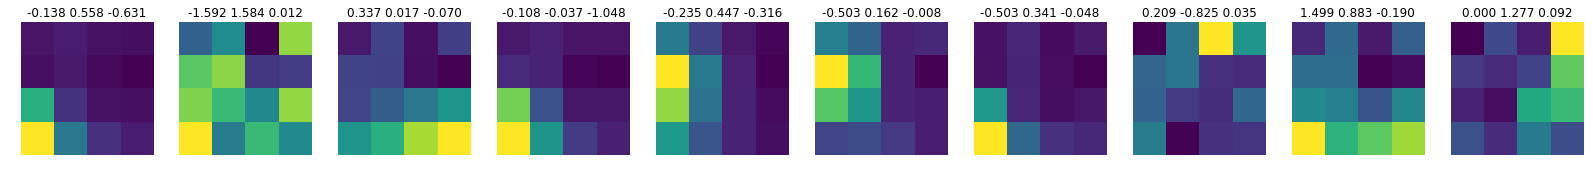

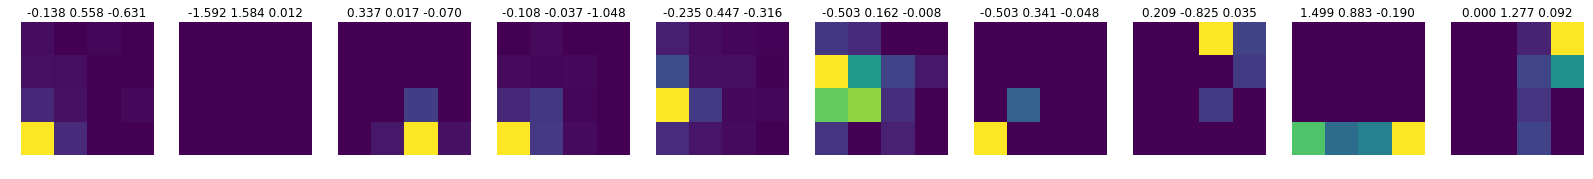

epoch: 102
a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-5.1002) tensor(4.4410e-06, grad_fn=<SumBackward0>)


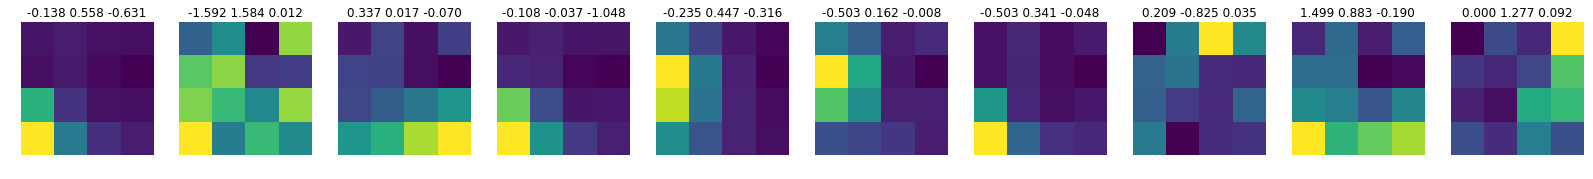

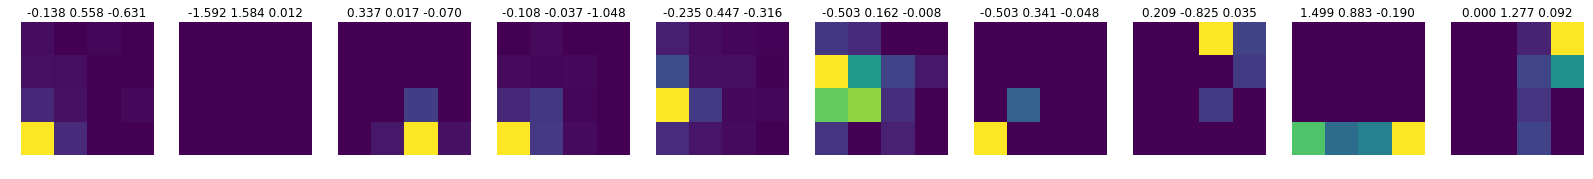

Train loss: -4.97866866720594 Batch 1500 of 500           a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-4.7012) tensor(3.4465e-06, grad_fn=<SumBackward0>)


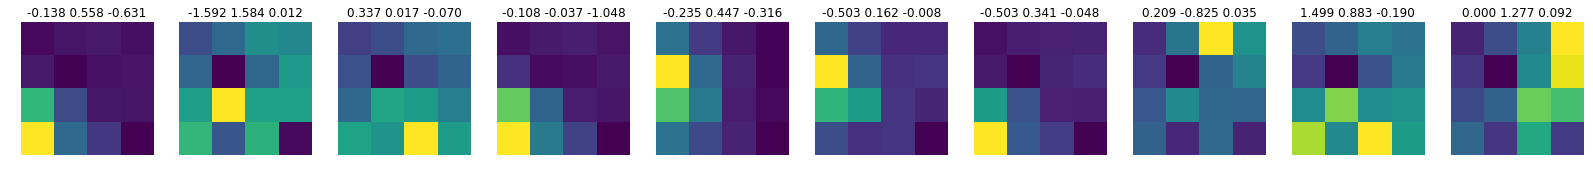

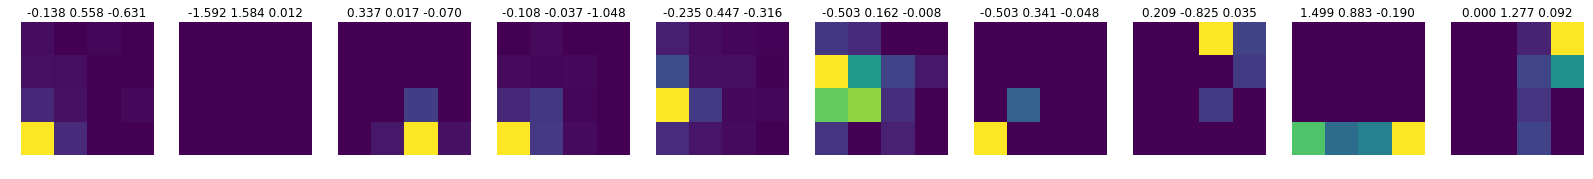

epoch: 103
a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-4.7087) tensor(3.4465e-06, grad_fn=<SumBackward0>)


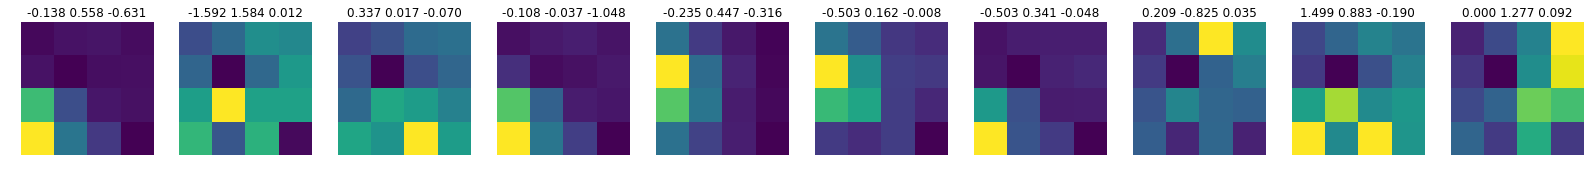

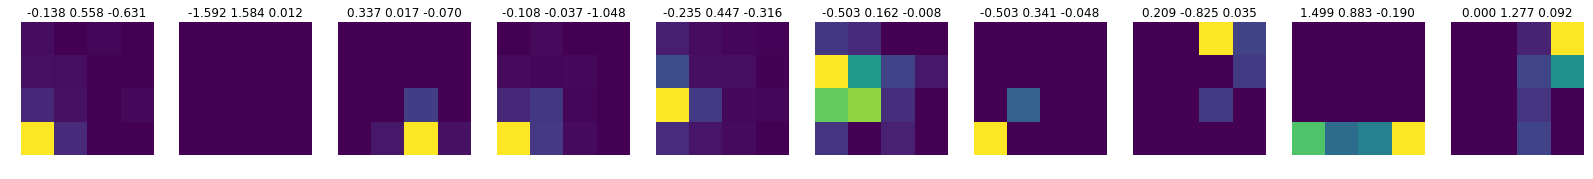

Train loss: -4.597613912607677 Batch 1500 of 500           a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-4.7287) tensor(4.5631e-06, grad_fn=<SumBackward0>)


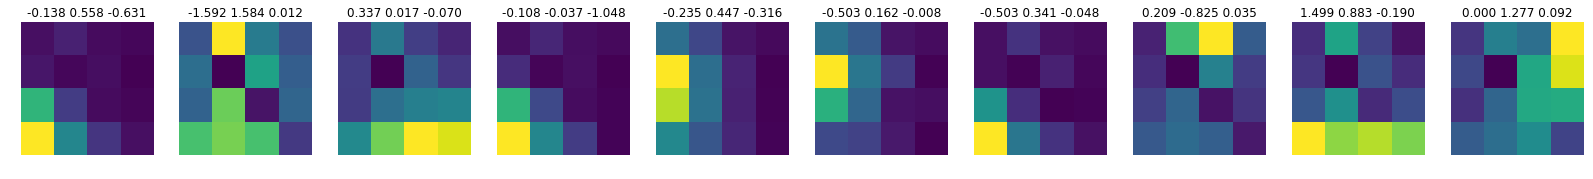

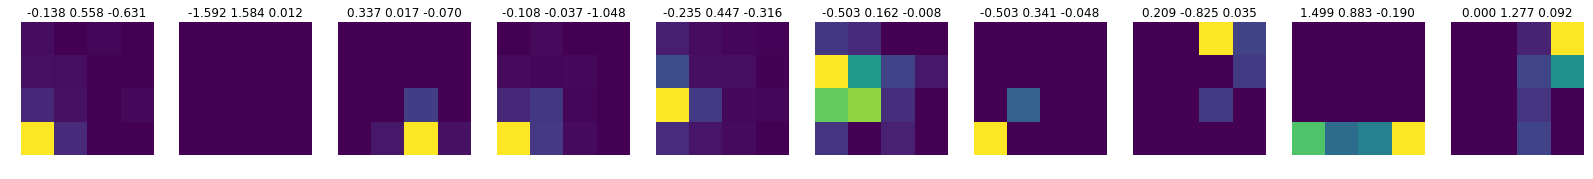

epoch: 104
a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-4.7258) tensor(4.5631e-06, grad_fn=<SumBackward0>)


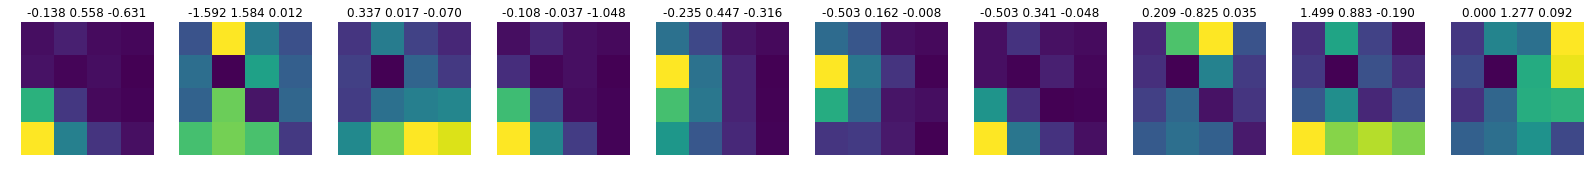

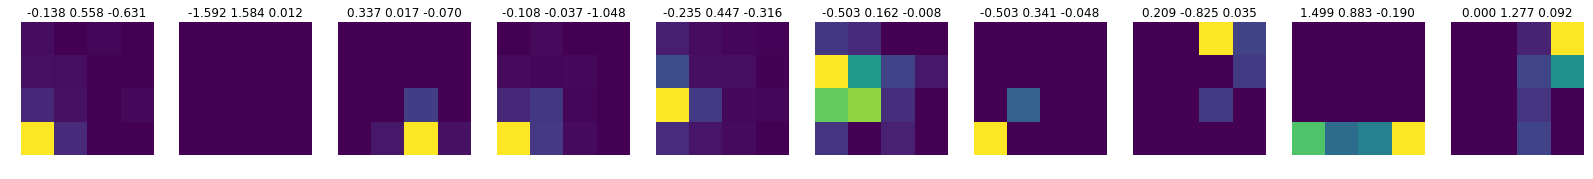

Train loss: -4.745968274083431 Batch 1500 of 500           a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-5.0688) tensor(5.2000e-06, grad_fn=<SumBackward0>)


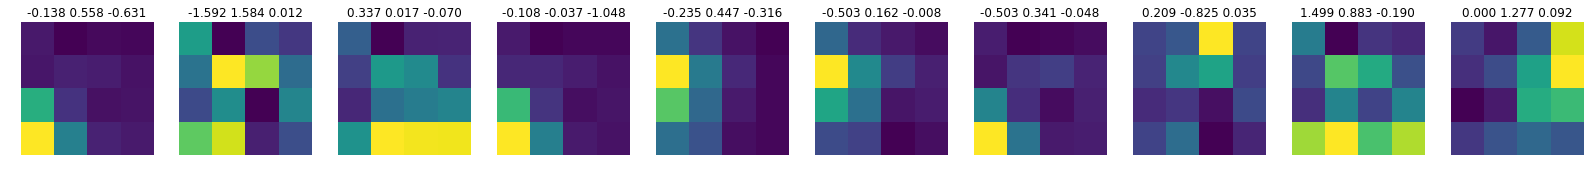

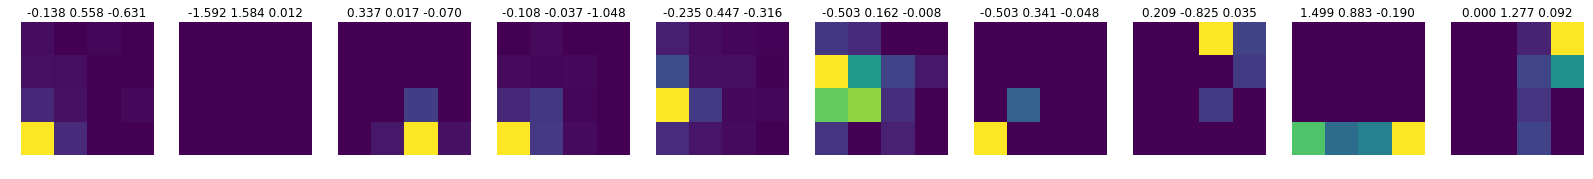

epoch: 105
a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-5.0704) tensor(5.2000e-06, grad_fn=<SumBackward0>)


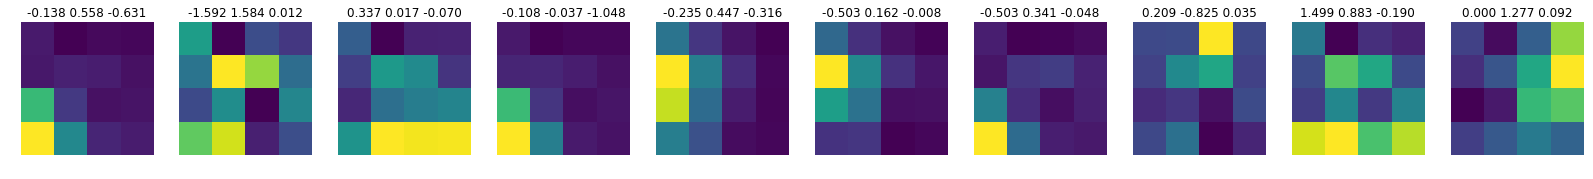

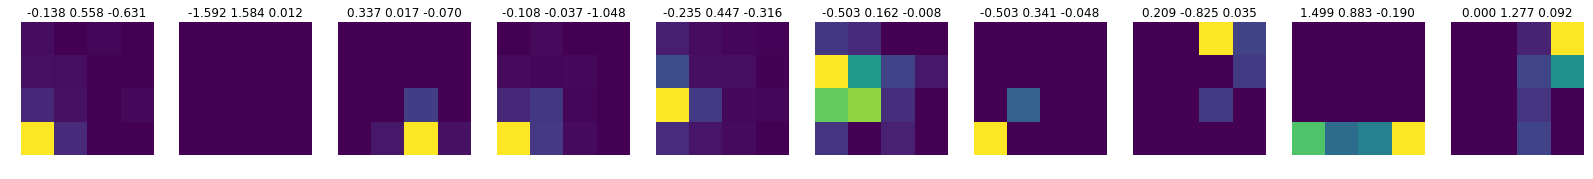

Train loss: -4.998659415337344 Batch 1500 of 500           a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-5.0272) tensor(3.5652e-06, grad_fn=<SumBackward0>)


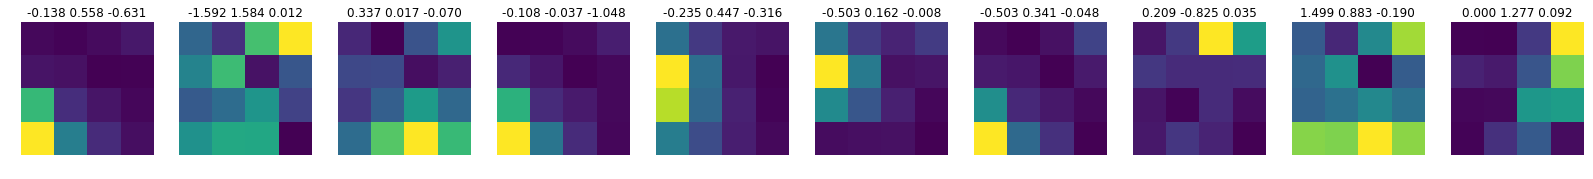

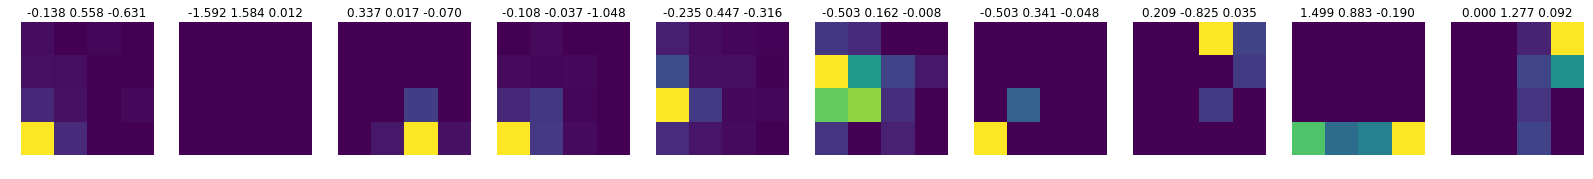

epoch: 106
a_gen shape torch.Size([10, 16])
alpha  1
batch_loss:loss_simple, KL tensor(-5.0345) tensor(3.5652e-06, grad_fn=<SumBackward0>)


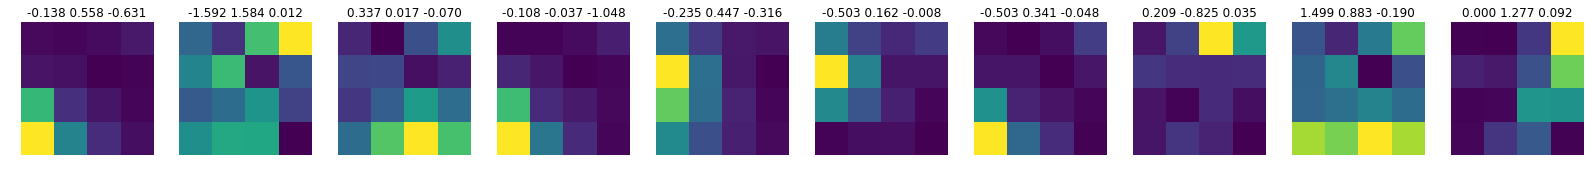

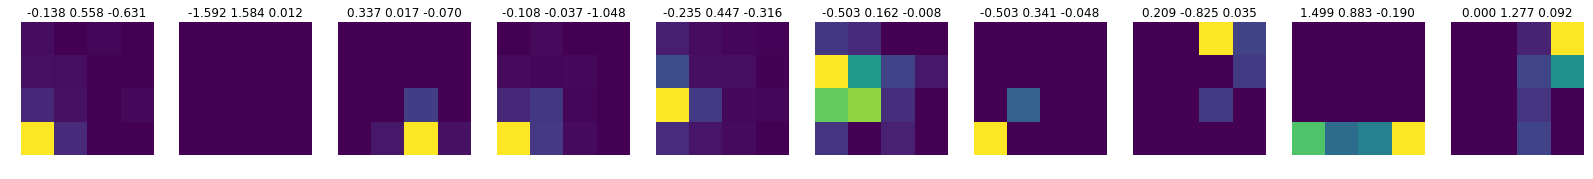

Train loss: -5.024501424326358 Batch 1500 of 500           

In [ ]:
a = CVAE(3, 5, 16, 0.5)
vae_model_d2_k1 = train_model(a, tests=[])

In [ ]:
vae_model_d2_k1

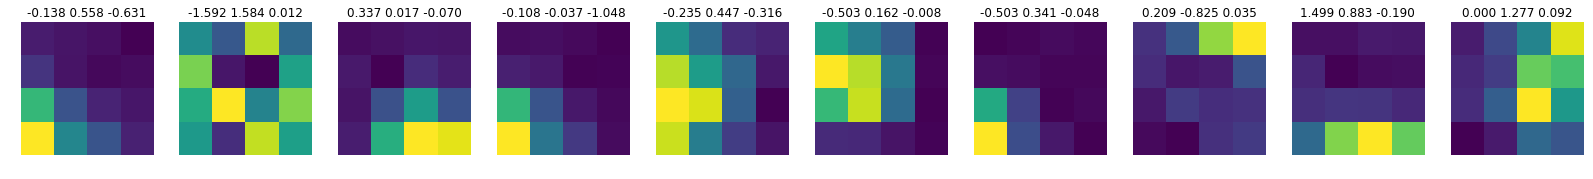

In [58]:
a_gen = a.generate_samples(Variable(torch.cuda.DoubleTensor(data_x[20:30]).to(device)))
show_images(a_gen, Variable(torch.from_numpy(data_x[20:30])))

In [ ]:
with open("/home/sayankotor/data/VAEResG/DUMP/model_a_main.txt","wb") as file:
    pickle.dump(a,file)

epoch: 0
Train loss: -2.8730755862346173 Batch 90 of 500           proposal mu  tensor([[ 0.0001,  0.0002, -0.0009, -0.0009, -0.0006, -0.0003, -0.0006,  0.0025,
          0.0006,  0.0005,  0.0003],
        [-0.0001,  0.0001, -0.0010, -0.0008, -0.0006, -0.0005, -0.0008,  0.0021,
          0.0005,  0.0004,  0.0001],
        [ 0.0001,  0.0001, -0.0010, -0.0007, -0.0008, -0.0002, -0.0006,  0.0025,
          0.0010,  0.0005,  0.0002],
        [-0.0001, -0.0001, -0.0011, -0.0006, -0.0008, -0.0004, -0.0007,  0.0022,
          0.0008,  0.0006,  0.0001]], grad_fn=<SliceBackward>)
proposal sigma  tensor([[1.0003, 1.0001, 1.0001, 1.0004, 1.0001, 0.9998, 0.9989, 0.9996, 1.0004,
         0.9991, 1.0000],
        [1.0001, 0.9999, 0.9994, 1.0000, 0.9995, 0.9993, 0.9991, 0.9996, 1.0003,
         0.9992, 1.0000],
        [0.9998, 0.9996, 0.9990, 0.9998, 0.9995, 0.9992, 0.9980, 0.9989, 1.0000,
         0.9984, 0.9996],
        [1.0000, 1.0000, 0.9997, 1.0001, 0.9997, 0.9997, 0.9989, 0.9994, 1.0003,
    

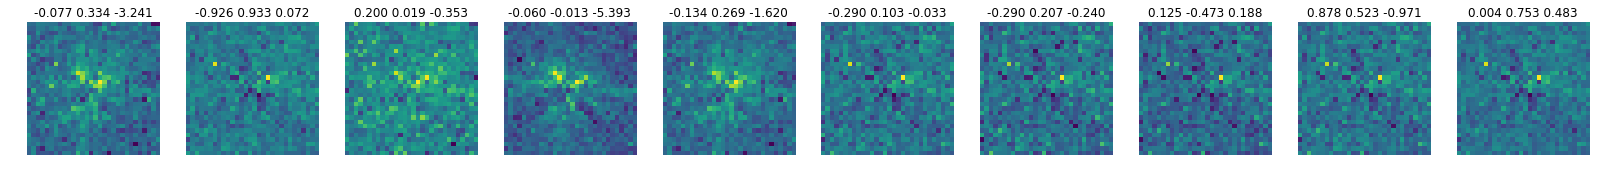

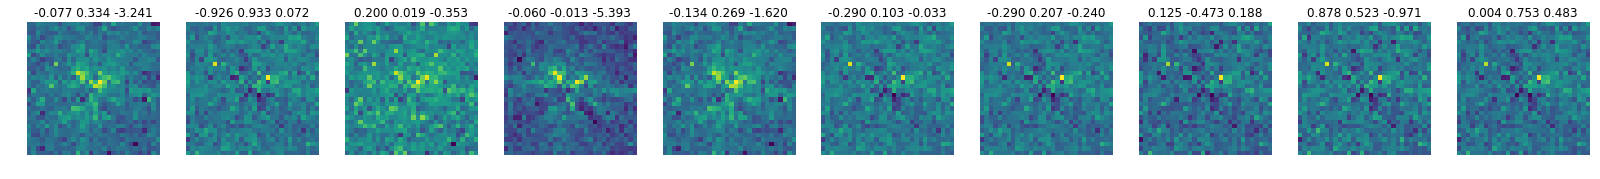

Train loss: -3.160628962611352 Batch 100 of 500           tensor(2.2597)
tensor(-0.0970)


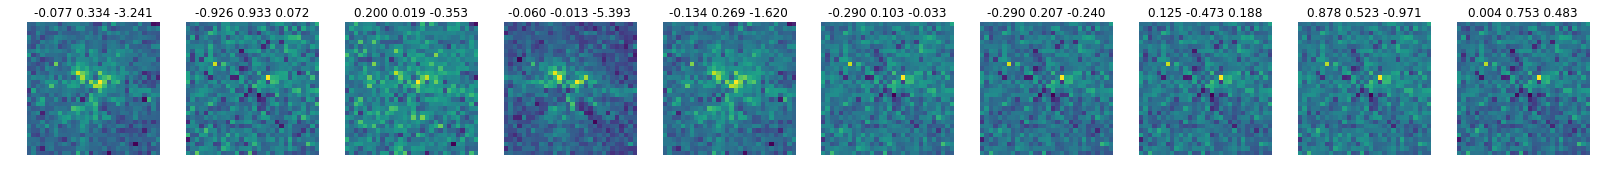

Train loss: -3.6162144282963253 Batch 190 of 500           proposal mu  tensor([[-0.0004, -0.0001,  0.0002,  0.0001,  0.0006,  0.0002,  0.0001,  0.0001,
         -0.0004, -0.0001,  0.0002],
        [-0.0006,  0.0007, -0.0001,  0.0002,  0.0007,  0.0005, -0.0000,  0.0003,
          0.0003, -0.0002,  0.0001],
        [-0.0008,  0.0004,  0.0001,  0.0002,  0.0008,  0.0006,  0.0001, -0.0002,
          0.0008, -0.0007, -0.0001],
        [-0.0006,  0.0005, -0.0000,  0.0002,  0.0008,  0.0003,  0.0001,  0.0003,
          0.0001, -0.0002,  0.0001]], grad_fn=<SliceBackward>)
proposal sigma  tensor([[1.0012, 1.0007, 1.0014, 1.0008, 1.0013, 1.0009, 1.0012, 1.0011, 1.0003,
         1.0011, 1.0013],
        [1.0005, 0.9997, 0.9998, 1.0001, 1.0002, 1.0000, 0.9993, 0.9994, 0.9998,
         0.9992, 1.0000],
        [0.9984, 0.9976, 0.9962, 0.9980, 0.9980, 0.9976, 0.9970, 0.9977, 0.9983,
         0.9972, 0.9982],
        [1.0008, 0.9998, 0.9999, 1.0001, 1.0003, 1.0001, 0.9995, 0.9996, 0.9999,
         0.9

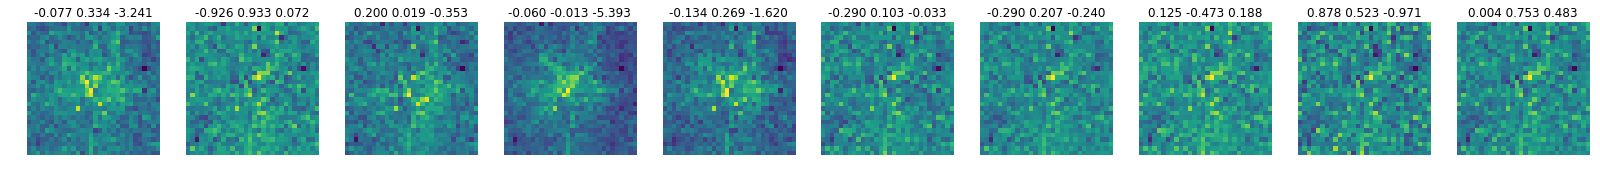

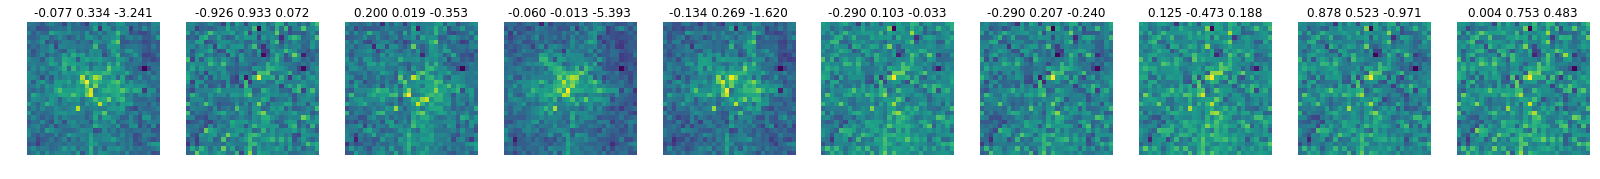

Train loss: -3.844535635809878 Batch 200 of 500           tensor(2.2597)
tensor(0.0539)


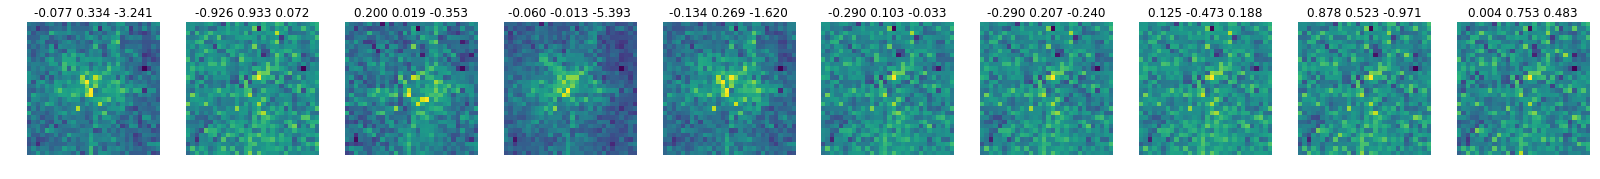

Train loss: -3.917216911421635 Batch 230 of 500            

KeyboardInterrupt: 

In [52]:
#b = CVAE(11, 5, 900, 0.5).cuda().to(device)
with open("/home/sayankotor/data/VAEResG/DUMP/model_DUMP.txt","rb") as mod:
    b = pickle.load(mod)

vae_model_d2_k1 = train_model(b, tests=[])

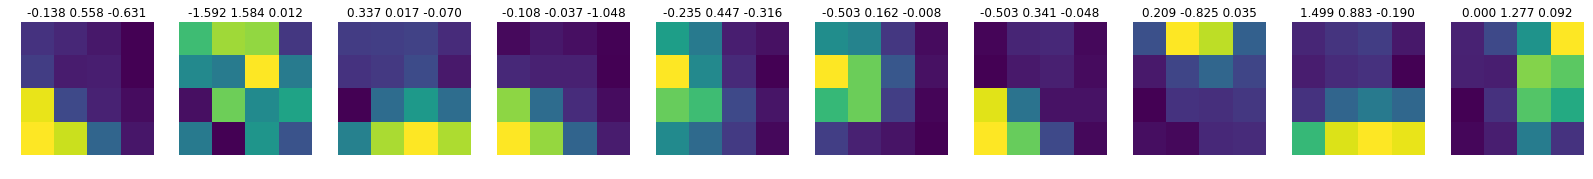

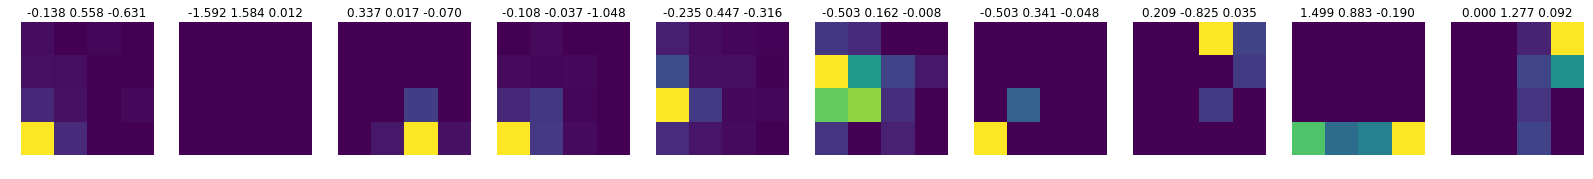

In [67]:
a_gen = a.generate_samples(Variable(torch.cuda.DoubleTensor(data_x[20:30]).to(device)))
show_images(a_gen, Variable(torch.from_numpy(data_x[20:30])))
show_images(Variable(torch.from_numpy(n_cut_data[20:30])), Variable(torch.from_numpy(data_x[20:30])))

In [78]:
n_gen_img = []

min_ = np.min(a_gen)
max_ = np.max(a_gen)

for i, elem in enumerate(a_gen):
    if (i%5000 == 0):
        print (i)
    n_elem = (elem - min_)/(max_ - min_)*3371.953567922453
    n_gen_img.append(n_elem)
n_gen_img = np.array(n_gen_img)

0


In [69]:
generated_images = a.generate_samples(Variable(torch.cuda.DoubleTensor(data_x[0:100]).to(device))).cpu().detach().numpy()
print ("generated.shape", generated_images.shape)
for i in range(data_x.shape[0]):
    j = 100*(i+1)
    local_generated_images = a.generate_samples(Variable(torch.cuda.DoubleTensor(data_x[j:j+100]).to(device)))
    print (type(generated_images))
    print (type(local_generated_images))
    generated_images = np.concatenate((generated_images, local_generated_images.cpu().detach().numpy()), axis=0)
    if (i%100 == 0):
        print (i)
        print ("local_generated_images.shape",local_generated_images.shape)

generated.shape (100, 16)
<class 'numpy.ndarray'>
<class 'torch.Tensor'>
0
local_generated_images.shape torch.Size([100, 16])
<class 'numpy.ndarray'>
<class 'torch.Tensor'>
<class 'numpy.ndarray'>
<class 'torch.Tensor'>
<class 'numpy.ndarray'>
<class 'torch.Tensor'>
<class 'numpy.ndarray'>
<class 'torch.Tensor'>
<class 'numpy.ndarray'>
<class 'torch.Tensor'>
<class 'numpy.ndarray'>
<class 'torch.Tensor'>
<class 'numpy.ndarray'>
<class 'torch.Tensor'>
<class 'numpy.ndarray'>
<class 'torch.Tensor'>
<class 'numpy.ndarray'>
<class 'torch.Tensor'>
<class 'numpy.ndarray'>
<class 'torch.Tensor'>
<class 'numpy.ndarray'>
<class 'torch.Tensor'>
<class 'numpy.ndarray'>
<class 'torch.Tensor'>
<class 'numpy.ndarray'>
<class 'torch.Tensor'>
<class 'numpy.ndarray'>
<class 'torch.Tensor'>
<class 'numpy.ndarray'>
<class 'torch.Tensor'>
<class 'numpy.ndarray'>
<class 'torch.Tensor'>
<class 'numpy.ndarray'>
<class 'torch.Tensor'>
<class 'numpy.ndarray'>
<class 'torch.Tensor'>
<class 'numpy.ndarray'>
<cla

<class 'numpy.ndarray'>
<class 'torch.Tensor'>
<class 'numpy.ndarray'>
<class 'torch.Tensor'>
<class 'numpy.ndarray'>
<class 'torch.Tensor'>
<class 'numpy.ndarray'>
<class 'torch.Tensor'>
<class 'numpy.ndarray'>
<class 'torch.Tensor'>
<class 'numpy.ndarray'>
<class 'torch.Tensor'>
<class 'numpy.ndarray'>
<class 'torch.Tensor'>
<class 'numpy.ndarray'>
<class 'torch.Tensor'>
<class 'numpy.ndarray'>
<class 'torch.Tensor'>
<class 'numpy.ndarray'>
<class 'torch.Tensor'>
<class 'numpy.ndarray'>
<class 'torch.Tensor'>
<class 'numpy.ndarray'>
<class 'torch.Tensor'>
<class 'numpy.ndarray'>
<class 'torch.Tensor'>
<class 'numpy.ndarray'>
<class 'torch.Tensor'>
<class 'numpy.ndarray'>
<class 'torch.Tensor'>
<class 'numpy.ndarray'>
<class 'torch.Tensor'>
<class 'numpy.ndarray'>
<class 'torch.Tensor'>
<class 'numpy.ndarray'>
<class 'torch.Tensor'>
<class 'numpy.ndarray'>
<class 'torch.Tensor'>
<class 'numpy.ndarray'>
<class 'torch.Tensor'>
<class 'numpy.ndarray'>
<class 'torch.Tensor'>
<class 'numpy

RuntimeError: cannot unsqueeze empty tensor

In [87]:
generated_images.shape

(29600, 900)

In [70]:
print (np.max(generated_images), np.min(generated_images))

2.360903029399736 -1.1254846445711986


In [71]:
n_generated_images = []

min_ = np.min(generated_images)
max_ = np.max(generated_images)

for i, elem in enumerate(generated_images):
    if (i%5000 == 0):
        print (i)
    n_elem = (elem - min_)/(max_ - min_)*3371.953567922453
    n_generated_images.append(n_elem)
n_generated_images = np.array(n_generated_images)
print (n_generated_images.shape)

0
5000
10000
15000
20000
25000
(29600, 16)


In [72]:
data_point = data['ParticlePoint']
data_momentum = data['ParticleMomentum']
reshape_gen_im = n_generated_images.reshape((29600, 4, 4))

In [73]:
np.savez("n_image.npz", nimage=n_data_img)

In [74]:
np.savez("VAE_4_4.npz", ParticlePoint=data_point, ParticleMomentum=data_momentum, EnergyDeposit = reshape_gen_im, flat = n_generated_images)

In [113]:
print (generated_images[3])

[-4.06038859e-05 -7.54913423e-05  4.53468094e-05  4.09295799e-05
  5.27407868e-05  2.82123676e-05  1.13309279e-04  5.47830431e-05
  2.73034158e-04  1.55011265e-04  2.68316131e-04  3.23647545e-04
  5.34255984e-04  6.05567360e-04  3.43626502e-04  7.92652124e-05
 -6.54828073e-05  2.63823828e-04  1.24692322e-04  7.27274295e-05
  1.29314689e-04  6.24901184e-05  1.45315581e-05  1.54488550e-04
 -8.89636720e-06  8.92661603e-05 -4.70259827e-07 -1.20235368e-05
  3.32842458e-05  8.69843893e-05  1.08474229e-05  3.37206744e-05
  6.97988164e-05  5.84289128e-05  4.72348808e-05 -2.59795618e-05
  1.03315749e-04  1.87836614e-04  2.39448859e-04  1.92558009e-04
  6.69065392e-04  6.71110944e-04  9.60299071e-04  1.06530580e-03
  6.40332864e-04  2.34108491e-04  6.57835700e-05  1.32270709e-04
  7.49903351e-05  1.12851864e-04  1.54342961e-04 -3.74369648e-05
 -7.03693583e-05  4.58196589e-05 -4.56467849e-05  8.64432157e-05
  2.37371821e-05  9.56391696e-06 -4.09927792e-05  5.96860898e-05
 -1.27293102e-06 -1.90938

In [112]:
print (n_generated_images[3])

[528.27211752 527.84134285 529.33339816 529.27885619 529.42469568
 529.12182976 530.17256826 529.44991254 532.14477944 530.68748569
 532.08652336 532.76973085 535.3702294  536.25075029 533.01642205
 529.75220739 527.96492376 532.03105441 530.31312097 529.67148178
 530.37019588 529.54507605 528.95290526 530.68103143 528.66362774
 529.87569461 528.76766954 528.62501485 529.18445504 529.84752033
 528.90741521 529.18984386 529.63532058 529.49493011 529.35671122
 528.45269212 530.04917263 531.09279837 531.73008322 531.15109603
 537.03479552 537.06005308 540.63081838 541.92739438 536.68001914
 531.66414276 529.58574212 530.40669549 529.69942312 530.1669203
 530.67923376 528.31122124 527.90458682 529.3392367  528.20985007
 529.84083816 529.06657217 528.89156705 528.26731564 529.51045317
 528.75775851 528.53771363 531.51226541 529.05317831 529.63559483
 530.44180469 530.43696339 532.47536678 535.18305745 534.49334991
 534.80016606 539.56674486 544.71918694 549.10943948 540.34229434
 533.354725

In [135]:
print (np.min(n_generated_images))
print (np.max(n_generated_images))

0.0
3371.953567922453


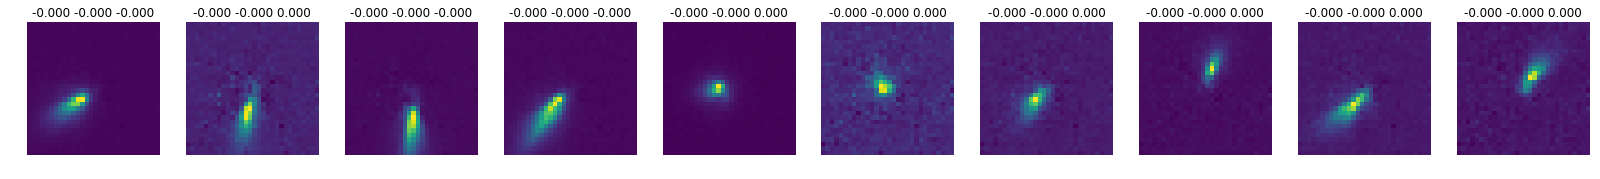

In [94]:
show_images(Variable(torch.from_numpy(generated_images[20:30])), Variable(torch.from_numpy(generated_images[20:30])))

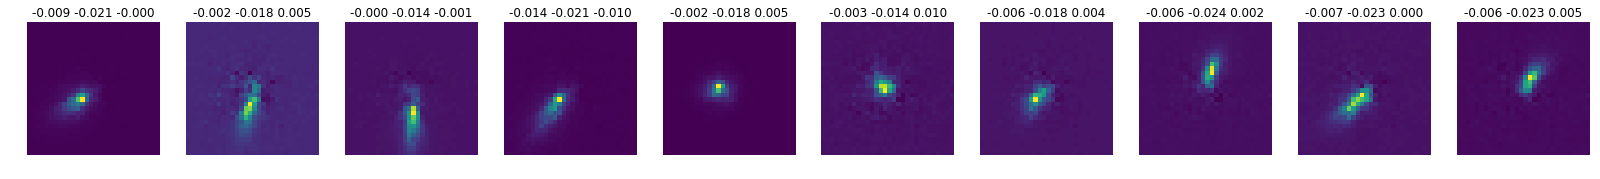

In [184]:
show_images(Variable(torch.from_numpy(reconstr_data_img[20:30])), Variable(torch.from_numpy(reconstr_data_img[20:30])))

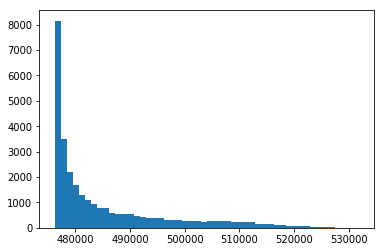

In [109]:
plt.hist(np.sum(reshape_gen_im, axis = (1,2)), bins = 50)
plt.show()

In [15]:
a = data_img[:,15 ,15]
a.shape

(29600,)

In [ ]:
def get_log(array):
    anws = []
    for ind, elem

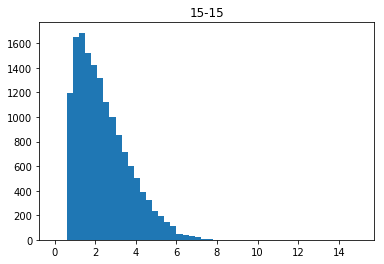

In [40]:
plt.hist(np.log(np.clip(a,a_min = 1e-9, a_max = np.max(a))), range=[0.0, 15.0], bins = 50)
plt.title("15-15")

In [ ]:
vae_model_d2_k1 = train_model(CVAE(8, 5, 900, 0.5), tests=[])

### Визуализация латетного пространства (с точки зрения энкодера)